
## NIO

* Gradient based input optimization from constrained outputs 


## Web application (NOT deployed yet)

* fastAPI

Run interactively on the web at: 




## Inputs



(2, 'i_h2i_rate')

(3, 'i_pci_rate')

(5, 'i_ngi_rate')

(6, 'i_o2_volfract')

(8, 'i_h2_temp')

(9, 'i_hbtemp')

(10, 'i_wind_rt')


## Outputs


* desired output requirements 

Top gas temp > 100C............(27, 'o_tgt')

Hot metal temp > 1700K.........(29, 'o_hmt')

Raceway flame temp > 1900K.....(40, 'o_fta')








## Installs


In [1]:

## !pip install xgboost
## !pip install onnxmltools
## !pip install onnxruntime
## !pip install pandas
## !pip install scikit-learn
## !pip install matplotlib
## !pip install seaborn
## !pip install mlxtend
## ! pip install skl2onnx



## Imports


In [2]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch


import torch.optim as optim


from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)




In [4]:

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import onnxmltools
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster


from zipfile import ZipFile
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)


# Import the ONNX runtime environment
import onnxruntime as rt



In [5]:

import PDFshapingUtils as PDF_tk



## Instantiate PDF shaping and regression class


In [6]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()



## Initialize parameters


In [7]:

PDFshapingOBJ.N_error_range = 5         ## 20
PDFshapingOBJ.mean_impulse  = 0.0       ## -7.0      ## 0.0
PDFshapingOBJ.std_impulse   = 0.001     ## 1.0
PDFshapingOBJ.kde_std       = 0.5       ## 0.1       ## 0.5      ## 3.0  ## smaller is better approximation?
PDFshapingOBJ.bandwidth     = 0.2       ## 0.2->more jagged, 2.0->more smooth


In [8]:

PDFshapingOBJ.initializeImpulseGaussian()



## Load Data


In [9]:

## PDFshapingOBJ.read_csv_file_with_pandas('CFD.14.2025_REVISED.csv')

## PDFshapingOBJ.read_csv_file_with_pandas('energy_regression_dataset.csv')

PDFshapingOBJ.read_csv_file_with_pandas('CFD.16.2025.csv')


In [10]:

PDFshapingOBJ.CFD_raw_data


index                                          case name  i_h2i_rate  \
0         1  H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HB...           0   
1         2  H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...           0   
2         3  H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...           0   
3         4  H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...           0   
4         5  H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...           0   
...     ...                                                ...         ...   
4994   4995  H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...          30   
4995   4996  H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...          30   
4996   4997  H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...          30   
4997   4998  H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...          30   
4998   4999  H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...          30   

      i_pci_rate  i_wpi_rate  i_ngi_rate  i_o2_volfract  i_ng_temp  i_h2_temp  \
0              0           0         120             21        300          0   
1              0           0         100             21        300          0   
2              0           0         100             21        300          0   
3              0           0         100             21        300          0   
4              0           0         100             21        300          0   
...          ...         ...         ...            ...        ...        ...   
4994           0           0          80             30        300        300   
4995           0           0          80             30        300        300   
4996           0           0          80             30        300        300   
4997           0           0          80             30        300        300   
4998           0           0          80             30        300        300   

      i_hbtemp  ...  o_h2o_sollos  o_feo_sollos  o_hm_rt  o_mw_rt  o_wf_rt  \
0         1200  ...          20.0          44.9    122.0    264.0    687.0   
1         1200  ...          18.5          52.6    122.0    265.0    684.0   
2         1200  ...          19.6          50.9    123.0    266.0    690.0   
3         1200  ...          19.2          52.2    124.0    268.0    690.0   
4         1200  ...          19.2          52.4    124.0    268.0    695.0   
...        ...  ...           ...           ...      ...      ...      ...   
4994      1600  ...          18.7          40.3    353.0    763.0   2190.0   
4995      1480  ...          18.7          40.7    353.0    763.0   2190.0   
4996      1600  ...          19.2          37.5    353.0    763.0   2230.0   
4997      1480  ...          17.6          39.8    355.0    768.0   2220.0   
4998      1480  ...          16.7          38.3    357.0    770.0   2280.0   

      o_hm_h2share  o_mw_h2share  o_wf_h2share  o_prod_rt   o_fta  
0             31.6          26.7          63.5     4050.0  1800.0  
1             27.9          23.4          60.6     4060.0  1850.0  
2             27.7          23.5          60.8     4080.0  1850.0  
3             27.7          23.2          60.6     4090.0  1850.0  
4             27.7          23.2          60.7     4110.0  1850.0  
...            ...           ...           ...        ...     ...  
4994          34.0          20.5          56.7    11700.0  2380.0  
4995          33.8          20.4          56.8    11700.0  2310.0  
4996          33.6          20.4          57.1    11700.0  2380.0  
4997          34.0          20.0          55.7    11800.0  2310.0  
4998          33.9          19.9          56.2    11800.0  2310.0  

[4999 rows x 41 columns]

In [11]:

PDFshapingOBJ.print_headers_list()


['index', 'case name', 'i_h2i_rate', 'i_pci_rate', 'i_wpi_rate', 'i_ngi_rate', 'i_o2_volfract', 'i_ng_temp', 'i_h2_temp', 'i_hbtemp', 'i_wind_rt', 'i_blastH2O', 'i_BdnH2O', 'i_sgi_rate', 'i_sgtemp', 'i_sgi_H2COratio', 'i_sgi_ReProRatio', 'o_tuy_velo', 'o_tuy_temp', 'o_burn', 'o_delp', 'o_co_vf', 'o_co2_vf', 'o_h2_vf', 'o_n2_vf', 'o_co_util', 'o_h2_util', 'o_tgt', 'o_coke_rt', 'o_hmt', 'o_co2_sollos', 'o_h2o_sollos', 'o_feo_sollos', 'o_hm_rt', 'o_mw_rt', 'o_wf_rt', 'o_hm_h2share', 'o_mw_h2share', 'o_wf_h2share', 'o_prod_rt', 'o_fta']
41
(0, 'index')
(1, 'case name')
(2, 'i_h2i_rate')
(3, 'i_pci_rate')
(4, 'i_wpi_rate')
(5, 'i_ngi_rate')
(6, 'i_o2_volfract')
(7, 'i_ng_temp')
(8, 'i_h2_temp')
(9, 'i_hbtemp')
(10, 'i_wind_rt')
(11, 'i_blastH2O')
(12, 'i_BdnH2O')
(13, 'i_sgi_rate')
(14, 'i_sgtemp')
(15, 'i_sgi_H2COratio')
(16, 'i_sgi_ReProRatio')
(17, 'o_tuy_velo')
(18, 'o_tuy_temp')
(19, 'o_burn')
(20, 'o_delp')
(21, 'o_co_vf')
(22, 'o_co2_vf')
(23, 'o_h2_vf')
(24, 'o_n2_vf')
(25, 'o_co_ut

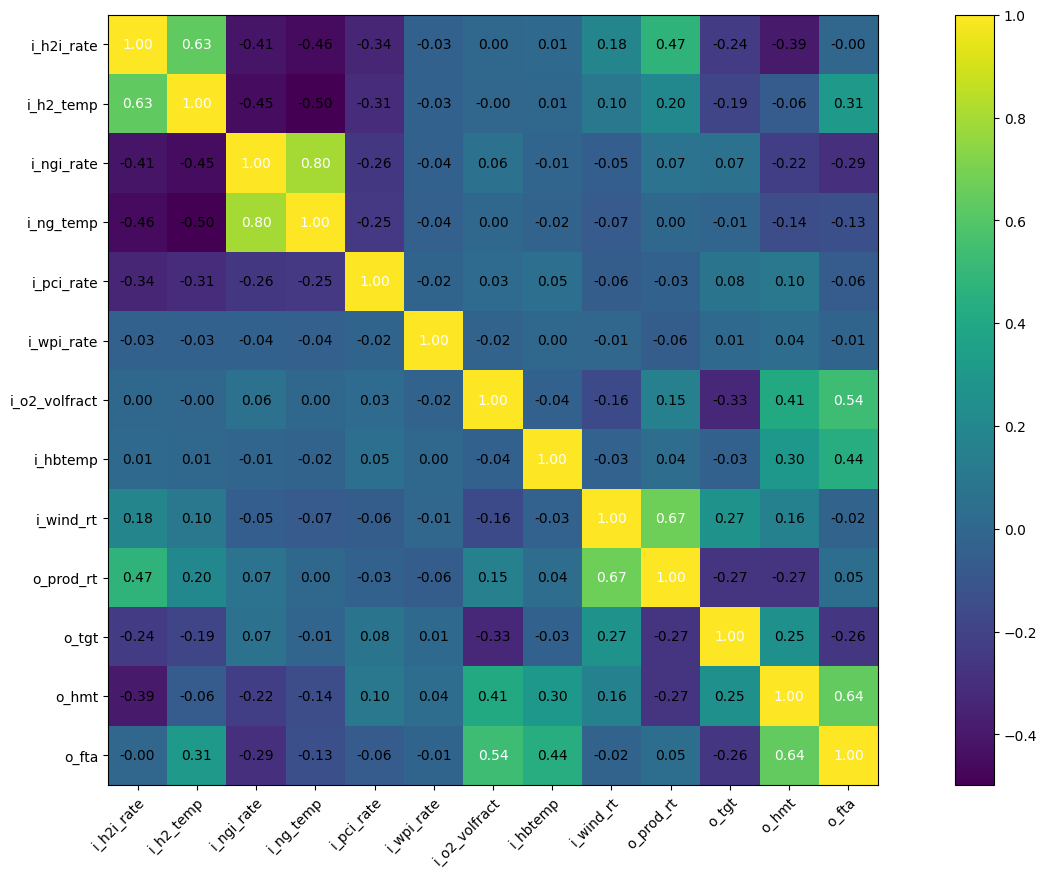

In [12]:

PDFshapingOBJ.list_of_selected_column_names = ['i_h2i_rate','i_h2_temp','i_ngi_rate','i_ng_temp','i_pci_rate',
                    'i_wpi_rate','i_o2_volfract',
                    'i_hbtemp','i_wind_rt','o_prod_rt', 'o_tgt', 'o_hmt','o_fta']



PDFshapingOBJ.print_correlation_coefficients()


In [13]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[1
  'H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HBT-1200_WR-195_MHB-5.7_BM-7_SGI-0_SGT-0_SGC_0 '
  0 ... 63.5 4050.0 1800.0]
 [2
  'H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HBT-1200_WR-195_MHB-5.7_BM-1_SGI-0_SGT-0_SGC_0 '
  0 ... 60.6 4060.0 1850.0]
 [3
  'H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HBT-1200_WR-195_MHB-5.7_BM-5_SGI-0_SGT-0_SGC_0 '
  0 ... 60.8 4080.0 1850.0]
 ...
 [4997
  'H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_HBT-1600_WR-230_MHB-5.7_BM-5_SGI-0_SGT-0_SGC_0 '
  30 ... 57.1 11700.0 2380.0]
 [4998
  'H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_HBT-1480_WR-230_MHB-5.7_BM-3_SGI-0_SGT-0_SGC_0 '
  30 ... 55.7 11800.0 2310.0]
 [4999
  'H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_HBT-1480_WR-230_MHB-5.7_BM-5_SGI-0_SGT-0_SGC_0 '
  30 ... 56.2 11800.0 2310.0]]
(4999, 41)



## Select inputs and outputs


In [14]:


PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs = [ 2, 3, 5, 6, 8, 9, 10 ] , 
                   outputs= [ 27, 29, 40 ]   
)


7
3


In [15]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(4999, 7)
(4999, 3)


In [16]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [17]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(3999, 7)
(1000, 7)
(3999, 3)
(1000, 3)


In [18]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [19]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [20]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


In [21]:

n_inputs  = 7
n_outputs = 3

class ResidualNet(nn.Module):
    def __init__(self, x_means, x_deviations, y_means, y_deviations, dropout_rate=0.1, device='cuda'):
        
        super().__init__()
        self.device = device
        
        self.x_means      = x_means.to(self.device)
        self.x_deviations = x_deviations.to(self.device)
        self.y_means      = y_means.to(self.device)
        self.y_deviations = y_deviations.to(self.device)

     
        self.fc1  = nn.Linear(n_inputs, 64)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(64, 64)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(64, n_outputs)

        # If input_dim ≠ 64, project for residual addition
        self.input_proj = nn.Linear(n_inputs, 64) if n_inputs != 64 else nn.Identity()
        
        # Move model to device
        self.to(self.device)
        

    def forward(self, x):
        x  = x.to(self.device)
        x  = (x - self.x_means) / self.x_deviations
        x0 = self.input_proj(x)
        x1 = self.dropout1(self.act1(self.fc1(x)))
        x2 = self.dropout2(self.act2(self.fc2(x1)))
        x_res = x2 + x0
        y_scaled = self.fc3(x_res)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    
    


In [22]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model     = ResidualNet(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations,
             device=device  # pass device into the model
    
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.MSELoss()




In [23]:

model.train()

for epoch in range(1000):
    for xb, yb in PDFshapingOBJ.train_dl:
        
        xb = xb.to(model.device)
        yb = yb.to(model.device)
        
        optimizer.zero_grad()
        pred_descaled, pred_scaled = model(xb)
        loss = loss_fn(pred_scaled, yb)
        
        loss.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        print(epoch, ".....", loss.item() ) 
    


    

0 ..... 0.38381385803222656
100 ..... 0.19903810322284698
200 ..... 0.5890580415725708
300 ..... 0.11800791323184967
400 ..... 0.2247275412082672
500 ..... 0.2749817669391632
600 ..... 0.12472883611917496
700 ..... 0.1412144899368286
800 ..... 0.20836502313613892
900 ..... 0.21915721893310547


In [24]:

print("=== SANITY CHECK: SCALING ===")
print("y_means:", PDFshapingOBJ.y_means)
print("y_deviations:", PDFshapingOBJ.y_deviations)

print("===============================================")

print("x_means:", PDFshapingOBJ.x_means)
print("x_deviations:", PDFshapingOBJ.x_deviations)



=== SANITY CHECK: SCALING ===
y_means: tensor([[  97.8615, 1301.1132, 2306.8901]])
y_deviations: tensor([[ 50.8433, 524.9791, 212.2382]])
x_means: tensor([[  12.3781,   18.5501,   41.3703,   25.5764,  267.7419, 1440.6222,
          198.5009]])
x_deviations: tensor([[ 15.2460,  45.3423,  46.6256,   3.3265, 359.3944, 157.0635,  26.6274]])



## Constraints Optimization



* desired output requirements
* Raceway flame temp 2600k - 2700K...........(17, 'o_fta')
* Hot metal temp      1800 - 1830K...........(21, 'o_hmt')
* Top gas temp         70 - 80C............(23, 'o_tgt')




In [25]:

print(  PDFshapingOBJ.constraint_weights.shape  )
print(  PDFshapingOBJ.constraint_weights  )


torch.Size([4, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [26]:



PDFshapingOBJ.init_z_constraints()


optimizer_infer = torch.optim.Adam( [ PDFshapingOBJ.z ], lr=0.03)     ## 0.05


scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer_infer, step_size=40000, gamma=0.5
)

print( PDFshapingOBJ.z.shape )   # Should print: torch.Size([32, 7])
print( PDFshapingOBJ.z ) 




torch.Size([4, 7])
Parameter containing:
tensor([[ 0.6675, -0.2259, -0.4060, -0.0482,  0.7818, -0.3410, -0.5417],
        [ 0.3139,  0.0536,  0.3847,  0.0269, -0.8443, -0.7581, -0.3496],
        [ 0.3417,  0.6732,  0.3608, -0.6691,  0.3415,  0.8309,  0.1902],
        [ 0.7444, -0.7363, -0.4897,  0.8220, -0.2877,  0.4528, -0.6581]],
       requires_grad=True)


In [27]:


(lower_bounds_glob,
 upper_bounds_glob,
 lower_bounds_glob_scaled,
 upper_bounds_glob_scaled)  = PDFshapingOBJ.get_upper_lower_bounds_constraints()

print( lower_bounds_glob.shape )
print( upper_bounds_glob.shape )
print( lower_bounds_glob_scaled.shape )
print( upper_bounds_glob_scaled.shape )

print( lower_bounds_glob )
print( upper_bounds_glob )
print( lower_bounds_glob_scaled )
print( upper_bounds_glob_scaled )


torch.Size([4, 3])
torch.Size([4, 3])
torch.Size([4, 3])
torch.Size([4, 3])
tensor([[2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.]])
tensor([[2700., 1830.,   80.],
        [2700., 1830.,   80.],
        [2700., 1830.,   80.],
        [2700., 1830.,   80.]])
tensor([[ 49.2127,   0.9503, -10.5395],
        [ 49.2127,   0.9503, -10.5395],
        [ 49.2127,   0.9503, -10.5395],
        [ 49.2127,   0.9503, -10.5395]])
tensor([[ 51.1795,   1.0074, -10.4924],
        [ 51.1795,   1.0074, -10.4924],
        [ 51.1795,   1.0074, -10.4924],
        [ 51.1795,   1.0074, -10.4924]])


In [28]:


clamp_min, clamp_max = PDFshapingOBJ.get_clamps_min_max_constraints(
    batch_size=PDFshapingOBJ.batch_size_syn, device=PDFshapingOBJ.device
)

print( clamp_min.shape )
print( clamp_max.shape )


for i in range(  clamp_min.shape[0] ):
    print(clamp_min[i] )
    print(clamp_max[i] )  
    print("************")


torch.Size([4, 7])
torch.Size([4, 7])
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.])
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.])
************
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.])
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.])
************
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.])
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.])
************
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.])
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.])
************


In [29]:


def constraint_loss(
    y_pred,               # [B, D]
    weights,              # [B, D]
    lower_bounds_glob,    # [B, D]
    upper_bounds_glob,    # [B, D]
    reg_weight=1e-4
):

    lower_violation = torch.relu(lower_bounds_glob - y_pred)
    upper_violation = torch.relu(y_pred - upper_bounds_glob)
    
    loss = weights * (lower_violation ** 2 + upper_violation ** 2)  # shape [B, D]

    mean_loss_per_output = loss.mean(dim=0)  # shape [D]
    print("Mean loss per output:", mean_loss_per_output.detach().cpu().numpy())

    with torch.no_grad():
        adaptive_weights = mean_loss_per_output / (mean_loss_per_output.sum() + 1e-6)
        adaptive_weights = adaptive_weights.detach()  
        
    center = (lower_bounds_glob + upper_bounds_glob) / 2
    soft_center_loss = ((y_pred - center) ** 2)
    soft_center_loss = (soft_center_loss.mean(dim=0) * adaptive_weights).sum()


    ## total_loss = torch.dot(mean_loss_per_output, adaptive_weights)  
    total_loss = (mean_loss_per_output * adaptive_weights).sum()
    
    alpha      = 0.9 
    total_loss = total_loss + alpha * soft_center_loss


    total_loss = total_loss + reg_weight * torch.mean(y_pred ** 2)

    return total_loss




## Optimization - constraints


In [30]:


alpha  = 0.9 
epochs = 90000


for step in range( epochs ):
    
    x_guess       = PDFshapingOBJ.get_x_from_z( PDFshapingOBJ.z, clamp_min, clamp_max  )  # shape: [32, 7]
    
    y_pred_real, y_pred_scaled = model( x_guess )
    
    
    loss_main = constraint_loss(
        y_pred_scaled,           # [B, D]
        PDFshapingOBJ.constraint_weights,      # [B, D]
        lower_bounds_glob_scaled,       # [B, D]
        upper_bounds_glob_scaled        # [B, D]
    )
    
    loss_soft     = PDFshapingOBJ.soft_box_penalty(x_guess, clamp_min, clamp_max, strength=10.0)
    loss_z_reg    = PDFshapingOBJ.regularize_z(PDFshapingOBJ.z, strength=1e-3)
    
    loss = alpha * loss_main + (1 - alpha) * loss_soft + loss_z_reg
    
    
    optimizer_infer.zero_grad()
    loss.backward()
    optimizer_infer.step()
    scheduler.step()
    

    if step % 10000 == 0:
        lr_current = scheduler.get_last_lr()[0]
        print(f"Step {step} — LR: {lr_current:.5f} — Loss: {loss.item():.6f}")



    if step % 20000 == 0:
        print("====== Checkpoint ======")
        print("Step:", step)
        '''
        print("z:", PDFshapingOBJ.z.detach().cpu())
        print("x_guess:", x_guess.detach().cpu())
        print("target_output_not_scaled:", target_output_not_scaled.cpu())
        print("y_pred_real:", y_pred_real.detach().cpu())
        print("y_pred_scaled:", y_pred_scaled.detach().cpu())
        print("target_output_scaled:", target_output.cpu())
        print("clamp_min:", clamp_min.cpu())
        print("clamp_max:", clamp_max.cpu())
        '''
        print("Total Loss:", loss.item())
        print("=========================")

        
        

Mean loss per output: [2900.8933   181.59566  664.6904 ]
Step 0 — LR: 0.03000 — Loss: 4124.096191
====== Checkpoint ======
Step: 0
Total Loss: 4124.09619140625
Mean loss per output: [2966.0742   140.5347   664.52966]
Mean loss per output: [3011.5168   133.82278  656.8205 ]
Mean loss per output: [2930.3406    117.032166  601.2688  ]
Mean loss per output: [2896.8267   114.57102  603.07104]
Mean loss per output: [2974.029    103.63983  585.73566]
Mean loss per output: [2929.726      88.803535  627.5361  ]
Mean loss per output: [2868.877      90.945366  507.16177 ]
Mean loss per output: [2941.9905    81.53091  614.12787]
Mean loss per output: [2765.385     91.61941  475.9727 ]
Mean loss per output: [2891.3572   68.716   473.3111]
Mean loss per output: [2780.534     67.35462  427.9586 ]
Mean loss per output: [3014.2244     58.751755  503.23044 ]
Mean loss per output: [2699.0034    59.0746   405.91074]
Mean loss per output: [2776.8486     56.930496  400.94525 ]
Mean loss per output: [2789.98

Mean loss per output: [1894.3325     19.60917    41.141132]
Mean loss per output: [1764.8802     23.209734   40.724667]
Mean loss per output: [1894.2511    21.76303   36.80195]
Mean loss per output: [1950.425      22.571575   36.96982 ]
Mean loss per output: [1794.3906    21.97681   40.98237]
Mean loss per output: [1786.7229     21.825178   35.95453 ]
Mean loss per output: [1827.991      24.294592   39.30822 ]
Mean loss per output: [1818.1587     24.44768    36.045517]
Mean loss per output: [1754.379      28.050697   37.315506]
Mean loss per output: [1755.7888     22.736654   37.274807]
Mean loss per output: [1842.4672     26.579807   39.538982]
Mean loss per output: [1878.8694     28.558563   40.763992]
Mean loss per output: [1747.5095     33.653336   38.93915 ]
Mean loss per output: [1712.4641     28.100449   40.526566]
Mean loss per output: [1875.2368     30.89727    36.053505]
Mean loss per output: [1776.0383     25.418083   36.404877]
Mean loss per output: [1798.6453     27.084558

Mean loss per output: [1710.9197     37.807068   19.945587]
Mean loss per output: [1487.2971     31.10702    22.025139]
Mean loss per output: [1470.1324     35.509125   16.929909]
Mean loss per output: [1487.0813     33.987762   82.22129 ]
Mean loss per output: [1509.312      33.202763   15.689959]
Mean loss per output: [1724.5421     31.21224    16.904552]
Mean loss per output: [1592.5559     31.573425   16.089045]
Mean loss per output: [1553.592      31.387867   18.744709]
Mean loss per output: [1528.4249     31.440718   14.574063]
Mean loss per output: [1574.9196     35.85495    14.370005]
Mean loss per output: [1501.536      33.133377   14.644264]
Mean loss per output: [1633.9025     30.0897     13.703267]
Mean loss per output: [1555.1969     35.577866   14.874773]
Mean loss per output: [1618.2885     40.11394    18.771748]
Mean loss per output: [1611.1619     39.878048   19.317574]
Mean loss per output: [1511.6188     34.293114   15.556354]
Mean loss per output: [1448.5557     37.

Mean loss per output: [1514.2725     32.090298   15.727294]
Mean loss per output: [1512.7511     38.242775   12.908257]
Mean loss per output: [1466.0208     33.57748    16.477314]
Mean loss per output: [1417.5394     36.040764   18.05067 ]
Mean loss per output: [1397.8905     36.784058   20.400448]
Mean loss per output: [1358.0575     33.11479    12.003151]
Mean loss per output: [1420.8878     32.910748   15.261681]
Mean loss per output: [1516.5876     27.998114   14.844558]
Mean loss per output: [1570.6875     39.83999    16.363148]
Mean loss per output: [1353.7056     37.370235   17.294418]
Mean loss per output: [1549.2433     31.658873   16.322199]
Mean loss per output: [1375.6333     35.207817   15.13693 ]
Mean loss per output: [1341.1736     36.97297    13.887052]
Mean loss per output: [1556.9171     36.483116   14.240066]
Mean loss per output: [1452.1113     25.663925   14.102701]
Mean loss per output: [1508.3027     31.432878   10.960056]
Mean loss per output: [1555.8535     29.

Mean loss per output: [1547.7424     35.07776    16.760181]
Mean loss per output: [1534.2834      35.866463    14.8770685]
Mean loss per output: [1401.6133     28.207651   13.938502]
Mean loss per output: [1390.568      30.841806   12.870388]
Mean loss per output: [1323.8909     33.345314   12.332447]
Mean loss per output: [1406.8823     34.966244   14.001199]
Mean loss per output: [1522.6554     42.943893   11.540646]
Mean loss per output: [1419.752      33.606697   14.890129]
Mean loss per output: [1627.3151     30.305489   15.095726]
Mean loss per output: [1460.6472     31.348116   14.037752]
Mean loss per output: [1443.746      28.214363   16.310848]
Mean loss per output: [1392.428      35.30263    11.691458]
Mean loss per output: [1584.5964     36.70284    20.970348]
Mean loss per output: [1502.0071     31.82214    17.051224]
Mean loss per output: [1439.0988     36.68603    14.761147]
Mean loss per output: [1340.9237     30.998222   14.491818]
Mean loss per output: [1366.0027     

Mean loss per output: [1580.0442     33.890644   17.577625]
Mean loss per output: [1527.7292     36.73329    15.030144]
Mean loss per output: [1355.9985     35.809666   13.396296]
Mean loss per output: [1509.0862     30.604662   21.049126]
Mean loss per output: [1500.1603     37.275906   15.943593]
Mean loss per output: [1415.3104     34.629314   13.009224]
Mean loss per output: [1450.4362     35.564064   15.844347]
Mean loss per output: [1464.064      38.065186   16.290136]
Mean loss per output: [1319.1831     39.51858    15.661499]
Mean loss per output: [1556.9669     28.321705   13.339663]
Mean loss per output: [1380.1093     35.40628    14.181099]
Mean loss per output: [1567.9283     39.021687   14.273245]
Mean loss per output: [1482.3931     38.448273   15.710872]
Mean loss per output: [1589.7085      42.427677    13.8999195]
Mean loss per output: [1495.6454     35.27577    14.177073]
Mean loss per output: [1417.8241     37.34639    15.797531]
Mean loss per output: [1557.0087     

Mean loss per output: [1465.1533    37.81222   13.73331]
Mean loss per output: [1394.0168     36.96544    14.132571]
Mean loss per output: [1502.2953     31.60125    15.284501]
Mean loss per output: [1542.046      30.306923   18.26019 ]
Mean loss per output: [1495.61       32.32365    14.371339]
Mean loss per output: [1555.0536     33.89592    13.473931]
Mean loss per output: [1464.4202     31.041695   13.888857]
Mean loss per output: [1566.4131      41.54358     14.2577505]
Mean loss per output: [1443.0685     32.397717   14.465555]
Mean loss per output: [1401.6787     37.809994   17.671104]
Mean loss per output: [1441.7067      31.652613    15.9810915]
Mean loss per output: [1531.7124     27.250246   13.161087]
Mean loss per output: [1517.9089     41.263733   17.592617]
Mean loss per output: [1464.0204     31.620838   14.421524]
Mean loss per output: [1348.4147     34.41537    12.049637]
Mean loss per output: [1470.4053     38.380928   12.598652]
Mean loss per output: [1593.4657     

Mean loss per output: [1517.4985     33.7631     14.366314]
Mean loss per output: [1389.037      29.72462    12.487933]
Mean loss per output: [1442.6603     34.394318   13.830279]
Mean loss per output: [1504.3171     34.328907   13.459978]
Mean loss per output: [1493.2361     31.656158   16.580881]
Mean loss per output: [1347.8115    35.04486   20.34664]
Mean loss per output: [1522.3633     26.352297   18.83553 ]
Mean loss per output: [1514.6204     32.7782     12.584978]
Mean loss per output: [1432.9175     28.510452   11.887599]
Mean loss per output: [1584.4138     40.46213    22.210964]
Mean loss per output: [1463.2266     38.70385    13.209466]
Mean loss per output: [1434.7753     32.528572   14.421931]
Mean loss per output: [1410.5438     35.906437   16.620996]
Mean loss per output: [1550.9878     37.49999    14.994631]
Mean loss per output: [1393.4949     31.788424   13.803755]
Mean loss per output: [1407.8021     31.646532   15.49995 ]
Mean loss per output: [1409.8625     33.988

Mean loss per output: [1310.4202     42.993664   13.185407]
Mean loss per output: [1358.0964     32.919548   14.510303]
Mean loss per output: [1465.6732     33.987766   13.79972 ]
Mean loss per output: [1476.413      42.379246   12.737026]
Mean loss per output: [1466.5183     36.487766   13.201557]
Mean loss per output: [1472.4508     35.19327    15.589678]
Mean loss per output: [1517.0756     37.565365   16.601393]
Mean loss per output: [1446.6797     34.99112    15.868807]
Mean loss per output: [1492.7909    33.797     16.24113]
Mean loss per output: [1549.1074     35.32607    13.231557]
Mean loss per output: [1423.4703     31.006224   17.437475]
Mean loss per output: [1466.1074     32.473602   18.314056]
Mean loss per output: [1346.2563     37.27433    18.569366]
Mean loss per output: [1386.7876     28.509243   14.983383]
Mean loss per output: [1530.0443     32.72923    16.117231]
Mean loss per output: [1524.7844     31.904911   14.436878]
Mean loss per output: [1587.439     28.7676

Mean loss per output: [1481.602      32.92416    14.681002]
Mean loss per output: [1629.2576     32.36558    15.116348]
Mean loss per output: [1484.6863     34.12001    15.061446]
Mean loss per output: [1449.502      35.537346   11.553304]
Mean loss per output: [1411.3911     35.595078   13.896332]
Mean loss per output: [1540.8115     32.914997   19.275848]
Mean loss per output: [1477.1777     33.60062    13.793873]
Mean loss per output: [1353.7732     31.946777   14.678041]
Mean loss per output: [1511.3168     32.44569    14.798651]
Mean loss per output: [1469.4061     33.201687   14.954001]
Mean loss per output: [1506.064      31.409306   18.080048]
Mean loss per output: [1367.9723     32.956833   17.529797]
Mean loss per output: [1423.6033     38.811615   15.660612]
Mean loss per output: [1518.2756     31.497581   16.800005]
Mean loss per output: [1504.9507     35.657146   13.600956]
Mean loss per output: [1557.6047     31.366728   15.631546]
Mean loss per output: [1519.1516     35.

Mean loss per output: [1465.9255     34.423203   16.597107]
Mean loss per output: [1356.6638     35.398342   15.617952]
Mean loss per output: [1632.0659     38.999634   22.48481 ]
Mean loss per output: [1474.3916     40.21441    16.651142]
Mean loss per output: [1439.534      36.825455   13.846601]
Mean loss per output: [1589.9839     36.083817   14.269284]
Mean loss per output: [1504.0184    33.58579   16.08316]
Mean loss per output: [1384.3246     30.826458   12.813971]
Mean loss per output: [1473.3768     34.51676    16.073584]
Mean loss per output: [1378.4758     35.84116    13.614176]
Mean loss per output: [1488.6227    32.0555    12.81752]
Mean loss per output: [1462.3787    32.76187   18.64247]
Mean loss per output: [1575.2664     33.102943   14.619792]
Mean loss per output: [1490.4421     29.925148   12.623327]
Mean loss per output: [1731.6049     41.154984   14.105995]
Mean loss per output: [1453.6471     36.081837   11.522003]
Mean loss per output: [1686.4731     29.557459   

Mean loss per output: [1651.2314     41.65244    13.440969]
Mean loss per output: [1425.6086     34.090183   15.028114]
Mean loss per output: [1341.4885     34.64112    13.872101]
Mean loss per output: [1545.8362     29.369522   14.036537]
Mean loss per output: [1610.0028     22.999176   13.113399]
Mean loss per output: [1522.3328     33.51942    15.412513]
Mean loss per output: [1475.9028     43.226433   15.372583]
Mean loss per output: [1560.2317     38.697083   12.791222]
Mean loss per output: [1472.2937     39.42528    15.859359]
Mean loss per output: [1382.1321     37.2109     13.951229]
Mean loss per output: [1521.3318     35.1857     14.531652]
Mean loss per output: [1403.5404     37.033043   15.785265]
Mean loss per output: [1448.018      31.515438   14.140589]
Mean loss per output: [1508.6335     41.353405   12.948599]
Mean loss per output: [1463.0496     34.748055   21.992764]
Mean loss per output: [1438.1865     28.352924   15.219323]
Mean loss per output: [1492.5234     47.

Mean loss per output: [1352.3176     36.758354   14.474987]
Mean loss per output: [1426.0396     37.29554    13.330246]
Mean loss per output: [1480.324      34.028034   14.498074]
Mean loss per output: [1432.4783     34.019054   13.878723]
Mean loss per output: [1474.2236     36.61924    14.653624]
Mean loss per output: [1488.875       28.7562      12.5708065]
Mean loss per output: [1501.3518     31.706665   12.887086]
Mean loss per output: [1345.1553     33.888634   13.77964 ]
Mean loss per output: [1380.58       31.717497   17.309027]
Mean loss per output: [1467.7131     28.757463   14.22369 ]
Mean loss per output: [1379.6565     38.109795   17.262074]
Mean loss per output: [1658.2836     31.899256   11.095401]
Mean loss per output: [1601.819      32.11137    12.289099]
Mean loss per output: [1374.4565     35.28236    17.685167]
Mean loss per output: [1333.1056     31.197271   15.11395 ]
Mean loss per output: [1400.7896     41.35928    14.305519]
Mean loss per output: [1425.0215     

Mean loss per output: [1456.6151     33.421577   16.546932]
Mean loss per output: [1443.3654     29.474451   16.907932]
Mean loss per output: [1625.6262    33.36931   17.74685]
Mean loss per output: [1525.8136     35.531174   17.448408]
Mean loss per output: [1445.7991     33.770084   12.724021]
Mean loss per output: [1573.2937     35.67732    17.589355]
Mean loss per output: [1489.4993     36.22953    13.335502]
Mean loss per output: [1251.8868     36.58489    15.152663]
Mean loss per output: [1442.1467     33.048767   13.989729]
Mean loss per output: [1548.6819     35.869278   13.371363]
Mean loss per output: [1373.7714     31.092085   14.498432]
Mean loss per output: [1526.3971     32.64178    15.310796]
Mean loss per output: [1541.6754    35.20374   17.78251]
Mean loss per output: [1683.5127    29.63691   13.67695]
Mean loss per output: [1479.5127     35.800785   13.186613]
Mean loss per output: [1336.6062    39.08776   13.43322]
Mean loss per output: [1402.9294     34.216095   12.

Mean loss per output: [1508.6832     39.66036    12.573183]
Mean loss per output: [1496.9911     36.48467    13.471424]
Mean loss per output: [1532.6655     37.998707   17.9958  ]
Mean loss per output: [1507.4536      25.903912    13.8071785]
Mean loss per output: [1512.3273     37.94072    14.294351]
Mean loss per output: [1542.8014     34.721443   16.98842 ]
Mean loss per output: [1483.3105     33.808537   13.059614]
Mean loss per output: [1471.3429     32.931347   11.710476]
Mean loss per output: [1561.9773     31.550928   14.783936]
Mean loss per output: [1445.4022     31.310043   15.064861]
Mean loss per output: [1448.1538     33.38832    19.133175]
Mean loss per output: [1389.237      34.35064    14.001669]
Mean loss per output: [1398.3888      38.606567    13.8161955]
Mean loss per output: [1535.9476     31.551857    9.702689]
Mean loss per output: [1578.7551     35.440445   17.273613]
Mean loss per output: [1614.466      35.087067   11.571516]
Mean loss per output: [1462.7026  

Mean loss per output: [1424.9924     36.15856    11.487016]
Mean loss per output: [1568.2539     31.752197   15.8919  ]
Mean loss per output: [1554.9015     30.410822   15.20745 ]
Mean loss per output: [1439.251      30.048903   16.783422]
Mean loss per output: [1461.729      31.245235   20.942451]
Mean loss per output: [1339.2239      33.62436     15.6222725]
Mean loss per output: [1392.3346     30.768078   13.696499]
Mean loss per output: [1345.4409     37.247604   17.382923]
Mean loss per output: [1402.4463     35.447727   15.120941]
Mean loss per output: [1456.5793     33.11469    15.864854]
Mean loss per output: [1442.617      38.869118   17.030735]
Mean loss per output: [1460.769      37.450268   16.391922]
Mean loss per output: [1479.1494     32.203117   14.381894]
Mean loss per output: [1472.5496     34.30301    15.740532]
Mean loss per output: [1524.3687     31.862747   11.898661]
Mean loss per output: [1498.6531     39.24785    13.431527]
Mean loss per output: [1533.8254     

Mean loss per output: [1460.1035     32.121803   13.971955]
Mean loss per output: [1490.9585     32.568066   14.477095]
Mean loss per output: [1492.0446     27.264887   13.938527]
Mean loss per output: [1511.472      38.627613   13.937912]
Mean loss per output: [1593.4412     31.659445   18.351349]
Mean loss per output: [1535.1449     31.065348   14.064309]
Mean loss per output: [1394.3984     30.22144    14.557003]
Mean loss per output: [1397.1667     34.265934   14.14119 ]
Mean loss per output: [1681.6389     33.0617     14.235736]
Mean loss per output: [1304.3607     31.791897   15.662336]
Mean loss per output: [1436.0099     32.73796    12.601207]
Mean loss per output: [1633.7263     30.19496    17.777464]
Mean loss per output: [1511.8091     32.108013   17.22817 ]
Mean loss per output: [1381.7446     33.477978   13.827484]
Mean loss per output: [1507.4767     31.643343   19.798073]
Mean loss per output: [1451.353       31.081331    12.9687395]
Mean loss per output: [1483.0388     

Mean loss per output: [1468.7887     38.56719    11.140615]
Mean loss per output: [1551.9254     35.024628   14.344929]
Mean loss per output: [1382.6683     36.903786   18.120838]
Mean loss per output: [1493.692      43.60581    13.027187]
Mean loss per output: [1525.5281     35.8309     13.933344]
Mean loss per output: [1524.3635     30.167515   14.335236]
Mean loss per output: [1289.0474     40.132366   15.192064]
Mean loss per output: [1581.3613     36.3155     23.036922]
Mean loss per output: [1275.6045     37.68191    13.597021]
Mean loss per output: [1423.9873     32.91991    11.691256]
Mean loss per output: [1473.1945     36.053257   13.287556]
Mean loss per output: [1427.0334     37.973053   15.990272]
Mean loss per output: [1469.6599     40.506916   10.681323]
Mean loss per output: [1396.2448    38.24362   13.40267]
Mean loss per output: [1402.4829     35.444733   13.134874]
Mean loss per output: [1604.5461    34.27658   19.42517]
Mean loss per output: [1526.02       30.64317 

Mean loss per output: [1431.3442     35.64309    15.204807]
Mean loss per output: [1443.2451     27.349892   12.566069]
Mean loss per output: [1431.5647     36.3469     12.838234]
Mean loss per output: [1558.2427     30.702585   15.103949]
Mean loss per output: [1589.9761     30.62275    15.329847]
Mean loss per output: [1366.3226     40.384586   16.185574]
Mean loss per output: [1486.6462     36.842567   13.717329]
Mean loss per output: [1484.4717     29.890041   16.54768 ]
Mean loss per output: [1461.7721     32.834293   17.495367]
Mean loss per output: [1462.6227     37.33257    18.830198]
Mean loss per output: [1500.7015     34.484863   13.23555 ]
Mean loss per output: [1411.7432     37.9251     13.037919]
Mean loss per output: [1288.0785     39.858448   16.113338]
Mean loss per output: [1374.3955     33.42644    11.121757]
Mean loss per output: [1400.738      37.139774   13.45334 ]
Mean loss per output: [1618.8864      31.293182    14.5955715]
Mean loss per output: [1480.2106     

Mean loss per output: [1454.0852      27.785875    13.5482435]
Mean loss per output: [1511.8353     29.568787   12.234346]
Mean loss per output: [1574.4192     32.41491    13.853482]
Mean loss per output: [1349.2847     38.224117   12.461332]
Mean loss per output: [1460.3147     36.52616    13.301197]
Mean loss per output: [1372.6797     33.49978    14.889128]
Mean loss per output: [1599.174      33.54032    14.445952]
Mean loss per output: [1503.1055     28.527565   14.273829]
Mean loss per output: [1606.8041     27.485022   10.987543]
Mean loss per output: [1664.3694     37.80559    13.715143]
Mean loss per output: [1466.8115     34.069317   14.576383]
Mean loss per output: [1398.3535     36.03576    13.735732]
Mean loss per output: [1438.8076     30.036612   22.136646]
Mean loss per output: [1448.549      30.82731    14.246792]
Mean loss per output: [1487.1104     32.438087   17.107674]
Mean loss per output: [1347.8469     33.948975   15.964493]
Mean loss per output: [1597.6177     

Mean loss per output: [1409.5886     26.881054   14.630414]
Mean loss per output: [1582.1443     37.33827    40.574486]
Mean loss per output: [1421.5269     32.677155   18.244188]
Mean loss per output: [1484.9409     32.42429    14.392422]
Mean loss per output: [1433.4408      29.64197     15.2637005]
Mean loss per output: [1505.3229     33.903023   14.887112]
Mean loss per output: [1349.7554     38.2985     17.506088]
Mean loss per output: [1419.2115     32.66999    16.123697]
Mean loss per output: [1412.538      32.017212   16.238237]
Mean loss per output: [1497.722      31.094679   17.411638]
Mean loss per output: [1467.465      37.225815   15.182951]
Mean loss per output: [1417.7467     37.861954    9.482098]
Mean loss per output: [1443.7133     29.408298   13.675846]
Mean loss per output: [1590.9673     31.575224   13.827097]
Mean loss per output: [1722.9805     30.385048   12.512272]
Mean loss per output: [1511.3273     35.373127   16.130264]
Mean loss per output: [1377.2743    3

Mean loss per output: [1732.5499     36.795776   17.484127]
Mean loss per output: [1441.7548     31.89103    15.201773]
Mean loss per output: [1407.4065     34.954857   14.697651]
Mean loss per output: [1487.6683     35.389313   13.184273]
Mean loss per output: [1394.7708     27.09526    17.356857]
Mean loss per output: [1493.6294     29.413172   13.951422]
Mean loss per output: [1394.2794    31.614     17.81197]
Mean loss per output: [1590.7917     30.38796    29.167242]
Mean loss per output: [1476.8756     36.07358    13.500328]
Mean loss per output: [1508.7156     35.906666   18.003227]
Mean loss per output: [1562.554      31.109411   17.886147]
Mean loss per output: [1436.0952      39.24734     13.5978565]
Mean loss per output: [1430.9934     34.64098    17.077946]
Mean loss per output: [1380.7062     31.29348    13.026165]
Mean loss per output: [1419.7373     34.872257   15.027234]
Mean loss per output: [1389.692      37.82109    14.169203]
Mean loss per output: [1506.4019     31.

Mean loss per output: [1506.6888     34.223698   16.285454]
Mean loss per output: [1517.2747     34.561516   16.977438]
Mean loss per output: [1544.5972     26.91946    14.200131]
Mean loss per output: [1455.3638     39.116028   12.178306]
Mean loss per output: [1583.9615     37.71443    12.195825]
Mean loss per output: [1401.4778     34.636837   14.30293 ]
Mean loss per output: [1520.6747     32.809093   41.41209 ]
Mean loss per output: [1410.9861     34.226727   15.52968 ]
Mean loss per output: [1499.6533      34.32241     13.8126745]
Mean loss per output: [1440.5498     41.692      13.821905]
Mean loss per output: [1533.3306     32.644207   17.935907]
Mean loss per output: [1479.3754     35.564205   13.474796]
Mean loss per output: [1409.7687     37.64613    12.646915]
Mean loss per output: [1558.3226     31.536129   12.342665]
Mean loss per output: [1513.3164     33.86752    11.983854]
Mean loss per output: [1435.5665     31.7637     14.841379]
Mean loss per output: [1573.2062     

Mean loss per output: [1683.866      36.625626   16.255054]
Mean loss per output: [1545.5684     39.328815   17.62178 ]
Mean loss per output: [1534.8105     37.599155   15.078408]
Mean loss per output: [1389.8508     33.93855    15.180278]
Mean loss per output: [1393.8115     37.062447   13.786239]
Mean loss per output: [1409.4996     39.291866   16.275684]
Mean loss per output: [1395.5905     33.523895   14.552518]
Mean loss per output: [1434.54       33.00867    17.198643]
Mean loss per output: [1438.4742     42.17885    15.421137]
Mean loss per output: [1426.7926     32.31244    16.600208]
Mean loss per output: [1492.5658     37.990295   14.568784]
Mean loss per output: [1432.5718     34.20987    14.531468]
Mean loss per output: [1494.0176     32.32001    15.791437]
Mean loss per output: [1356.7913     34.274185   15.238223]
Mean loss per output: [1546.6094     33.17273    14.313548]
Mean loss per output: [1510.9894    32.49099   16.58509]
Mean loss per output: [1403.7521     38.613

Mean loss per output: [1449.7043    37.35457   14.94018]
Mean loss per output: [1388.8267     36.972935   16.448698]
Mean loss per output: [1433.5533     30.01518    15.340178]
Mean loss per output: [1495.6403     29.68141    15.158293]
Mean loss per output: [1470.3566     37.377262   16.670418]
Mean loss per output: [1496.3932     30.841173   13.161591]
Mean loss per output: [1367.8944     29.494118   12.500786]
Mean loss per output: [1544.8142     26.587814   15.329783]
Mean loss per output: [1497.2976    36.22019   13.97718]
Mean loss per output: [1473.206      34.506706   13.19685 ]
Mean loss per output: [1501.7717     36.109642   15.542485]
Mean loss per output: [1490.9067     36.773182   13.997738]
Mean loss per output: [1431.4242      39.36041     13.3743725]
Mean loss per output: [1534.0023     35.188633   12.244112]
Mean loss per output: [1616.2429     27.399006   91.954865]
Mean loss per output: [1375.6787     36.401123   15.282297]
Mean loss per output: [1630.376      33.672

Mean loss per output: [1529.4646     29.925716   12.525391]
Mean loss per output: [1479.7395     31.858667   14.557655]
Mean loss per output: [1437.4807      36.10197     12.2968235]
Mean loss per output: [1572.7235     35.162285   14.450917]
Mean loss per output: [1327.0474     39.925327   13.869072]
Mean loss per output: [1492.0754     41.284996   16.64507 ]
Mean loss per output: [1493.2888     39.87907    17.953646]
Mean loss per output: [1562.8143     41.681435   12.09277 ]
Mean loss per output: [1414.7192     33.90794    13.191769]
Mean loss per output: [1462.7292     33.200146   19.226582]
Mean loss per output: [1470.1327     31.766567   16.609398]
Mean loss per output: [1469.5308     32.863514   11.239519]
Mean loss per output: [1409.1797     42.03709    13.716724]
Mean loss per output: [1583.9874     35.958527   12.735165]
Mean loss per output: [1430.8856     33.97588    15.290704]
Mean loss per output: [1517.0249     35.106842   12.848844]
Mean loss per output: [1420.0317     

Mean loss per output: [1676.0759      26.410982    10.5820465]
Mean loss per output: [1464.4431     33.151325   18.17513 ]
Mean loss per output: [1469.036      29.143766   19.057446]
Mean loss per output: [1384.5414     37.91544    15.250041]
Mean loss per output: [1413.5271     30.510237   13.990009]
Mean loss per output: [1440.4929     32.48977    15.052196]
Mean loss per output: [1366.1603     34.566776   14.457644]
Mean loss per output: [1356.0017     37.2977     13.677441]
Mean loss per output: [1490.5095     37.30996    15.521093]
Mean loss per output: [1468.7911     45.12826    12.941585]
Mean loss per output: [1541.523      38.200268   14.674318]
Mean loss per output: [1327.0807     37.30862    15.278495]
Mean loss per output: [1345.8055     33.324352   12.559437]
Mean loss per output: [1398.6473     37.226845   14.415457]
Mean loss per output: [1427.5785     35.661808   10.151964]
Mean loss per output: [1505.316      31.846203   11.905136]
Mean loss per output: [1604.3645     

Mean loss per output: [1624.6768     32.01415    12.767645]
Mean loss per output: [1492.133      40.31041    18.923203]
Mean loss per output: [1452.778      42.359104   14.938783]
Mean loss per output: [1352.177      35.851112   13.228749]
Mean loss per output: [1383.2703     33.05487    13.900492]
Mean loss per output: [1487.8618     35.126053   12.764805]
Mean loss per output: [1370.1788     36.308273   16.221336]
Mean loss per output: [1593.705       36.27255     11.2833805]
Mean loss per output: [1440.6211     33.59608    18.002163]
Mean loss per output: [1573.8291     40.53387    11.780579]
Mean loss per output: [1458.0642     28.243097   13.380049]
Mean loss per output: [1443.8395     31.779652   14.952219]
Mean loss per output: [1391.3776     37.08188    13.370195]
Mean loss per output: [1501.5212     28.598341   14.581827]
Mean loss per output: [1626.3241    36.71613   15.6801 ]
Mean loss per output: [1423.549      35.01407    13.020711]
Mean loss per output: [1423.6273     34.

Mean loss per output: [1553.8784     38.15735    11.664954]
Mean loss per output: [1332.2029     35.256535   14.085518]
Mean loss per output: [1508.1544    39.98282   16.33281]
Mean loss per output: [1429.6196     33.52713    13.892233]
Mean loss per output: [1625.352      38.22481    16.749815]
Mean loss per output: [1585.1082     37.576687   14.878647]
Mean loss per output: [1435.1741     38.794735   10.146887]
Mean loss per output: [1439.5055     40.847065   14.976131]
Mean loss per output: [1341.1996      35.845985    15.1123085]
Mean loss per output: [1368.0262     32.626762   12.678954]
Mean loss per output: [1431.1006     38.642704   12.464413]
Mean loss per output: [1417.5259     35.19205    12.719088]
Mean loss per output: [1351.9797     34.471615   12.303892]
Mean loss per output: [1527.8726    37.70807   17.43345]
Mean loss per output: [1622.5304     37.13781    14.321311]
Mean loss per output: [1575.3076     31.775772   14.112339]
Mean loss per output: [1478.4302     27.690

Mean loss per output: [1414.2329     36.775814   13.7919  ]
Mean loss per output: [1470.9209     35.144726   46.479416]
Mean loss per output: [1457.8972     37.243916   14.066247]
Mean loss per output: [1350.2706     37.067913   14.410126]
Mean loss per output: [1499.261      35.256554   14.414781]
Mean loss per output: [1333.1826     32.704838   16.534304]
Mean loss per output: [1568.6511     34.12985    13.214697]
Mean loss per output: [1401.4316     38.32982    11.665428]
Mean loss per output: [1468.3608     31.405516   13.327715]
Mean loss per output: [1351.9735     37.37066    15.057362]
Mean loss per output: [1557.9368     32.691437   17.130093]
Mean loss per output: [1489.1558     39.088657   14.570573]
Mean loss per output: [1380.8833     30.803978   13.566786]
Mean loss per output: [1495.2161     31.765774   15.311672]
Mean loss per output: [1453.1561     29.776976   16.008211]
Mean loss per output: [1433.0743     30.384136   17.411589]
Mean loss per output: [1508.5652     32.

Mean loss per output: [1310.1311     32.77752    12.262089]
Mean loss per output: [1405.1892     29.530315   13.341217]
Mean loss per output: [1576.856      34.824768   13.526574]
Mean loss per output: [1536.5835     40.177372   15.594467]
Mean loss per output: [1454.1425     36.515327   18.390205]
Mean loss per output: [1389.2473     40.73458    17.022293]
Mean loss per output: [1709.8414     35.906246   19.076046]
Mean loss per output: [1579.6002     35.044117   18.314655]
Mean loss per output: [1499.5953     36.63219    15.240644]
Mean loss per output: [1502.6353    40.39529   16.10669]
Mean loss per output: [1416.9081     35.471306   14.695776]
Mean loss per output: [1626.4822     35.674683   12.957574]
Mean loss per output: [1372.545      38.67489    16.579075]
Mean loss per output: [1339.3195     36.875557   14.882284]
Mean loss per output: [1513.2461     32.921486   10.546408]
Mean loss per output: [1368.7855     34.71986    13.912041]
Mean loss per output: [1408.7402     27.464

Mean loss per output: [1542.4485    30.89993   14.11274]
Mean loss per output: [1503.3655     36.141106   14.604015]
Mean loss per output: [1457.4567     38.608208   15.276827]
Mean loss per output: [1405.2646     37.05926    14.903369]
Mean loss per output: [1410.6315     34.89276    15.810734]
Mean loss per output: [1486.2947     36.62858    17.753216]
Mean loss per output: [1545.065      29.384672   13.653328]
Mean loss per output: [1452.4414     32.234016   14.219288]
Mean loss per output: [1379.4982     29.403372   13.367056]
Mean loss per output: [1425.1304     39.073917   12.257932]
Mean loss per output: [1418.7869     33.51388    14.701932]
Mean loss per output: [1437.5704     31.329752   17.072792]
Mean loss per output: [1561.0878     33.667175   19.3615  ]
Mean loss per output: [1302.0687     33.924458   19.178661]
Mean loss per output: [1571.7761     31.826115   11.260447]
Mean loss per output: [1408.2466     33.720867   14.218885]
Mean loss per output: [1592.2605    33.9193

Mean loss per output: [1397.2725     32.925354   15.691565]
Mean loss per output: [1567.8345     36.08221    14.416531]
Mean loss per output: [1463.3555     39.851948   12.317045]
Mean loss per output: [1483.9957     33.950657   14.708266]
Mean loss per output: [1374.3853     37.88931    14.009399]
Mean loss per output: [1367.0674     33.313404   11.757207]
Mean loss per output: [1506.8383     38.754322   14.676905]
Mean loss per output: [1418.997      34.25095    14.480863]
Mean loss per output: [1510.5061     30.446741   11.94068 ]
Mean loss per output: [1443.2683     29.972944   14.241369]
Mean loss per output: [1379.953      32.96991    14.981594]
Mean loss per output: [1474.8492     34.86119    14.878073]
Mean loss per output: [1530.5568     32.0639     14.030676]
Mean loss per output: [1404.6766     32.25629     8.755737]
Mean loss per output: [1481.759      37.18834    21.403017]
Mean loss per output: [1456.8708     31.902933   16.39685 ]
Mean loss per output: [1484.4792     32.

Mean loss per output: [1491.4236     26.179976   17.418028]
Mean loss per output: [1479.2393     27.71458    18.002924]
Mean loss per output: [1552.1376      33.495667    13.0672245]
Mean loss per output: [1403.9546     31.749517   13.564808]
Mean loss per output: [1494.3131     32.484314   15.620014]
Mean loss per output: [1512.1936     28.741581   12.598411]
Mean loss per output: [1484.1418     30.930445   14.53769 ]
Mean loss per output: [1456.4868     38.30855    13.715101]
Mean loss per output: [1482.9978     37.00665    14.791959]
Mean loss per output: [1471.332      35.04422    15.029318]
Mean loss per output: [1453.0614     30.445839   11.960249]
Mean loss per output: [1455.3989     31.107702   12.871298]
Mean loss per output: [1408.726      34.673622   16.5608  ]
Mean loss per output: [1571.6327     34.3277     20.710752]
Mean loss per output: [1517.447      32.235054   14.663545]
Mean loss per output: [1568.926      31.580729   20.247494]
Mean loss per output: [1452.1327     

Mean loss per output: [1441.157      36.4133     12.882157]
Mean loss per output: [1631.4053     30.181005   15.533637]
Mean loss per output: [1568.7349     33.67047    11.503586]
Mean loss per output: [1399.3904     37.036205   16.697262]
Mean loss per output: [1469.2859     31.22719    12.626513]
Mean loss per output: [1467.4094     38.715584   16.335506]
Mean loss per output: [1407.2673    35.25083   18.47364]
Mean loss per output: [1528.3492     37.449654   15.314591]
Mean loss per output: [1388.8357     36.415775   13.725418]
Mean loss per output: [1540.0045     42.312477   22.25222 ]
Mean loss per output: [1384.922      39.40939    14.301862]
Mean loss per output: [1486.8984     33.87371    13.489914]
Mean loss per output: [1466.2983     32.451836   12.976879]
Mean loss per output: [1247.4867     34.951267   10.887883]
Mean loss per output: [1514.6416      37.723003    15.6807575]
Mean loss per output: [1431.405      35.42741    12.760081]
Mean loss per output: [1369.2771     33.

Mean loss per output: [1413.6978      36.06784     13.0504055]
Mean loss per output: [1538.9673     32.51415    18.137175]
Mean loss per output: [1479.4893     34.997826   17.119038]
Mean loss per output: [1520.4905     34.540157   13.254932]
Mean loss per output: [1623.9834     30.772984   14.261241]
Mean loss per output: [1392.481      36.291817   13.331333]
Mean loss per output: [1520.2336     30.68553    13.969076]
Mean loss per output: [1530.0563     35.03698    16.643055]
Mean loss per output: [1447.6571     44.41788    10.740324]
Mean loss per output: [1472.3636     37.49836    15.669287]
Mean loss per output: [1454.2574     34.28074    13.953461]
Mean loss per output: [1553.9519     31.894728   12.508531]
Mean loss per output: [1457.4186     40.74668    14.345414]
Mean loss per output: [1428.3103     34.858166   15.179933]
Mean loss per output: [1516.4553     37.607613   16.222214]
Mean loss per output: [1508.5052     34.139626   14.492476]
Mean loss per output: [1332.5641    3

Mean loss per output: [1550.5454     39.740833   11.12338 ]
Mean loss per output: [1519.3035     35.355106   19.975677]
Mean loss per output: [1533.344      38.03795    14.877018]
Mean loss per output: [1549.3864     26.46639    12.773388]
Mean loss per output: [1567.7963     29.717302   14.929155]
Mean loss per output: [1383.6896     33.74539    12.808723]
Mean loss per output: [1485.6562     35.144287   15.847126]
Mean loss per output: [1671.6062     38.511204   12.213772]
Mean loss per output: [1558.4966     35.118584   14.265303]
Mean loss per output: [1629.5645     34.02155    15.108992]
Mean loss per output: [1577.5319     40.1981     13.574638]
Mean loss per output: [1478.0398     44.93462    13.890966]
Mean loss per output: [1504.021      30.358326   12.998587]
Mean loss per output: [1431.02       35.176346   16.458473]
Mean loss per output: [1443.6392     36.83487    14.757847]
Mean loss per output: [1520.0981     31.821615   18.522825]
Mean loss per output: [1443.8188     41.

Mean loss per output: [1423.4026     32.544655   13.606557]
Mean loss per output: [1384.0216     37.339954   12.294237]
Mean loss per output: [1431.4098     35.42868    19.263386]
Mean loss per output: [1610.2314     34.97107    13.723845]
Mean loss per output: [1562.013      35.496502   14.981972]
Mean loss per output: [1631.0859     34.513035   15.809753]
Mean loss per output: [1470.1003     30.073414   17.255943]
Mean loss per output: [1513.3634     35.86461    14.960203]
Mean loss per output: [1511.468      34.789738   12.913246]
Mean loss per output: [1542.0984     32.113964   14.598169]
Mean loss per output: [1495.0408     30.22127    15.635952]
Mean loss per output: [1539.716      34.645805   14.887053]
Mean loss per output: [1547.3243     34.971764   15.884669]
Mean loss per output: [1705.3419     27.70637    12.750784]
Mean loss per output: [1514.4043     31.63456    11.282726]
Mean loss per output: [1585.1104      30.943144    11.1412525]
Mean loss per output: [1525.7125     

Mean loss per output: [1516.9883     35.52029    15.595988]
Mean loss per output: [1423.527      38.781067   14.333851]
Mean loss per output: [1499.6653     37.68691    18.142075]
Mean loss per output: [1388.4833     37.619953   18.714527]
Mean loss per output: [1464.1699     35.75432    12.942467]
Mean loss per output: [1459.5558      34.004276    12.9763775]
Mean loss per output: [1260.4993     34.984226   13.432793]
Mean loss per output: [1358.0519     35.642487   14.879517]
Mean loss per output: [1447.0559     36.77501    15.904901]
Mean loss per output: [1451.6562      26.552755    13.9315605]
Mean loss per output: [1392.3396     32.828793   13.881874]
Mean loss per output: [1513.5961    37.69341  155.20839]
Mean loss per output: [1558.3342     33.919697   14.458372]
Mean loss per output: [1398.4628     35.71342    15.693856]
Mean loss per output: [1365.4987     33.959126   14.972128]
Mean loss per output: [1434.3739     40.086227   12.739565]
Mean loss per output: [1481.5204     

Mean loss per output: [1463.2656     33.0826     14.654564]
Mean loss per output: [1459.2894     33.091953   12.705338]
Mean loss per output: [1380.4825     36.155075   14.371391]
Mean loss per output: [1412.9028     37.72933    15.680605]
Mean loss per output: [1438.948      33.18737    14.412224]
Mean loss per output: [1483.4573     32.596375   12.565988]
Mean loss per output: [1596.5248     35.310787   14.855688]
Mean loss per output: [1420.0417     36.889122   11.99305 ]
Mean loss per output: [1430.9509     41.847557   17.743397]
Mean loss per output: [1436.4207     36.796276   15.084783]
Mean loss per output: [1507.7383     39.67089    12.883728]
Mean loss per output: [1465.1138     36.045994   14.009382]
Mean loss per output: [1450.232      37.186417   13.478319]
Mean loss per output: [1594.6636     37.56514    13.230834]
Mean loss per output: [1423.5013     31.971378   15.806044]
Mean loss per output: [1424.4357      39.82021     12.3789835]
Mean loss per output: [1354.0039     

Mean loss per output: [1467.2947     39.251186   14.299059]
Mean loss per output: [1437.8989     36.075104   14.469033]
Mean loss per output: [1473.7196     30.682112   13.452061]
Mean loss per output: [1627.1699     40.130016   14.118264]
Mean loss per output: [1594.0791     38.502884   19.011967]
Mean loss per output: [1487.1732     39.42748    13.034903]
Mean loss per output: [1592.2378     35.273838   15.285595]
Mean loss per output: [1433.4286     41.09806    12.208982]
Mean loss per output: [1420.793      36.555023   20.09941 ]
Mean loss per output: [1581.1007     34.781082   17.546337]
Mean loss per output: [1593.6288     33.10292    14.163484]
Mean loss per output: [1485.2092     34.393055   13.730835]
Mean loss per output: [1587.8047     32.726772   11.438332]
Mean loss per output: [1554.031      31.944948   13.63796 ]
Mean loss per output: [1536.9515     36.367935   14.975644]
Mean loss per output: [1580.2903      33.854885    15.2273655]
Mean loss per output: [1377.9171     

Mean loss per output: [1285.7422     38.939945   14.708042]
Mean loss per output: [1614.8602     36.29468    12.915998]
Mean loss per output: [1496.065      31.867224   12.225113]
Mean loss per output: [1565.4701     37.114807   10.693067]
Mean loss per output: [1453.1172     32.559334   15.844976]
Mean loss per output: [1518.8662     38.554874   14.95133 ]
Mean loss per output: [1504.7937     29.712904   16.268759]
Mean loss per output: [1500.6023     32.505154   12.730744]
Mean loss per output: [1652.8405     33.977932   12.159934]
Mean loss per output: [1415.3176     31.458847   15.366194]
Mean loss per output: [1391.1821     38.774582   13.455925]
Mean loss per output: [1542.5609     36.68295    12.045162]
Mean loss per output: [1499.9043     33.432323   14.766283]
Mean loss per output: [1481.1401     37.249165   10.801122]
Mean loss per output: [1500.9073     29.366241   13.48597 ]
Mean loss per output: [1492.1705     38.984158   12.44435 ]
Mean loss per output: [1411.0693     35.

Mean loss per output: [1545.5369     36.109898   13.498245]
Mean loss per output: [1389.7886     37.187153   12.095856]
Mean loss per output: [1411.0187     31.209393   15.256708]
Mean loss per output: [1241.4698     37.7802     13.814177]
Mean loss per output: [1400.2045     32.46413    13.513499]
Mean loss per output: [1491.1766     30.905478   14.113306]
Mean loss per output: [1495.424      38.626514   14.080675]
Mean loss per output: [1488.7626     38.386322   12.249253]
Mean loss per output: [1342.3057     35.751293   10.322451]
Mean loss per output: [1378.0483     36.575867   13.177813]
Mean loss per output: [1538.2991     40.225563   19.85146 ]
Mean loss per output: [1601.6411     26.64386    19.880676]
Mean loss per output: [1441.745      31.872042   12.749042]
Mean loss per output: [1401.7401     37.30167    12.088915]
Mean loss per output: [1508.7866     34.659706   12.808977]
Mean loss per output: [1452.9572     29.130262   11.72229 ]
Mean loss per output: [1486.2705     31.

Mean loss per output: [1409.6384     38.51605    13.802423]
Mean loss per output: [1690.8839     31.248749   16.516628]
Mean loss per output: [1332.6725     34.33274    14.099275]
Mean loss per output: [1551.163      40.870033   14.138935]
Mean loss per output: [1513.3557     33.972374   15.119632]
Mean loss per output: [1601.5972     37.471725   15.802597]
Mean loss per output: [1488.0566     38.88304    13.213106]
Mean loss per output: [1619.1678     42.498272   13.671764]
Mean loss per output: [1552.8582     33.118904    9.928407]
Mean loss per output: [1463.8092     34.57184    13.147284]
Mean loss per output: [1445.7678    40.47401   14.94812]
Mean loss per output: [1505.6368     36.780827   13.267602]
Mean loss per output: [1374.1295     35.543346   10.889591]
Mean loss per output: [1497.5879     34.025486   13.587626]
Mean loss per output: [1575.0602     28.632551   16.19492 ]
Mean loss per output: [1395.9231      35.22022     13.4328785]
Mean loss per output: [1492.845      37.

Mean loss per output: [1589.4395     38.230644   20.383785]
Mean loss per output: [1557.2982     35.452457   15.81745 ]
Mean loss per output: [1466.1221     40.017075   12.756216]
Mean loss per output: [1625.992      36.48212    15.218025]
Mean loss per output: [1397.2529     34.503822   16.639843]
Mean loss per output: [1307.4857     32.39809    12.182169]
Mean loss per output: [1524.8303     37.952084   12.423273]
Mean loss per output: [1491.0988     41.90121    13.672798]
Mean loss per output: [1366.1399     34.231945   13.485386]
Mean loss per output: [1509.0515     30.750525   10.330167]
Mean loss per output: [1445.5479     36.970936   11.570046]
Mean loss per output: [1566.2074     31.644342   13.027679]
Mean loss per output: [1313.3577     34.12802    19.366623]
Mean loss per output: [1532.3923     33.213028   15.229868]
Mean loss per output: [1468.7595     37.69197    12.947306]
Mean loss per output: [1490.8633     30.408134   13.285018]
Mean loss per output: [1560.2938     39.

Mean loss per output: [1546.0808     34.271366   15.689802]
Mean loss per output: [1448.5796     34.408154   13.082327]
Mean loss per output: [1514.4929    33.85214   12.20844]
Mean loss per output: [1486.526      33.572346   10.094961]
Mean loss per output: [1474.7168     34.652843   13.29007 ]
Mean loss per output: [1520.4366     26.392363   10.263605]
Mean loss per output: [1419.6808     36.000458   14.456789]
Mean loss per output: [1477.0571     34.480278   13.05681 ]
Mean loss per output: [1475.4056     31.835222   16.79369 ]
Mean loss per output: [1438.9149     34.232452   18.286022]
Mean loss per output: [1511.6365     39.340397   16.547176]
Mean loss per output: [1609.5316    34.69305   20.8789 ]
Mean loss per output: [1617.4393     33.707554   14.178171]
Mean loss per output: [1494.0205     37.49879    15.748613]
Mean loss per output: [1443.0133     29.401108   15.192292]
Mean loss per output: [1653.1785     32.97786    11.525349]
Mean loss per output: [1346.2537    34.88987  

Mean loss per output: [1653.0508     36.332726   13.509975]
Mean loss per output: [1576.5354     36.75955    11.288491]
Mean loss per output: [1595.8207     37.161797   15.565073]
Mean loss per output: [1549.3899     40.410942   13.917244]
Mean loss per output: [1372.5908     36.452927   15.270006]
Mean loss per output: [1435.8302    40.22112   18.19108]
Mean loss per output: [1543.6932     36.529808   13.093165]
Mean loss per output: [1464.6017     36.019432   16.225636]
Mean loss per output: [1391.8467     31.444098   15.870224]
Mean loss per output: [1550.9707     41.66628    12.711639]
Mean loss per output: [1685.8015      26.859074    14.4321575]
Mean loss per output: [1467.3683     29.587217   16.537245]
Mean loss per output: [1538.9181     35.318657   12.955681]
Mean loss per output: [1534.6052     37.247982   14.206544]
Mean loss per output: [1443.0901     33.571667   14.502396]
Mean loss per output: [1581.5718     38.89539    17.197231]
Mean loss per output: [1540.5762     35.

Mean loss per output: [1417.05       31.52417    14.064379]
Mean loss per output: [1538.5322     39.044525   14.637211]
Mean loss per output: [1282.4783     36.267483   14.280682]
Mean loss per output: [1569.4523     30.073874   14.34128 ]
Mean loss per output: [1435.698      33.012527   12.101529]
Mean loss per output: [1409.2317     36.43186    19.161964]
Mean loss per output: [1427.1215     34.584316   17.254353]
Mean loss per output: [1525.5293     35.679356   12.503437]
Mean loss per output: [1442.956      36.978477   14.194982]
Mean loss per output: [1444.4395     39.249466   14.274149]
Mean loss per output: [1506.2855     40.497223   19.546154]
Mean loss per output: [1523.9866     36.63137    14.943405]
Mean loss per output: [1554.8809     32.556393   13.005461]
Mean loss per output: [1414.7174     36.56806    15.348328]
Mean loss per output: [1437.8441     35.502117   16.614498]
Mean loss per output: [1416.3237     38.685856   15.443212]
Mean loss per output: [1623.0146      35

Mean loss per output: [1441.0919     33.49892    13.463947]
Mean loss per output: [1492.2572     39.011314   17.416307]
Mean loss per output: [1446.9861     35.912445   13.969227]
Mean loss per output: [1458.1672     32.431686   15.836458]
Mean loss per output: [1539.114      32.102924   13.98697 ]
Mean loss per output: [1568.4072     29.044436   13.659482]
Mean loss per output: [1435.2798     36.175694   14.333179]
Mean loss per output: [1493.7688     35.14893    14.151756]
Mean loss per output: [1599.5195     35.394695   12.404307]
Mean loss per output: [1400.2153     30.279894   14.68746 ]
Mean loss per output: [1534.4854     31.11499    17.442955]
Mean loss per output: [1529.2583     28.296436   12.782328]
Mean loss per output: [1421.6943     32.99076    14.640001]
Mean loss per output: [1416.7728     35.204483   14.764452]
Mean loss per output: [1386.0852     34.42197    15.751404]
Mean loss per output: [1577.9246     30.710524   18.20418 ]
Mean loss per output: [1458.9792     34.

Mean loss per output: [1500.1992     30.401398   14.988428]
Mean loss per output: [1489.0037     37.477707   15.102686]
Mean loss per output: [1393.7534     40.97037    15.835971]
Mean loss per output: [1464.9822     39.2806     15.322303]
Mean loss per output: [1575.6406     33.41852    15.792099]
Mean loss per output: [1411.51       30.534206   14.514937]
Mean loss per output: [1352.0857     33.717884   16.014797]
Mean loss per output: [1468.9924     32.653027   17.887243]
Mean loss per output: [1667.1991    33.84314   47.61154]
Mean loss per output: [1400.3698     36.106674   14.079322]
Mean loss per output: [1424.0226     31.882452   13.313279]
Mean loss per output: [1567.1963     30.526945   14.329163]
Mean loss per output: [1523.5613     35.85084    12.974098]
Mean loss per output: [1386.5505     34.37108    10.939314]
Mean loss per output: [1605.6394     41.441944   16.398191]
Mean loss per output: [1389.3942    40.02975   16.50523]
Mean loss per output: [1558.8921     30.022226

Mean loss per output: [1476.8955     34.581017   12.38859 ]
Mean loss per output: [1502.8516     37.00074    20.485481]
Mean loss per output: [1386.5958     35.22743    13.839618]
Mean loss per output: [1459.1315     37.28226    15.738657]
Mean loss per output: [1469.3088     37.55752    17.142273]
Mean loss per output: [1452.408      36.40435    14.840675]
Mean loss per output: [1364.7535     35.34146    16.144543]
Mean loss per output: [1484.0167     27.79772    15.688978]
Mean loss per output: [1423.0754     35.54598    12.800781]
Mean loss per output: [1398.7036     39.02753    13.424268]
Mean loss per output: [1350.3368    34.4683    16.00443]
Mean loss per output: [1555.2        48.72169    14.773989]
Mean loss per output: [1474.2378     31.273933   16.994001]
Mean loss per output: [1450.7438     35.46488    15.725224]
Mean loss per output: [1342.6737     33.31935    17.051884]
Mean loss per output: [1405.5492     38.193752   15.097595]
Mean loss per output: [1325.9197     33.654

Mean loss per output: [1471.1348     35.850166   13.830049]
Mean loss per output: [1531.3722     33.06462    18.794106]
Mean loss per output: [1503.3622     35.606045   16.224411]
Mean loss per output: [1563.6259     35.440735   18.120327]
Mean loss per output: [1338.1167     36.244484   15.806165]
Mean loss per output: [1459.5996     34.672882   12.906428]
Mean loss per output: [1574.6029     28.588062   13.189842]
Mean loss per output: [1393.884      35.070065   20.505547]
Mean loss per output: [1529.8586     38.127228   17.43568 ]
Mean loss per output: [1397.1444     36.69033    15.123814]
Mean loss per output: [1518.679      34.73405    14.476824]
Mean loss per output: [1508.658       36.680355    12.5800085]
Mean loss per output: [1487.3197     34.58776    14.919452]
Mean loss per output: [1334.1565     32.814205   13.764315]
Mean loss per output: [1491.0515     33.30802    15.164684]
Mean loss per output: [1540.9435     43.22083    12.163489]
Mean loss per output: [1474.5225     

Mean loss per output: [1453.8221     37.578182   18.29458 ]
Mean loss per output: [1561.739      30.159023   12.986985]
Mean loss per output: [1580.1355     35.939007   14.192842]
Mean loss per output: [1406.8279     34.02825    14.936882]
Mean loss per output: [1569.2043     35.804573   16.531574]
Mean loss per output: [1368.7317     33.753277   15.571053]
Mean loss per output: [1495.039      38.059864   18.23617 ]
Mean loss per output: [1586.0475     28.734562   12.116479]
Mean loss per output: [1518.4122     36.969124   14.274173]
Mean loss per output: [1385.1512     37.609207   15.82295 ]
Mean loss per output: [1558.9889     35.35054    12.845377]
Mean loss per output: [1423.794      32.291367   11.80018 ]
Mean loss per output: [1459.5988    39.54954   19.02446]
Mean loss per output: [1485.9888     34.79507    13.784205]
Mean loss per output: [1457.5972     35.38387    15.600031]
Mean loss per output: [1640.858      36.228214   14.931184]
Mean loss per output: [1458.554      26.334

Mean loss per output: [1384.2312     33.22148    16.213394]
Mean loss per output: [1493.0933     34.84839    11.343494]
Mean loss per output: [1488.6782     28.394737   13.975408]
Mean loss per output: [1449.3281     34.338097   12.890697]
Mean loss per output: [1323.9917     35.153065   19.121557]
Mean loss per output: [1413.1465     32.40144    13.430731]
Mean loss per output: [1495.7268     32.61687    13.527498]
Mean loss per output: [1497.9148     32.254158   14.985827]
Mean loss per output: [1688.8533     34.128197   19.891823]
Mean loss per output: [1539.3579     47.960747   18.052227]
Mean loss per output: [1421.601      38.613266   11.187627]
Mean loss per output: [1523.5359     32.1281     12.094953]
Mean loss per output: [1402.7417     37.970177   13.706754]
Mean loss per output: [1468.2402     35.565807   16.261023]
Mean loss per output: [1387.1277     33.29129    14.352208]
Mean loss per output: [1519.4362     33.860653   14.665152]
Mean loss per output: [1437.3334     35.

Mean loss per output: [1422.1271   36.4129   18.9489]
Mean loss per output: [1636.3573     26.709713   16.725811]
Mean loss per output: [1471.362      34.894215   18.928944]
Mean loss per output: [1496.9784     35.064186   13.108892]
Mean loss per output: [1344.688      27.397865   16.018984]
Mean loss per output: [1446.7588     36.591423   16.608662]
Mean loss per output: [1396.936      39.63002    18.131626]
Mean loss per output: [1400.6327     33.41477    14.295015]
Mean loss per output: [1418.5851     41.40966    13.440226]
Mean loss per output: [1431.1693     35.69478    16.427818]
Mean loss per output: [1494.9064     32.590946   16.906162]
Mean loss per output: [1497.2455     38.617302   12.695063]
Mean loss per output: [1525.112      42.713863   12.072224]
Mean loss per output: [1592.7717     31.828262   14.224458]
Mean loss per output: [1459.2294     33.891315   15.366522]
Mean loss per output: [1444.8394     28.412949   15.386026]
Mean loss per output: [1475.1213     35.161045

Mean loss per output: [1424.5315     30.950521   17.122387]
Mean loss per output: [1415.1027     32.183853   14.517329]
Mean loss per output: [1486.0544     32.323895   13.089579]
Mean loss per output: [1472.346      31.27976    17.944378]
Mean loss per output: [1413.7515     34.19685    14.195166]
Mean loss per output: [1472.7618     36.730663   17.200459]
Mean loss per output: [1485.7966     41.618782   14.54146 ]
Mean loss per output: [1426.6238     31.78148    18.884283]
Mean loss per output: [1617.6636     26.589003   12.432528]
Mean loss per output: [1475.9214     29.917885   15.941427]
Mean loss per output: [1471.2682     39.235294   17.051886]
Mean loss per output: [1533.3936     26.339975   15.051143]
Mean loss per output: [1370.5623     32.282356   14.86365 ]
Mean loss per output: [1417.4932     34.096725   16.159744]
Mean loss per output: [1520.6064     36.464703   11.307334]
Mean loss per output: [1391.8912     32.237328   15.018452]
Mean loss per output: [1747.7554     36.

Mean loss per output: [1471.5132     34.50076    16.158154]
Mean loss per output: [1542.1663     29.755024   15.073054]
Mean loss per output: [1352.4989     30.530073   13.338036]
Mean loss per output: [1426.0577      35.825996    11.3235855]
Mean loss per output: [1430.3972     31.267832   16.496685]
Mean loss per output: [1501.9238     36.95445    16.060532]
Mean loss per output: [1471.2657     32.503277   15.767109]
Mean loss per output: [1483.4066     32.87822    19.710075]
Mean loss per output: [1537.848      31.053955   15.393368]
Mean loss per output: [1451.124      32.41384    14.088907]
Mean loss per output: [1500.2255     42.526463   16.744877]
Mean loss per output: [1524.6526     38.165092   16.837894]
Mean loss per output: [1517.5535     33.671326   13.176067]
Mean loss per output: [1418.3074     34.89194    14.579994]
Mean loss per output: [1390.273      32.09305    14.877683]
Mean loss per output: [1468.1699     33.639496   15.048726]
Mean loss per output: [1594.1055    4

Mean loss per output: [1547.2223     32.257004   12.74995 ]
Mean loss per output: [1643.0253      37.971123    15.3268585]
Mean loss per output: [1409.364      28.867874   13.900633]
Mean loss per output: [1371.6538     33.774567   15.773193]
Mean loss per output: [1527.9294     36.513107   15.03828 ]
Mean loss per output: [1488.842      33.21308    16.357079]
Mean loss per output: [1654.5946     39.751225   13.537965]
Mean loss per output: [1455.2883     36.760746   15.024571]
Mean loss per output: [1419.15       40.606224   12.116215]
Mean loss per output: [1603.1874     33.112507   25.901764]
Mean loss per output: [1396.9849     38.29676    13.677763]
Mean loss per output: [1352.8528     37.93624    13.122314]
Mean loss per output: [1462.7001     34.59914    11.563202]
Mean loss per output: [1267.4838     37.637756   14.457043]
Mean loss per output: [1430.2687     38.469486   15.213339]
Mean loss per output: [1566.1693     34.31361    13.175739]
Mean loss per output: [1392.894      

Mean loss per output: [1441.8182     27.37115    14.812457]
Mean loss per output: [1388.2466     35.137104   14.81658 ]
Mean loss per output: [1526.0173     31.600431   12.819217]
Mean loss per output: [1494.6713     38.554375   20.45226 ]
Mean loss per output: [1555.407      39.115784   17.907526]
Mean loss per output: [1460.0148     30.89625    15.392986]
Mean loss per output: [1542.7155     29.506336   13.93629 ]
Mean loss per output: [1494.4695     37.814827   15.221117]
Mean loss per output: [1563.6624     36.58814    19.222626]
Mean loss per output: [1493.2        32.121433   10.609634]
Mean loss per output: [1397.1692     37.010597   18.69021 ]
Mean loss per output: [1492.1462     37.179855   13.935083]
Mean loss per output: [1418.0485     38.89245    10.853685]
Mean loss per output: [1436.2317     36.840137   15.860141]
Mean loss per output: [1414.3337     34.012527   17.364307]
Mean loss per output: [1545.7719     30.851849   14.145947]
Mean loss per output: [1320.0841     29.

Mean loss per output: [1513.9958     32.328835   14.680722]
Mean loss per output: [1623.082      33.120182   17.751068]
Mean loss per output: [1457.0278     36.166862   15.394044]
Mean loss per output: [1556.0061     33.272175   13.030044]
Mean loss per output: [1499.1636     38.454395   15.147308]
Mean loss per output: [1533.2101      33.58723     14.7384205]
Mean loss per output: [1500.7727     31.391682   18.574558]
Mean loss per output: [1555.7106      33.968742    11.5258665]
Mean loss per output: [1578.8209      36.820206    12.3045635]
Mean loss per output: [1421.1017     29.10331    15.931847]
Mean loss per output: [1651.8121     26.981024   10.393719]
Mean loss per output: [1323.7135     34.86383    13.550514]
Mean loss per output: [1303.5254     37.014244   13.774554]
Mean loss per output: [1545.9863     36.082363   15.541634]
Mean loss per output: [1532.9025     34.00622    13.628304]
Mean loss per output: [1416.6975     34.57339    16.247509]
Mean loss per output: [1504.732

Mean loss per output: [1474.1769      30.49261     10.9371605]
Mean loss per output: [1401.8417     32.835567   13.603489]
Mean loss per output: [1550.0186     36.68566    14.621095]
Mean loss per output: [1528.5552     27.34411    14.049411]
Mean loss per output: [1197.1006     33.110374   16.650461]
Mean loss per output: [1487.6392     34.848846   12.902273]
Mean loss per output: [1524.6771     32.659103   18.275133]
Mean loss per output: [1566.7607      32.16875     15.6725445]
Mean loss per output: [1544.1079    34.97916   11.08813]
Mean loss per output: [1463.4491     37.006287   14.86887 ]
Mean loss per output: [1513.6165     35.42035    14.365074]
Mean loss per output: [1455.362      32.51316    16.553997]
Mean loss per output: [1414.0947     35.62392    14.772199]
Mean loss per output: [1349.3029     35.135155   14.932727]
Mean loss per output: [1586.1       34.22533   16.96584]
Mean loss per output: [1421.2457     31.193346    9.317863]
Mean loss per output: [1565.6892     37.

Mean loss per output: [1557.7175    35.2334    13.91334]
Mean loss per output: [1656.3966     33.00866    14.790152]
Mean loss per output: [1419.4564     40.507977   13.850761]
Mean loss per output: [1439.6821     34.346428   17.141607]
Mean loss per output: [1534.9036     42.365353   20.142282]
Mean loss per output: [1398.824      35.698025   16.372103]
Mean loss per output: [1379.8175     33.699474   15.833656]
Mean loss per output: [1511.9678     42.200886   13.444561]
Mean loss per output: [1439.3013     44.23819    13.890177]
Mean loss per output: [1472.1943     35.699608   16.02607 ]
Mean loss per output: [1513.426      28.177965   13.739651]
Mean loss per output: [1541.5382    39.75889   16.12727]
Mean loss per output: [1351.1654     39.48395    15.674875]
Mean loss per output: [1574.6588     32.721355   13.984364]
Mean loss per output: [1414.2207     44.241222   13.62976 ]
Mean loss per output: [1447.1766     33.763283   15.084676]
Mean loss per output: [1472.1116     26.360008

Mean loss per output: [1460.0967     29.806086   11.349027]
Mean loss per output: [1570.6764     31.349146   11.129722]
Mean loss per output: [1542.2219      42.11754     10.5504675]
Mean loss per output: [1484.9283     35.604492   13.597501]
Mean loss per output: [1404.204      33.282593   12.809886]
Mean loss per output: [1613.7373     39.85146    14.594103]
Mean loss per output: [1444.8591     38.501293   12.912403]
Mean loss per output: [1556.3298     35.625298   12.932314]
Mean loss per output: [1474.1371     29.059853   14.287995]
Mean loss per output: [1456.7665     33.68241    11.242756]
Mean loss per output: [1363.314      39.364784   13.076679]
Mean loss per output: [1375.5872     38.254772   17.37702 ]
Mean loss per output: [1537.3993      34.958206    14.9414015]
Mean loss per output: [1466.4199     32.398487   10.969538]
Mean loss per output: [1454.8563     39.150135   13.355977]
Mean loss per output: [1458.1108     31.040712   13.914657]
Mean loss per output: [1381.3102  

Mean loss per output: [1435.2217     28.635002   10.711896]
Mean loss per output: [1430.7776     36.016724   13.122335]
Mean loss per output: [1603.595      27.543116   13.08717 ]
Mean loss per output: [1476.4502     38.374115   12.195304]
Mean loss per output: [1443.4285    39.25475   16.12275]
Mean loss per output: [1508.2295     36.369743   14.264761]
Mean loss per output: [1462.5714     33.635918   20.143023]
Mean loss per output: [1539.2958     27.501595   15.090282]
Mean loss per output: [1462.9438     30.841768   15.63286 ]
Mean loss per output: [1400.9705    36.36705   19.30929]
Mean loss per output: [1480.1843     29.791372   13.1777  ]
Mean loss per output: [1264.2389     35.411366   13.664479]
Mean loss per output: [1430.5459     34.975697   19.240997]
Mean loss per output: [1388.1779     36.358395   16.590893]
Mean loss per output: [1402.8433     37.561924   13.097269]
Mean loss per output: [1507.7036     37.44445    14.087378]
Mean loss per output: [1379.2682     40.761036

Mean loss per output: [1570.498      26.043936   20.905983]
Mean loss per output: [1584.5459     34.882076   18.675257]
Mean loss per output: [1329.7355     35.415142   14.359737]
Mean loss per output: [1401.6443     35.987484   39.71318 ]
Mean loss per output: [1464.0999     34.148705   13.31519 ]
Mean loss per output: [1515.209      31.984144   14.249634]
Mean loss per output: [1462.335      37.317657   14.170397]
Mean loss per output: [1550.6716    33.54342   17.42854]
Mean loss per output: [1537.9924     29.47966    14.168705]
Mean loss per output: [1637.2787     33.752636   14.764346]
Mean loss per output: [1490.7219     34.34679    12.638602]
Mean loss per output: [1482.2073     33.66335    13.339304]
Mean loss per output: [1425.6932     39.60642    12.017305]
Mean loss per output: [1385.9425     36.283863   17.059944]
Mean loss per output: [1420.4081     33.4558     17.304258]
Mean loss per output: [1643.6802     33.199997   14.57745 ]
Mean loss per output: [1520.7775     43.647

Mean loss per output: [1423.3157     32.009712   14.478305]
Mean loss per output: [1440.456      36.615784   14.849529]
Mean loss per output: [1406.7052     32.908104   14.756056]
Mean loss per output: [1443.6698     34.560043   12.274052]
Mean loss per output: [1543.8558     29.360485   12.179375]
Mean loss per output: [1406.396      36.7441     15.315453]
Mean loss per output: [1496.1665     35.06716    15.426407]
Mean loss per output: [1468.0396    34.64932   13.82658]
Mean loss per output: [1690.2894     29.949      14.384626]
Mean loss per output: [1447.1364     34.64942    16.965382]
Mean loss per output: [1491.0448     36.16574    12.342644]
Mean loss per output: [1543.3558     43.23056    20.233866]
Mean loss per output: [1452.8497      37.93739     13.5723505]
Mean loss per output: [1545.9717     35.601715   15.271393]
Mean loss per output: [1515.5355    29.8459    17.48878]
Mean loss per output: [1480.6436     36.487217   12.863601]
Mean loss per output: [1501.7349     35.817

Mean loss per output: [1505.7246      37.406906    13.4578495]
Mean loss per output: [1507.6788     31.728329   15.403264]
Mean loss per output: [1511.7986     33.91981    13.309596]
Mean loss per output: [1535.922      28.607828   10.398787]
Mean loss per output: [1605.0682     35.928192   17.771439]
Mean loss per output: [1504.2844     32.855007   14.793552]
Mean loss per output: [1366.8958     35.71772    19.452938]
Mean loss per output: [1310.487      37.63849    18.563858]
Mean loss per output: [1452.8319     35.230644   11.815362]
Mean loss per output: [1404.8953     39.03294    14.247068]
Mean loss per output: [1438.3336     37.733833   16.97876 ]
Mean loss per output: [1388.6398     35.558056   16.027115]
Mean loss per output: [1504.1189     35.96706    16.013893]
Mean loss per output: [1457.3594     32.862877   12.010869]
Mean loss per output: [1445.8212     28.245281   14.6765  ]
Mean loss per output: [1397.4559     35.485348   13.055616]
Mean loss per output: [1468.2242     

Mean loss per output: [1530.8828     36.625874   13.636039]
Mean loss per output: [1296.1697      27.933502    12.9042425]
Mean loss per output: [1345.6421      38.28035     15.1685295]
Mean loss per output: [1429.7985     36.0529     15.184177]
Mean loss per output: [1390.2415     31.695976   15.503387]
Mean loss per output: [1486.9843     35.597626   10.714809]
Mean loss per output: [1467.9688     35.67853    13.330548]
Mean loss per output: [1569.9631     33.04651    10.849736]
Mean loss per output: [1670.0148     32.82444    12.058107]
Mean loss per output: [1457.159      31.213598   14.594969]
Mean loss per output: [1594.3997      38.25747     15.1829405]
Mean loss per output: [1537.758      35.400433   13.771798]
Mean loss per output: [1469.3427     33.73528    12.700092]
Mean loss per output: [1574.0555     38.48227    13.782017]
Mean loss per output: [1496.809      30.515612   18.410152]
Mean loss per output: [1526.696      35.30477    20.281416]
Mean loss per output: [1532.387

Mean loss per output: [1560.3385     34.926537   12.973095]
Mean loss per output: [1530.7664     34.604855   15.658973]
Mean loss per output: [1431.9336     36.22642    11.610819]
Mean loss per output: [1419.7499     35.087357   18.339828]
Mean loss per output: [1512.0588     29.589348   13.92173 ]
Mean loss per output: [1306.9653     40.378365   14.482201]
Mean loss per output: [1444.6173      38.99779     15.8433075]
Mean loss per output: [1478.2206     34.683636   14.942648]
Mean loss per output: [1478.8956     35.706665   12.726522]
Mean loss per output: [1637.0168     41.958115   13.295736]
Mean loss per output: [1502.9238     31.138552   13.695461]
Mean loss per output: [1546.4324     33.993683   16.659021]
Mean loss per output: [1496.7524     30.443953   13.789745]
Mean loss per output: [1479.3049     30.984049   16.068748]
Mean loss per output: [1521.2532     27.950674   19.197525]
Mean loss per output: [1418.896      32.956577   15.780981]
Mean loss per output: [1402.6733     

Mean loss per output: [1585.382      26.91689    15.439364]
Mean loss per output: [1401.772      37.669796   14.445217]
Mean loss per output: [1532.8668     36.329697   15.754744]
Mean loss per output: [1421.8511     35.80268    16.697365]
Mean loss per output: [1449.6611     34.104614   13.73647 ]
Mean loss per output: [1504.7445     39.21947    31.899963]
Mean loss per output: [1539.3381     37.021854   17.673512]
Mean loss per output: [1558.6451     29.013811   12.054298]
Mean loss per output: [1473.2952     32.724545   17.098644]
Mean loss per output: [1450.574      36.51549    10.568855]
Mean loss per output: [1606.4108     32.18272    16.671457]
Mean loss per output: [1443.7119     42.914528   14.962555]
Mean loss per output: [1524.822      36.90308    14.191704]
Mean loss per output: [1440.9922     35.209904   14.598259]
Mean loss per output: [1346.3464     36.578194   11.139612]
Mean loss per output: [1545.6455     31.788038   14.342212]
Mean loss per output: [1484.1798     35.

Mean loss per output: [1395.0269     35.760567   15.404322]
Mean loss per output: [1472.4131    40.80896   12.64015]
Mean loss per output: [1425.7134     33.251568   16.11995 ]
Mean loss per output: [1399.7975     36.749916   11.136071]
Mean loss per output: [1497.4452     31.671688   14.627052]
Mean loss per output: [1534.9917     38.003334   16.500597]
Mean loss per output: [1376.4161     36.106983   13.453131]
Mean loss per output: [1513.3087     33.565365   15.296437]
Mean loss per output: [1514.519      32.06469    16.367891]
Mean loss per output: [1494.534      37.416634   18.75148 ]
Mean loss per output: [1504.6534     35.52813    13.004638]
Mean loss per output: [1521.4222    33.51825   19.06646]
Mean loss per output: [1473.2737     31.710445   16.044827]
Mean loss per output: [1396.0082     36.143536   13.191437]
Mean loss per output: [1454.0676     38.93797    13.365669]
Mean loss per output: [1501.5635     32.004677   13.153582]
Mean loss per output: [1367.6449     39.259388

Mean loss per output: [1480.6237     32.58489    15.560312]
Mean loss per output: [1625.7529     35.715435   16.014158]
Mean loss per output: [1438.2489    35.65073   14.02237]
Mean loss per output: [1491.3331     37.264324   10.936987]
Mean loss per output: [1482.8004      39.000328    12.8032875]
Mean loss per output: [1492.425      31.42547    19.015825]
Mean loss per output: [1294.6757     36.70244    15.527357]
Mean loss per output: [1514.4215     35.01523    16.608372]
Mean loss per output: [1603.4625     30.977182   14.745592]
Mean loss per output: [1430.6384     33.18259    16.363083]
Mean loss per output: [1591.1816     36.463318   13.822052]
Mean loss per output: [1444.1438     34.28377    13.346327]
Mean loss per output: [1560.8406    38.6061    13.11011]
Mean loss per output: [1425.0398     36.352287   11.565323]
Mean loss per output: [1503.3081     36.259686   16.61057 ]
Mean loss per output: [1372.956      36.77454    12.321388]
Mean loss per output: [1439.6747     35.541

Mean loss per output: [1467.1012     36.183502   13.564711]
Mean loss per output: [1483.0032     32.489487   17.773596]
Mean loss per output: [1488.4053     36.217415   17.862488]
Mean loss per output: [1464.46       34.46471    14.091554]
Mean loss per output: [1469.7981     36.274883   14.762875]
Mean loss per output: [1442.7979     37.275345   12.38937 ]
Mean loss per output: [1529.3257     30.211098   13.569588]
Mean loss per output: [1413.708      34.526234   15.563332]
Mean loss per output: [1498.5308      41.59554     11.4870825]
Mean loss per output: [1493.0183     35.181797   15.780954]
Mean loss per output: [1398.204      33.21366    14.873168]
Mean loss per output: [1470.7611     31.50914    14.595652]
Mean loss per output: [1531.4241     29.572426   18.23581 ]
Mean loss per output: [1291.4082     40.359985   13.270979]
Mean loss per output: [1405.7062     35.52712    14.787698]
Mean loss per output: [1672.9413     30.529491    9.705301]
Mean loss per output: [1413.9976     

Mean loss per output: [1479.9556      34.0652      15.6927185]
Mean loss per output: [1575.5573     38.649307   15.481523]
Mean loss per output: [1407.1643     32.511562   16.617704]
Mean loss per output: [1414.8124     37.77797    18.473621]
Mean loss per output: [1451.0898     37.362736   14.509779]
Mean loss per output: [1573.8541     36.239853   14.258605]
Mean loss per output: [1490.7886     32.514915   15.601876]
Mean loss per output: [1455.5059     30.614819   13.529354]
Mean loss per output: [1298.4811     35.376392   14.134072]
Mean loss per output: [1474.422      39.4788     11.692761]
Mean loss per output: [1431.6267     35.44859    12.615593]
Mean loss per output: [1358.5958     33.090645   13.334487]
Mean loss per output: [1484.1484     35.30866    13.415038]
Mean loss per output: [1494.7097     38.385883   11.667243]
Mean loss per output: [1426.2478     36.910763   17.59086 ]
Mean loss per output: [1389.1517     35.71539     8.819164]
Mean loss per output: [1542.1951     

Mean loss per output: [1594.6675     40.369667   15.649515]
Mean loss per output: [1550.1229     38.040485   15.369711]
Mean loss per output: [1426.693      37.220478   13.122227]
Mean loss per output: [1348.6787     37.98002    13.873491]
Mean loss per output: [1473.7156     31.79604    14.134072]
Mean loss per output: [1446.6897     36.441288   15.100648]
Mean loss per output: [1474.7837     41.018913   12.473938]
Mean loss per output: [1451.9701     37.679314   16.630077]
Mean loss per output: [1495.0391     33.874863   17.896843]
Mean loss per output: [1478.5867     37.01919    12.816437]
Mean loss per output: [1558.7389     32.4527     13.798763]
Mean loss per output: [1377.1837     43.919865   12.3576  ]
Mean loss per output: [1336.2422     36.776867   19.128674]
Mean loss per output: [1473.022      35.7605     12.346083]
Mean loss per output: [1429.3578     31.349686   14.86688 ]
Mean loss per output: [1400.0195     41.671448   11.887135]
Mean loss per output: [1440.7035     34.

Mean loss per output: [1480.5275     31.827406   12.372644]
Mean loss per output: [1428.4658     38.496845   12.447311]
Mean loss per output: [1490.458      40.125797   16.307425]
Mean loss per output: [1446.4426     31.997347   17.864311]
Mean loss per output: [1457.72        30.373684    10.4231415]
Mean loss per output: [1471.1029     31.782879   16.050241]
Mean loss per output: [1571.5258    33.27798   14.76668]
Mean loss per output: [1697.2935     40.870544   13.44508 ]
Mean loss per output: [1556.6632     31.249762   14.415727]
Mean loss per output: [1436.2461     33.266605   15.256303]
Mean loss per output: [1557.6663     31.258314   16.941498]
Mean loss per output: [1439.188      34.81717    12.187087]
Mean loss per output: [1477.1367     32.637947   15.381119]
Mean loss per output: [1534.5135     44.397545   11.47904 ]
Mean loss per output: [1454.1284     32.193512   12.861459]
Mean loss per output: [1461.1641     34.785126   12.135784]
Mean loss per output: [1396.5559     35.

Mean loss per output: [1373.0211     34.362827   22.505472]
Mean loss per output: [1389.4774     36.576954   12.60101 ]
Mean loss per output: [1463.3989      35.716766    13.7572975]
Mean loss per output: [1411.4338     39.680557   13.648184]
Mean loss per output: [1499.9167     38.404636   17.244497]
Mean loss per output: [1539.58       39.310417   19.19613 ]
Mean loss per output: [1657.592      38.25058    16.385717]
Mean loss per output: [1418.8296     39.495632   17.762543]
Mean loss per output: [1344.4834     31.631823   15.151909]
Mean loss per output: [1447.328      38.75312    14.127039]
Mean loss per output: [1479.0299     40.413715   15.37985 ]
Mean loss per output: [1436.1312     43.039265   13.842417]
Mean loss per output: [1469.2142     37.197506   14.682379]
Mean loss per output: [1424.0802     35.016308   15.06069 ]
Mean loss per output: [1416.2548     39.385365   12.972036]
Mean loss per output: [1636.4072     38.084316  110.583786]
Mean loss per output: [1502.1716     

Mean loss per output: [1390.7582     41.32931    17.204227]
Mean loss per output: [1422.0181     34.907627   12.001568]
Mean loss per output: [1427.6995     39.00656    13.675224]
Mean loss per output: [1484.5769     34.858364   13.417643]
Mean loss per output: [1467.7322     37.542274   16.752447]
Mean loss per output: [1495.0004     38.200684   12.219626]
Mean loss per output: [1378.1233     34.022335   14.539116]
Mean loss per output: [1468.461      43.001774   11.783897]
Mean loss per output: [1522.3157     32.932503   12.023794]
Mean loss per output: [1545.8047     32.7659      9.751476]
Mean loss per output: [1339.2417     34.781384   88.4494  ]
Mean loss per output: [1618.9043     37.579174   13.725336]
Mean loss per output: [1417.2357     36.318733   14.913105]
Mean loss per output: [1400.0339     40.971947   11.768256]
Mean loss per output: [1560.1243     38.527344   13.717987]
Mean loss per output: [1371.3513     37.27113    13.340711]
Mean loss per output: [1301.4148    34.2

Mean loss per output: [1451.7424    37.99121   17.29695]
Mean loss per output: [1480.6277     37.600533   13.930962]
Mean loss per output: [1382.677      37.800484   12.667423]
Mean loss per output: [1559.6821     29.688248   16.658485]
Mean loss per output: [1584.5863     36.32234    13.074307]
Mean loss per output: [1554.4014     34.210747   11.562979]
Mean loss per output: [1362.9265     42.029835   17.901365]
Mean loss per output: [1508.686      31.811464   15.455511]
Mean loss per output: [1386.9983     37.2614     14.638266]
Mean loss per output: [1439.9794     34.774433   11.634256]
Mean loss per output: [1379.5441     31.543692   18.975914]
Mean loss per output: [1493.8184     38.50068    13.349506]
Mean loss per output: [1354.4213     32.480923   14.16108 ]
Mean loss per output: [1573.8309     39.200153   14.26776 ]
Mean loss per output: [1418.6177      37.961555    15.1742935]
Mean loss per output: [1445.657      35.89472    13.906868]
Mean loss per output: [1421.3157     29.

Mean loss per output: [1435.3049     40.156204   14.987005]
Mean loss per output: [1377.1976     41.120758   15.942354]
Mean loss per output: [1752.3633    34.97658   14.87424]
Mean loss per output: [1415.8662     35.161816   15.188579]
Mean loss per output: [1376.3074     33.962666   15.254238]
Mean loss per output: [1559.067      34.266716   13.123034]
Mean loss per output: [1500.7717     31.684711   17.22469 ]
Mean loss per output: [1465.011      29.055738   14.898996]
Mean loss per output: [1516.4226     33.632107   13.198711]
Mean loss per output: [1415.447      30.921463   11.599157]
Mean loss per output: [1579.559      38.32252    13.989066]
Mean loss per output: [1586.7334     44.38341    13.509094]
Mean loss per output: [1449.6816     44.164185   19.276688]
Mean loss per output: [1642.4888     32.477894   12.341983]
Mean loss per output: [1475.1057     33.837204   18.74359 ]
Mean loss per output: [1402.4923     33.326122   15.019114]
Mean loss per output: [1489.2362     37.445

Mean loss per output: [1462.2462     36.585953   13.231101]
Mean loss per output: [1478.8203     40.527092   13.135523]
Mean loss per output: [1537.1112     31.737177   14.288149]
Mean loss per output: [1532.107     43.24175   17.57811]
Mean loss per output: [1465.7948      29.407164    10.4045925]
Mean loss per output: [1431.6766     41.378944   14.323805]
Mean loss per output: [1486.814      38.592358   15.388665]
Mean loss per output: [1348.2623     32.211437   14.742912]
Mean loss per output: [1515.9758     32.7591     13.406946]
Mean loss per output: [1416.7021     31.184633   10.412597]
Mean loss per output: [1468.3904     29.179466   18.04506 ]
Mean loss per output: [1497.4753     35.005863   20.253784]
Mean loss per output: [1538.5326     35.672283   18.849808]
Mean loss per output: [1452.0233     35.13428    14.673983]
Mean loss per output: [1480.2598     36.458652   15.738017]
Mean loss per output: [1464.3615     29.559483   14.250832]
Mean loss per output: [1460.9766     34.

Mean loss per output: [1420.6743     34.279884   15.54827 ]
Mean loss per output: [1468.7838     32.683243   14.094234]
Mean loss per output: [1461.4119     39.251446   16.930492]
Mean loss per output: [1392.4197     38.940857   18.643177]
Mean loss per output: [1477.2852     31.114172   12.444561]
Mean loss per output: [1499.1499     25.130264   11.381428]
Mean loss per output: [1451.1407     29.800304   15.453881]
Mean loss per output: [1481.5604     34.880913   17.763762]
Mean loss per output: [1488.6025     40.6475     16.875206]
Mean loss per output: [1489.5006     30.580566   15.574677]
Mean loss per output: [1532.2217     27.092491   12.713181]
Mean loss per output: [1443.5597     41.2438     11.863546]
Mean loss per output: [1666.2924     36.824726   17.736313]
Mean loss per output: [1559.6698     43.854874   11.779006]
Mean loss per output: [1531.6626     35.019325   12.733388]
Mean loss per output: [1374.8472     33.472805   14.648924]
Mean loss per output: [1441.17       32.

Mean loss per output: [1454.2557     34.960804   14.313328]
Mean loss per output: [1608.9653     37.259605   15.336515]
Mean loss per output: [1583.8503     34.922962   17.363548]
Mean loss per output: [1509.2415     29.227732   15.442111]
Mean loss per output: [1543.7966     40.743187   15.561196]
Mean loss per output: [1613.5645     29.823141   15.865088]
Mean loss per output: [1507.186      30.585567   10.764408]
Mean loss per output: [1530.6426     29.06223    11.454191]
Mean loss per output: [1598.2999     34.536743   13.529409]
Mean loss per output: [1531.6222     34.46503    14.606686]
Mean loss per output: [1679.5702     29.191643   11.3355  ]
Mean loss per output: [1682.4182     36.225544   12.362218]
Mean loss per output: [1556.6769     37.453625   20.556446]
Mean loss per output: [1565.3944     33.892506   14.585535]
Mean loss per output: [1540.1866     40.627155   12.206888]
Mean loss per output: [1292.9083     34.41464    21.595703]
Mean loss per output: [1356.9131     35.

Mean loss per output: [1632.7567     40.681473   16.40533 ]
Mean loss per output: [1527.0327     32.428703   15.429411]
Mean loss per output: [1621.9873     38.721615   16.437244]
Mean loss per output: [1577.6613     34.875282   18.749302]
Mean loss per output: [1420.3215     32.851162   15.96209 ]
Mean loss per output: [1544.4055     35.07824    16.049057]
Mean loss per output: [1637.5156    33.80448   17.15439]
Mean loss per output: [1436.6665     36.79577    12.987318]
Mean loss per output: [1567.7411     32.019196   20.194572]
Mean loss per output: [1529.9839     42.717567   19.529509]
Mean loss per output: [1513.1141     34.60177    13.585663]
Mean loss per output: [1559.969       36.19489     14.0501995]
Mean loss per output: [1426.7346     38.4293     13.380209]
Mean loss per output: [1472.0032     31.572777   15.650439]
Mean loss per output: [1470.9043     31.155384   14.915131]
Mean loss per output: [1608.9922     36.301758   12.74202 ]
Mean loss per output: [1633.1968     27.

Mean loss per output: [1413.5262     38.094635   12.469616]
Mean loss per output: [1460.7653     40.69396    16.667694]
Mean loss per output: [1277.9802     33.527473   15.355809]
Mean loss per output: [1468.2648     32.908215   22.39586 ]
Mean loss per output: [1378.9801     30.824194   14.092404]
Mean loss per output: [1318.7784     39.030396   16.138065]
Mean loss per output: [1486.3031     36.497406   13.911788]
Mean loss per output: [1430.105      34.275356   13.176271]
Mean loss per output: [1589.7135     28.930824   12.740991]
Mean loss per output: [1505.0188     34.293324   13.588917]
Mean loss per output: [1564.3774     30.122805   15.420834]
Mean loss per output: [1315.8269     34.946274   12.644854]
Mean loss per output: [1636.5898     31.535782   13.921713]
Mean loss per output: [1753.9631     36.856525   12.043686]
Mean loss per output: [1433.5378     33.58554    13.851733]
Mean loss per output: [1622.7966     35.483112   13.844361]
Mean loss per output: [1455.1534     37.

Mean loss per output: [1387.3899     38.15468    12.354919]
Mean loss per output: [1471.4531     34.664227   14.222517]
Mean loss per output: [1482.7366     37.529606   14.715472]
Mean loss per output: [1633.867      25.366587   15.337955]
Mean loss per output: [1476.8414     33.6664     12.608082]
Mean loss per output: [1520.6641     30.479443   14.613761]
Mean loss per output: [1466.4324      35.184597    11.0464945]
Mean loss per output: [1464.4338    32.36205   16.22712]
Mean loss per output: [1375.0029     38.004257   12.697422]
Mean loss per output: [1399.4187     40.98293    12.224111]
Mean loss per output: [1376.817      35.47314    23.344772]
Mean loss per output: [1448.005      35.509354   17.158018]
Mean loss per output: [1633.422      35.538563   17.70029 ]
Mean loss per output: [1442.2507     36.291122   18.821262]
Mean loss per output: [1382.206      34.265144   13.068447]
Mean loss per output: [1515.467      27.404722   15.956003]
Mean loss per output: [1619.8975    37.4

Mean loss per output: [1551.684      35.833637   14.367209]
Mean loss per output: [1413.6316     37.458195   12.878363]
Mean loss per output: [1453.4978      35.932827    14.2715225]
Mean loss per output: [1552.6333     34.843315   16.173504]
Mean loss per output: [1508.4901     36.02066    16.803333]
Mean loss per output: [1549.9155     27.081497   14.429718]
Mean loss per output: [1408.9009     37.07623    16.578293]
Mean loss per output: [1529.2886     43.044872   17.612024]
Mean loss per output: [1448.4191     35.294212   14.542845]
Mean loss per output: [1485.0251     38.264774   17.855545]
Mean loss per output: [1348.1033     34.43758    15.764978]
Mean loss per output: [1369.4926     36.96648    10.131456]
Mean loss per output: [1550.4119      38.248825    13.7985735]
Mean loss per output: [1347.7039     33.981606   13.280931]
Mean loss per output: [1292.0305     36.92598    15.028292]
Mean loss per output: [1461.3208     46.955875   12.495963]
Mean loss per output: [1437.1069  

Mean loss per output: [1507.621      34.827793   13.120112]
Mean loss per output: [1734.3748     30.536888   19.409126]
Mean loss per output: [1360.4106     33.890793   14.894445]
Mean loss per output: [1468.654      34.674213   14.825204]
Mean loss per output: [1442.4465     35.94936    16.585989]
Mean loss per output: [1546.8334     35.498466   17.432299]
Mean loss per output: [1450.5166     31.376657   14.07123 ]
Mean loss per output: [1450.2966     36.100853   15.295007]
Mean loss per output: [1414.6108      34.56399     13.7899475]
Mean loss per output: [1480.8671     31.629175   11.142731]
Mean loss per output: [1420.8848     40.896984   16.1642  ]
Mean loss per output: [1520.5544     33.321125   13.790827]
Mean loss per output: [1535.8694     36.304573   17.045277]
Mean loss per output: [1595.6016     41.315132   14.24655 ]
Mean loss per output: [1382.5963     33.57686    15.896671]
Mean loss per output: [1394.7119     32.663452   11.436676]
Mean loss per output: [1466.7603     

Mean loss per output: [1439.7195     43.726887   12.845831]
Mean loss per output: [1486.0879     36.51388    12.104179]
Mean loss per output: [1511.8489     39.877434   11.121791]
Mean loss per output: [1468.5239     33.498543   11.765975]
Mean loss per output: [1557.862      41.043663   15.905009]
Mean loss per output: [1400.011      35.595245   13.700898]
Mean loss per output: [1444.2495     33.429596   14.57837 ]
Mean loss per output: [1503.061      41.027306   13.384885]
Mean loss per output: [1431.4513     34.273605   12.638014]
Mean loss per output: [1527.675      34.97201    15.470298]
Mean loss per output: [1689.6309     35.645493   15.150181]
Mean loss per output: [1438.615      29.501543   17.786453]
Mean loss per output: [1420.8109     39.598194   14.837685]
Mean loss per output: [1460.9027     33.319527   13.064818]
Mean loss per output: [1549.0396     38.2137     13.362132]
Mean loss per output: [1533.638      31.93113    14.356592]
Mean loss per output: [1354.2102     33.

Mean loss per output: [1465.4551     35.408646   14.786707]
Mean loss per output: [1499.5236     29.082275   15.331842]
Mean loss per output: [1544.519       36.38302     12.2330475]
Mean loss per output: [1362.6233     33.092842   14.054235]
Mean loss per output: [1470.0812     36.509373   10.583044]
Mean loss per output: [1509.0189     34.747704   11.949467]
Mean loss per output: [1509.6399     32.062206   14.157923]
Mean loss per output: [1606.8628     31.420544   14.667014]
Mean loss per output: [1379.031      37.880238   15.063656]
Mean loss per output: [1464.8098     43.82982    19.744495]
Mean loss per output: [1513.4065     26.669027   11.840458]
Mean loss per output: [1429.4429     36.101727   16.694593]
Mean loss per output: [1532.4608     37.096214   13.069345]
Mean loss per output: [1384.7002     34.858833   10.813196]
Mean loss per output: [1577.1338     29.646126   17.85424 ]
Mean loss per output: [1502.0243     35.45029    19.503826]
Mean loss per output: [1444.9655     

Mean loss per output: [1487.2262     29.61997    13.681221]
Mean loss per output: [1374.331      32.763218   14.879552]
Mean loss per output: [1588.0042     29.939753   14.173784]
Mean loss per output: [1445.8977     34.749317   16.858582]
Mean loss per output: [1512.2241     30.344738   17.784739]
Mean loss per output: [1387.9535     36.528088   14.067918]
Mean loss per output: [1645.3763     36.50159    13.174872]
Mean loss per output: [1487.7616     36.196377   14.270359]
Mean loss per output: [1505.7502     31.058256   12.403215]
Mean loss per output: [1464.2075     29.005987   23.788486]
Mean loss per output: [1532.9581     35.142563   14.488041]
Mean loss per output: [1478.2747     40.713722   12.200783]
Mean loss per output: [1589.8489     43.93802    13.846503]
Mean loss per output: [1420.7717     37.01673    12.729696]
Mean loss per output: [1505.3152     28.343454   13.542879]
Mean loss per output: [1509.9844     33.63343    16.764622]
Mean loss per output: [1523.8495     25.

Mean loss per output: [1530.8582     35.49733    17.112627]
Mean loss per output: [1404.0586     42.935787   10.788956]
Mean loss per output: [1467.4138     41.323017   11.855745]
Mean loss per output: [1419.573      38.488052   15.565106]
Mean loss per output: [1560.32       34.268024   13.42387 ]
Mean loss per output: [1295.4438     39.376915   20.178438]
Mean loss per output: [1469.9541     38.977543   14.789616]
Mean loss per output: [1434.3524     30.044693   12.970732]
Mean loss per output: [1459.4731     36.763504   20.289742]
Mean loss per output: [1383.3599     34.704575   16.791958]
Mean loss per output: [1560.386     33.95143   16.76679]
Mean loss per output: [1454.645      39.550045   18.034985]
Mean loss per output: [1433.4303     35.338116   14.048071]
Mean loss per output: [1420.9799     35.811024   21.357082]
Mean loss per output: [1407.5857     32.330395   14.218132]
Mean loss per output: [1386.1033     34.64346    12.420362]
Mean loss per output: [1301.464       35.43

Mean loss per output: [1387.1615     36.35359    16.696095]
Mean loss per output: [1469.3896     35.656742   10.804087]
Mean loss per output: [1270.9866     35.32477    11.105759]
Mean loss per output: [1608.1396     32.59023    14.612436]
Mean loss per output: [1438.3052     33.44686    15.199074]
Mean loss per output: [1687.8718    35.87444   13.26968]
Mean loss per output: [1434.5876     40.170033   11.949265]
Mean loss per output: [1506.9478     34.872078   16.688354]
Mean loss per output: [1483.9445    44.28807   16.45514]
Mean loss per output: [1354.2244     43.463654   10.791787]
Mean loss per output: [1515.2401     35.556087   12.411052]
Mean loss per output: [1379.3484      33.13307     11.6765785]
Mean loss per output: [1583.9414     33.35235    15.572058]
Mean loss per output: [1443.7324     36.944668   15.922126]
Mean loss per output: [1422.7181     34.554123   15.663861]
Mean loss per output: [1414.1035     36.404285   12.905598]
Mean loss per output: [1459.3269     34.270

Mean loss per output: [1401.7753     29.24341    14.979271]
Mean loss per output: [1413.671      32.184593   16.15437 ]
Mean loss per output: [1402.5286     35.61402    13.452568]
Mean loss per output: [1495.594      35.927998   13.645836]
Mean loss per output: [1497.6428     34.189083   15.953247]
Mean loss per output: [1430.3807     34.918255   14.554464]
Mean loss per output: [1461.6371     36.241695   14.77364 ]
Mean loss per output: [1422.3319     38.070652   13.066984]
Mean loss per output: [1447.7435     44.26783    15.136543]
Mean loss per output: [1338.0303     39.539722   12.831322]
Mean loss per output: [1473.1896     31.40358    17.971003]
Mean loss per output: [1420.9482     30.029556   12.027245]
Mean loss per output: [1433.6329     42.0698     12.667901]
Mean loss per output: [1479.5552     31.349655   17.34047 ]
Mean loss per output: [1353.4138     34.09993    14.813208]
Mean loss per output: [1455.1327     34.6028     14.946374]
Mean loss per output: [1452.7739      35

Mean loss per output: [1386.63       34.884735   14.987189]
Mean loss per output: [1393.7021     37.900967   13.613381]
Mean loss per output: [1389.0603     36.118996   13.961216]
Mean loss per output: [1367.0077     34.31187    15.232786]
Mean loss per output: [1404.5134     35.340332   14.486744]
Mean loss per output: [1591.7921     39.622772   16.593105]
Mean loss per output: [1493.2026     37.17372    22.742792]
Mean loss per output: [1512.4429     34.556053   18.006468]
Mean loss per output: [1524.9839     44.305508   14.906284]
Mean loss per output: [1377.5557     30.32853    12.658293]
Mean loss per output: [1400.2946     37.95466    15.832764]
Mean loss per output: [1455.7109     34.93618    13.469807]
Mean loss per output: [1595.0262     36.92876    16.889242]
Mean loss per output: [1499.6908     29.999054   12.40436 ]
Mean loss per output: [1362.4937     35.43535    15.377251]
Mean loss per output: [1535.0808     37.968624   14.560993]
Mean loss per output: [1713.5208     35.

Mean loss per output: [1483.2026      31.39143     10.0120125]
Mean loss per output: [1481.1327     31.507019   12.982518]
Mean loss per output: [1557.9972     43.58447    13.751538]
Mean loss per output: [1532.6669     33.365654   13.553972]
Mean loss per output: [1539.4066     31.65666    11.141281]
Mean loss per output: [1469.5443     38.819847   14.723387]
Mean loss per output: [1368.7721     33.47743    14.681324]
Mean loss per output: [1681.407      31.415615   15.09275 ]
Mean loss per output: [1638.7881     32.465942   13.616053]
Mean loss per output: [1454.6709     32.176254   14.412043]
Mean loss per output: [1543.8723     31.746307   14.326897]
Mean loss per output: [1632.2461     27.711626   13.198353]
Mean loss per output: [1608.2101     28.08274    10.235195]
Mean loss per output: [1490.4926     37.009026   14.721339]
Mean loss per output: [1659.4688     38.758327   19.592207]
Mean loss per output: [1400.749      35.554276   15.405283]
Mean loss per output: [1577.6564     

Mean loss per output: [1465.4976     33.875534   13.988437]
Mean loss per output: [1444.6606     35.35932    14.346478]
Mean loss per output: [1383.1813     31.606733   16.121382]
Mean loss per output: [1531.1426     36.13427    13.430824]
Mean loss per output: [1573.542      30.500029   12.757283]
Mean loss per output: [1451.8818     32.00982    15.090917]
Mean loss per output: [1519.7201     31.113283   16.786123]
Mean loss per output: [1404.97       37.44086    12.308613]
Mean loss per output: [1512.9143     41.694874   15.73039 ]
Mean loss per output: [1524.5175     40.074436   13.530474]
Mean loss per output: [1537.0952     36.567406   13.757394]
Mean loss per output: [1390.7976     35.67808    15.295073]
Mean loss per output: [1466.166      38.028572   16.114267]
Mean loss per output: [1568.8352     33.369587   13.489243]
Mean loss per output: [1462.3652     31.99977    18.805515]
Mean loss per output: [1400.521      36.755966   15.597121]
Mean loss per output: [1375.5326     32.

Mean loss per output: [1485.968      41.793118   14.980338]
Mean loss per output: [1398.4972     41.283916   11.228289]
Mean loss per output: [1431.3733     33.908916   14.608953]
Mean loss per output: [1419.2493     35.300186   15.209783]
Mean loss per output: [1511.11       31.755604   19.387783]
Mean loss per output: [1567.7625     30.396767   11.714645]
Mean loss per output: [1512.8286      27.274519    14.1413765]
Mean loss per output: [1480.9736    36.80564   17.17855]
Mean loss per output: [1365.5979     35.185352   19.101923]
Mean loss per output: [1571.4606    34.08546   15.2475 ]
Mean loss per output: [1497.4314     33.59207    15.616808]
Mean loss per output: [1390.105      38.681465   13.603235]
Mean loss per output: [1525.5541     34.017956   17.065918]
Mean loss per output: [1527.353      33.053932   12.696014]
Mean loss per output: [1427.9368     29.224886   14.563313]
Mean loss per output: [1716.4834     32.836304   13.184752]
Mean loss per output: [1386.2068    27.3187

Mean loss per output: [1552.007      38.165703   15.729958]
Mean loss per output: [1498.4987     37.916164   12.343341]
Mean loss per output: [1513.2479    31.23767   15.78336]
Mean loss per output: [1369.5632     37.332294   12.959852]
Mean loss per output: [1475.6974     36.703857   12.618546]
Mean loss per output: [1436.8629     31.64295    15.247253]
Mean loss per output: [1449.6006     34.973503   15.676091]
Mean loss per output: [1538.198      28.51784    13.868727]
Mean loss per output: [1472.5947     33.986755   14.87303 ]
Mean loss per output: [1389.4927     32.034645   16.664776]
Mean loss per output: [1447.5198     35.571095   10.263403]
Mean loss per output: [1425.5779     32.44622    14.410473]
Mean loss per output: [1414.3208     34.657528   14.507738]
Mean loss per output: [1605.1807     36.2968     14.680247]
Mean loss per output: [1618.7325     31.94052    16.077011]
Mean loss per output: [1358.0222     35.002472   16.781923]
Mean loss per output: [1603.3678     40.242

Mean loss per output: [1428.1997     35.24614    14.189945]
Mean loss per output: [1506.1997     31.535019   14.683001]
Mean loss per output: [1680.7524     39.64211    15.707361]
Mean loss per output: [1392.9003     32.75515    15.158642]
Mean loss per output: [1427.1912     35.847015   14.027197]
Mean loss per output: [1392.7205     32.16332    13.449409]
Mean loss per output: [1561.9573     32.862103   12.820214]
Mean loss per output: [1533.4965     32.17111    15.934378]
Mean loss per output: [1401.279      35.14706    14.984776]
Mean loss per output: [1450.6455     34.373962   13.791558]
Mean loss per output: [1464.7615     33.94195    14.951598]
Mean loss per output: [1390.3774     35.939793   15.559963]
Mean loss per output: [1425.3479    34.26197   18.97827]
Mean loss per output: [1497.9885     34.365097   13.467289]
Mean loss per output: [1347.3527     36.98946    17.361547]
Mean loss per output: [1405.1582     42.453636   20.574041]
Mean loss per output: [1476.4833     29.467

Mean loss per output: [1693.2184      30.29938     12.3269005]
Mean loss per output: [1585.3828     30.986027   18.367138]
Mean loss per output: [1446.3638     33.550465   17.783514]
Mean loss per output: [1446.292      33.330776   13.161243]
Mean loss per output: [1427.7582     38.176838   14.648615]
Mean loss per output: [1492.5613    33.40857   14.09411]
Mean loss per output: [1489.198      29.39629    15.046636]
Mean loss per output: [1472.9935     31.65504    12.875479]
Mean loss per output: [1496.7781     34.886654   13.634049]
Mean loss per output: [1473.5562     33.89663    18.734318]
Mean loss per output: [1542.1166     33.95813    12.790082]
Mean loss per output: [1464.147      30.126188   65.80724 ]
Mean loss per output: [1385.3641    35.30369   17.1884 ]
Mean loss per output: [1391.836      35.04372    17.206688]
Mean loss per output: [1539.3622     37.061314   13.04731 ]
Mean loss per output: [1520.9694     31.50718    15.504776]
Mean loss per output: [1415.7911     30.371

Mean loss per output: [1422.141      32.172882   14.212573]
Mean loss per output: [1501.9678     34.56294    13.666645]
Mean loss per output: [1394.3778     33.594604   15.123885]
Mean loss per output: [1467.9258     34.055595   15.00832 ]
Mean loss per output: [1326.295      37.541504   19.061968]
Mean loss per output: [1470.2891     35.206345   13.756826]
Mean loss per output: [1616.1693     39.167683   18.087467]
Mean loss per output: [1466.9641     32.441673   13.090395]
Mean loss per output: [1418.9795     34.97222    11.773863]
Mean loss per output: [1452.5886     38.563797   15.076668]
Mean loss per output: [1510.1421     37.093063   16.424091]
Mean loss per output: [1409.0785      36.847572    15.6234455]
Mean loss per output: [1454.1326     34.609413   12.859264]
Mean loss per output: [1590.3099     33.279785   12.579845]
Mean loss per output: [1432.1235     33.860615   13.887322]
Mean loss per output: [1402.4546     37.135693   12.105999]
Mean loss per output: [1357.4386     

Mean loss per output: [1474.2988     35.505257   13.674244]
Mean loss per output: [1385.6041     33.65902    10.528049]
Mean loss per output: [1276.6019     37.231453   13.640469]
Mean loss per output: [1417.017     32.90737   15.97639]
Mean loss per output: [1411.3898     35.75458    15.388886]
Mean loss per output: [1410.3014     40.862206   13.544061]
Mean loss per output: [1491.8715     28.77624    14.146726]
Mean loss per output: [1474.1173     28.923262   12.458101]
Mean loss per output: [1540.7056     34.842083   13.974327]
Mean loss per output: [1479.595      37.03803    14.032032]
Mean loss per output: [1704.6938     42.630753   14.477109]
Mean loss per output: [1480.9081     32.487106   14.040859]
Mean loss per output: [1416.0688     33.862907   11.693043]
Mean loss per output: [1387.3796     31.732613   17.185444]
Mean loss per output: [1457.8173     29.701494   15.291758]
Mean loss per output: [1459.7859     29.284307   12.36152 ]
Mean loss per output: [1433.8707     28.377

Mean loss per output: [1471.2335     34.95118    14.635649]
Mean loss per output: [1457.1738    36.18227   14.73967]
Mean loss per output: [1620.9071     34.71382    14.491023]
Mean loss per output: [1449.6531     39.29513    17.937805]
Mean loss per output: [1389.0369     34.008644   13.317392]
Mean loss per output: [1437.1759     33.79471    12.028372]
Mean loss per output: [1584.8176     35.221333   15.833758]
Mean loss per output: [1520.6647     34.58859    14.207761]
Mean loss per output: [1429.3633     33.84068    11.122193]
Mean loss per output: [1441.0696     39.036835   10.902477]
Mean loss per output: [1485.9272     41.407562   14.373907]
Mean loss per output: [1539.5433     32.539364   13.482317]
Mean loss per output: [1473.229      32.053104   12.746214]
Mean loss per output: [1461.1934     39.39616    15.234955]
Mean loss per output: [1268.6937     40.3712     18.832888]
Mean loss per output: [1514.5559     31.226322   14.72765 ]
Mean loss per output: [1499.7817     39.535

Mean loss per output: [1512.14       37.826283   16.396091]
Mean loss per output: [1409.2429     34.163082   13.767763]
Mean loss per output: [1380.71       41.19662    15.082182]
Mean loss per output: [1411.7059     33.608925   14.938446]
Mean loss per output: [1447.2227     32.188168   14.417567]
Mean loss per output: [1312.9581     35.485134   15.600677]
Mean loss per output: [1496.6396     30.973902   15.353857]
Mean loss per output: [1442.071      32.6148     13.924112]
Mean loss per output: [1369.4265     32.492073   18.065052]
Mean loss per output: [1491.5178     32.730206   17.404095]
Mean loss per output: [1498.1996     31.017736   11.601603]
Mean loss per output: [1511.3055     32.33646    16.948147]
Mean loss per output: [1342.5966     39.375763   17.631742]
Mean loss per output: [1559.2812     29.14298    16.110023]
Mean loss per output: [1574.9263    31.12413   16.12207]
Mean loss per output: [1484.1034     37.811718   14.798422]
Mean loss per output: [1425.343      31.895

Mean loss per output: [1496.144      34.920387   11.688673]
Mean loss per output: [1520.8497     32.800068   14.316326]
Mean loss per output: [1629.1636     34.81525    19.792784]
Mean loss per output: [1542.105      32.997303   13.828745]
Mean loss per output: [1389.8518     31.184486   12.923509]
Mean loss per output: [1577.377      30.394566   13.252836]
Mean loss per output: [1465.515      31.632378   14.17041 ]
Mean loss per output: [1440.6692     31.062063   12.716737]
Mean loss per output: [1597.6487     35.896713   17.599052]
Mean loss per output: [1683.3599     40.766438   17.146154]
Mean loss per output: [1406.397      34.465317   20.727028]
Mean loss per output: [1536.335      33.551952   13.687874]
Mean loss per output: [1493.4216      32.880177    14.8769245]
Mean loss per output: [1524.1085     35.10456    15.139638]
Mean loss per output: [1528.9716    31.73396   15.25769]
Mean loss per output: [1406.0615     32.6214     14.805413]
Mean loss per output: [1345.361      36.

Mean loss per output: [1511.917      31.876675   18.367792]
Mean loss per output: [1562.1393     35.721664   15.18265 ]
Mean loss per output: [1479.8318     39.544186   16.459232]
Mean loss per output: [1451.5166     31.647692   13.894056]
Mean loss per output: [1454.9386     34.89747    14.452517]
Mean loss per output: [1418.9634     27.255787   11.935711]
Mean loss per output: [1418.8785     35.07523    12.836983]
Mean loss per output: [1515.6129     31.956501   14.50073 ]
Mean loss per output: [1569.3438     38.092804   12.087183]
Mean loss per output: [1457.1268     35.542835   19.323307]
Mean loss per output: [1562.6903     32.93363    17.647352]
Mean loss per output: [1341.4363     35.51295    14.958341]
Mean loss per output: [1506.8121     35.680363   18.615004]
Mean loss per output: [1502.0894     28.477346   13.362358]
Mean loss per output: [1454.3345     36.748283   18.19822 ]
Mean loss per output: [1420.1953     36.945545   15.516474]
Mean loss per output: [1417.9572     33.

Mean loss per output: [1651.6344     39.257107   15.042075]
Mean loss per output: [1594.4514     37.451363   14.731653]
Mean loss per output: [1594.9631     33.678352   12.088273]
Mean loss per output: [1555.0747     31.873898   13.961336]
Mean loss per output: [1481.4395     31.892578   11.858591]
Mean loss per output: [1435.8232     41.38596    13.562573]
Mean loss per output: [1385.3043     35.506042   13.518452]
Mean loss per output: [1399.299      38.192738   13.785505]
Mean loss per output: [1507.2993      34.35184     14.0303545]
Mean loss per output: [1433.981      36.447323   14.340826]
Mean loss per output: [1343.9675     31.824823   12.552186]
Mean loss per output: [1620.2107     31.356379   27.329967]
Mean loss per output: [1431.8339      33.449047    10.9967575]
Mean loss per output: [1566.9685     40.252842   11.969809]
Mean loss per output: [1312.6735     38.582268   13.820005]
Mean loss per output: [1518.4064     36.61727    12.971643]
Mean loss per output: [1270.0566  

Mean loss per output: [1424.5063     35.521927   16.515104]
Mean loss per output: [1618.9563     40.930344   15.91968 ]
Mean loss per output: [1508.0402     38.08966    13.627598]
Mean loss per output: [1491.9248     38.71116    13.584853]
Mean loss per output: [1491.355     35.24841   16.14814]
Mean loss per output: [1370.3319     40.22216    12.543007]
Mean loss per output: [1423.5353     34.802753   13.35264 ]
Mean loss per output: [1396.0247     30.898388   13.865935]
Mean loss per output: [1326.5225     36.298145   12.150358]
Mean loss per output: [1551.1133     33.374702   17.491446]
Mean loss per output: [1466.0393     39.517315   15.560457]
Mean loss per output: [1499.1052     34.860695   21.103355]
Mean loss per output: [1500.153      34.644733   18.906937]
Mean loss per output: [1313.446      40.317696   15.408955]
Mean loss per output: [1430.0381     34.599815   13.516349]
Mean loss per output: [1458.2676     31.153543   16.324848]
Mean loss per output: [1466.8855     33.035

Mean loss per output: [1501.0459     38.033978   14.450867]
Mean loss per output: [1575.8181     35.178833   12.63328 ]
Mean loss per output: [1453.6926     29.012949   14.664912]
Mean loss per output: [1547.984      35.918404   13.196461]
Mean loss per output: [1478.6897    32.2035    16.75529]
Mean loss per output: [1505.8647     40.376995   13.041884]
Mean loss per output: [1498.5955     30.672606   17.202183]
Mean loss per output: [1429.7976     31.619152   16.060343]
Mean loss per output: [1557.5999     34.036877   21.59628 ]
Mean loss per output: [1417.7443     38.787685   17.172077]
Mean loss per output: [1366.318      31.105022   13.718027]
Mean loss per output: [1467.4403     37.704166   15.339006]
Mean loss per output: [1498.745      32.029846   13.167408]
Mean loss per output: [1519.8898     33.91312    14.173242]
Mean loss per output: [1413.4364     27.796703   11.201218]
Mean loss per output: [1486.8317     37.238342   18.12824 ]
Mean loss per output: [1435.6326     38.223

Mean loss per output: [1558.667      34.075123   15.918789]
Mean loss per output: [1590.5552    33.61893   10.8922 ]
Mean loss per output: [1576.9326     35.438282   13.451714]
Mean loss per output: [1537.8013    34.93337   18.39996]
Mean loss per output: [1405.9646     37.67745    10.718306]
Mean loss per output: [1482.9807     32.00731    16.675964]
Mean loss per output: [1583.5273     27.13884    14.425293]
Mean loss per output: [1490.8296     38.153046   19.433903]
Mean loss per output: [1481.9219     34.111897   16.45467 ]
Mean loss per output: [1411.4438     36.175816   19.09389 ]
Mean loss per output: [1504.362      35.2353     11.638147]
Mean loss per output: [1466.0458     29.534668   15.970875]
Mean loss per output: [1544.9336     33.788082   17.256836]
Mean loss per output: [1546.5867     35.381668   16.314785]
Mean loss per output: [1515.8882     25.569872   13.016539]
Mean loss per output: [1512.8319     33.364864   14.613119]
Mean loss per output: [1348.5956     39.23981 

Mean loss per output: [1406.0585     35.020824   12.66526 ]
Mean loss per output: [1485.5465     26.420467   12.027039]
Mean loss per output: [1504.4922     34.201897   17.191837]
Mean loss per output: [1278.1124     33.425953   14.319292]
Mean loss per output: [1444.0762     37.417374   13.420853]
Mean loss per output: [1430.8282     39.031513   14.183542]
Mean loss per output: [1423.2161     35.234486   17.304539]
Mean loss per output: [1547.2803     30.05941    13.320283]
Mean loss per output: [1488.4229     32.652313   14.550293]
Mean loss per output: [1446.1344     41.118507   12.540384]
Mean loss per output: [1547.6658     46.337444   16.462301]
Mean loss per output: [1404.6003     37.361156   14.48317 ]
Mean loss per output: [1470.8396     30.78845    14.164101]
Mean loss per output: [1461.3549     35.73057    14.147753]
Mean loss per output: [1373.781      36.46341    12.188656]
Mean loss per output: [1392.4103      33.635864    12.8531475]
Mean loss per output: [1554.1215     

Mean loss per output: [1418.7424     35.031605   18.658321]
Mean loss per output: [1538.637      34.542953   16.22132 ]
Mean loss per output: [1394.5073     37.931515   13.14581 ]
Mean loss per output: [1496.162       33.890335    15.2800865]
Mean loss per output: [1412.612      31.493689   12.585609]
Mean loss per output: [1455.5925     32.89739    14.461582]
Mean loss per output: [1381.2102      37.30373     15.6016245]
Mean loss per output: [1508.8193     34.55041    12.970629]
Mean loss per output: [1525.3812     33.45825    16.232655]
Mean loss per output: [1402.4999     35.434464   14.421639]
Mean loss per output: [1366.0048     37.579327   15.167542]
Mean loss per output: [1545.6426      35.635376    15.6840725]
Mean loss per output: [1542.7523     34.592262   15.697868]
Mean loss per output: [1365.8884     33.022373   19.363575]
Mean loss per output: [1512.9188     39.233902   18.775743]
Mean loss per output: [1453.5618     34.54731    20.980093]
Mean loss per output: [1374.267

Mean loss per output: [1517.2356     34.19497    16.065845]
Mean loss per output: [1624.3467     36.786747   15.362046]
Mean loss per output: [1555.5737     37.142117   15.533922]
Mean loss per output: [1470.8241     27.52851    14.035374]
Mean loss per output: [1510.3545     34.642662   15.558386]
Mean loss per output: [1304.4899     41.19586    14.555944]
Mean loss per output: [1573.6907     34.423462   18.759045]
Mean loss per output: [1511.0514     30.496449   15.334022]
Mean loss per output: [1377.7327     28.172348   14.224826]
Mean loss per output: [1659.4999    27.46699   12.37418]
Mean loss per output: [1529.7664     37.94207    17.774405]
Mean loss per output: [1392.9856     32.559677   17.728397]
Mean loss per output: [1504.1583      32.178417    15.1491165]
Mean loss per output: [1336.8887     31.293264   20.670202]
Mean loss per output: [1516.1521     36.32142    12.984762]
Mean loss per output: [1438.8651     33.522263   14.244628]
Mean loss per output: [1399.0334    34.7

Mean loss per output: [1599.02       28.200546   16.654337]
Mean loss per output: [1505.346      30.063156   12.367731]
Mean loss per output: [1583.8885     31.00093    17.512644]
Mean loss per output: [1514.2119     38.231407   12.91518 ]
Mean loss per output: [1491.9932     36.702118   16.55166 ]
Mean loss per output: [1663.6129     36.410095   15.348963]
Mean loss per output: [1382.6464     35.04405    12.935185]
Mean loss per output: [1460.5448     30.938824   19.459995]
Mean loss per output: [1455.1837     35.156258   18.704472]
Mean loss per output: [1730.0835     37.39575    26.345774]
Mean loss per output: [1453.0286     35.315193   14.471729]
Mean loss per output: [1456.1493     30.293652   13.125662]
Mean loss per output: [1487.6014     40.997543   13.876863]
Mean loss per output: [1473.1133     32.505196   14.77735 ]
Mean loss per output: [1505.1703     40.411102   17.909365]
Mean loss per output: [1529.7745    38.73041   15.50234]
Mean loss per output: [1431.8904     40.552

Mean loss per output: [1383.301      43.85803    13.334089]
Mean loss per output: [1470.884      33.6085     17.358643]
Mean loss per output: [1509.9706     28.87472    14.327713]
Mean loss per output: [1590.686     29.41228   15.68619]
Mean loss per output: [1469.5549      32.802193    15.4342575]
Mean loss per output: [1500.3599     33.803677   15.030145]
Mean loss per output: [1527.3474     48.16195    15.256084]
Mean loss per output: [1446.5585     34.142185   14.239399]
Mean loss per output: [1575.1129     39.824947   16.441452]
Mean loss per output: [1503.0573     42.930004   12.036993]
Mean loss per output: [1458.9814     31.43843    14.404392]
Mean loss per output: [1536.8555     33.105686   16.629509]
Mean loss per output: [1515.2356     32.633255   14.311987]
Mean loss per output: [1533.0897     36.065666   13.625652]
Mean loss per output: [1513.3728     28.96217    17.952633]
Mean loss per output: [1555.7018     30.470118   11.737566]
Mean loss per output: [1419.8107     31.

Mean loss per output: [1451.0637     36.825005   11.50693 ]
Mean loss per output: [1449.4792     37.915188   15.417742]
Mean loss per output: [1489.2185    39.32001   15.02446]
Mean loss per output: [1413.0933     39.08061    17.934305]
Mean loss per output: [1396.2189     29.450994   13.665511]
Mean loss per output: [1474.3333     32.605843   14.79898 ]
Mean loss per output: [1504.0259      35.091198    14.3473835]
Mean loss per output: [1461.6738     33.39477    13.543667]
Mean loss per output: [1523.8748     27.73415    16.797573]
Mean loss per output: [1534.5431     38.952305   15.779522]
Mean loss per output: [1363.9279     34.176517   16.66821 ]
Mean loss per output: [1479.7021     31.322006   13.582764]
Mean loss per output: [1475.4197     34.23801    17.600958]
Mean loss per output: [1446.0951     40.149506   17.841137]
Mean loss per output: [1388.1329     34.22221    13.105441]
Mean loss per output: [1577.508      35.280636   15.415763]
Mean loss per output: [1445.8516     38.

Mean loss per output: [1454.7456     36.004406   13.019951]
Mean loss per output: [1510.6155     34.624588   11.402784]
Mean loss per output: [1357.8965     35.969696   12.407732]
Mean loss per output: [1499.0417    34.51601   13.7605 ]
Mean loss per output: [1448.9363     29.053772   12.646652]
Mean loss per output: [1335.861      40.938026   13.337374]
Mean loss per output: [1409.7058     33.931114   14.45779 ]
Mean loss per output: [1646.3678     35.11948    14.636027]
Mean loss per output: [1502.1538      35.51061     11.6636715]
Mean loss per output: [1540.3469     38.212      12.551365]
Mean loss per output: [1460.2853     40.36767    10.218183]
Mean loss per output: [1528.2804    39.72445   12.47249]
Mean loss per output: [1428.1757     38.382603   14.532507]
Mean loss per output: [1412.5872     32.688614   14.274689]
Mean loss per output: [1506.085      27.669907   16.148762]
Mean loss per output: [1414.214      36.667458   13.035714]
Mean loss per output: [1590.0171     32.191

Mean loss per output: [1596.785      35.89374    18.637775]
Mean loss per output: [1494.1456     37.02024    13.388483]
Mean loss per output: [1396.1091     30.904589   14.540867]
Mean loss per output: [1421.7322      32.283195    11.6146755]
Mean loss per output: [1563.1979    37.77773   17.27048]
Mean loss per output: [1461.1602     29.146908   13.994106]
Mean loss per output: [1322.7083     35.766285   13.858702]
Mean loss per output: [1363.6737     31.728294   17.126354]
Mean loss per output: [1532.2664     33.239655   14.038538]
Mean loss per output: [1595.7485     38.759212   18.087673]
Mean loss per output: [1651.4934     31.00871    12.926802]
Mean loss per output: [1388.4585     33.686985   13.847321]
Mean loss per output: [1563.7693     31.427513   15.664282]
Mean loss per output: [1596.7383     30.13167    13.183929]
Mean loss per output: [1294.7466     36.674404   17.010654]
Mean loss per output: [1597.6292    40.84048   16.69455]
Mean loss per output: [1439.1975    45.4334

Mean loss per output: [1352.7441     33.96735    21.498095]
Mean loss per output: [1407.1542     38.5044     14.921833]
Mean loss per output: [1428.3582     36.26833    14.809984]
Mean loss per output: [1450.2365     36.680904   18.18868 ]
Mean loss per output: [1427.4545     38.636646   14.900183]
Mean loss per output: [1423.4658    40.63077   15.84927]
Mean loss per output: [1664.9723     37.90003    15.162365]
Mean loss per output: [1528.7731     30.091812   18.942287]
Mean loss per output: [1437.8105     34.62731    13.223369]
Mean loss per output: [1427.351      35.973568   12.30442 ]
Mean loss per output: [1511.9043     29.88248    12.433851]
Mean loss per output: [1542.2705     29.252092   13.88463 ]
Mean loss per output: [1295.7251     34.615685   14.234344]
Mean loss per output: [1460.2935     36.35401    18.298027]
Mean loss per output: [1424.8977     29.486927   12.893036]
Mean loss per output: [1432.558      37.7312     14.310268]
Mean loss per output: [1345.8429     35.278

Mean loss per output: [1368.3922     32.321545   13.390745]
Mean loss per output: [1490.7894     32.849953   17.002419]
Mean loss per output: [1481.9742     45.013977   11.640459]
Mean loss per output: [1419.8115      34.726738    14.8884325]
Mean loss per output: [1483.3914     35.63071    15.457089]
Mean loss per output: [1524.8572     34.041553   14.010202]
Mean loss per output: [1549.4386     42.246346   15.920673]
Mean loss per output: [1481.7488     36.289986   16.62867 ]
Mean loss per output: [1397.4662     38.642284   14.274486]
Mean loss per output: [1491.2788     36.261242   13.627739]
Mean loss per output: [1473.2618     28.868513   16.486982]
Mean loss per output: [1593.015      28.714676   13.703194]
Mean loss per output: [1508.2751     39.82101    15.057625]
Mean loss per output: [1366.6483     39.420284   18.742447]
Mean loss per output: [1577.4773     31.841574   10.967248]
Mean loss per output: [1480.3008     36.353054   14.737723]
Mean loss per output: [1405.0088     

Mean loss per output: [1570.8999     32.24776    12.458004]
Mean loss per output: [1509.8091     30.118704   15.314793]
Mean loss per output: [1636.3054     36.38383    14.710472]
Mean loss per output: [1385.1986     37.930805   13.762633]
Mean loss per output: [1438.5851     35.10635    13.911047]
Mean loss per output: [1442.5144     36.865097   19.008427]
Mean loss per output: [1516.6216     38.455612   14.253886]
Mean loss per output: [1470.8278     36.49021    15.282475]
Mean loss per output: [1514.0751     44.001247   12.957294]
Mean loss per output: [1373.3071     36.812252   11.103241]
Mean loss per output: [1456.2361     36.43974    13.677481]
Mean loss per output: [1552.3835     36.433823   14.52243 ]
Mean loss per output: [1407.0736      36.63575     13.6405525]
Mean loss per output: [1615.7032     36.968906   13.925459]
Mean loss per output: [1413.2385     37.580517   11.768047]
Mean loss per output: [1472.0159     34.494053   11.851411]
Mean loss per output: [1349.8662    3

Mean loss per output: [1457.6995     35.75469    13.048931]
Mean loss per output: [1570.4502     37.174053   12.827964]
Mean loss per output: [1458.2858     35.62727    12.329394]
Mean loss per output: [1610.4393     27.64511    13.314116]
Mean loss per output: [1355.7603     31.37243    13.990953]
Mean loss per output: [1447.352      37.895134   12.265465]
Mean loss per output: [1432.5193     31.576092   11.221727]
Mean loss per output: [1287.2473     34.069035   12.342133]
Mean loss per output: [1529.7136     39.334488   15.383713]
Mean loss per output: [1395.1858     39.92497    18.082508]
Mean loss per output: [1487.8701     36.467133   15.803797]
Mean loss per output: [1446.7916     30.695396   13.376715]
Mean loss per output: [1502.1228     28.338806   11.50042 ]
Mean loss per output: [1418.0916     38.90757    15.595117]
Mean loss per output: [1421.2634     34.373165   13.558119]
Mean loss per output: [1412.9615     41.148678   14.04783 ]
Mean loss per output: [1562.6028     29.

Mean loss per output: [1463.265      31.37135    14.394848]
Mean loss per output: [1462.2706     33.110046   15.078135]
Mean loss per output: [1484.2716     35.38966    13.156593]
Mean loss per output: [1658.6667     36.513157   15.944095]
Mean loss per output: [1544.4315     31.96054    17.715366]
Mean loss per output: [1641.0381     29.194578    9.805852]
Mean loss per output: [1483.0844     32.594807   15.115681]
Mean loss per output: [1323.641      37.34644    14.133875]
Mean loss per output: [1377.8081     32.419834   14.529357]
Mean loss per output: [1443.096      32.667988   18.020313]
Mean loss per output: [1412.25       33.039795   17.504498]
Mean loss per output: [1374.1809     32.631397   17.308006]
Mean loss per output: [1647.6873     35.473286   17.35997 ]
Mean loss per output: [1445.3632     28.926996   17.243587]
Mean loss per output: [1594.1674     31.480213   14.284146]
Mean loss per output: [1458.9192     34.037304   14.170883]
Mean loss per output: [1336.7545     35.

Mean loss per output: [1452.5269     32.490902   15.025195]
Mean loss per output: [1621.7307      40.617947    13.8574505]
Mean loss per output: [1569.7627     30.938604   18.206888]
Mean loss per output: [1468.0042     32.119522   16.30365 ]
Mean loss per output: [1383.1738     39.49356    14.814611]
Mean loss per output: [1467.0349    40.2494    14.74898]
Mean loss per output: [1450.2532     34.68362    13.029051]
Mean loss per output: [1469.7305     31.948013   18.480642]
Mean loss per output: [1512.6007     26.296001   11.688309]
Mean loss per output: [1423.6025     34.77817    15.047666]
Mean loss per output: [1477.1609     34.34121    15.677956]
Mean loss per output: [1453.9116     37.18798    14.725105]
Mean loss per output: [1565.7599     33.28426    13.874937]
Mean loss per output: [1487.6985     42.810375   12.248859]
Mean loss per output: [1580.4122    37.8471    12.56328]
Mean loss per output: [1486.7113     32.48173    15.664543]
Mean loss per output: [1433.0781     35.993

Mean loss per output: [1487.8297     33.236828   16.233606]
Mean loss per output: [1492.9154     41.224285   18.187193]
Mean loss per output: [1451.5068     35.692844   14.912627]
Mean loss per output: [1555.188      31.748222  146.86804 ]
Mean loss per output: [1359.9648     32.070236   14.865288]
Mean loss per output: [1486.0126     36.838867   15.580436]
Mean loss per output: [1616.5742     27.500631   20.019287]
Mean loss per output: [1384.089      35.063446   12.801519]
Mean loss per output: [1498.5662     34.430252   12.501009]
Mean loss per output: [1464.6254     35.222702   25.855019]
Mean loss per output: [1460.4565     23.326466   15.269413]
Mean loss per output: [1479.5667     31.574146   16.7964  ]
Mean loss per output: [1405.6434     38.1634     14.032794]
Mean loss per output: [1659.0251     36.540882   20.639736]
Mean loss per output: [1562.0543     31.849983   14.674108]
Mean loss per output: [1514.105      32.85981    13.141066]
Mean loss per output: [1370.4917     34.

Mean loss per output: [1491.5752     42.1774     14.661116]
Mean loss per output: [1441.565      35.769512   14.849161]
Mean loss per output: [1487.7852     35.116253   12.018213]
Mean loss per output: [1400.712      28.783852   27.94439 ]
Mean loss per output: [1445.1658     36.88359    14.683706]
Mean loss per output: [1421.1503    39.52398   14.84103]
Mean loss per output: [1305.328      39.030052   19.366451]
Mean loss per output: [1302.8591     35.7674     15.028342]
Mean loss per output: [1548.1881    37.18494   14.97822]
Mean loss per output: [1419.705      44.323395   14.590612]
Mean loss per output: [1406.0427     32.692856   15.671046]
Mean loss per output: [1433.5886     36.165867   15.389083]
Mean loss per output: [1384.436      35.570587   13.027584]
Mean loss per output: [1518.5552     37.914783   15.044575]
Mean loss per output: [1528.1903     39.396526   14.023579]
Mean loss per output: [1477.3289     42.145176   19.328485]
Mean loss per output: [1594.778      39.18786 

Mean loss per output: [1549.5295     36.904133   16.317509]
Mean loss per output: [1378.5074     41.884773   12.714426]
Mean loss per output: [1623.94       27.837584   15.198404]
Mean loss per output: [1296.9575     36.70454    13.072728]
Mean loss per output: [1381.583      34.12539    18.971716]
Mean loss per output: [1607.1472     33.41454    15.993031]
Mean loss per output: [1463.3356     33.22932    17.988777]
Mean loss per output: [1339.661      31.952269   15.516743]
Mean loss per output: [1665.9398     35.023506   15.413944]
Mean loss per output: [1448.1743    34.55773   15.67473]
Mean loss per output: [1489.2529     31.955202   15.531084]
Mean loss per output: [1500.7269     32.198833   11.925819]
Mean loss per output: [1437.544      37.87661    14.572151]
Mean loss per output: [1321.218      35.7974     11.122129]
Mean loss per output: [1490.7473     33.09263    13.140436]
Mean loss per output: [1474.6907     40.982944   17.031128]
Mean loss per output: [1571.286      28.145

Mean loss per output: [1504.1202     33.4188     13.198254]
Mean loss per output: [1482.652      36.760418   14.593489]
Mean loss per output: [1459.2837     26.953194   18.405695]
Mean loss per output: [1503.1001     38.223576   17.069754]
Mean loss per output: [1560.2631     29.788046   13.874255]
Mean loss per output: [1480.7507     29.170906   11.556852]
Mean loss per output: [1424.5238     36.578285   14.58256 ]
Mean loss per output: [1441.2612     34.047127   14.728486]
Mean loss per output: [1478.3605     36.154266   15.043591]
Mean loss per output: [1535.365      38.7113     14.503896]
Mean loss per output: [1569.3737     35.65986    15.783762]
Mean loss per output: [1635.6069     44.48113    16.039598]
Mean loss per output: [1565.9641     34.988056   13.290158]
Mean loss per output: [1357.2576     33.594666   14.584402]
Mean loss per output: [1387.875      32.13124    17.211979]
Mean loss per output: [1547.0228     29.911255   14.174994]
Mean loss per output: [1615.9225     31.

Mean loss per output: [1397.8628     34.32399    14.776953]
Mean loss per output: [1637.088      44.818775   12.128305]
Mean loss per output: [1433.0149     31.039976    9.956455]
Mean loss per output: [1491.9331     37.394077   16.111523]
Mean loss per output: [1569.3752     32.786926   13.858938]
Mean loss per output: [1626.3394     44.209557   14.957306]
Mean loss per output: [1571.7135     36.548252   13.698299]
Mean loss per output: [1441.8506     45.856964   14.955439]
Mean loss per output: [1359.3489     37.690258   15.220418]
Mean loss per output: [1625.4034     35.474453   14.49634 ]
Mean loss per output: [1449.5525     37.131245   15.341274]
Mean loss per output: [1507.7358     36.81449    18.811495]
Mean loss per output: [1499.2074     38.191063   16.839863]
Mean loss per output: [1448.2471     36.544262   10.6964  ]
Mean loss per output: [1454.7158     37.51889    15.503476]
Mean loss per output: [1393.7114     34.894978   12.849262]
Mean loss per output: [1426.5017     36.

Mean loss per output: [1509.3867     30.595179   17.422997]
Mean loss per output: [1438.4556     36.57997    12.774218]
Mean loss per output: [1579.571      31.215738   13.681471]
Mean loss per output: [1305.7028     36.07214    15.642618]
Mean loss per output: [1577.792      35.238014   21.205412]
Mean loss per output: [1443.0734      30.864277    13.1398945]
Mean loss per output: [1490.7432     33.919785   19.413774]
Mean loss per output: [1574.9451     34.89857    13.009439]
Mean loss per output: [1515.478      30.978472   11.543434]
Mean loss per output: [1418.8732     34.07521    10.438212]
Mean loss per output: [1269.3602     38.440514   12.43292 ]
Mean loss per output: [1433.9724      39.40178     12.6271515]
Mean loss per output: [1521.3103     29.75504    12.719438]
Mean loss per output: [1441.4427     34.022526   12.212381]
Mean loss per output: [1446.6372     32.477436   11.363937]
Mean loss per output: [1444.3812     33.25833    10.572114]
Mean loss per output: [1400.2794  

Mean loss per output: [1451.9402     27.067465   14.360452]
Mean loss per output: [1521.2433     29.051176   14.193594]
Mean loss per output: [1497.1179     40.52896    19.295172]
Mean loss per output: [1374.8538     35.680847   18.219479]
Mean loss per output: [1551.0708     43.832485   19.432257]
Mean loss per output: [1438.3165     32.02564    15.021097]
Mean loss per output: [1452.8319     36.233894   16.64867 ]
Mean loss per output: [1384.7178     34.54442    13.157906]
Mean loss per output: [1495.7379     34.955536   19.245596]
Mean loss per output: [1432.3116     36.277843   19.384274]
Mean loss per output: [1453.6863     39.468273   15.974529]
Mean loss per output: [1548.7803     32.63001    14.405626]
Mean loss per output: [1583.4436     38.84372    14.292999]
Mean loss per output: [1543.5305     42.268623   19.499697]
Mean loss per output: [1534.6141     34.489056   11.988916]
Mean loss per output: [1440.7572      30.563591    15.4517765]
Mean loss per output: [1634.6937    2

Mean loss per output: [1464.1216     35.4807     13.626621]
Mean loss per output: [1620.7761     33.675102   15.241509]
Mean loss per output: [1594.6605     40.916092   16.662405]
Mean loss per output: [1553.1393     30.79779    15.606751]
Mean loss per output: [1459.2739     38.778313   14.638389]
Mean loss per output: [1361.2693     35.89956    17.985825]
Mean loss per output: [1531.9379     39.957813   15.350012]
Mean loss per output: [1464.1404     40.409348   18.072445]
Mean loss per output: [1448.8528     41.733315   13.300006]
Mean loss per output: [1492.5071     25.459608   15.17514 ]
Mean loss per output: [1447.9725     32.57565    15.773079]
Mean loss per output: [1456.7728     35.894726   17.118013]
Mean loss per output: [1476.9163     31.671692   12.306667]
Mean loss per output: [1472.4927     39.737312   17.316938]
Mean loss per output: [1407.6925     33.054817   16.208794]
Mean loss per output: [1424.6653     30.69401    16.791435]
Mean loss per output: [1488.4841      34

Mean loss per output: [1505.8584    35.61457   16.17689]
Mean loss per output: [1513.96       39.403698   12.985282]
Mean loss per output: [1420.3652     29.631634   14.449349]
Mean loss per output: [1640.8478    40.71237   16.9519 ]
Mean loss per output: [1444.6226     37.216335    9.806349]
Mean loss per output: [1474.3391     33.13553    15.322838]
Mean loss per output: [1531.0498     39.45728    12.132448]
Mean loss per output: [1425.7727     28.376173   13.569396]
Mean loss per output: [1421.0547     34.263794   12.990817]
Mean loss per output: [1351.7057     39.826813   14.864145]
Mean loss per output: [1395.3428     44.432377   12.339519]
Mean loss per output: [1308.1854     36.728127   16.919004]
Mean loss per output: [1479.3962     37.200085   14.713729]
Mean loss per output: [1436.1067     37.896893   12.216196]
Mean loss per output: [1426.263      42.307503   12.416517]
Mean loss per output: [1418.4297     37.612328   17.939837]
Mean loss per output: [1400.6406     37.41451 

Mean loss per output: [1478.206      36.374302   13.19112 ]
Mean loss per output: [1501.0596     31.56715    13.588989]
Mean loss per output: [1441.6643     35.054115   14.756695]
Mean loss per output: [1511.6953     32.501987   15.220758]
Mean loss per output: [1464.0294     35.335743   16.101954]
Mean loss per output: [1496.2242     28.247087   13.711235]
Mean loss per output: [1373.4889      33.841988    15.3587265]
Mean loss per output: [1550.2756     35.765305   12.109713]
Mean loss per output: [1434.3809     36.274254   16.743193]
Mean loss per output: [1544.5835     36.59132    13.158562]
Mean loss per output: [1505.3167    41.84487   13.17753]
Mean loss per output: [1509.9467     35.257084   14.810989]
Mean loss per output: [1470.3679     31.455585   16.034397]
Mean loss per output: [1486.2527     39.70285    12.114471]
Mean loss per output: [1381.7219     36.883385   12.724188]
Mean loss per output: [1423.6992     28.591724   14.602022]
Mean loss per output: [1543.5486     46.

Mean loss per output: [1395.8613     37.245426   16.102474]
Mean loss per output: [1416.0282     38.489742   17.611477]
Mean loss per output: [1537.7664     36.599457   18.562887]
Mean loss per output: [1418.0762     40.00933    18.431181]
Mean loss per output: [1463.0052     35.343117   10.115144]
Mean loss per output: [1401.716      39.669758   11.152386]
Mean loss per output: [1422.9098     31.514494   13.382774]
Mean loss per output: [1327.7762     35.196583   12.356831]
Mean loss per output: [1374.9856     39.357456   14.357223]
Mean loss per output: [1461.2085     37.089535   15.92412 ]
Mean loss per output: [1478.0634     37.49701    14.735333]
Mean loss per output: [1529.4834     38.65153    17.035254]
Mean loss per output: [1595.1411     34.68225    20.505161]
Mean loss per output: [1532.4604     40.367958   12.910088]
Mean loss per output: [1403.5511     30.852907   17.498627]
Mean loss per output: [1510.2223     33.065296   17.273394]
Mean loss per output: [1461.4078     31.

Mean loss per output: [1445.4125     34.916473   14.26135 ]
Mean loss per output: [1506.7753     39.248367   12.982185]
Mean loss per output: [1534.5083     33.747543   15.783712]
Mean loss per output: [1496.2744     37.304684   10.959711]
Mean loss per output: [1514.833      32.98236    20.019382]
Mean loss per output: [1434.877      29.411716   12.691282]
Mean loss per output: [1457.4907     31.196419   15.451201]
Mean loss per output: [1483.1946     38.11764    13.383055]
Mean loss per output: [1479.7157     31.978554   16.29797 ]
Mean loss per output: [1439.2217     31.57576    13.844225]
Mean loss per output: [1421.5464     29.637403   14.176628]
Mean loss per output: [1539.8949     29.537918   12.217997]
Mean loss per output: [1439.1107     34.51082    16.973429]
Mean loss per output: [1498.1699     34.79725    13.870981]
Mean loss per output: [1425.3483     32.938786   18.028973]
Mean loss per output: [1499.0485     29.361277   12.020046]
Mean loss per output: [1463.2068     36.

Mean loss per output: [1393.63       33.32125    21.008038]
Mean loss per output: [1436.2656     32.188396   11.06056 ]
Mean loss per output: [1517.654      35.786697   17.348724]
Mean loss per output: [1386.8492     32.091187   13.964453]
Mean loss per output: [1377.6707     35.78449    18.290403]
Mean loss per output: [1467.911      35.27877    17.478655]
Mean loss per output: [1438.8317     34.294537   13.62631 ]
Mean loss per output: [1436.0446     28.158432   14.850561]
Mean loss per output: [1516.1606     35.343082   19.047295]
Mean loss per output: [1446.8407     37.68123    18.498558]
Mean loss per output: [1473.6411     35.88469    17.059984]
Mean loss per output: [1441.3724     34.557194   13.411324]
Mean loss per output: [1361.3444     32.441296   15.327213]
Mean loss per output: [1512.3978     31.835773   17.379015]
Mean loss per output: [1435.8071     35.77129    13.694576]
Mean loss per output: [1571.4822     33.610374   16.626297]
Mean loss per output: [1434.0425     36.

Mean loss per output: [1539.5732     35.149963   16.644642]
Mean loss per output: [1497.6688    44.53089   17.32975]
Mean loss per output: [1487.6567     34.62154    13.172253]
Mean loss per output: [1498.0651     36.605183   11.759691]
Mean loss per output: [1432.6671    37.55365   14.20695]
Mean loss per output: [1508.8513     35.14969    17.751535]
Mean loss per output: [1517.9325     34.971355   14.422145]
Mean loss per output: [1635.2422     42.13083    10.585592]
Mean loss per output: [1507.92       39.802578   13.447969]
Mean loss per output: [1441.7161     36.55045    11.342364]
Mean loss per output: [1652.4117     29.329985   10.738581]
Mean loss per output: [1397.1542      40.237328    14.4093685]
Mean loss per output: [1482.5789     36.24932    14.933342]
Mean loss per output: [1472.0476     42.071625   15.202517]
Mean loss per output: [1372.5092     35.16698    14.182397]
Mean loss per output: [1585.4601     27.54985    18.558203]
Mean loss per output: [1490.8196     37.182

Mean loss per output: [1398.1793     38.841167   13.097721]
Mean loss per output: [1493.2703     36.97403    12.993172]
Mean loss per output: [1580.2743     32.363796   10.476044]
Mean loss per output: [1396.5193    30.65259   14.41223]
Mean loss per output: [1470.8396     35.509415   13.880361]
Mean loss per output: [1335.9467     36.947083   13.886829]
Mean loss per output: [1402.0415     38.390938   15.153517]
Mean loss per output: [1455.2534     45.864746   16.35278 ]
Mean loss per output: [1581.2769     30.846954   10.90411 ]
Mean loss per output: [1454.9395     38.09939    16.330011]
Mean loss per output: [1430.9335     38.073204   20.29295 ]
Mean loss per output: [1376.7925     40.267273   16.137833]
Mean loss per output: [1467.4595     35.148323   13.566708]
Mean loss per output: [1475.5784     34.506397   14.538707]
Mean loss per output: [1544.2405     41.02308    12.509413]
Mean loss per output: [1440.4612     35.279976   15.006133]
Mean loss per output: [1452.2965     39.186

Mean loss per output: [1650.2202     40.0008     12.112812]
Mean loss per output: [1564.5057     38.763584   11.903559]
Mean loss per output: [1377.3319     40.9465     11.552243]
Mean loss per output: [1519.2688     39.321896   11.40741 ]
Mean loss per output: [1435.5402      42.436417    12.8979645]
Mean loss per output: [1459.388      36.824364   14.91441 ]
Mean loss per output: [1454.4758     36.392075   15.763458]
Mean loss per output: [1534.6761     29.07907    13.051984]
Mean loss per output: [1479.5859     33.738594   13.303324]
Mean loss per output: [1475.4861     35.84106    14.815332]
Mean loss per output: [1379.8486     36.224636   19.267464]
Mean loss per output: [1541.0205     34.747784   13.781036]
Mean loss per output: [1325.7109     35.326294   14.013969]
Mean loss per output: [1468.4318     31.371782   13.048728]
Mean loss per output: [1379.9849     34.010254   15.005247]
Mean loss per output: [1485.1323     26.748747   12.336367]
Mean loss per output: [1395.1063     

Mean loss per output: [1576.5305     37.99337    13.683256]
Mean loss per output: [1501.1387     36.062794   17.228935]
Mean loss per output: [1398.3177     33.921783   14.124143]
Mean loss per output: [1358.9626     40.431644   14.521591]
Mean loss per output: [1562.5286     38.316845    9.833836]
Mean loss per output: [1408.7727     38.9588     18.004185]
Mean loss per output: [1402.029      42.391075   12.178276]
Mean loss per output: [1430.2637     37.109653   15.496862]
Mean loss per output: [1477.1593     38.375557   14.745865]
Mean loss per output: [1477.6898     34.231663   13.35535 ]
Mean loss per output: [1401.0723     32.34272    12.070723]
Mean loss per output: [1457.3961     31.206205   18.560951]
Mean loss per output: [1505.9054     35.726944   13.720657]
Mean loss per output: [1329.0562     34.842964   16.571365]
Mean loss per output: [1403.9092     35.21726    13.920992]
Mean loss per output: [1493.2954     30.917665   15.653063]
Mean loss per output: [1571.0955     38.

Mean loss per output: [1444.8591     37.708405   12.562863]
Mean loss per output: [1339.6179     36.29887    12.302936]
Mean loss per output: [1532.7317     33.51266    12.484608]
Mean loss per output: [1456.2207     33.76514    15.896894]
Mean loss per output: [1500.853      32.844025   15.081222]
Mean loss per output: [1549.8634     34.92726    18.303133]
Mean loss per output: [1361.6781     36.04241    13.224737]
Mean loss per output: [1447.1093     40.60347    13.926574]
Mean loss per output: [1413.9119     36.79739    17.553583]
Mean loss per output: [1658.3994     31.06084    14.920571]
Mean loss per output: [1614.0092     32.44849    12.874151]
Mean loss per output: [1426.032      32.042442   14.061636]
Mean loss per output: [1549.5819     40.46804    13.004616]
Mean loss per output: [1494.5095     36.909004   16.311455]
Mean loss per output: [1559.9988     34.778652   12.383482]
Mean loss per output: [1320.1584     41.271828   11.357826]
Mean loss per output: [1508.4656     28.

Mean loss per output: [1615.5298    30.07024   11.57494]
Mean loss per output: [1478.1124     40.85595    17.339434]
Mean loss per output: [1435.4965     32.41921    13.881155]
Mean loss per output: [1426.3833     29.617516   13.514185]
Mean loss per output: [1481.6743     29.35048    13.789346]
Mean loss per output: [1536.9354    29.58383   13.84044]
Mean loss per output: [1576.3782     34.8055     15.934578]
Mean loss per output: [1556.4612     36.6675     24.780231]
Mean loss per output: [1465.9696     34.899582   14.640115]
Mean loss per output: [1402.0997     34.89934    18.932198]
Mean loss per output: [1603.5328     32.555664   13.831095]
Mean loss per output: [1420.3152     45.762684   14.965283]
Mean loss per output: [1487.2948     35.62501    17.481617]
Mean loss per output: [1596.957      29.351194   11.407745]
Mean loss per output: [1413.096      36.165123   14.733088]
Mean loss per output: [1331.5955     33.90916    15.985908]
Mean loss per output: [1383.5897     30.75064 

Mean loss per output: [1431.4838      35.711273    15.5402565]
Mean loss per output: [1498.98       39.66716    15.842357]
Mean loss per output: [1326.0625     29.820238   13.105257]
Mean loss per output: [1407.075      34.867107   15.235646]
Mean loss per output: [1453.2356     36.890644   18.177238]
Mean loss per output: [1511.2736     29.829594   10.667889]
Mean loss per output: [1495.1125     36.558304   10.311163]
Mean loss per output: [1404.7527     36.261642   16.542625]
Mean loss per output: [1432.208      36.473953   14.115162]
Mean loss per output: [1364.6787     34.178047   14.119538]
Mean loss per output: [1459.3442     34.59876    11.568132]
Mean loss per output: [1388.1501     35.517406   16.392097]
Mean loss per output: [1430.8484     29.000748   16.63451 ]
Mean loss per output: [1363.8607     36.761288   15.861519]
Mean loss per output: [1427.0406     35.443092   14.716127]
Mean loss per output: [1450.5774     31.555428   14.384541]
Mean loss per output: [1303.6454     

Mean loss per output: [1378.5908     36.173157   11.648872]
Mean loss per output: [1508.3613     31.449408   16.138855]
Mean loss per output: [1506.3671     33.527966   12.687191]
Mean loss per output: [1539.8673     29.836767   15.467409]
Mean loss per output: [1386.2694     33.14795    16.544817]
Mean loss per output: [1479.9598     39.34752    47.642815]
Mean loss per output: [1400.7153     34.697758   12.570506]
Mean loss per output: [1492.7958     31.817982   13.723388]
Mean loss per output: [1456.5233     39.19421    16.997646]
Mean loss per output: [1506.4121     40.10928    13.009403]
Mean loss per output: [1495.581      31.2146     14.740254]
Mean loss per output: [1540.6036     31.395012   12.692709]
Mean loss per output: [1468.0814     28.88699    16.722052]
Mean loss per output: [1591.3984     39.101418   17.754953]
Mean loss per output: [1441.9526     38.464504   16.019482]
Mean loss per output: [1426.6316     35.632477   12.877744]
Mean loss per output: [1529.6399     28.

Mean loss per output: [1453.67       38.70748    16.160969]
Mean loss per output: [1443.735      34.19002    13.341381]
Mean loss per output: [1319.1526     34.980106   15.067134]
Mean loss per output: [1393.9999     30.64835    17.356506]
Mean loss per output: [1433.9772     38.218296   13.328632]
Mean loss per output: [1594.6401     41.921036   13.289086]
Mean loss per output: [1521.6744    25.55713   12.76746]
Mean loss per output: [1370.9602     35.010715   13.619761]
Mean loss per output: [1432.9227     28.637972   12.723906]
Mean loss per output: [1517.7135     38.912544   18.068392]
Mean loss per output: [1474.8838     34.330357   10.00469 ]
Mean loss per output: [1607.0684     38.59907    15.183013]
Mean loss per output: [1456.8882     35.16388    15.622514]
Mean loss per output: [1571.683      39.43485    16.765331]
Mean loss per output: [1425.2107     35.13493    13.845325]
Mean loss per output: [1453.835      43.085518   10.93011 ]
Mean loss per output: [1497.2588     30.389

Mean loss per output: [1556.7324      28.964699    15.8444805]
Mean loss per output: [1425.053      34.84513    13.596205]
Mean loss per output: [1432.7645     34.04907    19.962084]
Mean loss per output: [1486.9756     28.94834     9.831116]
Mean loss per output: [1551.2085     32.97655    11.819582]
Mean loss per output: [1547.2114     36.002155   16.900055]
Mean loss per output: [1527.1604     42.7056     15.299561]
Mean loss per output: [1435.7882     39.29065    15.884729]
Mean loss per output: [1423.2063     34.038723   13.563242]
Mean loss per output: [1461.902      33.624554   12.176413]
Mean loss per output: [1477.7317     34.665913   41.587036]
Mean loss per output: [1668.843      41.083416   18.507244]
Mean loss per output: [1445.5728     39.320255   10.087595]
Mean loss per output: [1524.898      38.167755   17.746935]
Mean loss per output: [1470.7805     36.272057   14.2309  ]
Mean loss per output: [1475.572      31.893373   15.928408]
Mean loss per output: [1548.404      

Mean loss per output: [1438.8267     40.35993    14.265813]
Mean loss per output: [1515.3246     30.399887   14.040064]
Mean loss per output: [1583.5538     36.266243   16.579283]
Mean loss per output: [1418.5164     32.765003   16.966864]
Mean loss per output: [1572.3448     28.397762   12.976189]
Mean loss per output: [1388.1929      32.59619     15.4692135]
Mean loss per output: [1557.9133     32.38759    12.976054]
Mean loss per output: [1476.9164     31.448381   17.349323]
Mean loss per output: [1441.4563     34.652634   13.508669]
Mean loss per output: [1386.4329     32.181355   45.066994]
Mean loss per output: [1511.0414     40.585068   15.503651]
Mean loss per output: [1416.0306     36.296326   15.591463]
Mean loss per output: [1579.5297     31.423351   14.839419]
Mean loss per output: [1557.973      37.890976   15.446302]
Mean loss per output: [1523.5208     34.645557   16.338564]
Mean loss per output: [1523.531      37.056652   18.176178]
Mean loss per output: [1391.416      

Mean loss per output: [1469.343       38.021877    14.7597065]
Mean loss per output: [1340.2622     39.495914   14.036754]
Mean loss per output: [1433.8176     30.925785   19.354326]
Mean loss per output: [1516.5784    34.12675   13.27468]
Mean loss per output: [1400.302      39.928898   16.264502]
Mean loss per output: [1520.9213     27.523006   15.405553]
Mean loss per output: [1454.4849     37.2209     14.456734]
Mean loss per output: [1588.3431     36.202282   14.439993]
Mean loss per output: [1638.778      30.542564   16.845303]
Mean loss per output: [1584.547      34.69524    14.110925]
Mean loss per output: [1525.0776     31.53636    15.492207]
Mean loss per output: [1503.2324     35.84911    12.423456]
Mean loss per output: [1390.5702      34.92565     15.8025875]
Mean loss per output: [1404.5842     38.79417    14.960424]
Mean loss per output: [1421.1014     30.787409   16.260084]
Mean loss per output: [1449.9059     38.667526   14.68344 ]
Mean loss per output: [1473.9478     

Mean loss per output: [1540.472      33.537327   17.106827]
Mean loss per output: [1530.0377     35.59142    15.719141]
Mean loss per output: [1455.9822     33.842552   16.465855]
Mean loss per output: [1349.5994     32.843735   15.77394 ]
Mean loss per output: [1406.6233     27.781857   12.636501]
Mean loss per output: [1433.2571    40.28963   15.17559]
Mean loss per output: [1474.9463     34.465996   13.040738]
Mean loss per output: [1427.0062     30.113096   13.548831]
Mean loss per output: [1444.7454     25.876812   13.108436]
Mean loss per output: [1416.4292     36.690304   14.261961]
Mean loss per output: [1318.8641     34.700623   14.2386  ]
Mean loss per output: [1518.9553     36.266838   14.984231]
Mean loss per output: [1561.1377     32.63816    14.272825]
Mean loss per output: [1451.895      39.28039    14.108417]
Mean loss per output: [1377.9349     28.564936   15.555904]
Mean loss per output: [1452.4502     32.40099    15.826715]
Mean loss per output: [1436.3579     32.774

Mean loss per output: [1478.8267     32.579636   12.839853]
Mean loss per output: [1491.1172     30.03984    20.495653]
Mean loss per output: [1411.0028     30.093441   14.53612 ]
Mean loss per output: [1318.177      37.576862   14.353901]
Mean loss per output: [1421.6521     35.13098    16.367313]
Mean loss per output: [1392.4484      35.518753    14.5515995]
Mean loss per output: [1524.8512    32.73984   81.88539]
Mean loss per output: [1527.2771     35.165356   14.232607]
Mean loss per output: [1536.2036      28.016808    13.0553055]
Mean loss per output: [1413.5245     37.06112    14.810715]
Mean loss per output: [1486.374      35.916      14.496717]
Mean loss per output: [1512.906      35.85246    20.739153]
Mean loss per output: [1401.4182     36.154366   14.528568]
Mean loss per output: [1346.6656     33.318413   16.368704]
Mean loss per output: [1493.4792     37.761765   18.500635]
Mean loss per output: [1527.1976     32.536415   16.290398]
Mean loss per output: [1589.293     2

Mean loss per output: [1389.8142     37.006413   12.458199]
Mean loss per output: [1498.1229     31.395521   12.230709]
Mean loss per output: [1510.8915     36.911224   18.91836 ]
Mean loss per output: [1373.8779     38.662704   16.116692]
Mean loss per output: [1442.028      34.345097   15.834748]
Mean loss per output: [1395.3015      36.8165      14.5895815]
Mean loss per output: [1648.9854     34.476517   13.878885]
Mean loss per output: [1558.3586     30.81481    13.118171]
Mean loss per output: [1481.0057     34.540276   10.790365]
Mean loss per output: [1399.5898     36.901276   16.609932]
Mean loss per output: [1463.893      38.98726    13.412138]
Mean loss per output: [1511.6008     29.399416   10.949051]
Mean loss per output: [1521.779      30.015999   17.328474]
Mean loss per output: [1383.0966     36.477814   15.355854]
Mean loss per output: [1487.3159     34.8171     12.535959]
Mean loss per output: [1427.5051     33.9214     13.947438]
Mean loss per output: [1494.801      

Mean loss per output: [1654.4377     38.0144     15.897804]
Mean loss per output: [1409.1346     36.741703   15.175993]
Mean loss per output: [1461.8738     31.192938   17.845812]
Mean loss per output: [1290.9568     35.388775   14.888149]
Mean loss per output: [1773.1229     35.825928   14.690598]
Mean loss per output: [1442.6357     38.116215   13.00223 ]
Mean loss per output: [1519.8312    39.56343   13.5437 ]
Mean loss per output: [1573.7346     41.34518    18.190207]
Mean loss per output: [1607.4456     30.864042   15.562961]
Mean loss per output: [1515.0443     38.760612   11.399289]
Mean loss per output: [1581.5941     32.52975    13.479187]
Mean loss per output: [1499.542      32.614525   11.467979]
Mean loss per output: [1621.4395     37.299255   14.688681]
Mean loss per output: [1313.7368     38.445484   14.52552 ]
Mean loss per output: [1454.9302     31.874866   13.400042]
Mean loss per output: [1326.4617     34.969357   13.474195]
Mean loss per output: [1670.083      30.032

Mean loss per output: [1368.241      35.653465   16.434189]
Mean loss per output: [1503.1141     35.432037   13.512394]
Mean loss per output: [1568.9001     32.536465   16.632599]
Mean loss per output: [1552.2565     34.59112    15.129677]
Mean loss per output: [1447.6261     38.23141    14.871252]
Mean loss per output: [1371.603      31.944427   12.356941]
Mean loss per output: [1489.4214     38.731567   18.053967]
Mean loss per output: [1381.4148     38.166878   12.939806]
Mean loss per output: [1393.9434     33.11962    14.570925]
Mean loss per output: [1503.5128     36.30727    14.266472]
Mean loss per output: [1375.2336     39.25008    15.243467]
Mean loss per output: [1668.6418     41.39821    13.538499]
Mean loss per output: [1421.7695     30.854536   12.576244]
Mean loss per output: [1429.9762     33.64145    15.216058]
Mean loss per output: [1373.7814     32.050697   21.157927]
Mean loss per output: [1454.3025     38.774338   13.755564]
Mean loss per output: [1478.7488     36.

Mean loss per output: [1450.1747     27.983625   16.7107  ]
Mean loss per output: [1467.7446     31.74288    21.817614]
Mean loss per output: [1469.2384     34.71741    13.841059]
Mean loss per output: [1446.8828     38.19383    13.224809]
Mean loss per output: [1431.8228     31.692047   12.674924]
Mean loss per output: [1393.8644     30.383265   15.219275]
Mean loss per output: [1385.8398     36.697407   13.133055]
Mean loss per output: [1460.2291     31.683445   16.313381]
Mean loss per output: [1466.1631     33.57955    16.790516]
Mean loss per output: [1581.4297      35.605877    13.8826885]
Mean loss per output: [1555.3263     34.665237   14.817112]
Mean loss per output: [1394.3505    37.12215   12.73806]
Mean loss per output: [1433.6516     28.723661   11.324785]
Mean loss per output: [1603.7844     33.277626   14.303114]
Mean loss per output: [1459.9341     36.599888   15.660454]
Mean loss per output: [1396.2069     35.61367    11.754658]
Mean loss per output: [1456.6359     39.

Mean loss per output: [1555.0881     33.43357    17.178997]
Mean loss per output: [1479.6561     32.84476    16.348637]
Mean loss per output: [1443.368      32.378746   14.238121]
Mean loss per output: [1374.4902     36.755127   15.7432  ]
Mean loss per output: [1441.3834     35.03536    17.779818]
Mean loss per output: [1449.2539     34.867035   13.875065]
Mean loss per output: [1414.1313     30.711344   21.19375 ]
Mean loss per output: [1188.6409     32.678642   14.524268]
Mean loss per output: [1503.4349     30.979702   12.792936]
Mean loss per output: [1471.9573     33.99977    14.884054]
Mean loss per output: [1424.0844     33.343403   14.64947 ]
Mean loss per output: [1488.8765     29.621695   16.61427 ]
Mean loss per output: [1423.4064     37.695217   14.821243]
Mean loss per output: [1370.6183     35.72587    12.426811]
Mean loss per output: [1476.2773     28.926435   15.096905]
Mean loss per output: [1448.7383     32.250137   14.141695]
Mean loss per output: [1440.7847     35.

Mean loss per output: [1448.3439    33.46621   17.63894]
Mean loss per output: [1548.8485     41.83232    14.963161]
Mean loss per output: [1493.889      37.6503     17.109896]
Mean loss per output: [1587.4784     33.589912   13.592914]
Mean loss per output: [1417.81       34.49896    11.955478]
Mean loss per output: [1375.771      37.7163     13.964294]
Mean loss per output: [1507.0116     44.38528    21.670528]
Mean loss per output: [1457.2197     30.754002   12.49972 ]
Mean loss per output: [1394.8132     43.559544   15.921712]
Mean loss per output: [1465.2589     27.680521   17.4846  ]
Mean loss per output: [1534.3828     28.265388   18.662924]
Mean loss per output: [1650.676      35.157646   13.175709]
Mean loss per output: [1468.2563     42.690056   14.578441]
Mean loss per output: [1463.8967     40.77741     9.927191]
Mean loss per output: [1494.2173     33.919445   14.52528 ]
Mean loss per output: [1444.9075     35.964146   13.072033]
Mean loss per output: [1442.0453     43.145

Mean loss per output: [1346.2383     36.175224   15.383959]
Mean loss per output: [1380.3774     36.7613     15.452377]
Mean loss per output: [1390.4902     37.256134   13.445604]
Mean loss per output: [1530.8844     35.914436   15.882248]
Mean loss per output: [1531.6516     36.921776   13.103537]
Mean loss per output: [1330.5027     37.061928   11.58785 ]
Mean loss per output: [1470.6965     46.152237   13.632877]
Mean loss per output: [1437.1495     36.118336   15.34412 ]
Mean loss per output: [1603.6432     32.60991    14.723467]
Mean loss per output: [1452.2002    36.10193   18.7445 ]
Mean loss per output: [1386.0321     36.532883   12.174963]
Mean loss per output: [1462.312      39.424374   13.047575]
Mean loss per output: [1561.4739     35.617493   12.149144]
Mean loss per output: [1403.4169     34.733543   21.385406]
Mean loss per output: [1411.2275    35.91356   14.60215]
Mean loss per output: [1482.6641     36.34906    18.542835]
Mean loss per output: [1447.4534     28.563665

Mean loss per output: [1292.179      38.90985    12.903761]
Mean loss per output: [1547.2188     34.95451    12.447048]
Mean loss per output: [1499.1995     30.925625   17.001457]
Mean loss per output: [1432.1017     36.65024    14.748957]
Mean loss per output: [1446.5514    36.31403   18.34865]
Mean loss per output: [1344.638      30.60457    19.077362]
Mean loss per output: [1420.2849     31.949385   15.098359]
Mean loss per output: [1435.4318     29.236616   12.706748]
Mean loss per output: [1639.5394     33.524696   17.1388  ]
Mean loss per output: [1490.6646     38.127903   11.956392]
Mean loss per output: [1593.117      31.964226   15.162709]
Mean loss per output: [1523.1165     35.893116   14.24713 ]
Mean loss per output: [1472.369      33.78179    14.894232]
Mean loss per output: [1489.4279     30.999075   13.0973  ]
Mean loss per output: [1502.8906     30.064135   14.873744]
Mean loss per output: [1390.7294     35.75626    15.272112]
Mean loss per output: [1468.7341    34.0941

Mean loss per output: [1430.5757     29.87129    12.516471]
Mean loss per output: [1487.0072     34.85019    10.668169]
Mean loss per output: [1414.9045    40.08926   18.49197]
Mean loss per output: [1517.2107     30.031664   10.067528]
Mean loss per output: [1389.7716     32.77355    14.022484]
Mean loss per output: [1388.0367     40.408203   11.550295]
Mean loss per output: [1400.2042     36.9211     14.155887]
Mean loss per output: [1352.0573     38.42278    14.167929]
Mean loss per output: [1477.0273     38.206123   13.48802 ]
Mean loss per output: [1538.1149    34.19857   16.10686]
Mean loss per output: [1554.8228     31.359089   11.096268]
Mean loss per output: [1627.4053    33.15876   20.87372]
Mean loss per output: [1497.5757     28.832659   13.705006]
Mean loss per output: [1485.1389     34.04196    14.497515]
Mean loss per output: [1306.7031     36.174885   14.347656]
Mean loss per output: [1468.3049     33.736458   15.110118]
Mean loss per output: [1503.6096     34.09666    

Mean loss per output: [1439.1342     32.938416   14.069416]
Mean loss per output: [1499.7771     34.296555   15.889798]
Mean loss per output: [1540.3088     33.337975   13.563821]
Mean loss per output: [1539.0244     37.936657   15.975809]
Mean loss per output: [1536.6578     39.900005   13.110954]
Mean loss per output: [1357.6877     36.60141    13.053717]
Mean loss per output: [1513.8035     30.802338   19.767742]
Mean loss per output: [1480.9417     34.191814   14.991468]
Mean loss per output: [1477.2896     34.193073   13.803446]
Mean loss per output: [1581.1271     36.645744   11.53154 ]
Mean loss per output: [1431.4368     28.879726   13.141062]
Mean loss per output: [1417.7449     30.802914   20.216509]
Mean loss per output: [1395.3755     33.217716   13.391615]
Mean loss per output: [1401.9712     30.622986   11.782185]
Mean loss per output: [1422.8823     34.362526   14.318567]
Mean loss per output: [1496.1636     33.896088   14.100506]
Mean loss per output: [1542.8145     31.

Mean loss per output: [1611.0999     40.39649    13.718809]
Mean loss per output: [1536.8867     35.055054   16.753275]
Mean loss per output: [1414.1581     32.838627   14.159726]
Mean loss per output: [1480.7568     29.725267   17.029537]
Mean loss per output: [1382.3789     38.553066   16.24021 ]
Mean loss per output: [1350.7458     34.529415   17.285835]
Mean loss per output: [1488.3248     32.605274   16.49205 ]
Mean loss per output: [1420.1842     38.015255   16.182049]
Mean loss per output: [1402.9355     32.482513   21.499695]
Mean loss per output: [1482.6807     36.067497   17.286695]
Mean loss per output: [1438.2855    40.02763   14.23967]
Mean loss per output: [1578.8845     33.886467   13.891634]
Mean loss per output: [1369.5359     35.91069    12.881664]
Mean loss per output: [1528.8241     30.772413   14.211893]
Mean loss per output: [1433.8344      25.874716    15.0235815]
Mean loss per output: [1631.289      36.5791     10.722086]
Mean loss per output: [1586.1147     34.

Mean loss per output: [1493.5461     36.80881    13.488426]
Mean loss per output: [1447.5098     29.605988   13.077192]
Mean loss per output: [1435.4482     33.22021    11.898115]
Mean loss per output: [1416.1506     32.10205    14.877462]
Mean loss per output: [1395.7976     36.22479    15.154476]
Mean loss per output: [1452.2087    38.13753   14.59579]
Mean loss per output: [1457.5249     36.66155    12.706093]
Mean loss per output: [1472.0769     38.285255   15.253848]
Mean loss per output: [1395.5529     36.95968    16.352245]
Mean loss per output: [1352.8667     40.034225    8.92803 ]
Mean loss per output: [1415.7178    38.12454   12.12233]
Mean loss per output: [1491.9298     37.26416    19.000376]
Mean loss per output: [1574.091      33.03417    13.923415]
Mean loss per output: [1381.6132     30.135174   14.378905]
Mean loss per output: [1637.0303     36.82322    13.474076]
Mean loss per output: [1365.431      32.34745    13.982931]
Mean loss per output: [1577.0437     31.879183

Mean loss per output: [1366.3441     36.619026   13.465754]
Mean loss per output: [1446.0176     29.77754    15.107271]
Mean loss per output: [1571.0457     29.283136   13.111591]
Mean loss per output: [1472.2327     32.79383    12.290541]
Mean loss per output: [1451.0096     30.778849   14.259412]
Mean loss per output: [1515.0732     44.601013   14.162669]
Mean loss per output: [1433.5253     37.441      14.833458]
Mean loss per output: [1402.6404     35.8789     13.758757]
Mean loss per output: [1639.8883     38.128704   12.066647]
Mean loss per output: [1697.3007     30.687475   13.846243]
Mean loss per output: [1406.7045     35.969513   12.462311]
Mean loss per output: [1454.6646     32.88002    13.273788]
Mean loss per output: [1469.2317     27.652214   12.650467]
Mean loss per output: [1505.0364     40.3767     13.143166]
Mean loss per output: [1431.8916     31.42929    14.513067]
Mean loss per output: [1457.1929     39.566288   15.536051]
Mean loss per output: [1563.4025     37.

Mean loss per output: [1767.8619     37.08053    13.747953]
Mean loss per output: [1472.8458     28.732946   16.239908]
Mean loss per output: [1554.5082     30.24367    20.113274]
Mean loss per output: [1458.4812      39.851303    14.2966585]
Mean loss per output: [1370.2406    33.97536   15.26173]
Mean loss per output: [1321.6057     34.16728    13.473813]
Mean loss per output: [1471.6912     31.517918   14.03311 ]
Mean loss per output: [1486.231      29.110205   19.157433]
Mean loss per output: [1558.8981     35.811176   12.721003]
Mean loss per output: [1391.2758      36.185894    15.2133045]
Mean loss per output: [1521.0836     41.887524   13.738144]
Mean loss per output: [1490.1736     32.295845   14.81804 ]
Mean loss per output: [1648.4778     26.753967   10.461085]
Mean loss per output: [1466.4227     34.007008   16.82695 ]
Mean loss per output: [1433.4045     35.122883   12.551672]
Mean loss per output: [1471.1412     30.909573   14.065088]
Mean loss per output: [1519.1134     

Mean loss per output: [1409.1875     38.20181    21.200874]
Mean loss per output: [1495.38       37.31979    16.347584]
Mean loss per output: [1540.8113     41.899208   80.391495]
Mean loss per output: [1375.0469     34.41359    12.169243]
Mean loss per output: [1488.9467     28.187708   13.073547]
Mean loss per output: [1489.5857     30.114508   14.92955 ]
Mean loss per output: [1455.9377     33.760303   12.500485]
Mean loss per output: [1558.0531     33.162613   14.863978]
Mean loss per output: [1546.4115     35.314934   14.775633]
Mean loss per output: [1469.6841     33.101185   11.844032]
Mean loss per output: [1428.0837     38.164078   13.723599]
Mean loss per output: [1423.386      32.61856    11.814016]
Mean loss per output: [1569.2314     36.663185   12.636267]
Mean loss per output: [1623.9758     37.518314   15.097521]
Mean loss per output: [1479.6108     28.7261     12.610037]
Mean loss per output: [1394.2308     36.134438   17.767803]
Mean loss per output: [1515.2681     37.

Mean loss per output: [1504.7281     32.308384   13.728949]
Mean loss per output: [1493.581      46.265602   15.735962]
Mean loss per output: [1320.3817     37.599625   11.826719]
Mean loss per output: [1486.3812     33.12664    14.754227]
Mean loss per output: [1384.5569     34.81055    13.815674]
Mean loss per output: [1434.7756     35.253254   12.608185]
Mean loss per output: [1434.8008     36.215557   11.844843]
Mean loss per output: [1604.0713     29.544949   12.484349]
Mean loss per output: [1513.8604     43.181023   13.012802]
Mean loss per output: [1444.9102     35.106537   12.697432]
Mean loss per output: [1523.8748     37.469883   14.276127]
Mean loss per output: [1472.779      28.320822   13.233723]
Mean loss per output: [1553.0737     29.705975   13.44791 ]
Mean loss per output: [1312.0311     36.324524   12.745306]
Mean loss per output: [1400.3518     34.349056   12.983097]
Mean loss per output: [1444.3612     35.81026    14.294095]
Mean loss per output: [1540.3267     42.

Mean loss per output: [1472.8005     35.108307   10.313813]
Mean loss per output: [1484.1387     36.238026   14.355588]
Mean loss per output: [1623.1504     25.699123   17.142927]
Mean loss per output: [1498.5657    32.8674    16.91105]
Mean loss per output: [1447.9215     29.1776     17.283209]
Mean loss per output: [1532.8413     32.683704   15.714156]
Mean loss per output: [1383.0885     32.523556   17.499762]
Mean loss per output: [1482.7595     36.488426   14.957306]
Mean loss per output: [1453.6199     35.276207   10.262257]
Mean loss per output: [1462.5835     32.564922   11.674917]
Mean loss per output: [1498.5513     35.598007   12.866831]
Mean loss per output: [1563.1454      36.43519     12.2825365]
Mean loss per output: [1475.0912     37.44804    14.998451]
Mean loss per output: [1436.1201     34.7378     18.020681]
Mean loss per output: [1525.4818     36.744144   12.682018]
Mean loss per output: [1427.4153     26.71831    12.261416]
Mean loss per output: [1382.0366     36.

Mean loss per output: [1481.8567     37.039055   14.195019]
Mean loss per output: [1360.7217     33.784927   14.828301]
Mean loss per output: [1358.5933     37.543003   15.014606]
Mean loss per output: [1466.5056     34.720184   10.796332]
Mean loss per output: [1506.4817     35.462334   15.675441]
Mean loss per output: [1556.48       33.451553   12.983326]
Mean loss per output: [1291.1237     33.853542   14.321045]
Mean loss per output: [1534.6592     35.66123    11.932915]
Mean loss per output: [1572.2448     36.543026   16.41372 ]
Mean loss per output: [1498.4917     33.769882   16.990347]
Mean loss per output: [1531.9436     37.041782   18.159063]
Mean loss per output: [1483.4542     33.8108     10.134272]
Mean loss per output: [1456.7788     30.519112   14.313101]
Mean loss per output: [1484.2311      35.801014    13.1882305]
Mean loss per output: [1401.0552      36.08079     14.0092125]
Mean loss per output: [1471.2317     34.327908   13.231403]
Mean loss per output: [1550.9419  

Mean loss per output: [1582.7944     33.404236   15.682992]
Mean loss per output: [1485.6608     31.471878   15.455921]
Mean loss per output: [1554.9794     30.920235   17.602406]
Mean loss per output: [1607.9368     30.134846   16.81009 ]
Mean loss per output: [1513.5481     30.270708   18.675701]
Mean loss per output: [1515.8328     32.888157   13.216395]
Mean loss per output: [1404.9861     34.824528   16.939978]
Mean loss per output: [1600.231      30.95833    15.406561]
Mean loss per output: [1465.2007      33.619717    12.7161045]
Mean loss per output: [1379.2238     33.917152   14.501384]
Mean loss per output: [1448.1969     32.36973    11.880499]
Mean loss per output: [1409.3434     38.00546    14.915321]
Mean loss per output: [1464.8025     29.52514    13.951528]
Mean loss per output: [1416.3656     36.78879    15.250765]
Mean loss per output: [1597.123      36.374466   15.320754]
Mean loss per output: [1536.4226     29.195688   11.838361]
Mean loss per output: [1480.0421     

Mean loss per output: [1371.4716     35.235725   10.167794]
Mean loss per output: [1429.0796     33.412148   13.0188  ]
Mean loss per output: [1456.6141     36.493908   14.399973]
Mean loss per output: [1588.4325     43.61662    14.124245]
Mean loss per output: [1468.6205     33.301044   14.124064]
Mean loss per output: [1582.7124     41.815643   16.409706]
Mean loss per output: [1472.1389     31.887512   17.136513]
Mean loss per output: [1452.5526     36.925404   17.013985]
Mean loss per output: [1527.3542     27.566183   12.922087]
Mean loss per output: [1432.5669     33.93696    15.692621]
Mean loss per output: [1410.5271     36.559643   19.48534 ]
Mean loss per output: [1432.4658     31.435633   16.544262]
Mean loss per output: [1314.9124     39.337543   13.607694]
Mean loss per output: [1525.4729     30.693676   14.336409]
Mean loss per output: [1490.8816     36.460567   36.53119 ]
Mean loss per output: [1433.0118     32.7968     12.794102]
Mean loss per output: [1443.2106     32.

Mean loss per output: [1454.3062     32.41872    12.844447]
Mean loss per output: [1528.5981     34.008316   18.106205]
Mean loss per output: [1498.3077     33.621243   14.810207]
Mean loss per output: [1458.355      30.752974   15.713127]
Mean loss per output: [1483.5542     28.63054    15.491986]
Mean loss per output: [1498.7751     34.1677     16.457949]
Mean loss per output: [1429.1945     35.25992    15.636372]
Mean loss per output: [1392.8301     30.571507   11.143495]
Mean loss per output: [1281.1287     33.35296    12.351002]
Mean loss per output: [1398.8145     28.787846   12.405871]
Mean loss per output: [1424.9258      32.90038     12.5070305]
Mean loss per output: [1483.784      34.455067   19.80821 ]
Mean loss per output: [1320.7335     39.595634   14.392174]
Mean loss per output: [1565.1084      40.927467    15.7600975]
Mean loss per output: [1569.2605     36.68753    12.704916]
Mean loss per output: [1384.0021     32.558903   11.653353]
Mean loss per output: [1539.2151  

Mean loss per output: [1414.9208     36.542294   12.388863]
Mean loss per output: [1397.3085     33.618767   14.079361]
Mean loss per output: [1526.6945     36.640747   14.829538]
Mean loss per output: [1402.3042      40.49437     12.7534685]
Mean loss per output: [1505.705      30.022543   14.945785]
Mean loss per output: [1335.2124     34.841362   14.639835]
Mean loss per output: [1489.7982     35.867462   15.767403]
Mean loss per output: [1651.394      38.435703   16.57648 ]
Mean loss per output: [1458.5591     35.726204   18.035074]
Mean loss per output: [1476.338      34.67398    55.655727]
Mean loss per output: [1476.5857     35.523582   17.734953]
Mean loss per output: [1496.1185     30.872124   11.215958]
Mean loss per output: [1417.6521      32.93069     13.5154705]
Mean loss per output: [1572.5206     35.573616   13.298658]
Mean loss per output: [1462.405      33.38927    20.140678]
Mean loss per output: [1398.3691     35.505375   17.364223]
Mean loss per output: [1365.335   

Mean loss per output: [1461.4287     25.963486   17.472609]
Mean loss per output: [1507.1362     26.996529   10.911834]
Mean loss per output: [1368.9186     35.183105   17.08775 ]
Mean loss per output: [1499.172      30.24893    13.874279]
Mean loss per output: [1520.9811     31.672325   11.650859]
Mean loss per output: [1380.8726     31.723475   16.771626]
Mean loss per output: [1520.927      36.026604   28.583513]
Mean loss per output: [1606.9221     36.857006   12.70506 ]
Mean loss per output: [1429.7908      34.942497    12.0913925]
Mean loss per output: [1561.81       33.624374   14.83625 ]
Mean loss per output: [1481.2256     38.57094    13.038412]
Mean loss per output: [1354.5668     33.77684    12.532911]
Mean loss per output: [1358.4885     39.115448   11.482887]
Mean loss per output: [1440.4058      32.68312     15.8591585]
Mean loss per output: [1515.5665     44.778004   13.210372]
Mean loss per output: [1500.6672     38.47586    14.524742]
Mean loss per output: [1584.2059  

Mean loss per output: [1638.2964     29.717066   11.253111]
Mean loss per output: [1565.3748     38.509403   13.664315]
Mean loss per output: [1612.9059     33.406487   15.680999]
Mean loss per output: [1558.077      27.618376   13.074933]
Mean loss per output: [1324.3973     34.23082    13.797587]
Mean loss per output: [1461.6399     28.169247   14.943582]
Mean loss per output: [1377.3672     33.071472   14.091063]
Mean loss per output: [1511.5803     37.717262   14.344147]
Mean loss per output: [1367.8042     34.026714   15.698391]
Mean loss per output: [1451.7681     32.915405   13.925401]
Mean loss per output: [1333.4003     39.63774    11.494103]
Mean loss per output: [1445.8895     30.332947   20.047148]
Mean loss per output: [1521.5776    33.70442   17.28224]
Mean loss per output: [1522.5876     40.581154   13.519302]
Mean loss per output: [1437.923      33.961178   15.256846]
Mean loss per output: [1375.1367     34.59363    16.709803]
Mean loss per output: [1425.738      35.449

Mean loss per output: [1624.877      31.146542   17.341423]
Mean loss per output: [1375.2008     35.069763   14.577843]
Mean loss per output: [1394.0138     37.033264   15.605057]
Mean loss per output: [1503.718      37.081512   24.091547]
Mean loss per output: [1419.4214    39.9496    14.73506]
Mean loss per output: [1481.2937     38.60236    14.158293]
Mean loss per output: [1445.9006     35.54051    12.154108]
Mean loss per output: [1504.0671    38.47657   18.54853]
Mean loss per output: [1412.3678    36.65246   18.03593]
Mean loss per output: [1457.1809     33.930756   16.755825]
Mean loss per output: [1437.7843     33.37474    11.769172]
Mean loss per output: [1426.1113     38.081078   13.727096]
Mean loss per output: [1459.776      36.47202    12.215836]
Mean loss per output: [1397.228      34.863403   14.769547]
Mean loss per output: [1312.6277     38.80396    16.220665]
Mean loss per output: [1504.5278     36.816544   17.798306]
Mean loss per output: [1441.4622     37.49441    

Mean loss per output: [1440.7092     37.572353   17.897148]
Mean loss per output: [1401.4224    30.26547   14.01869]
Mean loss per output: [1438.7688     37.3242     15.256783]
Mean loss per output: [1408.0757    39.57426   13.2443 ]
Mean loss per output: [1608.2291     31.386927   13.138771]
Mean loss per output: [1340.8674     34.093575   15.778563]
Mean loss per output: [1353.7527     34.607956   15.242577]
Mean loss per output: [1507.7056      31.426418    15.3266945]
Mean loss per output: [1477.561      28.668114   14.710327]
Mean loss per output: [1532.4182     36.367615   19.514408]
Mean loss per output: [1447.883      37.814373   14.909034]
Mean loss per output: [1610.9169    36.14166   14.62452]
Mean loss per output: [1398.2056     35.35376    12.843736]
Mean loss per output: [1515.1648     36.96926    15.643948]
Mean loss per output: [1485.6372     33.79798    16.839104]
Mean loss per output: [1558.2861     29.257164   13.706322]
Mean loss per output: [1543.9434     34.208263

Mean loss per output: [1358.8386     33.980682   14.199999]
Mean loss per output: [1434.2292     35.789448   10.078491]
Mean loss per output: [1608.7778     29.70608    12.772428]
Mean loss per output: [1663.3606     36.43017    15.930731]
Mean loss per output: [1443.8209     34.17866     9.294402]
Mean loss per output: [1598.1741     36.49611    16.948914]
Mean loss per output: [1531.0725     41.023224   12.102367]
Mean loss per output: [1492.281      38.994476   15.641626]
Mean loss per output: [1314.6293     31.724863   13.661067]
Mean loss per output: [1539.9158     27.678766   13.92239 ]
Mean loss per output: [1552.0718     32.46244    13.192249]
Mean loss per output: [1406.2979     36.582634   16.987726]
Mean loss per output: [1346.9072     33.217487   21.05758 ]
Mean loss per output: [1406.2705     37.70953    14.739645]
Mean loss per output: [1400.6726    41.02598   15.85433]
Mean loss per output: [1489.3218     46.219154   13.023911]
Mean loss per output: [1415.623      38.518

Mean loss per output: [1561.7283     37.229755   15.319433]
Mean loss per output: [1388.9902     36.52373    14.782076]
Mean loss per output: [1469.307      35.04019    19.494719]
Mean loss per output: [1459.2102     37.743813   15.787407]
Mean loss per output: [1369.3954     33.929947   13.107359]
Mean loss per output: [1437.1221     34.06353    12.957199]
Mean loss per output: [1336.4165     33.02012    16.165867]
Mean loss per output: [1474.822      38.964394   16.879967]
Mean loss per output: [1362.4758     32.08923    13.891649]
Mean loss per output: [1419.4297     36.429688   14.896386]
Mean loss per output: [1536.5355     31.621216   14.175856]
Mean loss per output: [1467.8617     37.098087   13.584024]
Mean loss per output: [1433.7139     37.697132   12.103718]
Mean loss per output: [1524.6534     32.843773   16.231697]
Mean loss per output: [1475.6188     43.24207    15.516706]
Mean loss per output: [1569.523      33.61141    15.929349]
Mean loss per output: [1452.7529     26.

Mean loss per output: [1464.9487     28.672085   57.630398]
Mean loss per output: [1486.4121     36.39519    12.732874]
Mean loss per output: [1383.1084     38.796047   14.456126]
Mean loss per output: [1679.3141     39.520996   12.087333]
Mean loss per output: [1447.4858     36.51882    13.761744]
Mean loss per output: [1398.2725     36.307735   15.123201]
Mean loss per output: [1325.385      34.989902   16.400518]
Mean loss per output: [1556.9419     34.047718   15.861349]
Mean loss per output: [1586.4038     32.73179    14.916356]
Mean loss per output: [1458.3203     34.46385    16.815874]
Mean loss per output: [1348.7438      36.66971     15.6161585]
Mean loss per output: [1483.3765     40.126766   14.279328]
Mean loss per output: [1351.6216     37.171017   17.812689]
Mean loss per output: [1321.3539      36.54852     13.7495575]
Mean loss per output: [1472.5245     32.93963    14.200446]
Mean loss per output: [1550.3025     34.367134   18.834795]
Mean loss per output: [1583.7004  

Mean loss per output: [1483.0608     31.109257   13.679024]
Mean loss per output: [1377.9205     35.490997   19.134375]
Mean loss per output: [1528.4924     33.31377    17.672009]
Mean loss per output: [1373.6652     35.711555   12.255106]
Mean loss per output: [1430.2598     40.16972    14.447956]
Mean loss per output: [1371.4124     37.531708   14.051909]
Mean loss per output: [1423.4514     36.085995   12.814036]
Mean loss per output: [1486.4961     36.973007   14.070622]
Mean loss per output: [1421.6664     29.912693   14.26955 ]
Mean loss per output: [1454.1078     28.4912     15.090217]
Mean loss per output: [1367.8507     34.143723   11.504711]
Mean loss per output: [1600.3699     38.87863    11.454992]
Mean loss per output: [1566.896      34.321373   16.128538]
Mean loss per output: [1501.9908     35.535683   11.210978]
Mean loss per output: [1539.0835     37.931675   10.886299]
Mean loss per output: [1539.0774     40.657734   11.851256]
Mean loss per output: [1444.4597     38.

Mean loss per output: [1434.15       43.023426   12.16742 ]
Mean loss per output: [1674.2455     34.948425   12.270212]
Mean loss per output: [1550.7701     27.54875    16.504274]
Mean loss per output: [1519.682     37.24919   14.33322]
Mean loss per output: [1491.294      38.033096   15.651757]
Mean loss per output: [1636.6097     30.979837   13.270763]
Mean loss per output: [1471.8961     35.713764   12.899769]
Mean loss per output: [1418.1768     42.839333   16.932528]
Mean loss per output: [1522.8506     39.61713    12.447918]
Mean loss per output: [1387.9573      38.383476    13.3379545]
Mean loss per output: [1489.2432     27.919903   14.023826]
Mean loss per output: [1456.2086     37.164886   12.283062]
Mean loss per output: [1568.9546     33.721397   12.169855]
Mean loss per output: [1501.1654     33.89444    16.347252]
Mean loss per output: [1544.5778     36.469883   34.45213 ]
Mean loss per output: [1633.6836     28.829199   16.015707]
Mean loss per output: [1465.29       36.

Mean loss per output: [1364.6104     33.54937    14.780939]
Mean loss per output: [1508.1682     34.363174    9.736478]
Mean loss per output: [1451.9235     37.990463   15.794125]
Mean loss per output: [1518.9429     34.349712   12.59251 ]
Mean loss per output: [1512.094      39.815742   12.521542]
Mean loss per output: [1550.9865     34.70463    12.274763]
Mean loss per output: [1419.7123     31.707146   14.793609]
Mean loss per output: [1495.0443     37.936123   14.980086]
Mean loss per output: [1370.6036     35.424282   21.36539 ]
Mean loss per output: [1543.5178     34.992283   17.294426]
Mean loss per output: [1565.8253     31.703428   11.67266 ]
Mean loss per output: [1409.1265     40.477646   16.347855]
Mean loss per output: [1396.9072     35.865025   13.026619]
Mean loss per output: [1433.0654     37.871384   40.377415]
Mean loss per output: [1457.4346     35.25121    14.383856]
Mean loss per output: [1571.9327     39.962276   14.741039]
Mean loss per output: [1537.4878     38.

Mean loss per output: [1455.6621     35.90918    17.978745]
Mean loss per output: [1591.9117     43.432007   13.473761]
Mean loss per output: [1433.0995     37.325512   17.827477]
Mean loss per output: [1421.9044     35.705315   14.745819]
Mean loss per output: [1349.3853     40.806973   13.681473]
Mean loss per output: [1605.8883     35.026222   16.725704]
Mean loss per output: [1485.5618     38.66578    14.577568]
Mean loss per output: [1492.9749     33.931786   12.920948]
Mean loss per output: [1555.5789     33.61274    17.662981]
Mean loss per output: [1470.8003     36.291515   14.164601]
Mean loss per output: [1456.918      37.06423    15.156709]
Mean loss per output: [1572.8954     31.477844   19.513922]
Mean loss per output: [1454.3113     39.647884   15.207677]
Mean loss per output: [1579.7045     39.627625   14.147936]
Mean loss per output: [1476.2689     32.249565   19.51749 ]
Mean loss per output: [1568.096      34.052734   16.840963]
Mean loss per output: [1505.5061     39.

Mean loss per output: [1541.8738    36.70501   14.89583]
Mean loss per output: [1430.7948     40.066265   15.070866]
Mean loss per output: [1454.689      36.930676   17.712837]
Mean loss per output: [1546.4061     35.93988    11.380478]
Mean loss per output: [1519.555      43.332302   18.1936  ]
Mean loss per output: [1395.3558     38.048744   16.970959]
Mean loss per output: [1525.2351     28.533398   14.116097]
Mean loss per output: [1426.6414      35.980232    12.3143425]
Mean loss per output: [1391.1392     34.988636   15.005796]
Mean loss per output: [1648.5835    39.59365   16.30715]
Mean loss per output: [1467.7256     37.338207   13.824032]
Mean loss per output: [1335.4226     35.170807   14.163194]
Mean loss per output: [1560.1746     40.22522    14.433765]
Mean loss per output: [1461.932      29.624876   13.179644]
Mean loss per output: [1417.7607     36.442245   15.476155]
Mean loss per output: [1440.2133      31.615295    15.9382515]
Mean loss per output: [1417.5784     38.

Mean loss per output: [1452.3938     32.061844   14.243507]
Mean loss per output: [1500.7083     34.725273   17.656204]
Mean loss per output: [1567.3152     31.296947   15.70072 ]
Mean loss per output: [1450.2898     33.444824   16.997185]
Mean loss per output: [1532.5844     35.447235   12.266064]
Mean loss per output: [1401.3635     33.616066   18.013096]
Mean loss per output: [1536.2256     41.240734   16.725512]
Mean loss per output: [1474.3281     32.299473    9.999409]
Mean loss per output: [1433.1545     37.46471    15.418819]
Mean loss per output: [1461.4177     35.505672   16.288116]
Mean loss per output: [1518.0171     31.539474   19.374588]
Mean loss per output: [1345.8188     45.29485    10.371317]
Mean loss per output: [1425.2869    33.03689   35.46494]
Mean loss per output: [1361.774      37.000744   11.610096]
Mean loss per output: [1467.8025     40.26642    13.964514]
Mean loss per output: [1663.5397     34.965633   11.912828]
Mean loss per output: [1516.7352     31.236

Mean loss per output: [1525.3835     34.49067    17.065966]
Mean loss per output: [1523.4802     32.884      15.701881]
Mean loss per output: [1477.5164     32.533127   12.718719]
Mean loss per output: [1504.8033     37.075317   18.15894 ]
Mean loss per output: [1427.7457     34.139866   15.344217]
Mean loss per output: [1476.9846     38.395546   16.673634]
Mean loss per output: [1473.3743     34.911583   19.058323]
Mean loss per output: [1301.7391     34.66009    16.589222]
Mean loss per output: [1491.9492     29.782864   15.160536]
Mean loss per output: [1423.7678     36.508163   16.77698 ]
Mean loss per output: [1395.1938     32.939518   14.130249]
Mean loss per output: [1550.4945     26.737623   15.255976]
Mean loss per output: [1439.3226     37.18478    11.684053]
Mean loss per output: [1534.7573     34.167145   21.769402]
Mean loss per output: [1438.5684     36.50243    14.498325]
Mean loss per output: [1576.8256     33.699596   12.714558]
Mean loss per output: [1392.5244     34.

Mean loss per output: [1475.7654     41.11972    12.278573]
Mean loss per output: [1583.0121     33.122402   14.134256]
Mean loss per output: [1540.6798     35.098927   12.906933]
Mean loss per output: [1463.4738     31.600914   11.830447]
Mean loss per output: [1362.6566     33.961483   15.334309]
Mean loss per output: [1500.8877     31.807884   14.379256]
Mean loss per output: [1562.7039     38.936096   15.334015]
Mean loss per output: [1346.2079     38.704475   23.548927]
Mean loss per output: [1418.0238     31.106903    9.551792]
Mean loss per output: [1314.5662     33.34618    14.984161]
Mean loss per output: [1439.7206     34.710045   18.074589]
Mean loss per output: [1322.8743      35.24152     13.2506895]
Mean loss per output: [1473.9187     33.797302   17.763554]
Mean loss per output: [1490.5237     35.63058    11.109701]
Mean loss per output: [1591.8378     34.05375    17.406355]
Mean loss per output: [1441.6498     39.030994   15.205779]
Mean loss per output: [1423.9924     

Mean loss per output: [1532.1168     32.910583   12.266106]
Mean loss per output: [1482.1202     32.482536   12.742868]
Mean loss per output: [1523.4229     34.88998    13.394384]
Mean loss per output: [1543.4153     38.252094   13.748372]
Mean loss per output: [1550.1626     37.411816   16.024939]
Mean loss per output: [1395.096      36.066425   13.815385]
Mean loss per output: [1481.8077     29.14035    15.069571]
Mean loss per output: [1595.6846     31.213156   14.956213]
Mean loss per output: [1456.5662     34.765633   13.566265]
Mean loss per output: [1476.8704     38.40794    13.923626]
Mean loss per output: [1410.8716     36.552025   17.876858]
Mean loss per output: [1428.6157     36.836914   13.595977]
Mean loss per output: [1439.0195     26.707315   20.457867]
Mean loss per output: [1435.4854     40.6027     11.589581]
Mean loss per output: [1527.4271     36.384583   11.824805]
Mean loss per output: [1445.2468     38.98863    17.681614]
Mean loss per output: [1588.3607     30.

Mean loss per output: [1344.7406     32.172768   17.092178]
Mean loss per output: [1500.6556     33.30778    15.711409]
Mean loss per output: [1399.0127     32.05425    11.038218]
Mean loss per output: [1336.7772     38.359203   14.689049]
Mean loss per output: [1658.4712     30.21803    13.764542]
Mean loss per output: [1512.5692      32.1116      14.9912815]
Mean loss per output: [1492.7273     41.859474   12.225308]
Mean loss per output: [1421.1425     38.12134    12.500933]
Mean loss per output: [1438.6511    39.02373   15.49308]
Mean loss per output: [1526.5798     37.314754   15.702317]
Mean loss per output: [1552.5632     31.741665   12.832325]
Mean loss per output: [1456.9574     42.604465   14.833588]
Mean loss per output: [1592.5782     32.45782    17.841145]
Mean loss per output: [1414.2042     34.490967   14.09367 ]
Mean loss per output: [1415.2505     32.67346    16.796646]
Mean loss per output: [1560.5599     35.100143   15.375462]
Mean loss per output: [1460.3561     37.

Mean loss per output: [1415.8906     34.513123   14.387284]
Mean loss per output: [1499.0256     34.274693   23.7888  ]
Mean loss per output: [1426.2562     33.0565     13.821602]
Mean loss per output: [1344.2844     32.661938   13.08988 ]
Mean loss per output: [1384.2512     30.024115   14.235699]
Mean loss per output: [1608.491      39.7093     16.102146]
Mean loss per output: [1396.9391    40.89196   12.80596]
Mean loss per output: [1483.6503     37.69861    19.551004]
Mean loss per output: [1427.6189     31.816082   13.750411]
Mean loss per output: [1564.2539     37.662445   13.57988 ]
Mean loss per output: [1404.5814      31.60335     11.9534025]
Mean loss per output: [1413.0698     31.521957   11.424183]
Mean loss per output: [1484.9677     34.956093   14.7854  ]
Mean loss per output: [1527.4159     36.235798   10.726693]
Mean loss per output: [1382.3127     36.807236   18.556133]
Mean loss per output: [1426.0938     49.301678   17.160276]
Mean loss per output: [1619.1733     29.

Mean loss per output: [1434.929      36.036312   11.282248]
Mean loss per output: [1467.5997     31.9263     12.588776]
Mean loss per output: [1446.234      32.692417   14.028839]
Mean loss per output: [1456.6072     34.171608   12.620484]
Mean loss per output: [1480.249      35.292366   15.578984]
Mean loss per output: [1532.7476     38.71525    14.665078]
Mean loss per output: [1473.438      36.372005   15.352869]
Mean loss per output: [1285.7356      32.085567    13.1982975]
Mean loss per output: [1482.1216     42.988316   16.099342]
Mean loss per output: [1304.5574     39.32786    14.274805]
Mean loss per output: [1488.0287     29.959251   14.450529]
Mean loss per output: [1611.7        26.952078   11.40732 ]
Mean loss per output: [1461.1047     31.575361   14.852034]
Mean loss per output: [1644.4866     40.33726    17.932737]
Mean loss per output: [1380.2361     36.42829    14.092717]
Mean loss per output: [1471.8496     32.635338   19.177237]
Mean loss per output: [1393.6927     

Mean loss per output: [1396.8654     38.395218   16.482813]
Mean loss per output: [1483.7046     38.1248      9.955328]
Mean loss per output: [1549.4795     39.51645    16.482695]
Mean loss per output: [1577.294      36.53343    15.445638]
Mean loss per output: [1356.9299     34.77245    10.406289]
Mean loss per output: [1604.4865      33.759167    12.9308605]
Mean loss per output: [1433.26       34.859383   13.71345 ]
Mean loss per output: [1451.7554     43.481953   17.600605]
Mean loss per output: [1505.093      43.38324    13.972477]
Mean loss per output: [1456.7605     37.484734   13.382725]
Mean loss per output: [1470.0972     38.45474    18.680576]
Mean loss per output: [1487.8428     32.981495   12.218697]
Mean loss per output: [1352.3251     32.271038   12.737616]
Mean loss per output: [1462.7358     37.724724   13.294476]
Mean loss per output: [1351.0754     37.821564   16.863583]
Mean loss per output: [1543.1506    39.80231   14.37547]
Mean loss per output: [1530.4329     38.

Mean loss per output: [1522.0548     40.380688   15.682204]
Mean loss per output: [1468.2906     38.432484   19.16854 ]
Mean loss per output: [1545.5972     27.709585   15.16806 ]
Mean loss per output: [1465.3241     36.501167   15.971729]
Mean loss per output: [1465.0145     33.527466   13.84951 ]
Mean loss per output: [1405.0383     36.20321    19.079306]
Mean loss per output: [1482.2606     31.45905    15.615553]
Mean loss per output: [1531.1978     43.938896   15.544556]
Mean loss per output: [1406.3184     34.56137    15.417641]
Mean loss per output: [1429.1917     29.897732   13.867382]
Mean loss per output: [1478.7365     34.489594   14.077561]
Mean loss per output: [1481.3737     36.182198   14.575228]
Mean loss per output: [1419.0121     36.081467   17.460497]
Mean loss per output: [1515.565      32.096333   13.351334]
Mean loss per output: [1548.6959     34.42273    13.506199]
Mean loss per output: [1427.8013     28.171865   15.793894]
Mean loss per output: [1487.1731      31

Mean loss per output: [1571.4984     31.07421    14.417955]
Mean loss per output: [1522.8069     31.705313   12.51735 ]
Mean loss per output: [1388.544      35.25673    13.200737]
Mean loss per output: [1500.6722     38.252434   15.308229]
Mean loss per output: [1464.4996    36.57203   13.50617]
Mean loss per output: [1440.3086     32.602604   14.344896]
Mean loss per output: [1342.9047     36.25317    16.713097]
Mean loss per output: [1458.4436      36.569168    13.7364645]
Mean loss per output: [1431.3641    34.7002    16.66531]
Mean loss per output: [1520.11       34.631577   12.75199 ]
Mean loss per output: [1477.1353     36.581722   15.029142]
Mean loss per output: [1529.1423     31.26353    14.167712]
Mean loss per output: [1495.3595     37.338627   13.486246]
Mean loss per output: [1510.623      28.677818   12.812218]
Mean loss per output: [1526.9193     36.424973   14.248398]
Mean loss per output: [1644.0027    37.53546   14.99585]
Mean loss per output: [1514.0096     36.139248

Mean loss per output: [1581.5532    32.70036   19.86115]
Mean loss per output: [1473.0969     31.506176   10.431334]
Mean loss per output: [1597.2468     35.264454   14.385778]
Mean loss per output: [1378.2728     31.520685   16.897684]
Mean loss per output: [1468.8538     34.3057     13.761719]
Mean loss per output: [1575.718      30.628853   17.520283]
Mean loss per output: [1602.2085     28.932627   12.965925]
Mean loss per output: [1412.9512     37.274612   16.260635]
Mean loss per output: [1571.5552     31.673035   16.434593]
Mean loss per output: [1383.1989     36.392246   15.058777]
Mean loss per output: [1479.7927     36.7769     16.861008]
Mean loss per output: [1362.0848     37.907646   13.723438]
Mean loss per output: [1298.023      36.716225   13.262508]
Mean loss per output: [1494.3094     30.63779    15.254848]
Mean loss per output: [1517.6493     33.91636    16.527534]
Mean loss per output: [1515.5681     32.872597   13.321218]
Mean loss per output: [1526.875      34.657

Mean loss per output: [1380.5952     33.299706   14.347628]
Mean loss per output: [1607.4435     31.220715   12.096577]
Mean loss per output: [1586.3062     38.107204   16.798927]
Mean loss per output: [1519.5355     34.904613   11.785311]
Mean loss per output: [1399.471      36.305485   18.698475]
Mean loss per output: [1529.3783    38.69976   13.33947]
Mean loss per output: [1493.2653     37.20608    13.476633]
Mean loss per output: [1505.6577     34.764797   13.300575]
Mean loss per output: [1453.6677     38.24099    12.278244]
Mean loss per output: [1525.2817     33.937485   14.248617]
Mean loss per output: [1409.6506     35.696144   14.266405]
Mean loss per output: [1446.3438     35.79919    14.965985]
Mean loss per output: [1396.312      33.59874    11.490543]
Mean loss per output: [1499.2993    36.35983   15.2529 ]
Mean loss per output: [1552.5852     35.803143   12.294932]
Mean loss per output: [1492.0061     33.809525   12.877109]
Mean loss per output: [1512.5383     37.882755

Mean loss per output: [1460.3673     46.474075   12.822054]
Mean loss per output: [1645.5168     27.546322   18.15028 ]
Mean loss per output: [1317.4109     36.273987   14.720123]
Mean loss per output: [1471.338      40.43354    16.978664]
Mean loss per output: [1470.3641     36.112743   12.826075]
Mean loss per output: [1493.1914     31.557907   10.656944]
Mean loss per output: [1382.357      32.720974   13.515701]
Mean loss per output: [1438.7886     35.74385    14.796522]
Mean loss per output: [1562.7736     32.019833   17.627838]
Mean loss per output: [1404.9849     39.720535   15.095884]
Mean loss per output: [1505.2899     30.246824   12.40652 ]
Mean loss per output: [1438.5847     33.015686   12.365391]
Mean loss per output: [1429.0872     34.27685    16.168673]
Mean loss per output: [1314.0107     40.142456   15.203144]
Mean loss per output: [1469.4722     37.88611    14.409451]
Mean loss per output: [1407.1228     34.70198    14.017166]
Mean loss per output: [1522.5181     32.

Mean loss per output: [1404.2761     31.652771   14.395142]
Mean loss per output: [1469.082      31.648773   14.068684]
Mean loss per output: [1492.6611     36.828056   12.03626 ]
Mean loss per output: [1464.5554     31.979042   14.914743]
Mean loss per output: [1507.7556     34.542984   12.334991]
Mean loss per output: [1517.2554     34.174843   12.464399]
Mean loss per output: [1407.8911     37.63277    13.772816]
Mean loss per output: [1379.8158     40.697445   12.834557]
Mean loss per output: [1436.0261     31.863604   15.073294]
Mean loss per output: [1538.4319     37.587666   14.802373]
Mean loss per output: [1371.6572     45.371384   14.932073]
Mean loss per output: [1484.619      35.428665   12.952962]
Mean loss per output: [1500.4839     34.38528    14.548922]
Mean loss per output: [1453.0516     30.364428   13.500261]
Mean loss per output: [1389.4172     35.01672    13.818428]
Mean loss per output: [1379.8868     30.670162   15.926365]
Mean loss per output: [1411.1082     25.

Mean loss per output: [1408.1577     32.68835    17.299934]
Mean loss per output: [1379.2905     29.946117   11.911348]
Mean loss per output: [1424.2637     41.473473   13.480322]
Mean loss per output: [1533.1328     31.441095   12.845654]
Mean loss per output: [1500.9797     32.061417   18.0622  ]
Mean loss per output: [1347.0339     36.567116   12.150712]
Mean loss per output: [1388.401      43.782604   16.631737]
Mean loss per output: [1540.0756     34.744595    9.89916 ]
Mean loss per output: [1416.1877     36.573784   15.717268]
Mean loss per output: [1595.8568     38.680588   12.390156]
Mean loss per output: [1472.6682     41.37659    15.624122]
Mean loss per output: [1420.5011     34.724056   19.365337]
Mean loss per output: [1514.303       32.455284    15.2080765]
Mean loss per output: [1411.507      35.15516    15.208619]
Mean loss per output: [1414.7886     33.662674   13.243741]
Mean loss per output: [1394.266      35.09158    14.042484]
Mean loss per output: [1599.1293     

Mean loss per output: [1449.7418     34.871365   15.953456]
Mean loss per output: [1629.8674     35.227093   18.281357]
Mean loss per output: [1445.0603     33.93288    18.892784]
Mean loss per output: [1557.4702     35.60454    21.326496]
Mean loss per output: [1578.7527     36.315678   12.099754]
Mean loss per output: [1399.8752     38.472225   15.286804]
Mean loss per output: [1462.7433     37.27047    16.862827]
Mean loss per output: [1459.0203     30.784128   17.864147]
Mean loss per output: [1609.3043     31.399988   14.695499]
Mean loss per output: [1699.8865     29.565954   14.482926]
Mean loss per output: [1504.1963     31.819117   15.161678]
Mean loss per output: [1435.1436     32.457012   13.194023]
Mean loss per output: [1502.8595     24.474092   18.15294 ]
Mean loss per output: [1474.6631     31.778202   13.822836]
Mean loss per output: [1312.9044     33.150898   13.009929]
Mean loss per output: [1326.955      34.047607   13.513839]
Mean loss per output: [1361.0482    33.8

Mean loss per output: [1547.3174     40.677853   19.80735 ]
Mean loss per output: [1298.8622     37.634277   16.616348]
Mean loss per output: [1516.169      35.607403   16.522701]
Mean loss per output: [1335.5806     32.85166    14.341163]
Mean loss per output: [1420.3798     31.339111   14.026964]
Mean loss per output: [1474.9689     41.34607    14.587089]
Mean loss per output: [1446.7499     37.365227   15.443504]
Mean loss per output: [1460.1974     34.69799    17.795704]
Mean loss per output: [1356.3237      42.25468     15.0715065]
Mean loss per output: [1493.3883     32.687176   14.910713]
Mean loss per output: [1597.1401     32.58233     9.008413]
Mean loss per output: [1570.801      34.067863   14.438466]
Mean loss per output: [1442.8788     28.760494   13.511482]
Mean loss per output: [1537.9373     35.278683   12.894724]
Mean loss per output: [1330.5586     30.275118   14.095537]
Mean loss per output: [1524.3057     35.05674    14.347481]
Mean loss per output: [1492.8168     

Mean loss per output: [1350.4716     36.11807    13.538342]
Mean loss per output: [1403.8285     32.67002    14.886961]
Mean loss per output: [1359.9287     36.79168    14.824395]
Mean loss per output: [1369.981      38.7278     17.272593]
Mean loss per output: [1535.5007     36.76128    15.097445]
Mean loss per output: [1432.1407      42.83994     12.8265295]
Mean loss per output: [1674.909      36.71061    15.926351]
Mean loss per output: [1395.7394     34.682835   13.764185]
Mean loss per output: [1502.6997     36.376865   14.852539]
Mean loss per output: [1524.1576     33.76117    14.870563]
Mean loss per output: [1534.6936     41.639515   14.159803]
Mean loss per output: [1430.8314      31.630264    13.5349245]
Mean loss per output: [1425.2473     33.891586   11.981453]
Mean loss per output: [1516.1395     32.33742    17.402134]
Mean loss per output: [1351.8584     30.956135   13.51474 ]
Mean loss per output: [1444.9043     34.604794   15.99889 ]
Mean loss per output: [1343.1145  

Mean loss per output: [1541.628      31.364344    9.53007 ]
Mean loss per output: [1544.1666     33.65467    12.668217]
Mean loss per output: [1516.0386     34.380684   14.452947]
Mean loss per output: [1496.0175     30.47766    14.337351]
Mean loss per output: [1457.4098      38.292606    14.8393135]
Mean loss per output: [1418.5305     36.12238    12.955656]
Mean loss per output: [1431.2518     35.475822   13.913969]
Mean loss per output: [1365.8086     31.454758   33.680794]
Mean loss per output: [1413.1117     33.92822    13.915613]
Mean loss per output: [1383.767      38.233852   12.90465 ]
Mean loss per output: [1501.2021     39.602215   12.521392]
Mean loss per output: [1403.1115     37.68132    12.077986]
Mean loss per output: [1407.2925     36.450317   10.411082]
Mean loss per output: [1401.8304     38.363422   12.177795]
Mean loss per output: [1516.2809     36.144833   15.147903]
Mean loss per output: [1516.3612     31.341572   16.480413]
Mean loss per output: [1665.352      

Mean loss per output: [1582.1234     31.256104   12.364886]
Mean loss per output: [1479.927       32.47642     13.8415165]
Mean loss per output: [1519.1938     38.1177     18.434082]
Mean loss per output: [1412.1494     43.21956    14.471788]
Mean loss per output: [1513.062      25.675451   14.428944]
Mean loss per output: [1465.1069     34.199947   16.830793]
Mean loss per output: [1429.7307     37.50189    13.928009]
Mean loss per output: [1535.2003    36.83011   16.78888]
Mean loss per output: [1358.0736     33.72261    12.948978]
Mean loss per output: [1433.1697     40.174675   15.632957]
Mean loss per output: [1366.1462     32.873455   12.517535]
Mean loss per output: [1594.6207      32.01979     15.3784485]
Mean loss per output: [1390.7823     35.66254    16.405678]
Mean loss per output: [1545.0538     33.335896   12.234062]
Mean loss per output: [1347.6711     34.592793   15.515249]
Mean loss per output: [1449.628      41.683353   13.950918]
Mean loss per output: [1362.2777     

Mean loss per output: [1435.1597     35.47543    16.521498]
Mean loss per output: [1474.0131     31.633463    9.85959 ]
Mean loss per output: [1389.0911     33.933434   15.380123]
Mean loss per output: [1349.7708     37.779343   16.194387]
Mean loss per output: [1580.294      34.27662    15.022768]
Mean loss per output: [1594.0332     33.345776   19.806725]
Mean loss per output: [1347.3019     34.169804   16.222355]
Mean loss per output: [1574.9849     35.33141    15.463404]
Mean loss per output: [1537.3304     36.681164   16.467384]
Mean loss per output: [1545.0913     32.36309    13.988093]
Mean loss per output: [1383.2892     35.7157     12.912798]
Mean loss per output: [1588.039      34.29281    14.386441]
Mean loss per output: [1386.5127    32.82742   15.88596]
Mean loss per output: [1480.4414     33.738033   12.894564]
Mean loss per output: [1652.258       32.469536    11.7822485]
Mean loss per output: [1673.5103     33.03433    14.420064]
Mean loss per output: [1493.1401     32.

Mean loss per output: [1320.5603     43.582275   14.516958]
Mean loss per output: [1387.8752     29.639463   14.240641]
Mean loss per output: [1474.6985     31.103521   89.88356 ]
Mean loss per output: [1549.4579     39.671722   14.985692]
Mean loss per output: [1542.7261     29.397726   20.181995]
Mean loss per output: [1452.6918     36.846973   13.638425]
Mean loss per output: [1389.47       34.589283   11.740784]
Mean loss per output: [1433.0647     33.345085   14.59232 ]
Mean loss per output: [1355.668       36.64487     13.7673235]
Mean loss per output: [1381.1294    34.48741   14.61625]
Mean loss per output: [1397.319      33.364758   16.535887]
Mean loss per output: [1391.3962     30.604427   15.772107]
Mean loss per output: [1495.4504     32.238976   13.740101]
Mean loss per output: [1454.265      39.280678   11.560385]
Mean loss per output: [1510.5452     35.016953   12.9132  ]
Mean loss per output: [1501.4949     36.37022    13.866983]
Mean loss per output: [1394.6425     37.

Mean loss per output: [1497.7378     36.08206    17.077728]
Mean loss per output: [1375.4242     36.478367   15.251025]
Mean loss per output: [1446.8519     35.014843   14.761656]
Mean loss per output: [1466.0652     29.97736    16.142038]
Mean loss per output: [1373.1049     34.908607   13.244638]
Mean loss per output: [1403.3826     36.753353   14.692989]
Mean loss per output: [1581.9138     32.63476    14.837681]
Mean loss per output: [1545.6241     33.624104   13.282486]
Mean loss per output: [1571.8156     33.90874    13.463937]
Mean loss per output: [1397.8658     35.12078    15.068904]
Mean loss per output: [1381.5845     32.458088   14.560064]
Mean loss per output: [1474.4794     33.87714    12.426672]
Mean loss per output: [1531.9673     35.19153    11.364088]
Mean loss per output: [1498.1099     35.10576    13.620625]
Mean loss per output: [1449.6061     39.959892   14.580355]
Mean loss per output: [1373.1299     28.770374   16.662806]
Mean loss per output: [1528.877      34.

Mean loss per output: [1486.8899     30.208193   13.375977]
Mean loss per output: [1417.32       32.974735   16.076664]
Mean loss per output: [1537.2347     29.483313   15.023242]
Mean loss per output: [1696.4053     34.59617    14.335271]
Mean loss per output: [1490.9843     29.815847   11.463645]
Mean loss per output: [1569.5846     39.36473    14.782809]
Mean loss per output: [1410.602      37.086906   13.457102]
Mean loss per output: [1533.585      30.27581    14.928584]
Mean loss per output: [1341.9113     34.124275   13.387524]
Mean loss per output: [1569.7556     33.910152   12.735666]
Mean loss per output: [1386.9467     32.53446    17.248095]
Mean loss per output: [1387.6533     34.910305   12.407375]
Mean loss per output: [1528.5548     36.097084   10.365978]
Mean loss per output: [1597.1129     27.292786   14.299236]
Mean loss per output: [1406.7509     35.73565    19.276485]
Mean loss per output: [1413.4535    31.72274   16.72797]
Mean loss per output: [1590.9551     36.092

Mean loss per output: [1574.4669     31.778294   19.901272]
Mean loss per output: [1436.7053     33.195763   13.661724]
Mean loss per output: [1463.2147     33.764595   13.540378]
Mean loss per output: [1304.5917     36.772285   14.3538  ]
Mean loss per output: [1390.8766     34.535366   12.772402]
Mean loss per output: [1389.8066     30.535097   15.468184]
Mean loss per output: [1535.7363     38.891266   12.770352]
Mean loss per output: [1439.3877     33.81437    12.899913]
Mean loss per output: [1484.4888     33.703056   15.465803]
Mean loss per output: [1418.5715     31.36719    17.589619]
Mean loss per output: [1463.2422     33.5569     15.488865]
Mean loss per output: [1552.9695     35.33333    14.280174]
Mean loss per output: [1474.8677     39.38008    16.095703]
Mean loss per output: [1579.7603     38.399223   13.506533]
Mean loss per output: [1414.4563     32.754337   12.399694]
Mean loss per output: [1472.4202     34.622246   16.17633 ]
Mean loss per output: [1393.8975     38.

Mean loss per output: [1384.3523     30.131468   20.799864]
Mean loss per output: [1490.8237     38.684177   14.410128]
Mean loss per output: [1389.3207     37.401512   15.520166]
Mean loss per output: [1434.0737     36.435993   11.983698]
Mean loss per output: [1369.8099     35.658375   14.871583]
Mean loss per output: [1643.1626     40.45809    14.417217]
Mean loss per output: [1464.3943    35.62434   13.25428]
Mean loss per output: [1394.6887     33.549202   16.679346]
Mean loss per output: [1473.4358     36.006042   13.071791]
Mean loss per output: [1533.4077     32.839756   13.166641]
Mean loss per output: [1471.1228     30.997833   14.499303]
Mean loss per output: [1571.9844     36.81037    14.644455]
Mean loss per output: [1463.4243     45.791637   17.707113]
Mean loss per output: [1468.387      35.013527   14.32509 ]
Mean loss per output: [1645.3412     32.66762    21.291641]
Mean loss per output: [1481.5852     39.308285   16.014591]
Mean loss per output: [1482.6897     30.532

Mean loss per output: [1597.1622     32.07697    19.930351]
Mean loss per output: [1569.05       32.178875   16.625896]
Mean loss per output: [1476.4705     24.725359   16.061293]
Mean loss per output: [1351.2269     34.947727   14.72198 ]
Mean loss per output: [1379.5973     38.020878   17.397789]
Mean loss per output: [1426.7905     31.984726   17.353485]
Mean loss per output: [1536.8152     35.117535   14.50117 ]
Mean loss per output: [1385.6484     35.533848   22.387978]
Mean loss per output: [1433.0706     33.04689    13.687688]
Mean loss per output: [1347.3435     34.741528   12.419297]
Mean loss per output: [1488.0021     34.086422   15.674135]
Mean loss per output: [1430.1798      35.358387    14.9571495]
Mean loss per output: [1528.5464     32.96024    13.631996]
Mean loss per output: [1385.29       34.364475   13.286948]
Mean loss per output: [1561.5691     42.955963   16.249443]
Mean loss per output: [1533.9207     36.69499    13.271749]
Mean loss per output: [1441.315      

Mean loss per output: [1400.8018     37.13646    17.836523]
Mean loss per output: [1442.8651     35.14261    15.016153]
Mean loss per output: [1364.802      36.25197    12.134712]
Mean loss per output: [1408.4952     29.430063   15.438229]
Mean loss per output: [1369.7672     36.939014   15.105561]
Mean loss per output: [1553.6349     39.376007   12.109293]
Mean loss per output: [1377.3269     31.521235   14.510025]
Mean loss per output: [1408.7538     40.070683   14.514128]
Mean loss per output: [1400.6177     38.8251     11.597894]
Mean loss per output: [1425.2457     35.152596   14.449077]
Mean loss per output: [1389.8066     44.02425    13.098919]
Mean loss per output: [1462.301      31.824171   14.057885]
Mean loss per output: [1369.0787     35.142864   12.773365]
Mean loss per output: [1326.8364     34.609985   14.331472]
Mean loss per output: [1357.0508     38.445805   12.445057]
Mean loss per output: [1536.0736     30.90294    14.983229]
Mean loss per output: [1489.9846     31.

Mean loss per output: [1435.7072     36.38411    15.175236]
Mean loss per output: [1543.792     33.87199   13.53254]
Mean loss per output: [1426.3215      33.563362    13.8368025]
Mean loss per output: [1465.059      37.962402   18.561436]
Mean loss per output: [1405.6647     35.27766    12.930482]
Mean loss per output: [1702.7498     31.457907   12.748851]
Mean loss per output: [1516.3286     36.433613   15.254467]
Mean loss per output: [1480.7201     33.738964   14.032942]
Mean loss per output: [1464.4153     35.32074    15.098465]
Mean loss per output: [1480.5021     37.50556    14.133181]
Mean loss per output: [1428.8484     27.756418   21.456312]
Mean loss per output: [1468.5942     38.461273   10.600079]
Mean loss per output: [1521.1895    35.15515   13.04715]
Mean loss per output: [1595.0208     38.52259    15.558465]
Mean loss per output: [1495.2834     39.423393   14.76564 ]
Mean loss per output: [1404.556      37.439056   17.143242]
Mean loss per output: [1524.4381     35.815

Mean loss per output: [1423.6241     36.656006   12.8487  ]
Mean loss per output: [1426.1482     34.151302   13.792952]
Mean loss per output: [1493.4736     39.22902    12.529624]
Mean loss per output: [1504.9692     37.071205   13.865911]
Mean loss per output: [1497.9646     38.63564    14.605459]
Mean loss per output: [1400.2336     35.009895   17.854092]
Mean loss per output: [1428.7074     41.4669     16.417496]
Mean loss per output: [1430.9365     40.735565   12.734112]
Mean loss per output: [1622.4949     29.614222   14.52379 ]
Mean loss per output: [1449.8243     36.935688   14.225578]
Mean loss per output: [1489.7421     31.184057   18.278975]
Mean loss per output: [1415.0468     31.758633   17.152206]
Mean loss per output: [1355.9269     33.04883    14.861554]
Mean loss per output: [1496.5953     34.92557    18.292213]
Mean loss per output: [1493.6124     37.524174   11.864807]
Mean loss per output: [1613.0815     39.548084   22.943506]
Mean loss per output: [1509.2024     33.

Mean loss per output: [1440.3901     33.91296    14.366753]
Mean loss per output: [1505.4543     32.998158   12.371537]
Mean loss per output: [1548.4229     29.676844   17.899883]
Mean loss per output: [1453.341      33.457237   13.584736]
Mean loss per output: [1580.5957     41.671467   35.392227]
Mean loss per output: [1524.3088     34.192333   19.263556]
Mean loss per output: [1403.625      31.219404   13.092772]
Mean loss per output: [1525.3585     39.10986    19.792522]
Mean loss per output: [1429.8236     34.344727   15.735271]
Mean loss per output: [1526.3137     30.949121   16.378744]
Mean loss per output: [1419.8412     37.516754   15.626545]
Mean loss per output: [1553.3175     39.89961    17.481876]
Mean loss per output: [1429.4297     37.33018    19.765636]
Mean loss per output: [1473.144      34.20854    16.979366]
Mean loss per output: [1477.8103     36.243855   18.82872 ]
Mean loss per output: [1336.8453     28.540537   17.965061]
Mean loss per output: [1523.9448     35.

Mean loss per output: [1387.7539     36.598988   12.668403]
Mean loss per output: [1588.3538     30.568758   15.060887]
Mean loss per output: [1409.5353     39.77211    14.535736]
Mean loss per output: [1575.5123     34.373825   27.94888 ]
Mean loss per output: [1420.6189     39.34943    16.044212]
Mean loss per output: [1345.6156     33.290836   13.144367]
Mean loss per output: [1396.7102     36.41868    13.344267]
Mean loss per output: [1452.781      31.305569   15.704969]
Mean loss per output: [1471.2638     35.999424   11.503969]
Mean loss per output: [1741.6238     23.473827   13.975357]
Mean loss per output: [1402.0122     38.607174   12.693325]
Mean loss per output: [1638.6082     29.70715    13.495167]
Mean loss per output: [1448.814      32.528362   14.713523]
Mean loss per output: [1435.4        34.302784   18.82948 ]
Mean loss per output: [1401.8658     33.493088   11.605442]
Mean loss per output: [1615.2208     35.49408    15.413194]
Mean loss per output: [1587.6677     31.

Mean loss per output: [1395.8457    31.28247   16.28815]
Mean loss per output: [1415.9905     34.701935   19.118835]
Mean loss per output: [1474.7976     41.820663   10.043573]
Mean loss per output: [1528.1338    40.01667   14.83083]
Mean loss per output: [1439.8928     33.34365    16.107664]
Mean loss per output: [1406.7343     35.320408   15.76784 ]
Mean loss per output: [1401.0623     32.00035    16.883745]
Mean loss per output: [1552.4104     31.846117   14.168615]
Mean loss per output: [1647.9728     32.830265   15.489693]
Mean loss per output: [1416.7406     34.87036    11.355219]
Mean loss per output: [1430.6084     36.553852   19.394493]
Mean loss per output: [1511.067      31.051838   11.609861]
Mean loss per output: [1548.948      26.567085   11.592529]
Mean loss per output: [1482.7383     34.714825   16.015846]
Mean loss per output: [1473.1757    33.36822   16.7745 ]
Mean loss per output: [1443.2382     32.824238   14.805494]
Mean loss per output: [1391.0061     36.845913   

Mean loss per output: [1441.4629     33.080578   14.011765]
Mean loss per output: [1431.3088     37.744057   17.019688]
Mean loss per output: [1549.2654     36.755116   15.36535 ]
Mean loss per output: [1465.7211     38.309105   15.318808]
Mean loss per output: [1450.4622     35.746613   15.264622]
Mean loss per output: [1415.4464     30.510193   16.190533]
Mean loss per output: [1560.7377     39.05359    18.902752]
Mean loss per output: [1459.1278     37.119198   14.698416]
Mean loss per output: [1477.2201     30.91736    15.872972]
Mean loss per output: [1459.6953     33.86187    14.568768]
Mean loss per output: [1460.6415     36.264275   19.116926]
Mean loss per output: [1438.4077     35.482933   13.841391]
Mean loss per output: [1426.1069     38.034367   14.384259]
Mean loss per output: [1393.0646     35.801598   16.411528]
Mean loss per output: [1511.06       35.543987   11.922288]
Mean loss per output: [1500.5938     38.561012   11.151669]
Mean loss per output: [1413.0566     35.

Mean loss per output: [1372.5964     36.656498   13.128592]
Mean loss per output: [1527.4369     33.5699     11.109556]
Mean loss per output: [1636.4978     33.844677   22.304262]
Mean loss per output: [1508.8618     33.59886    14.931913]
Mean loss per output: [1386.891      37.3441     12.373661]
Mean loss per output: [1565.6621     32.761463   14.121992]
Mean loss per output: [1546.1234     34.295036   13.894798]
Mean loss per output: [1363.0322     34.388096   16.231707]
Mean loss per output: [1564.413      38.308834   15.776738]
Mean loss per output: [1547.0443     35.99387    15.417362]
Mean loss per output: [1525.6002     40.4585     14.657009]
Mean loss per output: [1489.144      30.750275   15.830276]
Mean loss per output: [1728.116     34.4524    13.45257]
Mean loss per output: [1414.4877      31.737288    13.2417345]
Mean loss per output: [1422.5944    34.14106   14.36943]
Mean loss per output: [1356.1831     37.613895   13.938366]
Mean loss per output: [1403.4644     30.531

Mean loss per output: [1469.6774     24.842579   15.930813]
Mean loss per output: [1495.052      38.23498    14.897413]
Mean loss per output: [1505.1674     33.164524   12.190695]
Mean loss per output: [1361.0258     31.234686   11.932705]
Mean loss per output: [1492.0416     39.63778    13.639142]
Mean loss per output: [1384.1965     34.360027   11.784028]
Mean loss per output: [1416.3258     33.048653   14.810073]
Mean loss per output: [1328.5796     32.31635    11.670687]
Mean loss per output: [1359.8975     34.794453   14.3929  ]
Mean loss per output: [1479.6014     30.459633   16.715004]
Mean loss per output: [1439.05       33.72744    13.043957]
Mean loss per output: [1480.3414     35.917233   15.734772]
Mean loss per output: [1453.4889     34.580914   13.82848 ]
Mean loss per output: [1493.1797     30.377924   18.597197]
Mean loss per output: [1233.4252     35.600178    8.897522]
Mean loss per output: [1481.9811     27.028343   12.8914  ]
Mean loss per output: [1386.9344     32.

Mean loss per output: [1421.7085     35.47294    16.646423]
Mean loss per output: [1504.5084     26.318548   15.138222]
Mean loss per output: [1372.2426     34.165108   16.963236]
Mean loss per output: [1472.1361     40.728767   15.297404]
Mean loss per output: [1450.6515     33.817135   16.35719 ]
Mean loss per output: [1408.5508     32.859097   13.705437]
Mean loss per output: [1484.7582     32.275085   14.222665]
Mean loss per output: [1423.5746     34.845055   12.091452]
Mean loss per output: [1485.311      35.050903   13.555264]
Mean loss per output: [1398.2477     36.587696   11.29259 ]
Mean loss per output: [1384.0542     36.076195   14.865122]
Mean loss per output: [1516.6697     28.823624   13.478691]
Mean loss per output: [1684.978      36.287624   16.329767]
Mean loss per output: [1443.9712     36.148426   10.771811]
Mean loss per output: [1547.4587     35.33641    15.428449]
Mean loss per output: [1450.9734     34.107193   12.4821  ]
Mean loss per output: [1468.1128     36.

Mean loss per output: [1437.6614     34.30381    15.251164]
Mean loss per output: [1549.9868     38.55008    13.762429]
Mean loss per output: [1454.0217     36.748646   13.706018]
Mean loss per output: [1390.575      39.59946    15.397916]
Mean loss per output: [1574.2421     29.704296   16.171564]
Mean loss per output: [1431.9622     33.369705   13.020888]
Mean loss per output: [1446.673      38.76404    12.569422]
Mean loss per output: [1496.8545      33.87098     13.3281555]
Mean loss per output: [1603.9559     24.977528   17.138723]
Mean loss per output: [1541.3308     28.073248   15.909363]
Mean loss per output: [1441.5685     33.128563   13.628031]
Mean loss per output: [1399.5078     36.090046   15.906559]
Mean loss per output: [1504.6975     38.84594    12.583202]
Mean loss per output: [1428.2219    31.45916   16.03373]
Mean loss per output: [1392.6027     35.995235   15.085352]
Mean loss per output: [1418.804      31.762547   12.793416]
Mean loss per output: [1519.6239     29.

Mean loss per output: [1534.8351     35.34254    15.236731]
Mean loss per output: [1472.8882     34.11985    14.289114]
Mean loss per output: [1505.9175     29.725565   16.637012]
Mean loss per output: [1463.6765     33.11238    16.810452]
Mean loss per output: [1557.9747    39.33511   16.3508 ]
Mean loss per output: [1457.0732     33.460884   18.123524]
Mean loss per output: [1526.1533     33.918285   14.534971]
Mean loss per output: [1508.0397     33.584595   20.563519]
Mean loss per output: [1528.0844     34.015602   15.775347]
Mean loss per output: [1570.1678     38.659534   36.264587]
Mean loss per output: [1462.1876     30.819262   75.013435]
Mean loss per output: [1560.5171     28.903566   15.316327]
Mean loss per output: [1299.5332     33.86235    16.276058]
Mean loss per output: [1516.8231     32.90447    14.831371]
Mean loss per output: [1500.1707     27.095507   12.660576]
Mean loss per output: [1410.7898     44.119137   11.414932]
Mean loss per output: [1591.5337      32.69

Mean loss per output: [1372.4639     38.128956   13.242245]
Mean loss per output: [1454.0072     36.70299    11.437874]
Mean loss per output: [1418.215      33.587513   12.762403]
Mean loss per output: [1327.5194     34.66758    12.989421]
Mean loss per output: [1539.749       38.25048     13.8436985]
Mean loss per output: [1530.7886     26.435871   11.997902]
Mean loss per output: [1491.1039     34.406338   14.371614]
Mean loss per output: [1428.2566     35.204205   13.26422 ]
Mean loss per output: [1411.8184     31.125921   11.295597]
Mean loss per output: [1396.7625     36.304974   17.811075]
Mean loss per output: [1413.0507     34.113945   21.690418]
Mean loss per output: [1427.302      30.234615   18.125488]
Mean loss per output: [1578.2141     29.360723   16.252146]
Mean loss per output: [1484.5284     36.65693    15.542275]
Mean loss per output: [1446.8119     37.80129    19.914968]
Mean loss per output: [1482.3746    32.16033   13.15534]
Mean loss per output: [1467.3274     34.

Mean loss per output: [1523.2428     30.902477   13.408869]
Mean loss per output: [1556.8424     27.67931    15.693594]
Mean loss per output: [1588.4094     30.854187   12.459091]
Mean loss per output: [1504.28       37.096256   18.940762]
Mean loss per output: [1455.5956     36.85089    10.931246]
Mean loss per output: [1496.5464     30.008392   11.160848]
Mean loss per output: [1396.1826     36.409527   17.607218]
Mean loss per output: [1367.6079     37.749836   13.996898]
Mean loss per output: [1399.4001     34.34093    13.839909]
Mean loss per output: [1561.8586     40.42907    10.209452]
Mean loss per output: [1522.5496     35.632057   14.017641]
Mean loss per output: [1452.006      36.02932    13.428033]
Mean loss per output: [1407.8701     31.546022   13.077158]
Mean loss per output: [1358.2931     34.29513    12.834579]
Mean loss per output: [1474.707      29.178724   12.3763  ]
Mean loss per output: [1540.929      28.835403   19.526787]
Mean loss per output: [1600.4338     35.

Mean loss per output: [1517.6226     33.1078     15.188728]
Mean loss per output: [1347.0726     44.73256    14.425261]
Mean loss per output: [1422.8806     36.26918    19.108116]
Mean loss per output: [1441.7605     34.70437    16.804234]
Mean loss per output: [1489.017       31.167286    15.7351055]
Mean loss per output: [1437.2194     31.444405   14.882188]
Mean loss per output: [1415.8488    35.65491   12.72587]
Mean loss per output: [1545.5029     34.284027   14.644638]
Mean loss per output: [1461.5592     42.08161    19.545738]
Mean loss per output: [1478.7451     33.837254   13.626656]
Mean loss per output: [1626.2107     35.505444   14.939341]
Mean loss per output: [1477.3219     41.223766   16.526089]
Mean loss per output: [1563.0143     36.541676   14.884381]
Mean loss per output: [1543.1167     34.89729    11.276684]
Mean loss per output: [1576.3646     32.18991    14.694546]
Mean loss per output: [1597.7477    35.38004   20.65081]
Mean loss per output: [1387.6682     35.010

Mean loss per output: [1676.0964     38.851753   17.690094]
Mean loss per output: [1527.828      31.392132   14.663789]
Mean loss per output: [1441.8196     31.792494   16.21044 ]
Mean loss per output: [1536.4011     40.95856    14.280468]
Mean loss per output: [1630.7095     39.32439    13.908151]
Mean loss per output: [1498.646      34.940495   13.890959]
Mean loss per output: [1365.481      32.266186   15.342813]
Mean loss per output: [1561.1732     42.304684   17.583931]
Mean loss per output: [1451.3767     35.78548    15.524698]
Mean loss per output: [1462.2374     31.465687   11.121065]
Mean loss per output: [1412.0916     31.035402   17.54034 ]
Mean loss per output: [1458.2965     33.709976   13.618842]
Mean loss per output: [1584.335      35.25928    14.247795]
Mean loss per output: [1458.4877     36.85627    12.386217]
Mean loss per output: [1444.4026     33.917057   13.579824]
Mean loss per output: [1495.1376     33.71493    19.571878]
Mean loss per output: [1393.3804     34.

Mean loss per output: [1469.6805     40.68557    13.799748]
Mean loss per output: [1551.3994     29.674614   11.345106]
Mean loss per output: [1439.4872     38.01526    14.334599]
Mean loss per output: [1404.7576     35.883957   14.713406]
Mean loss per output: [1456.5964     36.29979    15.012075]
Mean loss per output: [1478.6259     32.288803   14.291567]
Mean loss per output: [1546.3696     37.01832    13.428768]
Mean loss per output: [1439.2788     30.775288   16.420437]
Mean loss per output: [1477.9388     28.841097   14.405182]
Mean loss per output: [1523.3796     40.97799    14.958511]
Mean loss per output: [1534.2362     36.97006    13.137785]
Mean loss per output: [1512.5885     35.827      13.817007]
Mean loss per output: [1441.5851     34.334927   17.638418]
Mean loss per output: [1521.8691      32.150013    13.5291395]
Mean loss per output: [1517.1007     38.97804    15.505459]
Mean loss per output: [1363.5945     39.650124   16.380106]
Mean loss per output: [1452.7343     

Mean loss per output: [1432.9365     31.846062   13.869606]
Mean loss per output: [1488.6074     31.883415   11.93087 ]
Mean loss per output: [1497.9167     37.318306   13.418571]
Mean loss per output: [1367.0624     33.19886    14.489159]
Mean loss per output: [1583.957      32.72937    69.277176]
Mean loss per output: [1430.9053     36.60489    11.920843]
Mean loss per output: [1353.8125     33.492065   16.38715 ]
Mean loss per output: [1357.864      32.46993    14.846894]
Mean loss per output: [1570.9205      42.078957    12.8781805]
Mean loss per output: [1482.7456     28.597198   15.486286]
Mean loss per output: [1479.1475     35.486725   15.626228]
Mean loss per output: [1481.0769     28.334517   12.212864]
Mean loss per output: [1431.8572     34.300587   14.61264 ]
Mean loss per output: [1483.0089     41.893375   14.600852]
Mean loss per output: [1377.7084     34.680496   12.279224]
Mean loss per output: [1498.6954     34.08197    12.002507]
Mean loss per output: [1510.4431     

Mean loss per output: [1415.2814     39.466396   13.250204]
Mean loss per output: [1431.0884     29.770105   14.356685]
Mean loss per output: [1622.8417    38.79775   14.18305]
Mean loss per output: [1478.5814     36.250076   13.021772]
Mean loss per output: [1584.5679     30.744196   17.878654]
Mean loss per output: [1433.1456    36.1279    13.00817]
Mean loss per output: [1522.8416     35.49936    14.325216]
Mean loss per output: [1349.692      24.67281    14.749947]
Mean loss per output: [1469.8868     33.72036    13.206844]
Mean loss per output: [1466.9861     37.450417   17.140902]
Mean loss per output: [1510.583      34.76582    17.242008]
Mean loss per output: [1634.5023     36.29105    17.026684]
Mean loss per output: [1451.8105     32.063595   13.428727]
Mean loss per output: [1339.0728      34.492134    14.6753025]
Mean loss per output: [1410.814      31.990553   10.920654]
Mean loss per output: [1470.0176     34.806934   36.06089 ]
Mean loss per output: [1446.8381    40.8017

Mean loss per output: [1601.1077     32.926723   14.505476]
Mean loss per output: [1498.7727     40.374104   16.628723]
Mean loss per output: [1450.583      34.0827     14.935472]
Mean loss per output: [1325.2933     39.42345    14.423938]
Mean loss per output: [1388.7712     31.692364   16.280987]
Mean loss per output: [1526.3134     38.0728     14.949509]
Mean loss per output: [1437.2881     35.549736   12.959112]
Mean loss per output: [1365.8871     31.399487   15.562792]
Mean loss per output: [1501.8121     33.679264   14.377045]
Mean loss per output: [1499.2777     36.13471    15.604068]
Mean loss per output: [1529.6426     33.20781    12.493077]
Mean loss per output: [1555.3013     36.900375   15.20714 ]
Mean loss per output: [1419.051      34.105183   17.968313]
Mean loss per output: [1404.5487     35.02363    15.734377]
Mean loss per output: [1555.1852     32.56744    15.953148]
Mean loss per output: [1397.8673     36.30248    16.772644]
Mean loss per output: [1409.4191     33.

Mean loss per output: [1531.0043    32.35042   20.53674]
Mean loss per output: [1497.4896     33.727173   13.163073]
Mean loss per output: [1481.9412     29.58536    14.420515]
Mean loss per output: [1449.3798     37.92417    14.346706]
Mean loss per output: [1712.6947     36.945965   18.00559 ]
Mean loss per output: [1343.8547     34.026928   13.425405]
Mean loss per output: [1380.9568     30.900242   17.266674]
Mean loss per output: [1463.4244     40.68419    13.977997]
Mean loss per output: [1403.8689     31.336996   15.117346]
Mean loss per output: [1531.5631     31.858242   12.036707]
Mean loss per output: [1496.356      38.58532    12.593441]
Mean loss per output: [1401.5526     33.997616   12.526621]
Mean loss per output: [1483.0669     36.688225   13.793134]
Mean loss per output: [1474.7214     38.928265   15.610077]
Mean loss per output: [1454.4211     34.869675   19.249586]
Mean loss per output: [1578.9263     29.788296   20.186832]
Mean loss per output: [1535.6211     33.346

Mean loss per output: [1408.6571     36.172764   14.682346]
Mean loss per output: [1473.5913     36.706463   13.922983]
Mean loss per output: [1503.1992     35.125164   20.803352]
Mean loss per output: [1456.896      36.041477   14.262118]
Mean loss per output: [1407.473      32.507103   13.993414]
Mean loss per output: [1593.2141     32.763866   13.072208]
Mean loss per output: [1530.2981     28.666615   16.071613]
Mean loss per output: [1557.8125     34.84012    15.932913]
Mean loss per output: [1649.1428     36.780006   28.316807]
Mean loss per output: [1600.0161     31.322062   14.569188]
Mean loss per output: [1549.6832     36.558556   13.285768]
Mean loss per output: [1657.8091     27.476198   15.185427]
Mean loss per output: [1373.0388     35.522305   14.810982]
Mean loss per output: [1437.1066     32.537464   16.46661 ]
Mean loss per output: [1438.0354     34.051865   19.303154]
Mean loss per output: [1418.6293     34.830997   17.88985 ]
Mean loss per output: [1386.6654     37.

Mean loss per output: [1470.2892     25.531393  151.78749 ]
Mean loss per output: [1505.7441     34.06697    12.744958]
Mean loss per output: [1534.8297     31.150944   11.776063]
Mean loss per output: [1438.9622     35.27646    11.418501]
Mean loss per output: [1466.3883     29.136427   14.331306]
Mean loss per output: [1578.692      34.854164   13.773911]
Mean loss per output: [1405.7158     35.65183    17.348026]
Mean loss per output: [1415.0901     32.923653   14.709452]
Mean loss per output: [1683.8472     34.63591    24.521957]
Mean loss per output: [1458.5171     38.11398    14.253639]
Mean loss per output: [1533.1038     30.584766   17.096935]
Mean loss per output: [1636.5913     37.50014    17.213985]
Mean loss per output: [1460.6855     38.77338    15.159435]
Mean loss per output: [1532.5731     32.53523    10.695006]
Mean loss per output: [1549.7667     29.008732   15.709307]
Mean loss per output: [1495.9355     37.48395    13.724678]
Mean loss per output: [1394.5853     34.

Mean loss per output: [1389.4977     37.620625   10.482992]
Mean loss per output: [1387.6743     31.603252   14.61487 ]
Mean loss per output: [1477.9431    35.08199   11.52936]
Mean loss per output: [1626.019      36.789658   19.68235 ]
Mean loss per output: [1413.1543     36.26871    14.392563]
Mean loss per output: [1640.4257     37.748787   22.366266]
Mean loss per output: [1472.7957     30.597023   14.008477]
Mean loss per output: [1354.749      37.027023   15.031314]
Mean loss per output: [1388.1948     40.87579    14.343182]
Mean loss per output: [1425.7373     35.609856   12.621363]
Mean loss per output: [1613.2274     34.074486   25.820843]
Mean loss per output: [1453.968      32.71928    15.385082]
Mean loss per output: [1436.0883      32.396103    13.4219885]
Mean loss per output: [1420.2526     37.550117   12.264099]
Mean loss per output: [1456.4424     30.805431   15.072869]
Mean loss per output: [1486.8125     34.867996   10.712261]
Mean loss per output: [1473.7217    34.2

Mean loss per output: [1628.8514     29.151388   13.744271]
Mean loss per output: [1463.9238     34.406086   14.350819]
Mean loss per output: [1327.3708     39.91875    14.308842]
Mean loss per output: [1327.9977     29.849628   13.900197]
Mean loss per output: [1481.8391     29.67397    15.469435]
Mean loss per output: [1445.8762     33.893436   13.780594]
Mean loss per output: [1484.7499     33.727974   10.764213]
Mean loss per output: [1564.8282     39.178467   13.482149]
Mean loss per output: [1437.6953     36.52519    11.720193]
Mean loss per output: [1508.391      36.042496   11.933291]
Mean loss per output: [1399.3396     42.264854   14.624994]
Mean loss per output: [1576.3705     43.724377   14.201575]
Mean loss per output: [1566.8491     30.025972   16.086374]
Mean loss per output: [1414.0115     39.518703   15.947945]
Mean loss per output: [1540.9014     30.592308   14.37241 ]
Mean loss per output: [1516.4119     39.098927   14.06723 ]
Mean loss per output: [1383.0818     38.

Mean loss per output: [1490.9343     33.626793   13.531288]
Mean loss per output: [1405.9995     31.57843    14.594131]
Mean loss per output: [1428.3285     31.655737   13.301069]
Mean loss per output: [1441.084      34.64795    14.365324]
Mean loss per output: [1512.1296     36.499893   12.919179]
Mean loss per output: [1549.2163     30.061419   56.92724 ]
Mean loss per output: [1475.1055     38.235565   18.873035]
Mean loss per output: [1397.3473     29.11447    16.864647]
Mean loss per output: [1359.2036     31.62567    19.011326]
Mean loss per output: [1483.4316     35.11086    15.342529]
Mean loss per output: [1405.275      35.999115   12.679278]
Mean loss per output: [1497.3682     30.081629   15.121659]
Mean loss per output: [1540.8654     34.868507   14.756898]
Mean loss per output: [1348.2137     34.997852   13.783073]
Mean loss per output: [1368.8087     34.998516   13.518307]
Mean loss per output: [1671.2632     36.360218   14.131186]
Mean loss per output: [1402.2153     30.

Mean loss per output: [1525.6818     34.34433    13.853315]
Mean loss per output: [1413.1279     34.757572   15.661264]
Mean loss per output: [1430.9987      32.717537    14.6420355]
Mean loss per output: [1427.5361     32.209938   12.797831]
Mean loss per output: [1405.3452    33.03104   16.54042]
Mean loss per output: [1386.9773     33.27165    12.281988]
Mean loss per output: [1531.2812     35.595505   15.096325]
Mean loss per output: [1413.5317     30.460583   15.281521]
Mean loss per output: [1434.8544     39.057148   15.101488]
Mean loss per output: [1461.9062     34.16112    13.494603]
Mean loss per output: [1272.8677     35.21734    15.708348]
Mean loss per output: [1365.6514     32.614212   14.941717]
Mean loss per output: [1358.8113     33.346188   14.407538]
Mean loss per output: [1480.2573     31.315151   16.601917]
Mean loss per output: [1523.7561     34.809654   11.933361]
Mean loss per output: [1568.335      40.636414   13.822432]
Mean loss per output: [1594.1992     31.

Mean loss per output: [1508.9259     40.63003    16.390608]
Mean loss per output: [1507.1003     32.4982     19.072716]
Mean loss per output: [1493.3392    31.55232   15.65   ]
Mean loss per output: [1312.7843      32.409294    15.7925625]
Mean loss per output: [1328.492      37.60512    16.173607]
Mean loss per output: [1564.9727     32.106987   14.669321]
Mean loss per output: [1473.6179     30.612858   13.621168]
Mean loss per output: [1477.8269     29.983099   14.151587]
Mean loss per output: [1440.8771    33.97795   16.96777]
Mean loss per output: [1494.1354     35.735962   16.38236 ]
Mean loss per output: [1540.8623     34.539326   15.057871]
Mean loss per output: [1441.9646     30.283075   12.682995]
Mean loss per output: [1491.5615     32.56353    14.625037]
Mean loss per output: [1414.6729      32.880898    11.5758915]
Mean loss per output: [1501.265      28.163301   63.42505 ]
Mean loss per output: [1549.165      34.811543   18.844498]
Mean loss per output: [1600.0243     29.

Mean loss per output: [1512.7157     34.82438    14.006895]
Mean loss per output: [1578.2716      27.890303    12.0360775]
Mean loss per output: [1331.1771     33.571007   16.071573]
Mean loss per output: [1453.0272     33.51718    17.909702]
Mean loss per output: [1723.488      34.956676   11.218632]
Mean loss per output: [1485.6942      31.54415     14.0342045]
Mean loss per output: [1435.1228     32.12282    14.947769]
Mean loss per output: [1498.4103     42.23887    14.649015]
Mean loss per output: [1383.363      41.484394   12.348036]
Mean loss per output: [1496.8196     35.734337   15.80683 ]
Mean loss per output: [1457.7955      35.0272      13.5142355]
Mean loss per output: [1516.3892     36.413326   12.350955]
Mean loss per output: [1320.0056     32.053738   16.018373]
Mean loss per output: [1432.6422     36.101665   13.72924 ]
Mean loss per output: [1583.318      33.564434   15.019847]
Mean loss per output: [1420.7104     35.917213   18.336735]
Mean loss per output: [1497.563

Mean loss per output: [1501.562      32.495747   15.687389]
Mean loss per output: [1408.8983     35.898773   17.155582]
Mean loss per output: [1593.7568     34.595776   14.845153]
Mean loss per output: [1468.4802     36.9206     12.192827]
Mean loss per output: [1392.543      36.215942   16.308434]
Mean loss per output: [1480.0447    37.44016   17.4113 ]
Mean loss per output: [1443.0748     34.17054    13.450518]
Mean loss per output: [1527.6722     30.234442   11.251568]
Mean loss per output: [1525.0466     36.082333   16.037964]
Mean loss per output: [1577.1337     30.478193   12.692156]
Mean loss per output: [1541.9994      33.64643     15.0328665]
Mean loss per output: [1501.6643     37.848434   16.569769]
Mean loss per output: [1374.942      34.38435    14.154413]
Mean loss per output: [1500.4407     36.157265   14.559257]
Mean loss per output: [1486.6494     34.760353   39.067005]
Mean loss per output: [1468.4733     38.54983    18.427263]
Mean loss per output: [1377.5198     36.

Mean loss per output: [1343.9839     37.043266   17.686707]
Mean loss per output: [1353.0155     34.809483   14.621855]
Mean loss per output: [1466.2119     44.740185   15.727137]
Mean loss per output: [1498.8422     28.273129   18.260267]
Mean loss per output: [1388.524     40.40166   18.21164]
Mean loss per output: [1560.9052     34.521214   15.546756]
Mean loss per output: [1485.817      32.247047   16.738829]
Mean loss per output: [1406.0939     37.18581    18.147488]
Mean loss per output: [1430.2831     34.61186    13.201971]
Mean loss per output: [1544.342      28.330395   11.246405]
Mean loss per output: [1481.388     37.18256   18.51627]
Mean loss per output: [1471.0504     35.994713   11.935547]
Mean loss per output: [1537.2616     33.01061    13.431892]
Mean loss per output: [1417.6348     41.734383   14.343359]
Mean loss per output: [1546.0388     35.547516   13.216513]
Mean loss per output: [1423.7195      32.06429     13.4654045]
Mean loss per output: [1530.8301     36.995

Mean loss per output: [1542.3694     33.356434   16.075111]
Mean loss per output: [1395.1869     31.43297    15.429565]
Mean loss per output: [1456.813      30.602295   14.797704]
Mean loss per output: [1412.1746     36.81897    14.312281]
Mean loss per output: [1582.2124     38.569595   16.157902]
Mean loss per output: [1467.4117     39.02259    15.013693]
Mean loss per output: [1535.2715     37.317833   19.554989]
Mean loss per output: [1403.4185     36.42543    13.292553]
Mean loss per output: [1491.4675     33.62433    18.627396]
Mean loss per output: [1527.3534     34.856365   16.50094 ]
Mean loss per output: [1525.5995     33.51911    12.593279]
Mean loss per output: [1533.1918     38.016804   13.445899]
Mean loss per output: [1702.5106     36.504997   14.008335]
Mean loss per output: [1363.4021     32.503376   14.100809]
Mean loss per output: [1485.8367     38.500713   12.928778]
Mean loss per output: [1683.2045      31.099033    13.0939455]
Mean loss per output: [1469.7788     

Mean loss per output: [1357.6941     36.61657    16.648489]
Mean loss per output: [1426.528      36.399387   14.299153]
Mean loss per output: [1441.2754    33.31158   16.43515]
Mean loss per output: [1619.701      39.397934   16.836224]
Mean loss per output: [1585.9382     39.07745    15.197763]
Mean loss per output: [1434.8969     32.547894   17.176735]
Mean loss per output: [1321.571      32.897644   11.794761]
Mean loss per output: [1371.7925    34.1583    16.25203]
Mean loss per output: [1628.672      31.840136   16.335018]
Mean loss per output: [1384.1844     36.251427   20.601389]
Mean loss per output: [1393.5297     36.541393   15.868607]
Mean loss per output: [1485.4834     32.568863   13.094618]
Mean loss per output: [1411.6317     36.81368    14.826567]
Mean loss per output: [1521.5171     30.509785   11.716749]
Mean loss per output: [1520.7542     33.57166    15.209023]
Mean loss per output: [1420.0731     38.52553    15.868112]
Mean loss per output: [1371.9669     35.60868 

Mean loss per output: [1394.303      29.832447   14.936323]
Mean loss per output: [1457.7167     30.78622    15.948273]
Mean loss per output: [1497.6494     36.8332     19.370558]
Mean loss per output: [1459.8824     34.85962    14.628727]
Mean loss per output: [1663.1348     32.05776    14.588591]
Mean loss per output: [1401.7498     29.43615    14.618498]
Mean loss per output: [1669.6346    37.01591   13.96727]
Mean loss per output: [1686.9299     43.56142    17.068592]
Mean loss per output: [1443.8184     32.809765   15.18843 ]
Mean loss per output: [1508.7286     36.718105   13.587548]
Mean loss per output: [1456.5419      35.02989     15.5937195]
Mean loss per output: [1387.976      34.06662    17.380201]
Mean loss per output: [1368.6268     28.36629    15.796652]
Mean loss per output: [1411.0609     30.098976   18.902668]
Mean loss per output: [1398.1477     35.07482    13.542725]
Mean loss per output: [1509.7155     32.913486   17.337803]
Mean loss per output: [1411.0428     36.

Mean loss per output: [1282.6107     38.182404   15.544478]
Mean loss per output: [1437.481      31.156889   14.173643]
Mean loss per output: [1425.368      32.72785    15.200967]
Mean loss per output: [1515.7129     29.838442   16.828587]
Mean loss per output: [1459.7781    35.32031   17.32648]
Mean loss per output: [1260.5385     33.068054   14.153943]
Mean loss per output: [1677.5276     36.289948   14.631352]
Mean loss per output: [1539.5626     42.17273    14.428735]
Mean loss per output: [1463.78       36.123505   11.652168]
Mean loss per output: [1481.2142     40.157246   14.661331]
Mean loss per output: [1536.545      36.945534   14.615069]
Mean loss per output: [1470.1748     34.993023   15.530432]
Mean loss per output: [1538.7625     36.372208   14.80831 ]
Mean loss per output: [1389.0428     32.145958   12.608192]
Mean loss per output: [1632.5591     32.638588   11.743259]
Mean loss per output: [1452.8962     34.571293   20.571377]
Mean loss per output: [1555.6079     29.001

Mean loss per output: [1503.8005     39.535522   18.64755 ]
Mean loss per output: [1449.8684     33.770554   15.143455]
Mean loss per output: [1604.2169     34.936234   11.939482]
Mean loss per output: [1461.7808     36.389847   14.65389 ]
Mean loss per output: [1577.9426     42.10556    15.205051]
Mean loss per output: [1402.7842     32.862404   15.683538]
Mean loss per output: [1437.0933    40.22017   14.23308]
Mean loss per output: [1548.4172     33.758167   12.458547]
Mean loss per output: [1469.0686     29.764772   16.667414]
Mean loss per output: [1529.2357     29.91729    15.852063]
Mean loss per output: [1438.6234     30.023706   12.905769]
Mean loss per output: [1464.8539     32.327282   14.365033]
Mean loss per output: [1499.5493     28.698694   12.43112 ]
Mean loss per output: [1438.5658     38.45279    13.972014]
Mean loss per output: [1414.0281     37.398067   13.899321]
Mean loss per output: [1487.3708     33.574368   12.825252]
Mean loss per output: [1667.7715     41.157

Mean loss per output: [1585.0337     32.734604   11.010004]
Mean loss per output: [1357.1761     27.236609   17.634163]
Mean loss per output: [1568.6567     32.48983    15.037628]
Mean loss per output: [1453.374      28.864578   15.939202]
Mean loss per output: [1374.719      31.412888   12.470537]
Mean loss per output: [1432.1506     33.52554    11.708401]
Mean loss per output: [1482.6686     33.944466   13.434158]
Mean loss per output: [1340.6445     34.6379     14.633426]
Mean loss per output: [1613.1633     35.948196   48.61805 ]
Mean loss per output: [1413.8883     37.161335   13.699785]
Mean loss per output: [1448.3701     35.571068   17.818396]
Mean loss per output: [1488.8845     36.24092    13.747349]
Mean loss per output: [1523.3982     35.534843   17.780092]
Mean loss per output: [1437.275      36.3606     12.169489]
Mean loss per output: [1556.7661     34.3059     12.326991]
Mean loss per output: [1523.2012      36.90323     14.3911915]
Mean loss per output: [1571.753      

Mean loss per output: [1384.3694     36.64552    14.391605]
Mean loss per output: [1430.9164     36.76335    12.712456]
Mean loss per output: [1368.062      33.807575   13.764347]
Mean loss per output: [1392.4417    34.33186   14.30986]
Mean loss per output: [1533.8916     33.960957   16.04938 ]
Mean loss per output: [1427.8394     36.999195   15.047625]
Mean loss per output: [1408.6616     37.393024   16.539238]
Mean loss per output: [1435.6781     34.852623   12.680589]
Mean loss per output: [1533.5525     29.600477   16.505959]
Mean loss per output: [1443.5836     42.02133    15.162106]
Mean loss per output: [1470.9329     40.252678   12.927745]
Mean loss per output: [1422.1991     34.155502   15.797639]
Mean loss per output: [1492.5986     27.690395   14.651075]
Mean loss per output: [1459.564      33.103218   13.875754]
Mean loss per output: [1408.3948     36.731537   13.921811]
Mean loss per output: [1403.5519     31.915207   13.382387]
Mean loss per output: [1594.462      38.543

Mean loss per output: [1411.8115     34.767166   15.643385]
Mean loss per output: [1714.8162     38.46822    15.891014]
Mean loss per output: [1459.3885     37.775345   14.782094]
Mean loss per output: [1345.2866     33.19948    12.336573]
Mean loss per output: [1490.1918     37.56804    13.630701]
Mean loss per output: [1462.5219     43.702354   15.205475]
Mean loss per output: [1478.5214     33.099247   14.523193]
Mean loss per output: [1508.364      30.025448   11.684039]
Mean loss per output: [1527.362      30.117054   14.33452 ]
Mean loss per output: [1538.8398      33.070293    13.2975025]
Mean loss per output: [1483.4817     33.067745   11.912219]
Mean loss per output: [1490.7589     33.434338   15.267323]
Mean loss per output: [1573.7711     40.40795    15.352866]
Mean loss per output: [1373.3552     29.421799   13.852997]
Mean loss per output: [1411.9391     34.41493    13.958916]
Mean loss per output: [1404.1101     35.14552    13.451324]
Mean loss per output: [1456.0228     

Mean loss per output: [1701.806      28.422401   19.008469]
Mean loss per output: [1409.6975     30.335966   13.946779]
Mean loss per output: [1457.4584     33.97922    15.994135]
Mean loss per output: [1665.814      32.68803    13.891533]
Mean loss per output: [1515.5885     33.149418   17.436281]
Mean loss per output: [1424.4827     34.277573   16.90935 ]
Mean loss per output: [1683.8425     27.683558   12.610265]
Mean loss per output: [1549.4287     36.179092   14.344975]
Mean loss per output: [1475.2484     38.541      14.198117]
Mean loss per output: [1450.6545     34.96223    17.645685]
Mean loss per output: [1452.4844     37.942932   19.035246]
Mean loss per output: [1454.3372     40.206066   14.814907]
Mean loss per output: [1571.4387     38.249043   14.584952]
Mean loss per output: [1510.3813     41.857555   15.421633]
Mean loss per output: [1511.7693     34.290066   15.362978]
Mean loss per output: [1317.8518     32.485622   12.751944]
Mean loss per output: [1558.044     35.4

Mean loss per output: [1457.732      27.792103   11.801317]
Mean loss per output: [1375.8319     34.940895   12.298712]
Mean loss per output: [1508.8882     35.10769    14.378385]
Mean loss per output: [1423.0878     39.06256    12.500151]
Mean loss per output: [1381.48       37.08706    15.094822]
Mean loss per output: [1367.6853     42.915447   14.911427]
Mean loss per output: [1474.9525     33.133522   11.163467]
Mean loss per output: [1717.6396     36.883373   14.458387]
Mean loss per output: [1321.9617     30.395082   12.971274]
Mean loss per output: [1428.9155     40.996643   11.850695]
Mean loss per output: [1564.7766     42.483707   16.368076]
Mean loss per output: [1509.3369     28.29551    13.966067]
Mean loss per output: [1482.4257     28.890425   15.009373]
Mean loss per output: [1381.9749     35.441257   13.816561]
Mean loss per output: [1450.38       31.25374    15.765346]
Mean loss per output: [1504.1763     32.809433   15.357394]
Mean loss per output: [1343.2413     38.

Mean loss per output: [1524.5544      36.822746    12.8280945]
Mean loss per output: [1438.699      32.252567   14.96409 ]
Mean loss per output: [1524.9895     35.17853    14.689413]
Mean loss per output: [1564.1594     34.404747   16.121866]
Mean loss per output: [1558.1874     36.23189    15.106293]
Mean loss per output: [1414.6499     41.327003   13.208082]
Mean loss per output: [1395.157      33.408306   13.771732]
Mean loss per output: [1450.1536     38.699932   13.850958]
Mean loss per output: [1513.6544      34.69652     14.8087225]
Mean loss per output: [1498.2749     35.187473   15.968388]
Mean loss per output: [1441.3055     32.18436    12.618942]
Mean loss per output: [1398.8828     35.176212   14.245552]
Mean loss per output: [1447.1147     35.223248   16.217613]
Mean loss per output: [1404.0938     35.926132   13.930197]
Mean loss per output: [1574.8333     38.014927   14.409679]
Mean loss per output: [1467.1239    35.93992   17.5671 ]
Mean loss per output: [1508.163      

Mean loss per output: [1502.9033     30.770597   13.896088]
Mean loss per output: [1524.409      39.685486   14.846442]
Mean loss per output: [1365.8896     40.038887   13.294491]
Mean loss per output: [1347.9897     33.365974   11.632767]
Mean loss per output: [1566.0675     42.38905    15.202431]
Mean loss per output: [1629.3988     32.087795   24.305332]
Mean loss per output: [1373.4034     29.07249    15.730541]
Mean loss per output: [1489.3038     32.412502   15.206863]
Mean loss per output: [1563.1375     29.15913    15.013958]
Mean loss per output: [1376.3617     33.19467    17.517847]
Mean loss per output: [1437.5746     27.159716   11.040496]
Mean loss per output: [1492.394      28.563744   10.25259 ]
Mean loss per output: [1509.492      35.999905   16.688293]
Mean loss per output: [1491.6152     31.74549    11.296907]
Mean loss per output: [1428.3713     33.52431    15.320682]
Mean loss per output: [1433.2739     37.784176   16.019773]
Mean loss per output: [1520.8271     36.

Mean loss per output: [1514.2148     32.266376   11.923323]
Mean loss per output: [1589.9238     34.804653   19.0458  ]
Mean loss per output: [1467.2767     26.548328   12.989973]
Mean loss per output: [1400.715      37.149784   18.920858]
Mean loss per output: [1450.2964    32.1125    15.65901]
Mean loss per output: [1419.7296     37.563377   10.948284]
Mean loss per output: [1309.485      34.501534   14.866531]
Mean loss per output: [1459.5103     35.698578   15.939696]
Mean loss per output: [1553.2782     30.389248   14.64289 ]
Mean loss per output: [1489.7008     31.396776   15.041725]
Mean loss per output: [1631.7493     38.157658   15.532179]
Mean loss per output: [1528.9926     39.004807   14.404188]
Mean loss per output: [1434.9312     31.83047    15.620627]
Mean loss per output: [1506.0919     28.78699    15.937809]
Mean loss per output: [1296.2372     37.220303   23.302387]
Mean loss per output: [1557.4723     40.937336   17.895063]
Mean loss per output: [1487.3778     27.874

Mean loss per output: [1459.4048     37.495857   15.18927 ]
Mean loss per output: [1398.3694    33.3828    11.36856]
Mean loss per output: [1401.1196     38.04856    12.566193]
Mean loss per output: [1449.5287     32.81155    14.600471]
Mean loss per output: [1469.8002     33.43263    17.942436]
Mean loss per output: [1399.3564     34.13326    14.615753]
Mean loss per output: [1571.9812     29.440557   14.418573]
Mean loss per output: [1289.0542     34.045246   15.25186 ]
Mean loss per output: [1412.1602     35.099934   14.912671]
Mean loss per output: [1537.3187     41.04745    18.021883]
Mean loss per output: [1477.3425     33.15535    14.022593]
Mean loss per output: [1499.3826     34.49796    17.493143]
Mean loss per output: [1371.9307     38.134274   13.128948]
Mean loss per output: [1442.2548     35.28403    17.053185]
Mean loss per output: [1485.1326     39.274094   14.475014]
Mean loss per output: [1287.6553     34.624855   18.604591]
Mean loss per output: [1410.5183     34.989

Mean loss per output: [1505.9418     36.99452    16.246143]
Mean loss per output: [1359.6221     31.447168   14.532413]
Mean loss per output: [1368.287      36.35422    16.642921]
Mean loss per output: [1591.8303     41.52148    11.329792]
Mean loss per output: [1378.217      34.45683    14.247704]
Mean loss per output: [1547.3246     27.446648   15.091419]
Mean loss per output: [1407.4597     29.835226   15.585771]
Mean loss per output: [1446.4169     40.241188   13.663643]
Mean loss per output: [1472.1174     31.473484   14.220278]
Mean loss per output: [1613.1338     37.925797   14.423784]
Mean loss per output: [1618.3739     32.029037   13.733326]
Mean loss per output: [1316.2474     31.845577   14.837097]
Mean loss per output: [1490.3201     27.590391   13.833769]
Mean loss per output: [1594.8435     33.145657   13.579404]
Mean loss per output: [1466.9418      31.93731     15.0718975]
Mean loss per output: [1573.6034     35.579735   17.150072]
Mean loss per output: [1399.1244     

Mean loss per output: [1486.769      31.311108   14.176763]
Mean loss per output: [1437.5942     31.532522   15.281913]
Mean loss per output: [1460.3826      32.696175    15.0904255]
Mean loss per output: [1351.9216     34.912064   15.495434]
Mean loss per output: [1516.0878     36.112      10.974013]
Mean loss per output: [1518.0771     33.906338   11.947073]
Mean loss per output: [1538.3147     28.211376   11.216056]
Mean loss per output: [1372.7512     39.55139    13.899065]
Mean loss per output: [1435.1267     32.693027   14.565696]
Mean loss per output: [1302.4534     35.77267    17.079681]
Mean loss per output: [1631.302      39.640003   15.733598]
Mean loss per output: [1387.8491     37.837116   16.128994]
Mean loss per output: [1574.3339     34.72539    15.684023]
Mean loss per output: [1510.3887     38.154427   17.67778 ]
Mean loss per output: [1622.4434     35.86554    17.197134]
Mean loss per output: [1618.3877    34.73289   13.84322]
Mean loss per output: [1413.2697     38.

Mean loss per output: [1478.7649     41.55172    15.636678]
Mean loss per output: [1426.4631     31.898212   15.727507]
Mean loss per output: [1383.1252     29.7133     13.987524]
Mean loss per output: [1481.6877     32.132507   14.16194 ]
Mean loss per output: [1460.3723     34.752308   13.772522]
Mean loss per output: [1360.2242    30.86079   14.40644]
Mean loss per output: [1528.0319     34.2846     18.594479]
Mean loss per output: [1576.1235     34.383495   14.082972]
Mean loss per output: [1391.8408     33.84074    14.341555]
Mean loss per output: [1679.995      29.146862   13.739056]
Mean loss per output: [1422.5243     34.129887   14.002581]
Mean loss per output: [1556.1167     32.67232    12.451267]
Mean loss per output: [1611.999      37.153946   15.930769]
Mean loss per output: [1438.3787     33.098698   13.931709]
Mean loss per output: [1638.447      37.714466   11.782918]
Mean loss per output: [1552.3936     38.44197    14.686617]
Mean loss per output: [1570.0647     33.649

Mean loss per output: [1387.0708     28.890821   17.440521]
Mean loss per output: [1375.0588     32.906624   12.997884]
Mean loss per output: [1515.3904     34.240498   14.710419]
Mean loss per output: [1504.8257     26.09112    15.256548]
Mean loss per output: [1519.612      42.074615   13.33408 ]
Mean loss per output: [1436.688      36.563118   15.029606]
Mean loss per output: [1462.9261     37.53271    14.857262]
Mean loss per output: [1536.707      32.001747   12.851282]
Mean loss per output: [1559.7336     39.49844    15.708537]
Mean loss per output: [1441.2373    39.26933   12.68478]
Mean loss per output: [1475.3237     40.741905   16.940662]
Mean loss per output: [1487.3105     34.914886   15.043196]
Mean loss per output: [1442.8502     32.983257   13.640679]
Mean loss per output: [1408.0872     30.089529   12.59879 ]
Mean loss per output: [1518.0618     29.82449    18.665712]
Mean loss per output: [1456.2664     37.78946    16.446669]
Mean loss per output: [1355.0415     41.523

Mean loss per output: [1415.1721     31.351124   13.239954]
Mean loss per output: [1559.635       25.885904    13.0168085]
Mean loss per output: [1443.8086     33.540096   12.23824 ]
Mean loss per output: [1541.8046     31.590858   19.178251]
Mean loss per output: [1562.6597     33.048965   15.689822]
Mean loss per output: [1621.9475     39.21743    11.873785]
Mean loss per output: [1422.0667     32.338036   13.202614]
Mean loss per output: [1359.2416     33.14701    13.550016]
Mean loss per output: [1434.745      33.562492   12.682531]
Mean loss per output: [1495.7644     34.512802   15.63255 ]
Mean loss per output: [1512.8123     31.254509   17.839922]
Mean loss per output: [1394.2745     34.439163   16.840042]
Mean loss per output: [1483.408      35.184822   11.1276  ]
Mean loss per output: [1423.7721     33.74446    15.754121]
Mean loss per output: [1512.3752     34.170403   14.503918]
Mean loss per output: [1467.6871     36.262276   14.116274]
Mean loss per output: [1575.629      

Mean loss per output: [1432.8684     34.72602    12.856644]
Mean loss per output: [1431.9121     33.325912   16.62815 ]
Mean loss per output: [1380.1174    35.36731   12.73225]
Mean loss per output: [1490.126      35.51333    13.454817]
Mean loss per output: [1452.8833     32.049988   13.577012]
Mean loss per output: [1484.5956     35.89723    16.236263]
Mean loss per output: [1320.8375     37.510597   10.954006]
Mean loss per output: [1555.2543     30.644196   11.500629]
Mean loss per output: [1445.4998     33.555878   18.57335 ]
Mean loss per output: [1356.5295     35.70909    14.790279]
Mean loss per output: [1423.6936     36.46636    13.585402]
Mean loss per output: [1249.7095     32.98126    15.669399]
Mean loss per output: [1464.8859     32.464886   13.362098]
Mean loss per output: [1448.4083     34.240173   13.606306]
Mean loss per output: [1375.7922     32.168056   21.998486]
Mean loss per output: [1615.6521     31.035368   13.672668]
Mean loss per output: [1521.874      31.088

Mean loss per output: [1447.9531     33.580894   11.523744]
Mean loss per output: [1480.5167     30.269936   14.193506]
Mean loss per output: [1480.2427     37.038563   16.179268]
Mean loss per output: [1410.9783     33.386086   15.296167]
Mean loss per output: [1540.5223    31.5474    22.67143]
Mean loss per output: [1412.3528     37.66337    14.420877]
Mean loss per output: [1495.5809     39.181652   15.956356]
Mean loss per output: [1526.2926     39.58398    18.944538]
Mean loss per output: [1248.506      36.146545   14.819929]
Mean loss per output: [1414.115      39.258556   13.684269]
Mean loss per output: [1464.2234     38.79755    15.161165]
Mean loss per output: [1408.0923     36.317547   15.422315]
Mean loss per output: [1481.8009     32.434956   13.508474]
Mean loss per output: [1556.541      35.21403    13.611624]
Mean loss per output: [1436.9989     34.022167   15.114965]
Mean loss per output: [1471.1704     34.63272    22.705317]
Mean loss per output: [1346.925      30.892

Mean loss per output: [1468.7644     32.432487   11.958645]
Mean loss per output: [1485.3706    30.49476   16.51112]
Mean loss per output: [1426.4034     29.81018    14.598406]
Mean loss per output: [1350.8274     35.619045   15.329564]
Mean loss per output: [1394.8245     33.054855   14.105774]
Mean loss per output: [1381.1819     32.605007   15.900703]
Mean loss per output: [1423.7024     32.232346   14.56879 ]
Mean loss per output: [1444.0938     34.001266   15.677494]
Mean loss per output: [1643.6621     26.588297   14.690768]
Mean loss per output: [1326.2917     33.930744   17.067831]
Mean loss per output: [1548.117      35.728798   18.38071 ]
Mean loss per output: [1534.2999     30.939476   17.594227]
Mean loss per output: [1496.964      33.706745   14.873444]
Mean loss per output: [1410.9868     37.675354   11.552257]
Mean loss per output: [1633.1456     33.550995   14.760197]
Mean loss per output: [1546.6268     30.415339   19.2457  ]
Mean loss per output: [1437.91        30.68

Mean loss per output: [1440.2411     37.496265   15.267252]
Mean loss per output: [1325.2853     34.959866   16.23959 ]
Mean loss per output: [1391.9457     37.026184   13.36408 ]
Mean loss per output: [1409.5851     31.561771   12.337336]
Mean loss per output: [1400.5054     32.729282   17.51532 ]
Mean loss per output: [1348.5105     36.644733   12.791124]
Mean loss per output: [1453.1984     30.790636   12.455337]
Mean loss per output: [1417.7366     36.84312    11.614229]
Mean loss per output: [1361.5535     32.39034    12.879679]
Mean loss per output: [1485.3853     31.387438   12.966779]
Mean loss per output: [1391.968      35.64223    12.993865]
Mean loss per output: [1505.3582     40.749027   14.789098]
Mean loss per output: [1460.4662     32.020004   14.280374]
Mean loss per output: [1413.0334     34.409874   13.296682]
Mean loss per output: [1388.5609     31.974678   12.85738 ]
Mean loss per output: [1627.6244     30.888277   14.90471 ]
Mean loss per output: [1490.9692     29.

Mean loss per output: [1461.9976     35.819916   15.314767]
Mean loss per output: [1430.8872     30.07124    14.007299]
Mean loss per output: [1552.455      45.71363    14.964485]
Mean loss per output: [1507.8264     30.11606    14.269065]
Mean loss per output: [1504.735      30.819395   13.601103]
Mean loss per output: [1606.523      31.246414   16.934982]
Mean loss per output: [1390.2626     29.681276   17.551939]
Mean loss per output: [1678.5597     31.782318   14.124628]
Mean loss per output: [1508.3438     28.981174   13.480381]
Mean loss per output: [1426.2755     34.149117   12.537245]
Mean loss per output: [1324.1145     32.50314    12.870543]
Mean loss per output: [1549.3975     38.682056   14.203772]
Mean loss per output: [1546.28       33.208717   14.96764 ]
Mean loss per output: [1428.2958     32.44796    11.541709]
Mean loss per output: [1448.9004     36.59521    17.156815]
Mean loss per output: [1423.1068     33.45513    14.071627]
Mean loss per output: [1547.2905     37.

Mean loss per output: [1487.2747     31.572367   15.576487]
Mean loss per output: [1555.768      31.073984   13.358673]
Mean loss per output: [1454.4028     27.900608   11.872259]
Mean loss per output: [1506.9114     32.13645    16.218334]
Mean loss per output: [1475.3668     32.224525   11.388338]
Mean loss per output: [1582.3145     42.248627   15.208204]
Mean loss per output: [1521.1205     30.848232   14.943621]
Mean loss per output: [1475.778      29.677168   18.49747 ]
Mean loss per output: [1469.6803    33.84251   16.79547]
Mean loss per output: [1617.6674     36.679043   15.449806]
Mean loss per output: [1442.3567    33.21163   12.43989]
Mean loss per output: [1465.0532     34.426044   12.611844]
Mean loss per output: [1504.8201     32.025608   22.12029 ]
Mean loss per output: [1525.9183     34.876682   11.877758]
Mean loss per output: [1495.6445     35.746483   12.673674]
Mean loss per output: [1454.435      32.269188   12.843624]
Mean loss per output: [1540.2239     35.60581 

Mean loss per output: [1531.417      34.01724    16.128754]
Mean loss per output: [1673.1615     33.91507    14.640099]
Mean loss per output: [1557.6179     36.097065   18.861805]
Mean loss per output: [1533.8629     33.608482   21.764305]
Mean loss per output: [1492.1647     36.01982    13.396441]
Mean loss per output: [1436.1829     30.971556   16.058016]
Mean loss per output: [1471.6599     28.794134   14.881418]
Mean loss per output: [1409.132      33.224903   12.282949]
Mean loss per output: [1497.2854     36.712788   19.490194]
Mean loss per output: [1436.1655     32.32751    11.268066]
Mean loss per output: [1444.4423     39.175743   13.563244]
Mean loss per output: [1440.03       31.935207   14.71539 ]
Mean loss per output: [1529.4214     36.358616   17.435934]
Mean loss per output: [1523.6066     34.959167   12.378246]
Mean loss per output: [1479.7186     29.138802   15.098338]
Mean loss per output: [1472.7241     32.675102   16.314957]
Mean loss per output: [1491.9902     36.

Mean loss per output: [1485.7869     31.542603   16.547062]
Mean loss per output: [1466.265      33.001453   11.93541 ]
Mean loss per output: [1419.267      29.785358   18.242699]
Mean loss per output: [1429.4651     34.352245   17.7099  ]
Mean loss per output: [1394.3593     34.22025    42.317863]
Mean loss per output: [1532.0371     28.489185   16.429312]
Mean loss per output: [1535.6785     36.87541    12.655008]
Mean loss per output: [1589.8682    45.71446   13.24213]
Mean loss per output: [1554.1012     33.907913   16.428928]
Mean loss per output: [1443.7599     34.680447   11.844729]
Mean loss per output: [1354.4352     35.761436   13.794216]
Mean loss per output: [1693.0446      33.60949     13.9580345]
Mean loss per output: [1404.7812     29.334988   14.769613]
Mean loss per output: [1488.3896      29.057161    13.4447975]
Mean loss per output: [1528.7007     36.180683   13.921722]
Mean loss per output: [1407.9873     33.25782    12.220508]
Mean loss per output: [1728.892      

Mean loss per output: [1408.9484     33.172646   15.941189]
Mean loss per output: [1343.2139     34.533314   14.561121]
Mean loss per output: [1364.4514     30.313074   14.825279]
Mean loss per output: [1600.9335     31.575794   19.639225]
Mean loss per output: [1503.7219     35.325813   13.996958]
Mean loss per output: [1564.7756     34.29396    19.109596]
Mean loss per output: [1551.9795     30.687363   11.528198]
Mean loss per output: [1410.7207     33.725685   17.288998]
Mean loss per output: [1567.6676     34.4813     12.997842]
Mean loss per output: [1453.764      27.479345   18.71168 ]
Mean loss per output: [1584.6489     30.794363   13.968247]
Mean loss per output: [1405.9995     34.833626   14.744318]
Mean loss per output: [1561.4927     30.719076   15.076411]
Mean loss per output: [1445.8782     37.81123    15.354269]
Mean loss per output: [1547.5537     37.375458   17.931498]
Mean loss per output: [1452.4016     34.85265    14.331662]
Mean loss per output: [1432.3004     37.

Mean loss per output: [1549.529      26.265707   11.742452]
Mean loss per output: [1561.4695     33.267242   13.826923]
Mean loss per output: [1491.7513     31.547731   14.477324]
Mean loss per output: [1432.4092     34.34967    12.531723]
Mean loss per output: [1582.0226     30.253948   10.944088]
Mean loss per output: [1558.9475     41.723915   16.477142]
Mean loss per output: [1367.7185      32.463783    11.9459095]
Mean loss per output: [1462.5839     33.147728   13.547346]
Mean loss per output: [1467.8423     33.496346   13.985094]
Mean loss per output: [1519.042      36.964027   15.836327]
Mean loss per output: [1461.4799    38.79705   16.29049]
Mean loss per output: [1504.9346     30.019299   14.604365]
Mean loss per output: [1511.4415     31.080408   16.019917]
Mean loss per output: [1468.4496     33.136314   10.829216]
Mean loss per output: [1393.8826     33.528877   15.375955]
Mean loss per output: [1576.4529     40.03119    15.355604]
Mean loss per output: [1406.6554    35.2

Mean loss per output: [1347.7682     31.55644    15.106889]
Mean loss per output: [1303.2825     32.761932   13.541167]
Mean loss per output: [1444.0272     31.042244   21.784607]
Mean loss per output: [1419.7783     38.635906   17.391151]
Mean loss per output: [1520.5492     30.974281   12.652844]
Mean loss per output: [1507.5057     38.416508   18.30431 ]
Mean loss per output: [1448.122      34.240917   22.0752  ]
Mean loss per output: [1443.513      34.53686    15.167391]
Mean loss per output: [1505.6038     35.394505   14.112056]
Mean loss per output: [1491.2556     37.572975   12.691396]
Mean loss per output: [1346.6425     37.776886   16.137707]
Mean loss per output: [1489.4813     37.051685   11.567313]
Mean loss per output: [1470.8298     36.927822   16.737068]
Mean loss per output: [1431.9457     36.652      17.757668]
Mean loss per output: [1562.2782     34.9946     14.102045]
Mean loss per output: [1533.8972     30.964533   13.650036]
Mean loss per output: [1512.1614     37.

Mean loss per output: [1562.2932     31.351065   13.010526]
Mean loss per output: [1622.7146     34.260075   18.110971]
Mean loss per output: [1700.0374     25.417717   13.000521]
Mean loss per output: [1472.4976     32.37754    13.832726]
Mean loss per output: [1379.1084     30.34616    11.683727]
Mean loss per output: [1327.7754     35.909546   13.746454]
Mean loss per output: [1454.3547     30.516518   13.1249  ]
Mean loss per output: [1481.2297     28.803953   15.840149]
Mean loss per output: [1562.6957     35.10883    19.184837]
Mean loss per output: [1528.2084     31.684647   15.784237]
Mean loss per output: [1307.6844     34.96387    11.403761]
Mean loss per output: [1517.8514     37.58208     9.894377]
Mean loss per output: [1380.9796      30.63121     15.2559395]
Mean loss per output: [1378.0333     35.227047   12.023376]
Mean loss per output: [1398.23       36.394157   18.388308]
Mean loss per output: [1401.2622     34.160336   13.509989]
Mean loss per output: [1360.925      

Mean loss per output: [1336.419      36.206      12.734382]
Mean loss per output: [1628.7863     41.152786   14.189807]
Mean loss per output: [1535.847      35.566498   16.208103]
Mean loss per output: [1701.2601     27.92816    13.431561]
Mean loss per output: [1482.5084     35.685265   11.471254]
Mean loss per output: [1476.4751     31.180372   13.668094]
Mean loss per output: [1417.7574    37.07761   15.95298]
Mean loss per output: [1476.5289     34.781162   11.785391]
Mean loss per output: [1331.4211    34.1722    13.73544]
Mean loss per output: [1423.5679     38.06818    15.211505]
Mean loss per output: [1550.1938     35.34547    13.287266]
Mean loss per output: [1486.4362    32.89414   14.33193]
Mean loss per output: [1463.2593     34.7728     10.559635]
Mean loss per output: [1369.147      36.00632    11.030929]
Mean loss per output: [1618.8895     40.290905   15.105902]
Mean loss per output: [1339.3439     36.430725   14.02445 ]
Mean loss per output: [1495.5295     33.214844   

Mean loss per output: [1602.4353     36.59023    13.245716]
Mean loss per output: [1343.4933     39.75406    18.127756]
Mean loss per output: [1472.8024     30.1063     17.837975]
Mean loss per output: [1541.4373     31.371902   13.432191]
Mean loss per output: [1391.1794     35.591084   18.341644]
Mean loss per output: [1390.8456     26.445862   11.609634]
Mean loss per output: [1472.37       34.855      12.900431]
Mean loss per output: [1420.7443     30.809391   16.275574]
Mean loss per output: [1660.6628     28.71551    15.392233]
Mean loss per output: [1426.6036     30.807451   17.152952]
Mean loss per output: [1461.6707     37.417007   19.218445]
Mean loss per output: [1454.3629     35.104336   15.652641]
Mean loss per output: [1595.7334     27.924313   13.131696]
Mean loss per output: [1493.2911     25.963184   11.758993]
Mean loss per output: [1420.1423     36.41999    14.874367]
Mean loss per output: [1512.5964     38.8956     15.656371]
Mean loss per output: [1512.5544    32.4

Mean loss per output: [1466.8838     37.114967   13.602304]
Mean loss per output: [1474.469      37.624527   12.794307]
Mean loss per output: [1505.2407     31.22723    16.498116]
Mean loss per output: [1342.054      29.816616   14.495504]
Mean loss per output: [1645.9843     30.48517    14.856485]
Mean loss per output: [1492.049       32.847153    14.1794815]
Mean loss per output: [1480.2787     39.255775   13.969634]
Mean loss per output: [1598.1509     31.202795   15.514717]
Mean loss per output: [1534.9893     31.05379    13.415364]
Mean loss per output: [1439.8069     33.086945   17.058548]
Mean loss per output: [1449.6981     32.548565   13.734102]
Mean loss per output: [1509.9763     37.234493   15.733047]
Mean loss per output: [1407.673      37.547104   17.082561]
Mean loss per output: [1466.7778     22.9558     13.688899]
Mean loss per output: [1497.3612     35.08199    16.434368]
Mean loss per output: [1433.0288     37.584393   14.460779]
Mean loss per output: [1424.064      

Mean loss per output: [1514.6061     28.93168    13.862141]
Mean loss per output: [1348.6959     36.2284     13.758757]
Mean loss per output: [1438.8279     30.392021   14.839497]
Mean loss per output: [1461.506      38.165916   15.893625]
Mean loss per output: [1611.4154     36.656303   12.556606]
Mean loss per output: [1464.8494     30.827616   16.293407]
Mean loss per output: [1407.489      32.404457   13.194986]
Mean loss per output: [1443.314      34.628574   13.865576]
Mean loss per output: [1428.8284     37.814632   14.547436]
Mean loss per output: [1355.8197     32.839935   12.931814]
Mean loss per output: [1500.0502     36.754936   20.280392]
Mean loss per output: [1511.5664     43.969578   15.688619]
Mean loss per output: [1534.1061     39.450592   12.183342]
Mean loss per output: [1430.7513     36.912575   19.117603]
Mean loss per output: [1478.2286     30.711224   19.620352]
Mean loss per output: [1429.4143      31.404703    13.8863735]
Mean loss per output: [1469.7354    4

Mean loss per output: [1449.5542     34.221542   13.312756]
Mean loss per output: [1394.9489     31.116104   18.407204]
Mean loss per output: [1482.3472     32.982903   14.407536]
Mean loss per output: [1437.7834    33.16863   12.56558]
Mean loss per output: [1445.5022     31.83129    16.505783]
Mean loss per output: [1529.9575     35.226017   14.005758]
Mean loss per output: [1485.2726     33.310696   10.443773]
Mean loss per output: [1613.024      35.126366   15.808917]
Mean loss per output: [1452.5217     39.038048   18.486588]
Mean loss per output: [1485.6265      37.87589     11.4759865]
Mean loss per output: [1489.7185     31.334984   13.733698]
Mean loss per output: [1536.1824     34.927162   16.884867]
Mean loss per output: [1565.4884      27.644058    12.0138235]
Mean loss per output: [1536.7103     33.81981    17.606384]
Mean loss per output: [1536.9886     32.88141    15.975703]
Mean loss per output: [1453.7101     41.565407   12.921891]
Mean loss per output: [1426.1389     

Mean loss per output: [1534.3853     36.357903   14.253298]
Mean loss per output: [1781.7946     38.07285     8.795944]
Mean loss per output: [1592.6616     27.316498   16.368309]
Mean loss per output: [1527.4303     31.151424   13.105076]
Mean loss per output: [1487.6088     38.67985    13.854042]
Mean loss per output: [1497.8751     30.246836   16.68092 ]
Mean loss per output: [1399.5082     30.16244    15.120427]
Mean loss per output: [1631.4658      37.18648     14.7723255]
Mean loss per output: [1495.6382     25.176582   11.879091]
Mean loss per output: [1623.4087     28.31567    21.472218]
Mean loss per output: [1580.7463     30.7876     12.918839]
Mean loss per output: [1427.0138     36.382164   15.365406]
Mean loss per output: [1486.0776     36.302967   16.162613]
Mean loss per output: [1397.8253     36.388206   13.623583]
Mean loss per output: [1493.4038     37.389557   16.543451]
Mean loss per output: [1469.9934     34.172234   14.556766]
Mean loss per output: [1341.8438     

Mean loss per output: [1497.4574      29.923704    12.9718485]
Mean loss per output: [1437.1829    34.80358   18.14095]
Mean loss per output: [1474.2135     38.213463   15.93299 ]
Mean loss per output: [1398.3885     32.77192    14.874489]
Mean loss per output: [1521.3079     32.146618   15.929023]
Mean loss per output: [1474.5088     35.355923   15.213434]
Mean loss per output: [1470.1218     29.917822   14.737238]
Mean loss per output: [1377.5178     31.716747   13.739272]
Mean loss per output: [1489.0625     37.06059    17.576796]
Mean loss per output: [1500.3325     28.227757   15.931256]
Mean loss per output: [1366.4419     39.510746   12.232363]
Mean loss per output: [1555.5923     40.560856   14.947363]
Mean loss per output: [1429.8273     37.507626   15.897238]
Mean loss per output: [1394.4836     33.220295   12.407618]
Mean loss per output: [1487.9541     28.558514   19.050686]
Mean loss per output: [1556.0183     36.59187    13.646653]
Mean loss per output: [1449.5323     29.

Mean loss per output: [1570.3627     36.280746   15.200772]
Mean loss per output: [1407.0903     38.616467   16.731274]
Mean loss per output: [1504.4288      37.3105      13.3362055]
Mean loss per output: [1489.7407     42.991814   14.376913]
Mean loss per output: [1611.5728     30.924456   17.346096]
Mean loss per output: [1568.2211     26.392778   12.561402]
Mean loss per output: [1502.4585     30.944048   13.507671]
Mean loss per output: [1526.499      33.446278   16.671793]
Mean loss per output: [1460.5057     32.032658   14.488405]
Mean loss per output: [1466.3373     29.158747   13.498835]
Mean loss per output: [1499.1278     30.707113   12.920534]
Mean loss per output: [1391.6218     36.99714    13.292962]
Mean loss per output: [1597.6096     27.941774   12.132254]
Mean loss per output: [1479.7664     40.218903   17.545904]
Mean loss per output: [1250.3196     36.12518    16.291704]
Mean loss per output: [1426.1576     37.092464   11.49132 ]
Mean loss per output: [1420.6196     

Mean loss per output: [1324.1049     40.755024   14.476778]
Mean loss per output: [1585.636      37.05144    17.279133]
Mean loss per output: [1426.5282      39.96069     15.3462105]
Mean loss per output: [1385.6238     34.880943   16.893297]
Mean loss per output: [1442.9882     33.32083    15.508121]
Mean loss per output: [1464.1295     32.631268   15.010952]
Mean loss per output: [1355.7029     30.27595    13.877356]
Mean loss per output: [1431.04       33.818394   14.656956]
Mean loss per output: [1525.9291     30.335365   16.472233]
Mean loss per output: [1498.4163     30.608185   17.334707]
Mean loss per output: [1505.4375     36.774315   12.95676 ]
Mean loss per output: [1408.9362     38.64157    14.439975]
Mean loss per output: [1435.8605      33.198246    12.8502445]
Mean loss per output: [1499.8376     30.867268   14.315979]
Mean loss per output: [1408.9442    35.1175    17.56142]
Mean loss per output: [1367.8811    39.23459   16.88883]
Mean loss per output: [1442.5344     28.

Mean loss per output: [1479.3135     27.017046   14.538258]
Mean loss per output: [1502.8864     31.260403   13.909079]
Mean loss per output: [1425.7899     34.606064   18.815289]
Mean loss per output: [1487.413      35.46174    16.551516]
Mean loss per output: [1537.332      33.021652   12.686958]
Mean loss per output: [1537.5559     28.623543   13.303996]
Mean loss per output: [1462.4927     34.912273   13.554005]
Mean loss per output: [1338.8237     31.446182   13.508777]
Mean loss per output: [1336.0273     33.948227   13.299756]
Mean loss per output: [1465.7812     35.34222    20.779318]
Mean loss per output: [1563.7687     35.96519    15.142024]
Mean loss per output: [1419.8274     31.525036   14.299206]
Mean loss per output: [1358.0762     36.935154   12.97452 ]
Mean loss per output: [1516.8093     28.976036   12.772699]
Mean loss per output: [1418.9075     36.47354    13.437283]
Mean loss per output: [1514.4553     30.664625   12.91396 ]
Mean loss per output: [1465.5035     38.

Mean loss per output: [1550.594      33.67762    14.150308]
Mean loss per output: [1339.7263     40.26628    11.213129]
Mean loss per output: [1339.6847     32.407413   17.337059]
Mean loss per output: [1315.5872     34.14804    13.457687]
Mean loss per output: [1617.3735     33.803394   16.981169]
Mean loss per output: [1381.3672     36.864483   16.817127]
Mean loss per output: [1570.7766     34.460514   13.169224]
Mean loss per output: [1409.5162     36.377747   11.574764]
Mean loss per output: [1567.2375      31.236116    12.4637165]
Mean loss per output: [1379.9805     41.506645   15.430175]
Mean loss per output: [1481.3774     33.622276   11.970697]
Mean loss per output: [1444.8137     35.219982   15.193008]
Mean loss per output: [1570.7423    35.87615   18.01976]
Mean loss per output: [1377.1127     39.74323    15.562962]
Mean loss per output: [1588.1066     40.077724   14.709153]
Mean loss per output: [1482.6465     35.92746    18.386415]
Mean loss per output: [1415.17       40.

Mean loss per output: [1501.98       36.8195     11.638638]
Mean loss per output: [1363.2968     29.893305   15.180517]
Mean loss per output: [1522.9685     38.025715   16.263458]
Mean loss per output: [1489.4055     38.13648    16.022804]
Mean loss per output: [1457.5947     31.080544   17.954512]
Mean loss per output: [1557.046      36.072384   14.651091]
Mean loss per output: [1519.2053     34.22719    12.970077]
Mean loss per output: [1493.2292     41.048702   11.475925]
Mean loss per output: [1513.7598    30.20797   14.67583]
Mean loss per output: [1535.4183    39.60106   10.75673]
Mean loss per output: [1559.2399     33.10013    11.216923]
Mean loss per output: [1372.8245     31.958553   13.926695]
Mean loss per output: [1515.5021     35.62562    19.422684]
Mean loss per output: [1495.8123     30.325676   15.056027]
Mean loss per output: [1504.3723     33.43903    10.090353]
Mean loss per output: [1457.6716     31.72768    14.868105]
Mean loss per output: [1444.9268     39.41509 

Mean loss per output: [1672.096      31.383657   19.881348]
Mean loss per output: [1329.9512     32.164      14.034636]
Mean loss per output: [1430.9618     39.104958   15.295837]
Mean loss per output: [1381.7859     37.663876   12.152493]
Mean loss per output: [1466.3031     33.374695   14.751812]
Mean loss per output: [1510.7825     39.535748   13.664061]
Mean loss per output: [1393.3289     37.301453   11.506382]
Mean loss per output: [1570.4885     26.780584   12.317503]
Mean loss per output: [1509.1714    38.32947   17.36397]
Mean loss per output: [1423.029     32.74782   16.38105]
Mean loss per output: [1439.3105     34.255367   13.226   ]
Mean loss per output: [1345.2521     30.718136   14.995692]
Mean loss per output: [1455.4152     31.850662   16.805935]
Mean loss per output: [1575.5128     33.46566    14.443207]
Mean loss per output: [1452.5669     32.579636   13.494114]
Mean loss per output: [1377.0646      35.179844    14.4935055]
Mean loss per output: [1368.9902     34.175

Mean loss per output: [1434.36       34.482506   16.375885]
Mean loss per output: [1351.0967     29.314846   13.210178]
Mean loss per output: [1477.6992     37.503407   14.225995]
Mean loss per output: [1721.3779     35.885914   17.805407]
Mean loss per output: [1546.2959      34.781017    14.4216795]
Mean loss per output: [1378.1487     37.430393   16.757486]
Mean loss per output: [1456.995      34.650032   16.437622]
Mean loss per output: [1461.1062      28.58252     15.2583475]
Mean loss per output: [1444.8087     36.529976   12.176029]
Mean loss per output: [1486.3488     26.552137   13.621154]
Mean loss per output: [1418.1768     34.613968   17.014233]
Mean loss per output: [1693.1855     39.250385   17.919779]
Mean loss per output: [1349.1282     35.45939    13.703556]
Mean loss per output: [1494.7585   31.7703   13.345 ]
Mean loss per output: [1362.2646     36.876205   14.991967]
Mean loss per output: [1523.5062     33.289227   17.322636]
Mean loss per output: [1546.4844     32.

Mean loss per output: [1529.2994     33.996742   13.787203]
Mean loss per output: [1433.36       34.76164    15.729341]
Mean loss per output: [1405.0494     37.728924   12.133194]
Mean loss per output: [1513.9739     35.784805   14.634946]
Mean loss per output: [1505.2697     29.747936   10.666243]
Mean loss per output: [1363.1318    34.86322   11.7589 ]
Mean loss per output: [1515.1042     32.9256     12.334753]
Mean loss per output: [1385.4062     31.704777   11.80098 ]
Mean loss per output: [1494.9856     35.139843   16.903236]
Mean loss per output: [1458.8529     38.713165   14.432587]
Mean loss per output: [1598.8872     37.317738   18.50815 ]
Mean loss per output: [1554.6555     40.65552    23.941187]
Mean loss per output: [1448.6437     43.514996   16.104937]
Mean loss per output: [1476.7947     32.815548   16.778788]
Mean loss per output: [1579.9009      33.049       15.1746855]
Mean loss per output: [1417.6602     39.20973    13.024361]
Mean loss per output: [1392.71       36.

Mean loss per output: [1382.5209     37.263607   13.874447]
Mean loss per output: [1414.7522     30.268587   12.487353]
Mean loss per output: [1608.5514     33.18951    15.992917]
Mean loss per output: [1404.1224     34.377323   14.936396]
Mean loss per output: [1377.818      34.50899    12.385454]
Mean loss per output: [1336.5996     41.312187   14.669618]
Mean loss per output: [1418.5168     32.494453   13.815437]
Mean loss per output: [1563.6272     32.122334   14.878935]
Mean loss per output: [1445.2885     32.59881    16.338854]
Mean loss per output: [1694.4377     30.109583   12.098551]
Mean loss per output: [1465.0624     28.551395   10.8581  ]
Mean loss per output: [1457.6714      31.700846    11.9419365]
Mean loss per output: [1477.7235     36.58902    13.998297]
Mean loss per output: [1692.8242     33.08634    18.341242]
Mean loss per output: [1446.7249     35.567265   13.426565]
Mean loss per output: [1571.0225     26.998322   13.76903 ]
Mean loss per output: [1378.5625     

Mean loss per output: [1515.0685     36.3465     13.293931]
Mean loss per output: [1520.2489     44.88227    17.294373]
Mean loss per output: [1401.0557     41.57953    14.410629]
Mean loss per output: [1485.9883     32.500294   15.470435]
Mean loss per output: [1521.5748     36.502346   14.875696]
Mean loss per output: [1602.6995     39.551216   10.402496]
Mean loss per output: [1460.5116     36.05984    13.066972]
Mean loss per output: [1480.3807     31.289415   13.818084]
Mean loss per output: [1502.131      32.785675   14.232029]
Mean loss per output: [1440.1626     29.369291   13.959184]
Mean loss per output: [1482.059     34.58479   21.66111]
Mean loss per output: [1562.7948     28.085432   13.066418]
Mean loss per output: [1349.9612     34.494137   14.215214]
Mean loss per output: [1466.4827     34.100105   11.243422]
Mean loss per output: [1459.2999     31.940336   15.405796]
Mean loss per output: [1456.4342     43.978874   14.651342]
Mean loss per output: [1453.4015     29.940

Mean loss per output: [1479.2781     38.60191    14.121157]
Mean loss per output: [1567.8019     39.878933   17.074034]
Mean loss per output: [1465.7865     34.669106   19.525896]
Mean loss per output: [1496.5073     32.460423   14.481078]
Mean loss per output: [1650.6804     30.702585   16.320656]
Mean loss per output: [1442.4004     34.193447   14.424851]
Mean loss per output: [1538.7715     29.950163   11.342171]
Mean loss per output: [1506.7424     34.05841    12.798389]
Mean loss per output: [1405.3328     28.242113   15.259867]
Mean loss per output: [1453.4258     36.033783   14.126028]
Mean loss per output: [1408.5343     36.4984     18.711292]
Mean loss per output: [1462.0306     34.2805     23.193027]
Mean loss per output: [1436.8093     41.03214    14.631893]
Mean loss per output: [1650.228      36.492928   15.161746]
Mean loss per output: [1558.3357     31.17575    15.720442]
Mean loss per output: [1459.2423     34.231445   16.627342]
Mean loss per output: [1552.5853     37.

Mean loss per output: [1471.3375     34.41733    13.383293]
Mean loss per output: [1465.5151     42.691967   19.293274]
Mean loss per output: [1411.4755     35.19137    19.153358]
Mean loss per output: [1450.4535     40.930965   17.104546]
Mean loss per output: [1538.1686     34.85364    20.485035]
Mean loss per output: [1554.5042     28.221533   16.9988  ]
Mean loss per output: [1475.6471     33.630398   13.706176]
Mean loss per output: [1512.0623     31.975035   15.847244]
Mean loss per output: [1445.1677     34.032234   16.580202]
Mean loss per output: [1440.0863     34.344112   13.56035 ]
Mean loss per output: [1556.9794     37.30807    10.028997]
Mean loss per output: [1610.7427     37.64391    14.112318]
Mean loss per output: [1479.7288     40.344307   14.249443]
Mean loss per output: [1415.1555     30.112104   15.583933]
Mean loss per output: [1499.1858     34.360054   19.230665]
Mean loss per output: [1431.6455     37.282127   17.807503]
Mean loss per output: [1523.0117     29.

Mean loss per output: [1483.4283     38.782455   14.448858]
Mean loss per output: [1367.4863     33.369934   14.863127]
Mean loss per output: [1485.6985     33.69695    16.441526]
Mean loss per output: [1471.0063     39.30728    12.034849]
Mean loss per output: [1423.6423     36.871414   16.029907]
Mean loss per output: [1324.7228      36.640064    13.5598545]
Mean loss per output: [1497.7432     41.477455   14.233095]
Mean loss per output: [1474.1516     36.73396    16.347095]
Mean loss per output: [1493.8289     35.404934   13.500301]
Mean loss per output: [1320.7095     32.943592   20.847393]
Mean loss per output: [1609.0885     27.558968   14.070547]
Mean loss per output: [1559.1267     40.83668    11.834171]
Mean loss per output: [1498.9336     29.810024   14.212554]
Mean loss per output: [1552.984      31.802347   13.024519]
Mean loss per output: [1489.4021     32.05482    12.768331]
Mean loss per output: [1411.2986     31.47078    10.158897]
Mean loss per output: [1362.225      

Mean loss per output: [1263.5349     37.927628   13.812145]
Mean loss per output: [1462.0244     35.3171     15.997534]
Mean loss per output: [1346.5919     31.61591    15.119227]
Mean loss per output: [1398.3566     31.478088   12.834896]
Mean loss per output: [1447.7798     34.992237   14.250219]
Mean loss per output: [1463.2992     30.667227   15.598847]
Mean loss per output: [1462.8652     29.602335   13.800693]
Mean loss per output: [1413.6069     33.132523   15.931783]
Mean loss per output: [1370.0234     35.467712   16.9572  ]
Mean loss per output: [1380.031      34.056232   17.352467]
Mean loss per output: [1465.4517     34.969234   16.07468 ]
Mean loss per output: [1529.8143     35.64637    12.403913]
Mean loss per output: [1484.1963     36.425312   12.567867]
Mean loss per output: [1542.6086     34.809505   12.344587]
Mean loss per output: [1640.3269     35.779816   12.767878]
Mean loss per output: [1539.2391      32.66931     12.5641165]
Mean loss per output: [1469.0552     

Mean loss per output: [1402.9004     34.161022   13.3712  ]
Mean loss per output: [1588.0851     34.75034    13.669523]
Mean loss per output: [1402.8436     33.66212    14.871964]
Mean loss per output: [1579.2156     37.535732   12.863546]
Mean loss per output: [1500.3302     35.139015   14.853268]
Mean loss per output: [1428.6846     31.705614   16.867401]
Mean loss per output: [1481.3804     29.183193   12.927929]
Mean loss per output: [1462.6597     40.948193   16.325857]
Mean loss per output: [1394.9183     33.057507   14.159423]
Mean loss per output: [1497.3066     35.849777   13.173622]
Mean loss per output: [1443.3348     32.22986    12.172499]
Mean loss per output: [1449.13       41.247776   16.02426 ]
Mean loss per output: [1522.2787     33.412594   16.800127]
Mean loss per output: [1374.0768     41.244083   12.872536]
Mean loss per output: [1411.4825     35.83697    12.576225]
Mean loss per output: [1474.0146     39.246212   14.663101]
Mean loss per output: [1562.1166     37.

Mean loss per output: [1501.1028     32.81396    13.277747]
Mean loss per output: [1558.412     33.94908   14.16699]
Mean loss per output: [1483.2822     33.12428    16.636757]
Mean loss per output: [1463.0957     33.217094   15.065975]
Mean loss per output: [1596.6115     34.269623   12.429474]
Mean loss per output: [1583.7958     25.463121   12.509292]
Mean loss per output: [1603.1655     32.13155    14.266808]
Mean loss per output: [1509.8241     34.025993   20.148384]
Mean loss per output: [1573.0409     33.6188     14.828897]
Mean loss per output: [1431.0948     34.86381    15.902273]
Mean loss per output: [1369.54       38.264317   14.228914]
Mean loss per output: [1517.257      34.50481    15.280399]
Mean loss per output: [1303.719      32.60088    13.026117]
Mean loss per output: [1499.8594     31.452179   17.906158]
Mean loss per output: [1499.393      32.525585   17.052898]
Mean loss per output: [1567.2078     34.39791    14.174921]
Mean loss per output: [1532.1376     29.914

Mean loss per output: [1487.7452     35.467434   14.476305]
Mean loss per output: [1482.2084     37.53603    15.009596]
Mean loss per output: [1528.151      33.69472    15.230562]
Mean loss per output: [1372.1653     34.93125    14.132211]
Mean loss per output: [1392.1375     36.834023   16.164692]
Mean loss per output: [1465.3198     30.742352   14.996508]
Mean loss per output: [1580.9795     35.113632   13.815976]
Mean loss per output: [1515.1487     35.875458   11.16362 ]
Mean loss per output: [1314.2925     32.270256   12.643286]
Mean loss per output: [1431.9468     32.863834   14.063568]
Mean loss per output: [1331.942      36.447735   15.089386]
Mean loss per output: [1477.4763      32.966766    13.1548195]
Mean loss per output: [1383.3871     34.93451    10.854355]
Mean loss per output: [1455.1859      31.548887    15.5020485]
Mean loss per output: [1375.1813      36.278084    13.2285185]
Mean loss per output: [1487.7095    41.46359   15.41769]
Mean loss per output: [1376.1663  

Mean loss per output: [1573.589      33.48117    13.088169]
Mean loss per output: [1367.4819     31.755781   16.263618]
Mean loss per output: [1553.4835     37.222782   12.915929]
Mean loss per output: [1415.4401     40.47852    12.690842]
Mean loss per output: [1411.4424     34.204678   17.275812]
Mean loss per output: [1560.2716     30.253319   13.98035 ]
Mean loss per output: [1418.76       32.047302   12.084234]
Mean loss per output: [1433.395      39.19866    15.444038]
Mean loss per output: [1329.612      31.03396    16.372627]
Mean loss per output: [1564.8726     25.693419   13.160588]
Mean loss per output: [1583.0717     32.673664   13.696646]
Mean loss per output: [1442.0491     31.939442   14.028665]
Mean loss per output: [1483.4913     29.747913   17.029942]
Mean loss per output: [1461.8458     37.865837   19.425892]
Mean loss per output: [1458.3455     32.012833   13.375758]
Mean loss per output: [1404.4406     36.219128   12.20924 ]
Mean loss per output: [1315.0873     28.

Mean loss per output: [1401.5118     41.332123   11.736683]
Mean loss per output: [1510.5476     35.908543   13.565354]
Mean loss per output: [1479.9944     31.395287   15.03994 ]
Mean loss per output: [1485.814      37.29476    16.311726]
Mean loss per output: [1537.1309     29.34128    13.327039]
Mean loss per output: [1526.6688     30.642113   21.468386]
Mean loss per output: [1307.2068    36.94987   13.04645]
Mean loss per output: [1315.5366     39.091213   14.757565]
Mean loss per output: [1357.2175     31.495674   16.617718]
Mean loss per output: [1581.4777     36.934174   13.925688]
Mean loss per output: [1589.3014     25.124582   12.189335]
Mean loss per output: [1417.4886     35.360806   16.138538]
Mean loss per output: [1415.8069     30.3432     12.551886]
Mean loss per output: [1292.9647     36.144684   13.626693]
Mean loss per output: [1418.1514     38.565407   13.143301]
Mean loss per output: [1564.7474     35.904427   14.403473]
Mean loss per output: [1399.3767     36.511

Mean loss per output: [1428.1307     39.26833    18.516697]
Mean loss per output: [1464.0121     37.477352   13.313625]
Mean loss per output: [1482.6637     29.041971   14.83675 ]
Mean loss per output: [1491.1526     35.669384   11.023656]
Mean loss per output: [1402.7367     30.65609    14.750349]
Mean loss per output: [1299.4635     31.870764   11.737526]
Mean loss per output: [1379.6042     41.19436    13.344175]
Mean loss per output: [1332.642      34.760708   14.481562]
Mean loss per output: [1542.0491     36.428158   13.294111]
Mean loss per output: [1377.2112      34.488937    12.0941515]
Mean loss per output: [1501.4908     39.41626    13.713829]
Mean loss per output: [1475.3857     31.294046   17.093365]
Mean loss per output: [1403.8608     38.587696   11.429062]
Mean loss per output: [1392.6072     34.383778   16.16764 ]
Mean loss per output: [1453.5391     42.20523    14.449999]
Mean loss per output: [1434.0217     35.823517   14.127115]
Mean loss per output: [1469.3079     

Mean loss per output: [1449.12      35.59189   19.05352]
Mean loss per output: [1474.7848     31.592175   15.218401]
Mean loss per output: [1389.3789     40.273888   10.389143]
Mean loss per output: [1488.9469      33.86511     13.6248865]
Mean loss per output: [1407.2529     35.847385   13.916658]
Mean loss per output: [1429.2659      34.11351     13.8368635]
Mean loss per output: [1459.3977     31.836246   12.195012]
Mean loss per output: [1705.2218     39.284397   12.096958]
Mean loss per output: [1599.2715     27.104641   14.255224]
Mean loss per output: [1616.5466     32.03215    12.771784]
Mean loss per output: [1491.3268     33.876682   11.811117]
Mean loss per output: [1538.1371     36.44591    14.016285]
Mean loss per output: [1367.76       34.2673     17.863232]
Mean loss per output: [1542.398      35.447556   15.530379]
Mean loss per output: [1500.6481     33.834923   15.11129 ]
Mean loss per output: [1531.2463     30.38265    11.607437]
Mean loss per output: [1413.8063     

Mean loss per output: [1405.7777     41.739983   10.007074]
Mean loss per output: [1436.7976     36.1239     11.461154]
Mean loss per output: [1338.1794     31.886415   13.773493]
Mean loss per output: [1535.5819     34.346596   13.111643]
Mean loss per output: [1491.8284     32.60671    19.090359]
Mean loss per output: [1463.6302     36.438034   17.949577]
Mean loss per output: [1513.8171      36.670555    15.8006115]
Mean loss per output: [1546.3395     32.19999    14.752104]
Mean loss per output: [1362.6178     35.592815   15.421513]
Mean loss per output: [1479.3362     36.205837   14.151594]
Mean loss per output: [1463.1797     37.694344   14.090338]
Mean loss per output: [1369.3668      38.059998    14.7082615]
Mean loss per output: [1415.8466     34.986084   13.140622]
Mean loss per output: [1425.0687     32.01857    16.814634]
Mean loss per output: [1524.849      34.056156   16.312286]
Mean loss per output: [1613.6603     32.69012    14.082386]
Mean loss per output: [1504.6367  

Mean loss per output: [1375.9037     35.757206   14.387703]
Mean loss per output: [1518.6456     31.949455   15.248518]
Mean loss per output: [1520.567      34.95658    12.554981]
Mean loss per output: [1597.1593     34.133984   14.411718]
Mean loss per output: [1413.993      37.91654    13.465048]
Mean loss per output: [1593.2109     34.476707   14.06427 ]
Mean loss per output: [1435.0635     34.364437   12.861126]
Mean loss per output: [1494.1064     28.207771   10.943383]
Mean loss per output: [1460.8308     33.21659    12.708048]
Mean loss per output: [1367.3269     33.88054    12.718756]
Mean loss per output: [1520.846      34.118145   15.595549]
Mean loss per output: [1428.5172    31.48963   27.14183]
Mean loss per output: [1505.865      31.538603   14.55687 ]
Mean loss per output: [1437.3855     34.537464   13.095938]
Mean loss per output: [1477.6371     40.138275   15.143366]
Mean loss per output: [1554.4468     39.76194    13.315393]
Mean loss per output: [1530.3201    37.5894

Mean loss per output: [1472.7893     36.23732    17.770853]
Mean loss per output: [1427.812      37.046307   14.637113]
Mean loss per output: [1404.2458     34.37036    15.772081]
Mean loss per output: [1586.5115     36.170715   11.001871]
Mean loss per output: [1482.6641     28.712181   12.128534]
Mean loss per output: [1437.0126     31.0086     12.107635]
Mean loss per output: [1293.8936     37.523773   14.40128 ]
Mean loss per output: [1511.716      37.874687   13.657268]
Mean loss per output: [1381.6965     31.353104   16.530302]
Mean loss per output: [1450.5411     40.772846   15.953363]
Mean loss per output: [1422.5961    35.8063    14.36195]
Mean loss per output: [1505.4546     32.594284   15.867409]
Mean loss per output: [1609.529      35.73202    14.413055]
Mean loss per output: [1451.3827     38.99905    13.348772]
Mean loss per output: [1510.5354     33.19664    14.241937]
Mean loss per output: [1543.6519     33.259834   13.944931]
Mean loss per output: [1479.9617      30.50

Mean loss per output: [1375.8464     36.02263    12.309731]
Mean loss per output: [1483.4192    33.2613    12.78338]
Mean loss per output: [1528.5422     32.203674   13.438389]
Mean loss per output: [1495.2656     35.569103   14.254194]
Mean loss per output: [1446.2938     36.163082   13.211603]
Mean loss per output: [1555.3646     39.712166   16.136576]
Mean loss per output: [1432.6908     36.964268   11.663839]
Mean loss per output: [1580.3451      39.042168    14.0652275]
Mean loss per output: [1496.7532     36.165318   14.233614]
Mean loss per output: [1382.0858     35.83886    16.635342]
Mean loss per output: [1531.842      35.393887   13.534065]
Mean loss per output: [1499.873      28.145546   14.801243]
Mean loss per output: [1432.275      33.535576   14.068821]
Mean loss per output: [1564.8153     29.719854   27.75069 ]
Mean loss per output: [1485.189      35.767445   15.233873]
Mean loss per output: [1523.4192     38.613754   15.364327]
Mean loss per output: [1490.7684    35.1

Mean loss per output: [1582.3759     33.054474   13.94808 ]
Mean loss per output: [1334.9353     32.423878   16.916262]
Mean loss per output: [1382.6099     38.32096    11.062146]
Mean loss per output: [1479.8661     34.776188   14.805112]
Mean loss per output: [1574.1274     32.852005   11.201916]
Mean loss per output: [1435.2017     31.33408    18.317833]
Mean loss per output: [1386.1876     35.376133   14.499018]
Mean loss per output: [1433.0255     34.663204   13.736644]
Mean loss per output: [1323.5739     32.53707    14.048648]
Mean loss per output: [1591.1328     30.302805   11.526014]
Mean loss per output: [1509.4868     31.034252   14.38585 ]
Mean loss per output: [1601.5876     33.906715   14.484397]
Mean loss per output: [1453.4657     35.286472   13.962852]
Mean loss per output: [1457.1172     37.27182    12.329699]
Mean loss per output: [1420.5758     38.789906   16.590904]
Mean loss per output: [1518.3973     39.247746   14.189781]
Mean loss per output: [1442.6849     37.

Mean loss per output: [1500.6011     33.82861    18.588207]
Mean loss per output: [1472.7698     31.153692   15.097611]
Mean loss per output: [1550.291      37.227173   13.890622]
Mean loss per output: [1415.0815     32.1647     11.572504]
Mean loss per output: [1370.1875     36.09179    12.229662]
Mean loss per output: [1421.5074     38.268238   13.384081]
Mean loss per output: [1456.2473     32.561024   16.286713]
Mean loss per output: [1337.9178     33.0013     15.524113]
Mean loss per output: [1451.797      28.631907   32.151352]
Mean loss per output: [1487.2806     32.632473   15.858919]
Mean loss per output: [1387.4524     37.187233   15.181934]
Mean loss per output: [1416.464      38.27176    14.267997]
Mean loss per output: [1501.8337     31.433847   12.654515]
Mean loss per output: [1509.2446     34.62616    18.529795]
Mean loss per output: [1505.3154      33.134117    15.8049965]
Mean loss per output: [1458.4583     34.056305   14.217672]
Mean loss per output: [1581.6051     

Mean loss per output: [1752.6855     37.189213   17.56237 ]
Mean loss per output: [1535.559      35.24275    16.540787]
Mean loss per output: [1494.521      31.948317   10.00391 ]
Mean loss per output: [1462.4508     36.52348    12.986619]
Mean loss per output: [1507.2994     42.38742    17.462975]
Mean loss per output: [1515.7279     32.594757   13.86951 ]
Mean loss per output: [1492.3499     32.25935    13.935095]
Mean loss per output: [1436.8357     38.173683   17.042717]
Mean loss per output: [1609.1237     30.806042   16.248604]
Mean loss per output: [1444.4664     37.59095    15.438549]
Mean loss per output: [1447.7744     34.734535   11.482068]
Mean loss per output: [1372.6882     33.527798   12.890753]
Mean loss per output: [1586.8862     33.58541    13.452669]
Mean loss per output: [1410.4988    33.07453   14.5375 ]
Mean loss per output: [1499.8171     36.070496   11.778082]
Mean loss per output: [1392.5836     43.43877    14.199668]
Mean loss per output: [1476.6083     33.556

Mean loss per output: [1517.9818     38.54272    14.158151]
Mean loss per output: [1428.8383     36.511326   15.123574]
Mean loss per output: [1386.595      36.090202   14.507013]
Mean loss per output: [1486.4481     34.3933     13.970835]
Mean loss per output: [1652.0624     38.536858   14.652033]
Mean loss per output: [1542.9695    36.19018   14.72426]
Mean loss per output: [1612.1393     29.335606   81.26381 ]
Mean loss per output: [1474.8876     31.434328   20.36178 ]
Mean loss per output: [1388.6605     30.873117   12.604002]
Mean loss per output: [1415.5256     32.147205   10.963985]
Mean loss per output: [1399.9673     35.39919    13.866671]
Mean loss per output: [1477.0916     34.564686   13.298912]
Mean loss per output: [1466.6979     33.234447   16.240961]
Mean loss per output: [1472.3081     43.267048   15.896624]
Mean loss per output: [1436.3264     35.352306   15.830376]
Mean loss per output: [1538.6638     38.790638   14.674671]
Mean loss per output: [1410.2246     33.728

Mean loss per output: [1577.6084     34.978207   20.468195]
Mean loss per output: [1507.8995     32.66974    15.994929]
Mean loss per output: [1354.5674     33.05136    13.940287]
Mean loss per output: [1489.0597     31.122734   14.597748]
Mean loss per output: [1298.6837     34.370926   16.373606]
Mean loss per output: [1482.2449     30.699827   13.847944]
Mean loss per output: [1585.9832      35.705463    13.8564005]
Mean loss per output: [1491.6378     36.785065   14.096779]
Mean loss per output: [1425.7717     27.453043   14.441254]
Mean loss per output: [1361.5438     36.274525   11.672646]
Mean loss per output: [1431.9696     42.37132    12.097478]
Mean loss per output: [1550.1226     35.332848   13.450947]
Mean loss per output: [1478.086      36.705894   16.181723]
Mean loss per output: [1688.2643     40.528313   13.91979 ]
Mean loss per output: [1510.461      32.81739    13.512707]
Mean loss per output: [1473.4827     35.441402   14.271822]
Mean loss per output: [1471.4185     

Mean loss per output: [1469.8708     40.751457   14.965541]
Mean loss per output: [1354.634      36.328117   12.913768]
Mean loss per output: [1482.6519     31.6492     17.992676]
Mean loss per output: [1369.3191     38.160328   14.592402]
Mean loss per output: [1335.0049     28.216215   10.891769]
Mean loss per output: [1524.0647     32.994476   15.152079]
Mean loss per output: [1405.7559     31.843369   13.297372]
Mean loss per output: [1646.2842     31.808117   12.968292]
Mean loss per output: [1489.6313     38.78092    15.625959]
Mean loss per output: [1649.0018     40.701954   27.599491]
Mean loss per output: [1530.825      33.389435   12.372532]
Mean loss per output: [1518.4744     30.229622   16.112358]
Mean loss per output: [1426.8169     36.92205    14.751337]
Mean loss per output: [1521.203      29.779783   16.760233]
Mean loss per output: [1383.7227     45.36369    14.869427]
Mean loss per output: [1457.5028     33.68163    15.183798]
Mean loss per output: [1447.3772     39.

Mean loss per output: [1599.7078     38.207172   18.83656 ]
Mean loss per output: [1444.1178     30.394499   14.807563]
Mean loss per output: [1569.2688     31.782011   13.826408]
Mean loss per output: [1582.1075     32.806366   12.585819]
Mean loss per output: [1492.3251      31.981152    14.7206135]
Mean loss per output: [1439.68       39.421467   16.325455]
Mean loss per output: [1310.8738     33.67379    12.895584]
Mean loss per output: [1571.6418     29.08811    17.808731]
Mean loss per output: [1620.1321     33.14725    12.978794]
Mean loss per output: [1475.0312     36.36777    15.969585]
Mean loss per output: [1421.6012     36.07802    13.957773]
Mean loss per output: [1512.2466     32.90076    14.729038]
Mean loss per output: [1498.1902     37.20774    15.137728]
Mean loss per output: [1515.1958     36.136734   13.939872]
Mean loss per output: [1528.3864     35.691025   15.875946]
Mean loss per output: [1584.3916     36.472412   12.93499 ]
Mean loss per output: [1328.3276     

Mean loss per output: [1480.105      30.358429   16.556494]
Mean loss per output: [1488.1025     32.211895   14.880771]
Mean loss per output: [1485.57       46.693283   19.253988]
Mean loss per output: [1641.7587     31.501713   14.937452]
Mean loss per output: [1419.9968     35.539223   14.431762]
Mean loss per output: [1478.6365     34.28639    15.226467]
Mean loss per output: [1519.396      37.686745   13.21724 ]
Mean loss per output: [1508.9758     28.782103   17.977629]
Mean loss per output: [1473.9612     34.950417   15.371521]
Mean loss per output: [1526.7565     31.693007   13.301069]
Mean loss per output: [1438.5043     31.515411   18.84158 ]
Mean loss per output: [1750.9261     29.35944    17.271652]
Mean loss per output: [1477.215      34.27959    14.035228]
Mean loss per output: [1553.064      35.40604    18.040752]
Mean loss per output: [1275.9423     37.63171    15.157083]
Mean loss per output: [1591.7843     34.494427   14.246554]
Mean loss per output: [1670.3928     32.

Mean loss per output: [1602.1277     33.503525   15.523662]
Mean loss per output: [1344.843      31.870571   14.013262]
Mean loss per output: [1381.8381     39.777298   15.405398]
Mean loss per output: [1344.6846     38.382786   14.87006 ]
Mean loss per output: [1349.4553     35.564777   12.139833]
Mean loss per output: [1394.1958     37.66365    15.349283]
Mean loss per output: [1472.227      33.544647   14.261862]
Mean loss per output: [1520.2815     36.070343   14.385729]
Mean loss per output: [1460.5996     40.816917   18.096085]
Mean loss per output: [1352.3348     30.823095   12.857336]
Mean loss per output: [1530.3323     30.731886   14.756395]
Mean loss per output: [1453.7075     30.787231   20.273483]
Mean loss per output: [1500.9197     39.040184   15.887713]
Mean loss per output: [1614.0757     32.86717    16.243618]
Mean loss per output: [1462.6829     35.561295   14.17108 ]
Mean loss per output: [1558.2881     31.539242   15.652924]
Mean loss per output: [1586.2421     34.

Mean loss per output: [1362.5062     28.596115   13.987364]
Mean loss per output: [1424.8694     32.892937   16.944405]
Mean loss per output: [1398.7489     31.772976   16.292595]
Mean loss per output: [1557.5632     37.63499    14.809818]
Mean loss per output: [1566.5308     37.45361    17.966297]
Mean loss per output: [1468.5776     34.73434    13.814957]
Mean loss per output: [1509.9896     31.560455   14.168203]
Mean loss per output: [1496.3556     30.95058    13.789602]
Mean loss per output: [1525.5562     27.771343    9.708704]
Mean loss per output: [1571.0154   32.5828   24.3157]
Mean loss per output: [1468.0532     31.437508   15.557155]
Mean loss per output: [1550.7495     34.23296    17.564232]
Mean loss per output: [1535.2744    29.88389   13.00807]
Mean loss per output: [1451.8152     36.177578   11.95668 ]
Mean loss per output: [1404.118      34.760967   13.821062]
Mean loss per output: [1412.4304     32.541317   12.075448]
Mean loss per output: [1411.5659     44.80724    

Mean loss per output: [1499.8301     35.848515   16.281862]
Mean loss per output: [1411.1948     32.10947    13.386466]
Mean loss per output: [1466.5181     28.869844   18.756454]
Mean loss per output: [1469.6473     33.71787    12.852117]
Mean loss per output: [1422.806      37.065178   15.169862]
Mean loss per output: [1504.796      29.03975    18.449259]
Mean loss per output: [1493.2141    38.97685   15.00288]
Mean loss per output: [1434.1836     32.739525   12.252476]
Mean loss per output: [1305.5999     36.114784   16.315407]
Mean loss per output: [1383.0125     35.51526    14.497425]
Mean loss per output: [1508.5508    32.1169    15.69747]
Mean loss per output: [1474.4539     28.436832   15.125273]
Mean loss per output: [1424.623      35.417885   13.479525]
Mean loss per output: [1348.9625     36.523132   13.707802]
Mean loss per output: [1382.4064    30.41311   16.36621]
Mean loss per output: [1426.3904     30.527157   18.106506]
Mean loss per output: [1425.7468     34.32345    

Mean loss per output: [1394.7216     36.947506   14.547796]
Mean loss per output: [1481.9701     30.15343    13.939472]
Mean loss per output: [1618.5356     26.562778   16.762   ]
Mean loss per output: [1479.2249     32.711357   16.390293]
Mean loss per output: [1397.3102     33.584248   17.46689 ]
Mean loss per output: [1420.3728     34.23896    13.446895]
Mean loss per output: [1507.331      35.36701    16.111994]
Mean loss per output: [1464.5338     38.536663   14.205214]
Mean loss per output: [1414.3395     37.312923   14.479371]
Mean loss per output: [1450.5833     39.01666    37.961887]
Mean loss per output: [1546.1704     37.302322   51.643387]
Mean loss per output: [1529.538      33.05866    16.300177]
Mean loss per output: [1577.4802     38.33147    13.682671]
Mean loss per output: [1294.5701     38.370445   19.711908]
Mean loss per output: [1433.6018     34.258896   18.487562]
Mean loss per output: [1533.5918     33.329216   15.914938]
Mean loss per output: [1483.0889     33.

Mean loss per output: [1554.8301    32.21802   12.59864]
Mean loss per output: [1530.4822     33.587902   10.848357]
Mean loss per output: [1374.0605      33.718193    14.5371065]
Mean loss per output: [1331.2576     33.55451    22.606392]
Mean loss per output: [1542.8512     33.13909    13.834439]
Mean loss per output: [1457.8684     32.465397   13.368202]
Mean loss per output: [1443.6984     31.53556    14.904648]
Mean loss per output: [1538.0474     29.315367   15.507383]
Mean loss per output: [1468.6775     36.946518   15.522228]
Mean loss per output: [1565.1731     39.019928   14.227093]
Mean loss per output: [1567.8357     33.033936   16.827803]
Mean loss per output: [1444.9352     30.554598   13.926915]
Mean loss per output: [1382.1301     38.039597   21.448757]
Mean loss per output: [1573.8676     35.140396   13.607618]
Mean loss per output: [1373.1859     34.932156   16.431286]
Mean loss per output: [1500.812      31.487108   17.247236]
Mean loss per output: [1536.4713    35.0

Mean loss per output: [1458.8295     30.720272   13.2753  ]
Mean loss per output: [1393.4111     32.867584   14.289171]
Mean loss per output: [1539.6401     37.592827   14.401438]
Mean loss per output: [1390.2411     32.774586   13.414493]
Mean loss per output: [1516.4609    35.05226   46.53922]
Mean loss per output: [1433.1136     36.91053    13.449695]
Mean loss per output: [1384.7932     34.73177    15.399868]
Mean loss per output: [1372.7687     38.59426    14.669027]
Mean loss per output: [1495.7501     29.81156    18.874828]
Mean loss per output: [1398.6953     30.518787   14.13464 ]
Mean loss per output: [1449.7585     37.867733   14.429777]
Mean loss per output: [1412.7734     34.052917   13.174374]
Mean loss per output: [1610.0999     32.337208   42.810627]
Mean loss per output: [1417.9712     35.030716   15.302874]
Mean loss per output: [1506.7795     41.989555   14.746737]
Mean loss per output: [1387.3217     37.31116    15.256124]
Mean loss per output: [1524.0817     29.833

Mean loss per output: [1579.2429     35.147964   29.72644 ]
Mean loss per output: [1466.1168     35.147137   13.966152]
Mean loss per output: [1475.9989     34.473995   15.554704]
Mean loss per output: [1413.0018     29.695147   14.539815]
Mean loss per output: [1393.9507     41.855335   12.564839]
Mean loss per output: [1267.4413     34.839554   13.241932]
Mean loss per output: [1433.4347     37.615925    9.9697  ]
Mean loss per output: [1469.5187     28.43896    12.258057]
Mean loss per output: [1453.2015     32.102737   14.120442]
Mean loss per output: [1460.3278     35.002644   16.441778]
Mean loss per output: [1612.495      34.57666    13.400961]
Mean loss per output: [1647.5929     33.934505   20.168348]
Mean loss per output: [1437.4924     33.75915    14.645087]
Mean loss per output: [1501.0339     37.72111    12.770525]
Mean loss per output: [1480.6814     35.992905   15.502039]
Mean loss per output: [1544.9523     33.328865   13.75537 ]
Mean loss per output: [1570.1738     37.

Mean loss per output: [1346.4485     36.00576    14.682164]
Mean loss per output: [1435.2075     38.775562   15.150153]
Mean loss per output: [1415.2454    37.2359    13.45145]
Mean loss per output: [1439.406      27.57423    13.245781]
Mean loss per output: [1527.343      32.561386   12.374107]
Mean loss per output: [1499.1136     36.076942   10.066866]
Mean loss per output: [1486.3514     33.3495     14.723616]
Mean loss per output: [1357.2078     37.272232   14.020881]
Mean loss per output: [1425.1829     35.18101    17.908495]
Mean loss per output: [1367.1857     32.95906    14.912507]
Mean loss per output: [1371.93       34.05751    13.716851]
Mean loss per output: [1580.0005     36.34166    17.380854]
Mean loss per output: [1619.2299      26.11991     15.2121315]
Mean loss per output: [1471.6216     31.418247   17.056053]
Mean loss per output: [1377.1912     33.028942   13.906744]
Mean loss per output: [1539.0706     46.324753   15.145189]
Mean loss per output: [1381.3469     35.

Mean loss per output: [1493.3688     29.981071   16.205235]
Mean loss per output: [1479.6783     32.675495   12.747425]
Mean loss per output: [1309.149      32.31643    15.248383]
Mean loss per output: [1459.5924     36.40251    14.041224]
Mean loss per output: [1479.5581     32.85315    12.884969]
Mean loss per output: [1470.185     33.88384   12.53871]
Mean loss per output: [1490.9978     34.568413   16.079174]
Mean loss per output: [1461.0619      30.850777    15.5191345]
Mean loss per output: [1283.6862     39.79499    14.242605]
Mean loss per output: [1590.3418     34.803303   17.009216]
Mean loss per output: [1617.9148     40.69926    26.028511]
Mean loss per output: [1419.4404     43.22861    13.476572]
Mean loss per output: [1526.0875     34.472668   12.251038]
Mean loss per output: [1598.5227     33.545486   19.565842]
Mean loss per output: [1319.8721     30.048382   17.942974]
Mean loss per output: [1386.6997     34.010906   15.104777]
Mean loss per output: [1511.085      36.

Mean loss per output: [1334.7472     33.218506   14.459282]
Mean loss per output: [1363.2753     34.615833   14.975567]
Mean loss per output: [1386.4758     34.301083   16.169886]
Mean loss per output: [1499.7578     33.533875   12.297607]
Mean loss per output: [1524.6089     45.392002   10.149509]
Mean loss per output: [1581.9271     36.546177   13.465851]
Mean loss per output: [1566.7637     33.078293   17.250595]
Mean loss per output: [1478.4164     34.30574    18.150219]
Mean loss per output: [1539.2522     27.575483   12.252107]
Mean loss per output: [1472.9468     33.185543   13.025586]
Mean loss per output: [1518.6606     43.037926   13.229015]
Mean loss per output: [1440.436      31.228634   17.415928]
Mean loss per output: [1535.5475     31.601156   14.914358]
Mean loss per output: [1432.6919     33.4411     11.855861]
Mean loss per output: [1483.6819     34.150166   15.42437 ]
Mean loss per output: [1475.8167     32.454803   15.994579]
Mean loss per output: [1431.4537     29.

Mean loss per output: [1452.3342    35.39844   14.68602]
Mean loss per output: [1345.3439      30.549244    15.1101675]
Mean loss per output: [1423.7855     28.62507    13.260637]
Mean loss per output: [1510.5823     31.239647   13.685064]
Mean loss per output: [1526.8052     38.312847   13.21122 ]
Mean loss per output: [1408.3232     27.28169    13.083618]
Mean loss per output: [1597.0754     32.157974   12.588909]
Mean loss per output: [1435.4572     36.71458    14.040305]
Mean loss per output: [1370.3254     36.125782   14.075472]
Mean loss per output: [1350.4283     34.07555    13.019659]
Mean loss per output: [1366.201     34.5831    15.12061]
Mean loss per output: [1443.7219     35.419426   15.97337 ]
Mean loss per output: [1425.8077     38.076035   13.534229]
Mean loss per output: [1502.116      35.995907   13.350924]
Mean loss per output: [1439.972      35.877106   16.600899]
Mean loss per output: [1523.5627     34.225132   13.650358]
Mean loss per output: [1414.2174     36.433

Mean loss per output: [1581.5592     32.21999    13.016413]
Mean loss per output: [1349.4738     38.19548    12.444288]
Mean loss per output: [1410.9819     33.28904    15.622568]
Mean loss per output: [1528.5042     35.13208    16.023127]
Mean loss per output: [1534.5222     36.533127   17.411013]
Mean loss per output: [1652.6017     36.73251    15.612555]
Mean loss per output: [1363.6289     36.16108    15.587476]
Mean loss per output: [1403.4102     30.90595    12.531674]
Mean loss per output: [1478.9478     33.43258    10.999633]
Mean loss per output: [1523.8829     26.350859   21.58469 ]
Mean loss per output: [1491.6326     34.035      13.919235]
Mean loss per output: [1434.1743     30.69933    14.233105]
Mean loss per output: [1439.7399     30.695217   13.309704]
Mean loss per output: [1441.3492     37.652893   15.075007]
Mean loss per output: [1414.91       29.895702   14.238961]
Mean loss per output: [1528.9336     33.065216   13.72755 ]
Mean loss per output: [1571.262      31.

Mean loss per output: [1353.6233     34.198524   12.425041]
Mean loss per output: [1382.7146     35.291973   13.496046]
Mean loss per output: [1485.8093     29.973495   10.236841]
Mean loss per output: [1486.562      38.10149    15.385064]
Mean loss per output: [1573.0695     35.579807   15.573515]
Mean loss per output: [1544.8107    32.886     14.07868]
Mean loss per output: [1533.7617     39.609676   17.324135]
Mean loss per output: [1420.023      36.972897   14.26149 ]
Mean loss per output: [1477.26       30.856522   15.879921]
Mean loss per output: [1448.346      33.394257   13.516544]
Mean loss per output: [1419.914      36.40506    14.313423]
Mean loss per output: [1495.0653     34.9159     14.705332]
Mean loss per output: [1467.7153     35.80709    15.625121]
Mean loss per output: [1623.759      31.333645   14.805119]
Mean loss per output: [1459.8811     32.88821    11.598375]
Mean loss per output: [1443.4677    39.5405    15.02404]
Mean loss per output: [1503.2563     27.802809

Mean loss per output: [1351.9221     34.439167   19.431858]
Mean loss per output: [1617.7603    24.64606   14.71875]
Mean loss per output: [1458.807      35.46741    15.504808]
Mean loss per output: [1437.6603     37.88891    18.422302]
Mean loss per output: [1447.1473     35.554688   14.499148]
Mean loss per output: [1539.1436     36.56029    16.074474]
Mean loss per output: [1547.2404     32.218983   13.739036]
Mean loss per output: [1461.6958     26.713036   12.192413]
Mean loss per output: [1351.0262     35.864998   13.949959]
Mean loss per output: [1470.8873     31.477367   18.705873]
Mean loss per output: [1421.7163     28.971369   14.455009]
Mean loss per output: [1482.5438     28.011217   13.967389]
Mean loss per output: [1383.5022     32.887287   14.362095]
Mean loss per output: [1648.4205     29.962736   11.973035]
Mean loss per output: [1383.3969     37.62839    15.377785]
Mean loss per output: [1383.0531     38.347233   12.643806]
Mean loss per output: [1445.1107    32.7857

Mean loss per output: [1409.4366     38.61528    15.506425]
Mean loss per output: [1440.3721    32.27173   19.54663]
Mean loss per output: [1525.251      32.58594    13.150945]
Mean loss per output: [1630.824      34.495285   19.303064]
Mean loss per output: [1440.8123     40.18871    13.211545]
Mean loss per output: [1408.4167     35.763077   16.852272]
Mean loss per output: [1478.1371     36.56843    13.183797]
Mean loss per output: [1560.3259     39.623543   17.696077]
Mean loss per output: [1523.4109     38.845085   14.196335]
Mean loss per output: [1512.6968     35.603863   16.081001]
Mean loss per output: [1453.5073     30.662817   15.831734]
Mean loss per output: [1446.8108     33.01071    13.409522]
Mean loss per output: [1481.0073     36.671066   15.112676]
Mean loss per output: [1476.5586     36.663506   14.141396]
Mean loss per output: [1512.3059     29.463345   12.561855]
Mean loss per output: [1399.0927     31.263689   11.738298]
Mean loss per output: [1442.8313     31.610

Mean loss per output: [1438.6215     34.681366   14.518088]
Mean loss per output: [1418.8446     31.51352    17.023764]
Mean loss per output: [1445.632      37.2314     15.484433]
Mean loss per output: [1506.1381     32.11039    13.601704]
Mean loss per output: [1613.8835     37.468536   15.962828]
Mean loss per output: [1543.771      33.40932    15.259897]
Mean loss per output: [1400.207      36.009884   12.85652 ]
Mean loss per output: [1364.7753     32.231087   18.145287]
Mean loss per output: [1464.055      38.25802    11.876791]
Mean loss per output: [1425.3232     35.231106   15.322034]
Mean loss per output: [1496.2863     33.61861    18.323372]
Mean loss per output: [1468.9385     32.559544   10.671405]
Mean loss per output: [1480.0515     37.02689    17.373608]
Mean loss per output: [1347.7029     32.44206    13.169424]
Mean loss per output: [1501.8971     33.13433    19.920404]
Mean loss per output: [1307.3833     40.527035   14.615799]
Mean loss per output: [1467.4753     36.

Mean loss per output: [1430.665      36.09155    21.770649]
Mean loss per output: [1490.2227     32.139984   19.631681]
Mean loss per output: [1486.0398     42.483906   12.605436]
Mean loss per output: [1426.5134     30.619488   14.579653]
Mean loss per output: [1523.9558     30.768652   15.647282]
Mean loss per output: [1507.009      36.96903    12.895365]
Mean loss per output: [1409.7877     29.95516    13.375112]
Mean loss per output: [1427.6052     31.014366   14.76487 ]
Mean loss per output: [1400.7427     30.860329   15.756979]
Mean loss per output: [1418.7358     31.558775   14.791128]
Mean loss per output: [1498.3304     33.352173   14.901064]
Mean loss per output: [1512.1329     35.85993    33.151203]
Mean loss per output: [1681.915      46.71799    14.004736]
Mean loss per output: [1533.5199     36.812115   14.323669]
Mean loss per output: [1640.734      30.835018   10.483992]
Mean loss per output: [1311.2483     38.1131     21.275295]
Mean loss per output: [1575.8245     34.

Mean loss per output: [1431.435      39.565777   12.047415]
Mean loss per output: [1533.7589     34.725895   12.883441]
Mean loss per output: [1557.0946     33.581825   17.182886]
Mean loss per output: [1408.8052     36.048054   20.782562]
Mean loss per output: [1552.9751     42.9714     13.138142]
Mean loss per output: [1527.3329     32.16464    12.565004]
Mean loss per output: [1410.6487     26.797075   13.061428]
Mean loss per output: [1455.17        29.768356    14.2458105]
Mean loss per output: [1489.8516     33.67609    19.747173]
Mean loss per output: [1523.0278     34.64257    15.437795]
Mean loss per output: [1635.1821     40.462013   17.416306]
Mean loss per output: [1644.1589     32.714348   20.76455 ]
Mean loss per output: [1460.1312      33.255722    14.5792465]
Mean loss per output: [1460.2338     34.241188   15.756318]
Mean loss per output: [1636.4943     36.88015    13.542138]
Mean loss per output: [1416.3978     35.765057   11.756897]
Mean loss per output: [1448.0691  

Mean loss per output: [1420.6428     34.54881    12.323988]
Mean loss per output: [1432.6643     28.298532    8.330637]
Mean loss per output: [1463.6956     33.241516   14.685877]
Mean loss per output: [1444.8417     30.718958   10.915888]
Mean loss per output: [1610.6562     32.727493   21.076538]
Mean loss per output: [1456.5446     32.775715   15.76601 ]
Mean loss per output: [1369.9806     42.95431    12.001774]
Mean loss per output: [1494.653      31.094488   13.463516]
Mean loss per output: [1531.8049     36.469868   13.555592]
Mean loss per output: [1469.2572     32.456997   14.228165]
Mean loss per output: [1599.9119     36.85052    20.298126]
Mean loss per output: [1526.0308     33.06217    14.803316]
Mean loss per output: [1603.7781     37.615993   15.033339]
Mean loss per output: [1473.4637     25.842838   14.127087]
Mean loss per output: [1514.5472     33.161198   15.122937]
Mean loss per output: [1517.1454     36.517433   13.764294]
Mean loss per output: [1291.661      33.

Mean loss per output: [1554.3826     28.917269   16.077106]
Mean loss per output: [1429.1897     35.62742    14.944552]
Mean loss per output: [1416.6202     38.090466   14.640017]
Mean loss per output: [1469.0876     43.500095   18.317932]
Mean loss per output: [1508.4941     30.409761   13.202784]
Mean loss per output: [1490.0576     37.913246   19.764332]
Mean loss per output: [1422.4807     30.735224   10.543034]
Mean loss per output: [1363.2698     35.198185   15.362469]
Mean loss per output: [1485.1978     36.576668   11.493847]
Mean loss per output: [1374.4624     32.55424    14.279266]
Mean loss per output: [1506.5485     47.652016   14.043828]
Mean loss per output: [1482.666      30.680113   12.147026]
Mean loss per output: [1522.521      31.168093   14.102917]
Mean loss per output: [1648.8099     36.22377    13.024845]
Mean loss per output: [1311.9968     39.943703   17.89552 ]
Mean loss per output: [1497.9229     36.453648   12.960026]
Mean loss per output: [1557.8005     35.

Mean loss per output: [1475.0712     31.202953   22.23877 ]
Mean loss per output: [1482.462      31.890417   15.78384 ]
Mean loss per output: [1507.3654     35.706844   32.86416 ]
Mean loss per output: [1371.7032    38.58856   17.61647]
Mean loss per output: [1496.9604     37.556377   12.394058]
Mean loss per output: [1572.1128     42.094486   17.970823]
Mean loss per output: [1699.0671    33.2618    13.97542]
Mean loss per output: [1603.988      33.167946   15.039584]
Mean loss per output: [1420.0508     34.795784   13.993256]
Mean loss per output: [1453.469      36.848663   21.240685]
Mean loss per output: [1500.2831     34.962933   18.139313]
Mean loss per output: [1460.2527    37.14728   19.41249]
Mean loss per output: [1394.0746    36.64609   11.38522]
Mean loss per output: [1528.1149     37.953815   13.705697]
Mean loss per output: [1533.9323     32.515697   15.727307]
Mean loss per output: [1465.9666     34.60727    13.898212]
Mean loss per output: [1504.1919     41.172245   11.

Mean loss per output: [1387.6238     35.678196   17.224934]
Mean loss per output: [1343.485      34.162674   13.817722]
Mean loss per output: [1622.0048     31.690268   16.74126 ]
Mean loss per output: [1490.5293    34.33086   13.30671]
Mean loss per output: [1468.4819      39.2043      13.3200245]
Mean loss per output: [1442.8893     35.700283   15.001308]
Mean loss per output: [1485.3536     29.82397    15.226746]
Mean loss per output: [1518.8268     36.829697   15.905537]
Mean loss per output: [1548.9475     33.533005   16.673145]
Mean loss per output: [1331.637     32.02309   12.70425]
Mean loss per output: [1516.5121     35.505867   15.803024]
Mean loss per output: [1416.8918     35.52834    12.629675]
Mean loss per output: [1626.0848     39.462982   15.532831]
Mean loss per output: [1483.5178     30.943516   11.356308]
Mean loss per output: [1448.6619     29.959944   13.520948]
Mean loss per output: [1759.9309     34.979633   12.049976]
Mean loss per output: [1516.7588     36.718

Mean loss per output: [1434.5394     31.178778   18.403337]
Mean loss per output: [1378.9465     36.82819    18.795506]
Mean loss per output: [1567.8193     35.914013   16.52866 ]
Mean loss per output: [1521.6234     45.412704   10.545619]
Mean loss per output: [1570.99       37.101078   11.754759]
Mean loss per output: [1473.8015     33.960266   17.573349]
Mean loss per output: [1451.2202     35.845028   16.471907]
Mean loss per output: [1366.1399     33.140953   15.154419]
Mean loss per output: [1520.1213     37.146152   14.329684]
Mean loss per output: [1558.7576     36.850967   14.060486]
Mean loss per output: [1427.5781     34.932648   15.876369]
Mean loss per output: [1529.5475     36.098843   11.577095]
Mean loss per output: [1557.8243     29.235167   13.99472 ]
Mean loss per output: [1372.8446     32.198856   10.344156]
Mean loss per output: [1598.8344     34.786335   16.729153]
Mean loss per output: [1377.1578     37.532524   13.227541]
Mean loss per output: [1592.3495     38.

Mean loss per output: [1495.0504     35.47654    15.462389]
Mean loss per output: [1466.5283     36.70413    13.797706]
Mean loss per output: [1536.8158     33.212868   15.295261]
Mean loss per output: [1383.673      33.857426   12.619661]
Mean loss per output: [1471.4937     34.178402   17.25291 ]
Mean loss per output: [1451.3926     40.01165    14.862968]
Mean loss per output: [1484.232      31.39608    12.516535]
Mean loss per output: [1573.1019     35.038322   15.501885]
Mean loss per output: [1469.8564      33.24168     10.1599655]
Mean loss per output: [1646.1039     32.07799    14.289424]
Mean loss per output: [1396.6924     37.01705    14.884312]
Mean loss per output: [1555.0345     33.57763    13.288128]
Mean loss per output: [1413.185      35.00723    19.774132]
Mean loss per output: [1492.5009     40.32282    10.625984]
Mean loss per output: [1454.9001     37.83391    10.801403]
Mean loss per output: [1555.4565     32.59617    13.073206]
Mean loss per output: [1475.8167     

Mean loss per output: [1584.0447     37.535408   23.288776]
Mean loss per output: [1412.9534     34.627567   16.455294]
Mean loss per output: [1536.5449     40.754772   14.04484 ]
Mean loss per output: [1416.5316     34.59552    14.210173]
Mean loss per output: [1515.7406     37.229443   14.271662]
Mean loss per output: [1633.5806     36.75683    14.531595]
Mean loss per output: [1477.3516     36.096336   17.90518 ]
Mean loss per output: [1363.1099     35.98437    16.621754]
Mean loss per output: [1522.1917     29.245392   18.690067]
Mean loss per output: [1578.8344     34.976925   14.217869]
Mean loss per output: [1544.6108     27.700493    8.753504]
Mean loss per output: [1452.4835     42.75188    14.659198]
Mean loss per output: [1518.6908     29.65088    16.530613]
Mean loss per output: [1402.6736     33.14504    10.084756]
Mean loss per output: [1484.3191     27.819046   12.676891]
Mean loss per output: [1488.4044     34.173496   14.089874]
Mean loss per output: [1471.0151     35.

Mean loss per output: [1405.8665     33.686607   17.264423]
Mean loss per output: [1428.1249     40.557003   13.891866]
Mean loss per output: [1387.5076     37.2815     14.766546]
Mean loss per output: [1338.7229     46.279003   15.217209]
Mean loss per output: [1453.5386     36.510868   12.568724]
Mean loss per output: [1421.2677     34.58503    15.331448]
Mean loss per output: [1588.1147     35.33732    16.612392]
Mean loss per output: [1356.7374     39.583736   15.440779]
Mean loss per output: [1313.4419     34.145367   10.60651 ]
Mean loss per output: [1610.9329     34.417877   15.539183]
Mean loss per output: [1380.697      37.074814   10.360584]
Mean loss per output: [1439.5818     33.301704   13.314108]
Mean loss per output: [1451.022      36.15271    13.635435]
Mean loss per output: [1453.4304     34.459454   13.913915]
Mean loss per output: [1483.273      30.583618   11.985998]
Mean loss per output: [1446.7195     30.643074   11.317833]
Mean loss per output: [1430.203       35

Mean loss per output: [1504.037      31.147715   11.205913]
Mean loss per output: [1551.7173     35.012455   13.571263]
Mean loss per output: [1397.4066     33.00935    10.756499]
Mean loss per output: [1494.0397     34.868713   13.855587]
Mean loss per output: [1574.5393    38.50874   13.21659]
Mean loss per output: [1390.4951     36.968636   12.31318 ]
Mean loss per output: [1392.8691     36.417736   17.130188]
Mean loss per output: [1379.7728     37.63968    13.108557]
Mean loss per output: [1494.8252     40.952003   15.271596]
Mean loss per output: [1497.8245     38.08713    10.530493]
Mean loss per output: [1460.3962    32.81628   14.91531]
Mean loss per output: [1610.2917     33.810852   24.465462]
Mean loss per output: [1530.855      27.15888    11.461962]
Mean loss per output: [1555.4094    33.09452   14.88213]
Mean loss per output: [1457.0288     33.195847   11.965091]
Mean loss per output: [1486.9434     37.924335   13.703677]
Mean loss per output: [1497.2996     33.73802    

Mean loss per output: [1386.0126     37.42252    16.612087]
Mean loss per output: [1571.4236     31.622099   14.730496]
Mean loss per output: [1379.8274     30.883547   16.286541]
Mean loss per output: [1477.927      33.06945    12.386031]
Mean loss per output: [1428.2043     34.993942   15.175062]
Mean loss per output: [1558.2927     35.405994   15.344675]
Mean loss per output: [1493.7191     31.458963   15.530745]
Mean loss per output: [1341.4844     33.28004    15.067997]
Mean loss per output: [1516.928      39.55413    19.936491]
Mean loss per output: [1445.2649     37.111233   17.481739]
Mean loss per output: [1458.0894     42.513054   16.984074]
Mean loss per output: [1666.442      33.83818    12.143793]
Mean loss per output: [1463.0974     35.296894   14.805699]
Mean loss per output: [1450.4456     35.608047   17.173367]
Mean loss per output: [1390.7133     31.95421    13.438953]
Mean loss per output: [1498.9948     34.08461    14.819718]
Mean loss per output: [1428.3342     37.

Mean loss per output: [1437.4393     27.070374   12.103064]
Mean loss per output: [1515.6099    37.3614    13.94412]
Mean loss per output: [1343.3848     34.165653   14.629703]
Mean loss per output: [1454.4968     34.41908    15.983056]
Mean loss per output: [1453.0057     36.567726   10.867181]
Mean loss per output: [1490.6284     33.272552   13.785059]
Mean loss per output: [1309.7881     42.037308   14.01323 ]
Mean loss per output: [1464.3348     28.984161   13.652875]
Mean loss per output: [1615.5767     31.165741   12.267983]
Mean loss per output: [1332.6199      37.1896      10.7504635]
Mean loss per output: [1560.5063     37.1115     12.588625]
Mean loss per output: [1382.1528     38.133286   11.41393 ]
Mean loss per output: [1303.2035     35.94107    13.416273]
Mean loss per output: [1257.3416     37.74476    16.068764]
Mean loss per output: [1732.0963     31.925484   15.599771]
Mean loss per output: [1421.6776     31.704453   15.450165]
Mean loss per output: [1376.396      37.

Mean loss per output: [1432.0275     32.528957   11.197424]
Mean loss per output: [1361.6311     39.451088   13.757477]
Mean loss per output: [1366.1858     33.368767   14.24321 ]
Mean loss per output: [1468.0695     36.336006   12.951598]
Mean loss per output: [1565.443      34.268234   18.334927]
Mean loss per output: [1505.6538     30.222855   12.84703 ]
Mean loss per output: [1469.602      29.28335    12.668161]
Mean loss per output: [1491.4292     40.788395   11.026988]
Mean loss per output: [1522.5487     28.710062   12.089539]
Mean loss per output: [1351.7744     31.66644    16.452232]
Mean loss per output: [1376.6211     33.43685    12.853497]
Mean loss per output: [1411.9463     36.084034   15.466034]
Mean loss per output: [1637.2704     45.835583   12.619494]
Mean loss per output: [1403.3982     35.98978    14.905289]
Mean loss per output: [1376.2461     34.824806   15.834205]
Mean loss per output: [1376.2161     30.422413   17.322197]
Mean loss per output: [1473.598      38.

Mean loss per output: [1530.2098     34.25795    16.534077]
Mean loss per output: [1588.1604     35.8081     19.735142]
Mean loss per output: [1501.8528     35.508766   17.817368]
Mean loss per output: [1397.8611     32.847553   10.920873]
Mean loss per output: [1446.5375     37.835846   17.431305]
Mean loss per output: [1453.838      35.108524   14.725464]
Mean loss per output: [1519.0573     31.509253   12.72035 ]
Mean loss per output: [1537.2404    29.04378   11.75555]
Mean loss per output: [1419.3708     35.39352    17.318218]
Mean loss per output: [1486.8961     39.77981    18.486715]
Mean loss per output: [1401.3821     33.368336   17.340136]
Mean loss per output: [1387.7524     40.978306   16.502026]
Mean loss per output: [1404.7301     34.406033   14.650863]
Mean loss per output: [1552.2372     42.3019     17.269592]
Mean loss per output: [1715.9814     34.518524   15.199848]
Mean loss per output: [1399.5873     36.076466   14.658551]
Mean loss per output: [1421.1562      33.25

Mean loss per output: [1452.1156      34.74587     14.0724325]
Mean loss per output: [1422.7589     33.18227    16.179111]
Mean loss per output: [1506.6667     36.39654    15.638712]
Mean loss per output: [1511.0525     30.760612   14.461172]
Mean loss per output: [1541.3599     32.77984    12.001117]
Mean loss per output: [1381.905      35.04997    17.451742]
Mean loss per output: [1437.5852     35.384296   17.616661]
Mean loss per output: [1515.7017     32.14713    15.317838]
Mean loss per output: [1587.4899     33.961155   14.293134]
Mean loss per output: [1320.255      31.344809   14.831499]
Mean loss per output: [1641.2964     31.342659   15.747125]
Mean loss per output: [1540.9646     31.447847   13.566237]
Mean loss per output: [1343.8912     35.431908   13.612745]
Mean loss per output: [1398.3854     34.475975   14.236099]
Mean loss per output: [1522.4718     36.011265   15.405277]
Mean loss per output: [1455.8529     31.423878   12.915512]
Mean loss per output: [1486.5311     

Mean loss per output: [1339.8177      36.970966    12.5570545]
Mean loss per output: [1604.3779    35.37845   15.56724]
Mean loss per output: [1482.9662     35.959694   21.016687]
Mean loss per output: [1493.1257     37.141285   14.005019]
Mean loss per output: [1340.8115     38.90402    20.764357]
Mean loss per output: [1604.075      37.000275   12.286345]
Mean loss per output: [1453.9661     35.97106    16.386143]
Mean loss per output: [1597.2035     32.143967   16.079561]
Mean loss per output: [1441.8489     38.473316   12.208452]
Mean loss per output: [1689.5797     33.378235   12.313809]
Mean loss per output: [1489.7354     39.86036    12.817009]
Mean loss per output: [1414.0563     31.71385    13.129076]
Mean loss per output: [1494.8799     41.108845   12.864847]
Mean loss per output: [1382.3506     37.973      19.224293]
Mean loss per output: [1559.2133     29.122244   14.911118]
Mean loss per output: [1499.6085     31.794493   12.483641]
Mean loss per output: [1560.2898     33.

Mean loss per output: [1451.6919     31.201035   11.117453]
Mean loss per output: [1388.4655     28.54209    15.936507]
Mean loss per output: [1460.2467     31.805466   18.70855 ]
Mean loss per output: [1446.9625     39.35043    10.321131]
Mean loss per output: [1344.489      33.57527    11.059214]
Mean loss per output: [1696.6808     31.88282    19.540264]
Mean loss per output: [1412.6621    33.90374   12.80584]
Mean loss per output: [1499.9962     27.700098   47.093105]
Mean loss per output: [1438.6301     37.245354   14.393931]
Mean loss per output: [1499.5938     35.38713    14.150007]
Mean loss per output: [1434.4055      38.11624     14.9769535]
Mean loss per output: [1459.625      34.40616    14.156428]
Mean loss per output: [1596.7872     33.981525   14.84745 ]
Mean loss per output: [1763.0042     36.58743    22.761385]
Mean loss per output: [1451.3752     36.26777    14.600647]
Mean loss per output: [1480.3988     39.435703   18.033707]
Mean loss per output: [1392.487      31.

Mean loss per output: [1437.1946      32.920383    12.4437065]
Mean loss per output: [1527.6031     33.72772    11.416637]
Mean loss per output: [1393.7161     31.392899   14.763735]
Mean loss per output: [1439.8204     31.973272   10.710371]
Mean loss per output: [1520.1545     40.164906   21.305378]
Mean loss per output: [1401.5962     37.267467   13.553894]
Mean loss per output: [1448.3842     37.007587   16.038929]
Mean loss per output: [1646.8064     34.39299    13.502304]
Mean loss per output: [1450.5262     35.788708   16.371162]
Mean loss per output: [1486.5554     37.47288    17.131844]
Mean loss per output: [1457.8042     34.25002    14.018615]
Mean loss per output: [1404.1328     31.676899   14.342509]
Mean loss per output: [1399.9752     31.60071    15.663084]
Mean loss per output: [1448.0287     33.632965   17.454859]
Mean loss per output: [1591.5488     39.587357   12.47418 ]
Mean loss per output: [1455.7168     33.589436   13.487599]
Mean loss per output: [1434.7098     

Mean loss per output: [1421.5186     38.759743   12.005692]
Mean loss per output: [1461.0149     33.021652   13.255241]
Mean loss per output: [1672.1165     26.480654   21.114784]
Mean loss per output: [1568.5762      30.02905     11.8788395]
Mean loss per output: [1365.5431     33.591396   13.917049]
Mean loss per output: [1576.5543     32.88863    15.915425]
Mean loss per output: [1452.1926     35.060932   14.131039]
Mean loss per output: [1566.9747     37.436756   16.217508]
Mean loss per output: [1616.0989     30.156624   12.900068]
Mean loss per output: [1555.3208     40.858276   15.4211  ]
Mean loss per output: [1520.8693     31.506493   18.88696 ]
Mean loss per output: [1506.6263     32.494186   14.184217]
Mean loss per output: [1380.2356     37.015377   16.26177 ]
Mean loss per output: [1485.2412     33.987812   16.589329]
Mean loss per output: [1360.5881     35.050846   15.431848]
Mean loss per output: [1424.3555     35.321182   13.288837]
Mean loss per output: [1401.6587     

Mean loss per output: [1586.4437     30.925358   13.343998]
Mean loss per output: [1545.6237     29.492243   15.860523]
Mean loss per output: [1461.2675     38.153217   15.50223 ]
Mean loss per output: [1524.6805      35.30257     12.1270485]
Mean loss per output: [1390.1558     32.143032   14.203795]
Mean loss per output: [1482.6477     41.725513   16.311049]
Mean loss per output: [1437.7576     34.77235    17.890244]
Mean loss per output: [1389.9735     38.128796   13.820951]
Mean loss per output: [1489.9731     34.603577   13.402927]
Mean loss per output: [1563.5863    38.13372   18.86483]
Mean loss per output: [1535.6469     35.477665   12.781282]
Mean loss per output: [1490.4913     32.376656   17.989231]
Mean loss per output: [1570.0476     34.506977   14.227388]
Mean loss per output: [1519.7886     29.054676   15.692035]
Mean loss per output: [1660.3782     40.067596   16.56276 ]
Mean loss per output: [1447.3043     38.792313   14.797883]
Mean loss per output: [1389.7571     40.

Mean loss per output: [1510.9852     28.819359   13.531904]
Mean loss per output: [1394.442      39.733192   13.897842]
Mean loss per output: [1471.7411    40.85718   17.08531]
Mean loss per output: [1550.39       38.44624    18.299057]
Mean loss per output: [1441.595      34.12521    15.490044]
Mean loss per output: [1376.2767     41.84933    10.827285]
Mean loss per output: [1442.1698     28.349842   15.185175]
Mean loss per output: [1573.2278      38.88716     14.5023155]
Mean loss per output: [1535.8416     39.496517   15.760478]
Mean loss per output: [1436.7875     32.718987   15.969934]
Mean loss per output: [1442.6616     38.828712   14.055134]
Mean loss per output: [1350.1852     34.429176   13.984861]
Mean loss per output: [1492.2777     38.404602   12.727108]
Mean loss per output: [1447.9265     38.85151    16.224096]
Mean loss per output: [1468.0579     36.349335   15.890486]
Mean loss per output: [1456.621      31.39824    19.593117]
Mean loss per output: [1456.2405     36.

Mean loss per output: [1571.7477     32.2607     14.479043]
Mean loss per output: [1598.8428     28.021252   13.85793 ]
Mean loss per output: [1452.406      36.00351    15.249848]
Mean loss per output: [1381.172     36.59704   14.33196]
Mean loss per output: [1599.1289     31.751017   17.04613 ]
Mean loss per output: [1459.0222     35.058594   22.048023]
Mean loss per output: [1434.3141     31.588194   12.194099]
Mean loss per output: [1491.3337     37.16565    13.464158]
Mean loss per output: [1494.3262     37.963886   16.394016]
Mean loss per output: [1411.2368     34.062874   17.455795]
Mean loss per output: [1607.2524     36.962215   11.654339]
Mean loss per output: [1399.7229     30.259027   15.27092 ]
Mean loss per output: [1493.6328     28.367994   13.515072]
Mean loss per output: [1477.3561     34.247826   11.254353]
Mean loss per output: [1441.86       33.443626   12.666931]
Mean loss per output: [1442.8109     37.062374   18.443638]
Mean loss per output: [1556.9722     31.786

Mean loss per output: [1574.6592     33.494385   14.704457]
Mean loss per output: [1590.3596     30.829432   16.637257]
Mean loss per output: [1591.3363     33.62805    13.309864]
Mean loss per output: [1484.6693     34.98994    12.930631]
Mean loss per output: [1510.0212     36.429382   15.131517]
Mean loss per output: [1723.3445    35.61516   15.65924]
Mean loss per output: [1696.7423     37.569      18.566998]
Mean loss per output: [1632.3362     28.966698   15.06213 ]
Mean loss per output: [1511.4363     32.141068   18.342052]
Mean loss per output: [1576.4242     41.123062   11.480058]
Mean loss per output: [1499.4645     35.75236    15.009703]
Mean loss per output: [1544.5703     32.95788    14.558642]
Mean loss per output: [1521.7601     35.8118     16.570942]
Mean loss per output: [1463.0503     34.662174   11.403387]
Mean loss per output: [1390.8721     36.393528   15.935155]
Mean loss per output: [1503.2108     33.419544   19.304932]
Mean loss per output: [1515.0437     27.492

Mean loss per output: [1456.1694     36.54007    14.293395]
Mean loss per output: [1530.8484     30.213726   13.306232]
Mean loss per output: [1498.4916     33.53835    15.407735]
Mean loss per output: [1358.9381     29.103453   13.805821]
Mean loss per output: [1646.3491     31.57614    15.114017]
Mean loss per output: [1390.5894     35.679333   14.781432]
Mean loss per output: [1463.5045     33.647022   13.47637 ]
Mean loss per output: [1578.6703     30.390993   17.921394]
Mean loss per output: [1474.0542     30.399218   16.257935]
Mean loss per output: [1560.7405     36.967617   16.58436 ]
Mean loss per output: [1403.3832     28.371134   15.948442]
Mean loss per output: [1458.0311     32.48423    18.716364]
Mean loss per output: [1497.0282     34.25475    17.250114]
Mean loss per output: [1443.3718     36.349937   14.443754]
Mean loss per output: [1529.584      36.53373    20.317604]
Mean loss per output: [1402.3522      34.742195    12.6198845]
Mean loss per output: [1563.8165     

Mean loss per output: [1561.1565     37.39258    19.026192]
Mean loss per output: [1489.8257     29.562742   14.950857]
Mean loss per output: [1421.7112     41.10753    14.672823]
Mean loss per output: [1422.9774      39.82378     12.2290745]
Mean loss per output: [1351.7544     38.44499    16.027168]
Mean loss per output: [1508.7959     35.51321    14.234816]
Mean loss per output: [1442.513      30.264765   15.923753]
Mean loss per output: [1665.8357     40.582664   12.842321]
Mean loss per output: [1519.475      33.91946    16.048883]
Mean loss per output: [1377.9976     34.680813   14.334295]
Mean loss per output: [1395.0608    32.45418   20.12733]
Mean loss per output: [1484.9254     36.369114   15.039597]
Mean loss per output: [1373.3292     30.49912    11.884228]
Mean loss per output: [1436.0155     31.512825   18.001749]
Mean loss per output: [1438.0049     35.411648   15.359722]
Mean loss per output: [1394.0739     33.027584   13.018533]
Mean loss per output: [1594.15      32.7

Mean loss per output: [1414.2472     34.313644   16.10194 ]
Mean loss per output: [1394.3909     34.803932   14.977039]
Mean loss per output: [1485.6322     33.40436    13.786942]
Mean loss per output: [1522.4604    43.62051   14.40226]
Mean loss per output: [1413.0709     34.073864   18.179207]
Mean loss per output: [1439.7117     38.99706    13.659206]
Mean loss per output: [1452.6195     29.320936   14.387285]
Mean loss per output: [1474.4104     37.888256   11.235897]
Mean loss per output: [1401.0568     35.4935     14.864487]
Mean loss per output: [1428.4236     33.98126    13.869568]
Mean loss per output: [1498.1895     38.410625   12.356446]
Mean loss per output: [1471.2555     29.844973   14.081859]
Mean loss per output: [1454.7229     31.512594   15.722627]
Mean loss per output: [1454.6865     35.16979    16.134447]
Mean loss per output: [1612.336      29.015312   16.943268]
Mean loss per output: [1526.3356     32.09241    13.025381]
Mean loss per output: [1451.7523     34.096

Mean loss per output: [1498.6786     46.283157   12.865532]
Mean loss per output: [1476.1406     33.24656    15.253405]
Mean loss per output: [1522.4216     40.380535   17.366192]
Mean loss per output: [1567.9861     38.147415   11.148161]
Mean loss per output: [1536.0203     40.254707   11.738197]
Mean loss per output: [1440.6279     37.564095   13.266661]
Mean loss per output: [1500.9922     33.968296   13.93751 ]
Mean loss per output: [1493.0303     31.159554   11.417564]
Mean loss per output: [1465.4601      29.39873     13.2945385]
Mean loss per output: [1471.8184     36.12831    12.936917]
Mean loss per output: [1348.7313      40.824665    12.1864395]
Mean loss per output: [1491.2852     35.597797   18.290586]
Mean loss per output: [1554.0839     35.049587   15.117063]
Mean loss per output: [1555.573      29.651712   13.310594]
Mean loss per output: [1469.7253     30.871342   14.993647]
Mean loss per output: [1501.995      31.597994   15.957083]
Mean loss per output: [1557.8857  

Mean loss per output: [1373.3921     34.815582   11.33754 ]
Mean loss per output: [1590.7861     35.98665    17.266273]
Mean loss per output: [1432.0703     25.72684    14.454024]
Mean loss per output: [1481.4888     33.572582   17.034174]
Mean loss per output: [1611.4233     41.595695   14.033495]
Mean loss per output: [1507.9255     33.294582   18.904488]
Mean loss per output: [1535.5173     35.365868   18.114521]
Mean loss per output: [1407.0363     38.6025     13.434341]
Mean loss per output: [1418.215      31.669546   11.239775]
Mean loss per output: [1361.9392     34.035084   14.498524]
Mean loss per output: [1372.4944     38.922256   18.557323]
Mean loss per output: [1440.8495     33.828674   13.404291]
Mean loss per output: [1524.3862     35.14581    14.678941]
Mean loss per output: [1759.5321     30.183086   15.607116]
Mean loss per output: [1530.4388     33.610947   16.16365 ]
Mean loss per output: [1464.7579     35.742767   13.265812]
Mean loss per output: [1452.9066     31.

Mean loss per output: [1383.9672     34.728306   14.099512]
Mean loss per output: [1467.0272     35.688026   13.362137]
Mean loss per output: [1588.9255     28.996143   14.411994]
Mean loss per output: [1490.8628     29.613964   14.382648]
Mean loss per output: [1451.3286     29.167257   15.433876]
Mean loss per output: [1580.9586     41.63177    21.933716]
Mean loss per output: [1497.9751     31.85802    18.650377]
Mean loss per output: [1429.445      33.08366    10.705081]
Mean loss per output: [1444.3705    33.79453   16.93719]
Mean loss per output: [1422.1707     32.01103    14.110053]
Mean loss per output: [1555.9753     39.932476   14.727204]
Mean loss per output: [1523.5419     36.698906   18.5433  ]
Mean loss per output: [1417.2415     31.757435   13.956145]
Mean loss per output: [1355.5497      35.524574    14.1447935]
Mean loss per output: [1533.4363     31.716373   14.040438]
Mean loss per output: [1421.9613     33.468624   15.947035]
Mean loss per output: [1439.9851     38.

Mean loss per output: [1367.5316     35.46618    15.974177]
Mean loss per output: [1475.1213     36.94633    17.802784]
Mean loss per output: [1476.8469     31.70211    15.063452]
Mean loss per output: [1483.6152     37.58693    15.290541]
Mean loss per output: [1496.7004     35.9082     18.860405]
Mean loss per output: [1429.0272     36.16361    14.938635]
Mean loss per output: [1588.5538     32.801155   12.222706]
Mean loss per output: [1432.7483     33.275867   16.978699]
Mean loss per output: [1460.65       31.956839   14.982334]
Mean loss per output: [1395.7356     35.26322    13.878267]
Mean loss per output: [1403.2585     36.495853   14.99607 ]
Mean loss per output: [1433.1345     31.310598   19.975216]
Mean loss per output: [1470.0347     31.71274    16.404432]
Mean loss per output: [1444.3312    36.11931   15.41276]
Mean loss per output: [1407.5732     39.632507   13.16335 ]
Mean loss per output: [1298.0763     37.67528    12.537636]
Mean loss per output: [1575.6595     30.515

Mean loss per output: [1488.2777     34.33037    13.239471]
Mean loss per output: [1439.7678     37.747868   11.078605]
Mean loss per output: [1450.3433     34.37932    14.755809]
Mean loss per output: [1346.9678     36.94308    13.948235]
Mean loss per output: [1687.7136     33.106846   14.033798]
Mean loss per output: [1424.7        37.21575    14.490955]
Mean loss per output: [1466.4825     33.964516   13.600611]
Mean loss per output: [1427.6765     37.183113   14.439203]
Mean loss per output: [1444.9996     37.61837    13.006517]
Mean loss per output: [1573.19      33.69154   15.49345]
Mean loss per output: [1537.6681     38.21637    15.721333]
Mean loss per output: [1434.9435      36.195637    15.0367775]
Mean loss per output: [1622.9841     37.216858   11.911251]
Mean loss per output: [1323.2203     29.820282   18.69415 ]
Mean loss per output: [1466.1736     35.839966   14.709314]
Mean loss per output: [1495.7905     41.971516   11.303762]
Mean loss per output: [1476.263      31.

Mean loss per output: [1471.6759     35.389347   16.091   ]
Mean loss per output: [1693.0684    29.15564   14.46923]
Mean loss per output: [1662.6953     33.54646    13.654135]
Mean loss per output: [1457.6318     43.314156   15.011301]
Mean loss per output: [1461.2665     40.039345   13.181658]
Mean loss per output: [1493.7637     30.883848   15.488568]
Mean loss per output: [1597.2058     36.131653   14.703285]
Mean loss per output: [1433.6245      38.47571     14.1649685]
Mean loss per output: [1615.7673     38.0615     19.426329]
Mean loss per output: [1504.7754     35.63257    13.089682]
Mean loss per output: [1457.2712     35.525543   11.661397]
Mean loss per output: [1417.0807     38.84576    14.373133]
Mean loss per output: [1547.7789     40.270943   14.247347]
Mean loss per output: [1429.2273     38.351646   16.958313]
Mean loss per output: [1530.448      33.47753    18.701202]
Mean loss per output: [1468.8079     36.066265   14.446137]
Mean loss per output: [1418.7441     34.

Mean loss per output: [1470.4978     31.599525   14.859532]
Mean loss per output: [1446.0132     34.039852   15.522575]
Mean loss per output: [1349.0294     33.355576   14.9286  ]
Mean loss per output: [1398.2382     30.308683   17.310463]
Mean loss per output: [1460.8436     31.527588   12.691116]
Mean loss per output: [1572.8163     41.03286    14.144236]
Mean loss per output: [1427.6528     33.814316   16.834917]
Mean loss per output: [1462.5354     36.048855   18.24839 ]
Mean loss per output: [1410.3192     35.88124    19.836674]
Mean loss per output: [1597.638      29.983236   22.648397]
Mean loss per output: [1401.0212     29.500593   12.865697]
Mean loss per output: [1585.6775     37.851067   12.524677]
Mean loss per output: [1445.8907     27.608635   12.685273]
Mean loss per output: [1572.8213     35.498318   18.043621]
Mean loss per output: [1449.5767    33.52191   14.07329]
Mean loss per output: [1493.5974     36.245934   12.449592]
Mean loss per output: [1448.8939     29.897

Mean loss per output: [1330.8962      33.998543    13.8985815]
Mean loss per output: [1380.9003     35.923733   13.415439]
Mean loss per output: [1457.7894     36.509598   16.426052]
Mean loss per output: [1377.6824     35.851067   14.683581]
Mean loss per output: [1397.1525     31.339195   12.671034]
Mean loss per output: [1422.7415     38.8624     15.746014]
Mean loss per output: [1594.503      32.147476   80.90002 ]
Mean loss per output: [1564.4492     34.787888   12.993732]
Mean loss per output: [1370.4563      38.61237     13.3829565]
Mean loss per output: [1444.2344     30.877913   13.694284]
Mean loss per output: [1440.8171     34.984722   13.665736]
Mean loss per output: [1646.8491     29.529287   18.639744]
Mean loss per output: [1444.7985     33.746822   11.60973 ]
Mean loss per output: [1462.293      29.050175   11.409187]
Mean loss per output: [1486.8767     28.092094   16.147171]
Mean loss per output: [1432.5006     29.892832   15.149097]
Mean loss per output: [1373.8212  

Mean loss per output: [1343.7881     31.611029   15.749772]
Mean loss per output: [1461.606      33.745285   16.298363]
Mean loss per output: [1395.3792     27.341896   10.242115]
Mean loss per output: [1568.3009     47.060776   14.846985]
Mean loss per output: [1487.8021     35.294346   15.720994]
Mean loss per output: [1508.2166     37.075134   11.568944]
Mean loss per output: [1461.552      39.29864    14.923727]
Mean loss per output: [1629.1287     28.284979   15.231369]
Mean loss per output: [1476.9691     33.422478   16.948814]
Mean loss per output: [1370.7333     32.5626     12.880245]
Mean loss per output: [1478.5488     41.270847   15.079573]
Mean loss per output: [1495.7627     36.637      11.853005]
Mean loss per output: [1397.709      40.270367   12.727806]
Mean loss per output: [1391.0435     36.819454   11.718865]
Mean loss per output: [1535.7703      33.650265    11.5781765]
Mean loss per output: [1375.2538     35.07993    15.949587]
Mean loss per output: [1336.0142     

Mean loss per output: [1496.001      29.342844   14.291298]
Mean loss per output: [1522.6412     31.052279   10.91179 ]
Mean loss per output: [1514.5632     33.286217   16.022694]
Mean loss per output: [1451.0273     33.299484   12.484998]
Mean loss per output: [1499.5049     36.159298   14.817435]
Mean loss per output: [1504.2427     34.741066   14.996862]
Mean loss per output: [1406.6802     37.73631    12.309999]
Mean loss per output: [1535.5188     33.680073   12.508009]
Mean loss per output: [1431.0281     32.16622    17.851654]
Mean loss per output: [1486.1571     37.629898   17.102903]
Mean loss per output: [1435.6711     30.026972   15.320884]
Mean loss per output: [1471.7039     34.49179    15.792135]
Mean loss per output: [1372.6635     40.390667   14.040131]
Mean loss per output: [1354.096      37.164253   15.065471]
Mean loss per output: [1501.2108     29.586634   15.625233]
Mean loss per output: [1486.0822     33.201412   11.787966]
Mean loss per output: [1658.7262     34.

Mean loss per output: [1489.2527     36.61139    18.483685]
Mean loss per output: [1418.9464     29.007166   14.032749]
Mean loss per output: [1455.569      42.021347   15.577964]
Mean loss per output: [1316.8455     35.516983   10.761631]
Mean loss per output: [1399.3086     34.73253    13.269067]
Mean loss per output: [1423.2642     36.265488   12.960523]
Mean loss per output: [1418.7793     42.088352   14.148985]
Mean loss per output: [1444.9778     33.55938    13.243269]
Mean loss per output: [1447.4004     37.998238   14.564246]
Mean loss per output: [1617.3822      40.00003     11.9963455]
Mean loss per output: [1424.4795     33.744682   13.109503]
Mean loss per output: [1288.1605     37.97696    14.800201]
Mean loss per output: [1527.5521     34.686714   16.189598]
Mean loss per output: [1504.2463     35.451572   20.179846]
Mean loss per output: [1355.8574     34.756138   13.643305]
Mean loss per output: [1578.892      36.818314   12.925038]
Mean loss per output: [1478.1108     

Mean loss per output: [1448.3379     35.901222   11.938917]
Mean loss per output: [1230.9103     31.339958   13.943658]
Mean loss per output: [1406.3698     31.783474   16.58505 ]
Mean loss per output: [1409.8967     35.59187    12.592041]
Mean loss per output: [1503.8168     42.403725   17.170889]
Mean loss per output: [1556.17       32.002785   10.180389]
Mean loss per output: [1427.2213     30.634726   12.557454]
Mean loss per output: [1433.8489     35.18096    15.858437]
Mean loss per output: [1509.0896     30.55948    13.466905]
Mean loss per output: [1511.2573     39.43165    15.573856]
Mean loss per output: [1471.2517     28.379393   14.069451]
Mean loss per output: [1527.261      38.184135   11.807521]
Mean loss per output: [1512.7856     33.349117   15.503521]
Mean loss per output: [1512.2339     37.748814   19.03829 ]
Mean loss per output: [1432.8849     36.231743   14.918616]
Mean loss per output: [1405.8059     34.601345   14.615132]
Mean loss per output: [1409.1826     36.

Mean loss per output: [1550.1484      35.981907    13.1862335]
Mean loss per output: [1700.9729     35.57024    18.338236]
Mean loss per output: [1463.1886     33.28998    16.979053]
Mean loss per output: [1365.9661     32.19392    15.368347]
Mean loss per output: [1508.2229     35.818066   12.175291]
Mean loss per output: [1433.0322    28.50133   14.05731]
Mean loss per output: [1511.1354     44.118504   15.073732]
Mean loss per output: [1401.1687     34.762165   13.723296]
Mean loss per output: [1436.2155     35.70259    16.387894]
Mean loss per output: [1509.2168     41.151066   13.608471]
Mean loss per output: [1458.6531     33.125813   12.848201]
Mean loss per output: [1376.0919     36.919857   12.840585]
Mean loss per output: [1520.6377     37.53765    14.066431]
Mean loss per output: [1405.5001     29.540737   12.211797]
Mean loss per output: [1394.9344     37.84123    11.870515]
Mean loss per output: [1476.1705     33.84446    14.683332]
Mean loss per output: [1449.7119     38.

Mean loss per output: [1714.749     35.13311   10.26383]
Mean loss per output: [1381.3782     33.915615   13.987053]
Mean loss per output: [1431.208      32.339493   15.087236]
Mean loss per output: [1563.7292     26.33024    12.038526]
Mean loss per output: [1599.6046     32.914227   16.307312]
Mean loss per output: [1594.0449     36.42161    14.576218]
Mean loss per output: [1555.2719     30.383091   14.037506]
Mean loss per output: [1652.5822     34.623734   13.775299]
Mean loss per output: [1277.418      39.451706   20.428528]
Mean loss per output: [1512.2653     31.658554   13.64803 ]
Mean loss per output: [1343.1855     32.82838    14.914674]
Mean loss per output: [1591.1355     28.860935   14.141043]
Mean loss per output: [1590.2798     46.86767    16.582436]
Mean loss per output: [1455.7938     27.284939   12.983008]
Mean loss per output: [1515.85       28.88838    14.599931]
Mean loss per output: [1521.0133     32.78967    14.645269]
Mean loss per output: [1467.2754     37.360

Mean loss per output: [1392.2423      31.741224    12.2100115]
Mean loss per output: [1413.4003     35.27277    12.440746]
Mean loss per output: [1320.3066     34.02467    14.110687]
Mean loss per output: [1604.0895     34.090115   16.112684]
Mean loss per output: [1420.4357     31.618044   11.675831]
Mean loss per output: [1434.7793     29.99117    13.476135]
Mean loss per output: [1514.7072     26.861702   13.75308 ]
Mean loss per output: [1461.9115     35.36812    15.296696]
Mean loss per output: [1495.1176     33.07308    15.939651]
Mean loss per output: [1335.877      36.217728   15.644834]
Mean loss per output: [1463.3373     35.65987    14.348671]
Mean loss per output: [1620.4988     32.35676    16.127434]
Mean loss per output: [1399.6685     32.128513   14.19125 ]
Mean loss per output: [1348.5656     35.076828   15.365196]
Mean loss per output: [1583.5377     34.677795   18.828606]
Mean loss per output: [1463.1272     39.259293   15.526505]
Mean loss per output: [1429.3755     

Mean loss per output: [1459.3362     34.67084    11.133564]
Mean loss per output: [1444.9797     35.3074     13.606619]
Mean loss per output: [1524.342       38.424232    14.4719715]
Mean loss per output: [1350.9457     39.30611    13.818218]
Mean loss per output: [1438.3176     32.1667     11.602596]
Mean loss per output: [1455.1215     34.464428  327.59897 ]
Mean loss per output: [1578.9648     31.259527   12.171476]
Mean loss per output: [1496.3582    33.45507   16.02935]
Mean loss per output: [1453.734     34.84531   13.38065]
Mean loss per output: [1542.2823     27.964045   15.567911]
Mean loss per output: [1501.2728     33.96301    19.920507]
Mean loss per output: [1540.0778     33.95489    14.392133]
Mean loss per output: [1495.4445     31.067753   20.008694]
Mean loss per output: [1432.1285     36.05781    14.313046]
Mean loss per output: [1330.3865     34.93374    15.320783]
Mean loss per output: [1416.0828     34.191498   14.544091]
Mean loss per output: [1511.206      32.908

Mean loss per output: [1497.5752     36.34946    11.874899]
Mean loss per output: [1383.6357     34.761925   15.981535]
Mean loss per output: [1400.6129     33.58144    18.536777]
Mean loss per output: [1365.4232     37.679264   13.536089]
Mean loss per output: [1442.642     34.09304   15.02558]
Mean loss per output: [1518.7128     41.011856   13.877328]
Mean loss per output: [1425.6167     37.4387     15.609746]
Mean loss per output: [1510.2366     42.968075   16.412096]
Mean loss per output: [1358.8733     32.442196   14.211569]
Mean loss per output: [1452.0474     43.569656   15.004241]
Mean loss per output: [1666.8477     38.259144   12.983351]
Mean loss per output: [1484.8054     36.928955   14.456664]
Mean loss per output: [1516.6874     35.280594   15.11343 ]
Mean loss per output: [1483.7655     39.697216   12.936178]
Mean loss per output: [1480.7717     32.66484    17.228497]
Mean loss per output: [1474.2742     33.090714   10.437257]
Mean loss per output: [1537.1046     28.084

Mean loss per output: [1471.4402     31.941324   16.645716]
Mean loss per output: [1496.6743     39.653965   14.898067]
Mean loss per output: [1493.1754     28.566463   12.007181]
Mean loss per output: [1336.1162     35.459076   15.359301]
Mean loss per output: [1568.3562     31.849466   15.755156]
Mean loss per output: [1373.0162     31.10748    15.304452]
Mean loss per output: [1354.9912     33.584522   15.418565]
Mean loss per output: [1669.0977     37.401947   13.716781]
Mean loss per output: [1389.751      39.068554   14.31622 ]
Mean loss per output: [1324.5281    35.26882   14.23558]
Mean loss per output: [1400.7316     31.305208   12.911619]
Mean loss per output: [1534.6768      32.250595    14.1471195]
Mean loss per output: [1614.4695     40.209213   11.038994]
Mean loss per output: [1478.4342     33.039787   22.655874]
Mean loss per output: [1455.1128     31.65695    14.807795]
Mean loss per output: [1684.4669     40.75496    14.367209]
Mean loss per output: [1392.2538     33.

Mean loss per output: [1480.5227     27.771866   14.266064]
Mean loss per output: [1356.1998    33.98202   13.24786]
Mean loss per output: [1322.888       32.41062     12.9163685]
Mean loss per output: [1568.7866     35.640244   16.862997]
Mean loss per output: [1405.9873     39.064003   14.698513]
Mean loss per output: [1567.2113    32.94308   18.29744]
Mean loss per output: [1261.7262     42.707428   13.779881]
Mean loss per output: [1571.5186     34.12828    12.685181]
Mean loss per output: [1522.1992     38.165924   12.529445]
Mean loss per output: [1381.7665     41.57942    12.988876]
Mean loss per output: [1546.4314     30.912321   11.003253]
Mean loss per output: [1426.6654     36.85197    19.625278]
Mean loss per output: [1597.5734     36.655884   14.785261]
Mean loss per output: [1404.2358     36.01724    15.502398]
Mean loss per output: [1398.2327     37.95412    16.584152]
Mean loss per output: [1403.985      33.206993   13.470439]
Mean loss per output: [1466.4525     36.999

Mean loss per output: [1484.3698     37.585445   14.742674]
Mean loss per output: [1432.8405     32.999645   12.929046]
Mean loss per output: [1558.5806     32.12088    13.691107]
Mean loss per output: [1408.7614     42.587334   15.484443]
Mean loss per output: [1372.1443     38.674603   13.907082]
Mean loss per output: [1358.876      34.824932   16.045519]
Mean loss per output: [1402.4563     35.356007   15.390872]
Mean loss per output: [1475.4073     32.325584   18.507277]
Mean loss per output: [1500.3182     31.747698   15.857597]
Mean loss per output: [1546.1565     34.366882   12.495627]
Mean loss per output: [1524.9587     30.146593   17.756842]
Mean loss per output: [1485.704      40.127514   16.16621 ]
Mean loss per output: [1393.935      37.08374    12.564831]
Mean loss per output: [1641.3287     35.599525   15.154755]
Mean loss per output: [1554.0004     42.42869    13.193942]
Mean loss per output: [1607.6868     42.10799    17.083862]
Mean loss per output: [1424.6838     32.

Mean loss per output: [1475.3593     34.879486   13.760903]
Mean loss per output: [1573.596      30.401423   12.668785]
Mean loss per output: [1389.9424     37.52953    15.183656]
Mean loss per output: [1451.617     36.25833   19.86798]
Mean loss per output: [1486.9473     34.383415   13.338832]
Mean loss per output: [1497.7467     34.36848    15.714603]
Mean loss per output: [1538.0276     33.757076   15.218367]
Mean loss per output: [1301.398      34.476044   12.775353]
Mean loss per output: [1681.3994     31.090153   20.834257]
Mean loss per output: [1368.464      31.83814    13.299053]
Mean loss per output: [1413.1436     35.137478   14.588743]
Mean loss per output: [1549.0442     21.563528    9.002117]
Mean loss per output: [1619.4202     30.55853    43.211575]
Mean loss per output: [1460.3022     28.9817     14.654175]
Mean loss per output: [1427.0237      35.22354     13.3066435]
Mean loss per output: [1394.8889     33.10819    12.526809]
Mean loss per output: [1510.5366     35.

Mean loss per output: [1654.6763     39.070763   16.572987]
Mean loss per output: [1395.138       28.753115    13.5304165]
Mean loss per output: [1379.875      28.464878   14.593121]
Mean loss per output: [1499.4305     32.770096   17.68921 ]
Mean loss per output: [1449.405      32.35131    14.759506]
Mean loss per output: [1440.7722    31.25889   11.54294]
Mean loss per output: [1522.9734     29.16636    15.822415]
Mean loss per output: [1629.528      33.903595   13.175837]
Mean loss per output: [1470.8474     34.843376   14.213984]
Mean loss per output: [1524.534      28.278694   13.19553 ]
Mean loss per output: [1626.6715     30.338556   17.489763]
Mean loss per output: [1538.5011     27.289557   14.956823]
Mean loss per output: [1440.5483     31.163933   12.453051]
Mean loss per output: [1480.5751     30.445892   16.622135]
Mean loss per output: [1426.7842     42.00775    15.566681]
Mean loss per output: [1472.8267     35.385334   13.916958]
Mean loss per output: [1592.668      30.

Mean loss per output: [1503.7896     34.94101    14.280133]
Mean loss per output: [1445.6842     31.907913   13.05018 ]
Mean loss per output: [1557.9893     41.01721    15.052744]
Mean loss per output: [1400.0076     36.93335    14.273073]
Mean loss per output: [1448.3167     35.396584   17.467829]
Mean loss per output: [1489.2002     36.57954    11.899383]
Mean loss per output: [1397.0345     36.54019    16.339874]
Mean loss per output: [1408.6917     38.369583   13.705392]
Mean loss per output: [1428.9736     38.86414    15.580299]
Mean loss per output: [1483.9645     32.319798   13.234233]
Mean loss per output: [1412.5527     29.617138   13.14796 ]
Mean loss per output: [1523.0159     37.030502   18.352972]
Mean loss per output: [1570.2346     39.66212    13.813412]
Mean loss per output: [1593.2924     35.3984     15.787017]
Mean loss per output: [1386.6941     35.688175   14.881699]
Mean loss per output: [1475.8197    32.59869   16.69413]
Mean loss per output: [1407.4568     33.088

Mean loss per output: [1507.6295     31.679844   11.750219]
Mean loss per output: [1420.7406     36.51334    11.560878]
Mean loss per output: [1438.3107    39.69247   17.49306]
Mean loss per output: [1414.4524     38.716263   17.394203]
Mean loss per output: [1409.4304     36.279903   15.238226]
Mean loss per output: [1496.165      33.28381    14.656811]
Mean loss per output: [1447.409      32.501053   13.822588]
Mean loss per output: [1582.3298     32.398354   13.516499]
Mean loss per output: [1444.0498     32.10293    10.707779]
Mean loss per output: [1577.5532     30.268288   16.256763]
Mean loss per output: [1503.7643     28.912254   15.270483]
Mean loss per output: [1494.4775     32.982872   14.383795]
Mean loss per output: [1367.7008     38.334476   15.334469]
Mean loss per output: [1479.0868     32.215557   18.289404]
Mean loss per output: [1471.4386     31.171865   13.806136]
Mean loss per output: [1608.4109     22.529724   11.633901]
Mean loss per output: [1520.821      38.998

Mean loss per output: [1456.1918     37.115883   14.146656]
Mean loss per output: [1567.7089     34.06299    11.896948]
Mean loss per output: [1310.7244     39.34099    12.480679]
Mean loss per output: [1430.4445     31.471117   16.29749 ]
Mean loss per output: [1397.8702     35.61616    11.801132]
Mean loss per output: [1321.8903     35.4409     16.261478]
Mean loss per output: [1395.8464    33.71817   12.06507]
Mean loss per output: [1439.6993     36.108337   16.034693]
Mean loss per output: [1461.769      34.187935   13.752008]
Mean loss per output: [1532.4375     32.441795   19.372894]
Mean loss per output: [1603.8811     29.494308   12.282131]
Mean loss per output: [1436.786      33.99891    12.694972]
Mean loss per output: [1435.1503     30.97134    13.823915]
Mean loss per output: [1416.5284     31.907393   13.132063]
Mean loss per output: [1338.5217     35.469734   15.394603]
Mean loss per output: [1457.9296     31.658546   16.503792]
Mean loss per output: [1467.8508     26.522

Mean loss per output: [1470.7512     33.076458   12.87722 ]
Mean loss per output: [1440.0013     35.352375   12.177244]
Mean loss per output: [1489.6481     35.344475   16.338484]
Mean loss per output: [1431.8804     33.112743   14.198015]
Mean loss per output: [1455.0928     27.6936     14.160896]
Mean loss per output: [1491.9062    32.27243   12.76379]
Mean loss per output: [1430.115      35.809208   17.157608]
Mean loss per output: [1544.3013     37.81618    18.662338]
Mean loss per output: [1510.8617     30.971962   12.634525]
Mean loss per output: [1386.2124    30.48699   13.00623]
Mean loss per output: [1588.9934     37.5759     14.919146]
Mean loss per output: [1513.468      31.231354   15.654103]
Mean loss per output: [1472.5559     26.781723   14.156115]
Mean loss per output: [1491.561      32.372864   13.373957]
Mean loss per output: [1362.6904     39.846375   14.880572]
Mean loss per output: [1641.0085   31.4841   14.2486]
Mean loss per output: [1505.3601     39.674202   13.

Mean loss per output: [1440.0223    35.25238   15.02018]
Mean loss per output: [1606.0664     33.28412    14.765557]
Mean loss per output: [1360.3893     32.466858   15.71623 ]
Mean loss per output: [1491.444      28.517193   16.424507]
Mean loss per output: [1487.6993     37.79484    15.722473]
Mean loss per output: [1418.2397     34.146923   16.167282]
Mean loss per output: [1550.8402     32.83917    16.692295]
Mean loss per output: [1496.4521     30.767935   17.853851]
Mean loss per output: [1508.6718     30.639364   17.979662]
Mean loss per output: [1469.762      32.127396   13.42201 ]
Mean loss per output: [1572.0646     36.011227   12.753265]
Mean loss per output: [1384.3867     29.838646   16.60273 ]
Mean loss per output: [1428.4556     37.147156   18.523745]
Mean loss per output: [1488.5017     37.548256   15.754585]
Mean loss per output: [1606.6995     34.363766   14.282707]
Mean loss per output: [1603.872      36.408043   16.001682]
Mean loss per output: [1384.9237     34.710

Mean loss per output: [1417.7814     37.196163   15.922253]
Mean loss per output: [1634.5789     35.430103   16.711777]
Mean loss per output: [1522.3893     31.506004   15.430841]
Mean loss per output: [1582.7847     25.755537   13.331814]
Mean loss per output: [1448.6014    31.40938   50.82648]
Mean loss per output: [1500.7426     35.495575   16.988865]
Mean loss per output: [1528.1694     32.446526   10.549617]
Mean loss per output: [1529.2034    32.70607   15.13078]
Mean loss per output: [1434.7747     34.26664    16.936459]
Mean loss per output: [1563.5641     34.843643   17.87835 ]
Mean loss per output: [1226.3594     36.30035    15.233834]
Mean loss per output: [1502.076      39.171432   13.547707]
Mean loss per output: [1480.6746     35.869537   18.377018]
Mean loss per output: [1398.1206     37.35062    16.324892]
Mean loss per output: [1477.5708     37.19323    16.112305]
Mean loss per output: [1559.7485     39.562054   14.926249]
Mean loss per output: [1496.5955     39.324306

Mean loss per output: [1574.8441     33.58985    13.429831]
Mean loss per output: [1521.523       30.981731    12.9686165]
Mean loss per output: [1317.5972     42.151745   19.765976]
Mean loss per output: [1546.719       35.08768      7.4886436]
Mean loss per output: [1454.6833     28.646334   10.547304]
Mean loss per output: [1420.6891     34.255684   13.545298]
Mean loss per output: [1507.4487     36.74464    12.269295]
Mean loss per output: [1532.3801     30.884922   16.124104]
Mean loss per output: [1445.7867     32.908028   17.431614]
Mean loss per output: [1407.5641     29.829542   13.887775]
Mean loss per output: [1379.8615     37.67213    16.289272]
Mean loss per output: [1332.6858     34.027653   13.389855]
Mean loss per output: [1582.8184     30.737175   17.448326]
Mean loss per output: [1440.8785     37.828106   12.744842]
Mean loss per output: [1385.8911     33.977627   13.185662]
Mean loss per output: [1457.5846     36.691093   15.445964]
Mean loss per output: [1247.949   

Mean loss per output: [1658.3091     35.849804   17.136517]
Mean loss per output: [1469.157      44.764965   11.546755]
Mean loss per output: [1585.8997     27.870848   12.602087]
Mean loss per output: [1494.1633     32.638947   11.546936]
Mean loss per output: [1445.0913     36.01871    12.348941]
Mean loss per output: [1337.8357     34.913586   11.688244]
Mean loss per output: [1433.3672     31.424389   14.585521]
Mean loss per output: [1560.3713     34.072838   13.480338]
Mean loss per output: [1567.2787     26.856792   16.7818  ]
Mean loss per output: [1295.667      35.84148    12.699337]
Mean loss per output: [1442.5242     31.052212   11.749933]
Mean loss per output: [1430.4707     36.90203    13.844553]
Mean loss per output: [1351.4254     30.755419   14.816889]
Mean loss per output: [1536.821      32.37934    14.420122]
Mean loss per output: [1280.6583     42.669376   15.317781]
Mean loss per output: [1763.7545     39.236553   15.629286]
Mean loss per output: [1461.9242     32.

Mean loss per output: [1463.7114     34.574734   12.316929]
Mean loss per output: [1373.5703     34.632706   22.27354 ]
Mean loss per output: [1444.4061     37.121593   16.51572 ]
Mean loss per output: [1367.3435     39.96894    16.761314]
Mean loss per output: [1548.609      30.177296   15.458721]
Mean loss per output: [1480.9479     30.418297   12.461838]
Mean loss per output: [1436.0127     33.12659    19.292854]
Mean loss per output: [1546.2441     31.545208   13.176611]
Mean loss per output: [1405.2881     41.33749    11.894334]
Mean loss per output: [1477.9431     28.320034   15.593249]
Mean loss per output: [1434.7275     35.72362    20.044659]
Mean loss per output: [1440.2687     30.22514    11.135437]
Mean loss per output: [1352.4425      28.666712    12.6395645]
Mean loss per output: [1453.1439     34.599472   11.302242]
Mean loss per output: [1558.3727     32.000904   16.47874 ]
Mean loss per output: [1593.9929    33.76553   13.11039]
Mean loss per output: [1395.5579     38.

Mean loss per output: [1532.717     34.7491    18.90104]
Mean loss per output: [1507.0414     30.949047   13.424861]
Mean loss per output: [1492.7039     32.77792    14.306707]
Mean loss per output: [1539.4152     24.85756    16.576784]
Mean loss per output: [1393.6483    29.93693   13.04609]
Mean loss per output: [1503.9553     37.063187   16.768742]
Mean loss per output: [1424.6147     36.381172   18.722462]
Mean loss per output: [1461.0736     35.67363    18.536943]
Mean loss per output: [1608.0624     43.931793   25.851328]
Mean loss per output: [1378.9172     30.832806   17.866718]
Mean loss per output: [1330.288      37.09469    13.698627]
Mean loss per output: [1415.5953     34.110336   17.303926]
Mean loss per output: [1503.6299     32.070004  154.46306 ]
Mean loss per output: [1451.9125     34.544884   13.632961]
Mean loss per output: [1517.9558     33.56903    11.432304]
Mean loss per output: [1512.3003    39.79796   13.14668]
Mean loss per output: [1533.5613     31.507866   

Mean loss per output: [1582.2039     42.77107    15.906204]
Mean loss per output: [1314.2233     30.748299    9.081256]
Mean loss per output: [1427.0588    37.46935   12.70953]
Mean loss per output: [1439.208       33.107044    12.8639965]
Mean loss per output: [1547.7253     35.225445   16.623528]
Mean loss per output: [1530.9894     41.65803    13.588334]
Mean loss per output: [1460.8153     38.510643   13.743991]
Mean loss per output: [1428.6318     36.057167   13.657112]
Mean loss per output: [1376.6504     35.75824    13.011532]
Mean loss per output: [1490.1409     30.87271    13.112778]
Mean loss per output: [1494.6729     31.540007   14.295731]
Mean loss per output: [1524.456      34.97191    14.367437]
Mean loss per output: [1413.8843     36.968178   14.931669]
Mean loss per output: [1478.7017     37.49569    12.705415]
Mean loss per output: [1465.8511    35.55716   17.0467 ]
Mean loss per output: [1471.2567     42.069653   13.443842]
Mean loss per output: [1387.2004     32.565

Mean loss per output: [1445.0762     34.405422   13.067564]
Mean loss per output: [1456.4784    30.61638   11.75811]
Mean loss per output: [1441.1208     34.751335   17.8806  ]
Mean loss per output: [1510.3037     38.289894   14.802467]
Mean loss per output: [1418.5286     37.906246   16.59547 ]
Mean loss per output: [1530.1785     32.465446   15.81539 ]
Mean loss per output: [1492.6199     34.31713    12.972219]
Mean loss per output: [1283.4891     36.98678    14.793539]
Mean loss per output: [1570.7922    28.43253   15.09819]
Mean loss per output: [1502.1024     36.155045   12.892694]
Mean loss per output: [1392.6316     35.11041    15.043688]
Mean loss per output: [1362.6879     32.563118   19.739918]
Mean loss per output: [1423.4495     42.672127   19.36401 ]
Mean loss per output: [1368.1365     34.988922   13.172039]
Mean loss per output: [1534.3662     35.117733   18.612656]
Mean loss per output: [1465.4774      32.097576    11.5100155]
Mean loss per output: [1477.9583     32.709

Mean loss per output: [1393.5708     33.86327    13.274287]
Mean loss per output: [1522.3207    43.46494   18.04644]
Mean loss per output: [1488.3851     29.280449   12.80032 ]
Mean loss per output: [1473.5918     30.30123    14.040781]
Mean loss per output: [1450.0436     32.452145   18.078041]
Mean loss per output: [1559.5781     27.236776   14.903164]
Mean loss per output: [1438.2086     32.384212   16.87843 ]
Mean loss per output: [1389.9579      36.669697    12.3278885]
Mean loss per output: [1426.7076     31.631334   13.5212  ]
Mean loss per output: [1524.7744     40.58529    11.368685]
Mean loss per output: [1546.4423     36.628857   15.185212]
Mean loss per output: [1449.4194     40.786594   14.063841]
Mean loss per output: [1665.2064     41.945232   14.412414]
Mean loss per output: [1429.2878     31.480959   11.678739]
Mean loss per output: [1487.4807     33.65437    13.878284]
Mean loss per output: [1418.049     38.19334   13.04584]
Mean loss per output: [1356.4572     39.983

Mean loss per output: [1530.4003     32.10841    15.390826]
Mean loss per output: [1432.3236     33.388138   17.715832]
Mean loss per output: [1598.1892     28.42574    19.299767]
Mean loss per output: [1452.7561     32.836227   14.077028]
Mean loss per output: [1413.5045     36.664864   14.263956]
Mean loss per output: [1442.849      33.08832    14.726426]
Mean loss per output: [1540.0662     34.899998   11.271136]
Mean loss per output: [1454.686       38.108543    10.6628065]
Mean loss per output: [1423.9579     38.78882    13.027013]
Mean loss per output: [1455.1865     41.812428   16.596115]
Mean loss per output: [1287.6428    37.88937   13.12154]
Mean loss per output: [1441.5474     35.380886   15.338904]
Mean loss per output: [1457.1774     35.002254    9.849912]
Mean loss per output: [1354.1371     37.53257    14.106007]
Mean loss per output: [1384.923      32.069263   13.591682]
Mean loss per output: [1657.237      31.0384     10.821375]
Mean loss per output: [1411.8612     35.

Mean loss per output: [1620.2471     24.489212   17.51453 ]
Mean loss per output: [1330.8046     36.23759    15.779032]
Mean loss per output: [1327.2363     33.937244   19.302639]
Mean loss per output: [1593.8215    32.83882   14.16697]
Mean loss per output: [1496.4696     37.97676    14.705034]
Mean loss per output: [1521.9658     28.795416   13.469261]
Mean loss per output: [1509.1482     31.489048   12.941527]
Mean loss per output: [1363.6218     36.855865   12.762947]
Mean loss per output: [1608.3616     36.90569    13.833488]
Mean loss per output: [1586.6595    35.12714   18.17229]
Mean loss per output: [1440.4939     37.177254   14.28328 ]
Mean loss per output: [1509.144      34.799564   14.129053]
Mean loss per output: [1560.4893     30.620941   16.321196]
Mean loss per output: [1575.6075     36.98114    13.869872]
Mean loss per output: [1435.6749     33.498917   15.694416]
Mean loss per output: [1472.6656     30.103899   13.381935]
Mean loss per output: [1450.4767     36.38261 

Mean loss per output: [1452.9568     32.5572     14.705003]
Mean loss per output: [1454.9102     29.503294   16.815096]
Mean loss per output: [1474.1783     32.315987   14.723093]
Mean loss per output: [1540.189      32.096535   21.604113]
Mean loss per output: [1541.4314     36.694965   12.147213]
Mean loss per output: [1536.4685     34.853996   21.592045]
Mean loss per output: [1453.3401     39.434593   19.324162]
Mean loss per output: [1598.5409     30.44325    20.372852]
Mean loss per output: [1469.9762     36.616035   16.648865]
Mean loss per output: [1384.3481     34.83981    14.406686]
Mean loss per output: [1381.0063     28.827982   16.777008]
Mean loss per output: [1440.8868     30.14072    12.767773]
Mean loss per output: [1484.5244     29.797462   14.468211]
Mean loss per output: [1428.0028     43.11383    11.648943]
Mean loss per output: [1539.4197     37.502556   13.569225]
Mean loss per output: [1372.7592     34.671936   13.609058]
Mean loss per output: [1448.2898     32.

Mean loss per output: [1516.2052     33.778408   15.01077 ]
Mean loss per output: [1488.8285     44.41292    16.142647]
Mean loss per output: [1711.2815     40.792606   20.51722 ]
Mean loss per output: [1442.1373     32.908752   10.29213 ]
Mean loss per output: [1417.1276     32.017204   13.627776]
Mean loss per output: [1482.0883     35.868553   14.048316]
Mean loss per output: [1384.0682     36.17412    13.843937]
Mean loss per output: [1529.4973     39.303062   14.903785]
Mean loss per output: [1536.9695     28.690731   12.624306]
Mean loss per output: [1466.9572     32.094467   13.199413]
Mean loss per output: [1587.5304     34.811398   18.076168]
Mean loss per output: [1352.6345     35.05557    17.653656]
Mean loss per output: [1367.2971     31.696728   16.78505 ]
Mean loss per output: [1402.5618     40.095234   14.082048]
Mean loss per output: [1385.044      29.833021   13.423304]
Mean loss per output: [1482.146      29.417448   19.64166 ]
Mean loss per output: [1521.2877    37.9

Mean loss per output: [1563.0793     27.411568   20.140905]
Mean loss per output: [1362.9093     33.85412    11.357006]
Mean loss per output: [1443.3489     33.494137   13.04826 ]
Mean loss per output: [1504.0103     33.927654   15.116798]
Mean loss per output: [1402.8354     31.616709   12.029339]
Mean loss per output: [1420.5756     40.32747    12.453514]
Mean loss per output: [1443.438      42.222633   14.911405]
Mean loss per output: [1488.4736     36.62806    14.209782]
Mean loss per output: [1333.4677     35.60619    15.552689]
Mean loss per output: [1601.6608     41.45993    13.037669]
Mean loss per output: [1525.4937     40.85559    12.072304]
Mean loss per output: [1535.5548     34.15459    15.066437]
Mean loss per output: [1499.5815     34.570824   13.545545]
Mean loss per output: [1361.1987     35.18521    12.548693]
Mean loss per output: [1497.1156     38.79744    12.960115]
Mean loss per output: [1274.3228     36.418114   12.520615]
Mean loss per output: [1556.668      34.

Mean loss per output: [1636.3756     39.95027    18.099884]
Mean loss per output: [1370.8455     35.745983   15.864917]
Mean loss per output: [1313.9175     37.371414   15.186524]
Mean loss per output: [1510.3512     29.374825   13.406685]
Mean loss per output: [1409.0548     36.864643   14.84136 ]
Mean loss per output: [1411.3441     36.952362   15.579535]
Mean loss per output: [1486.1918     35.456844   15.216717]
Mean loss per output: [1448.561      38.88262    13.331409]
Mean loss per output: [1529.1497     32.39426    13.809483]
Mean loss per output: [1454.7739     36.303764   16.715435]
Mean loss per output: [1610.69       30.061184   14.947212]
Mean loss per output: [1449.9729     31.427326    9.578947]
Mean loss per output: [1507.4647     32.329563   13.5923  ]
Mean loss per output: [1455.2666     38.24828    15.307365]
Mean loss per output: [1404.7571     34.099705   13.242722]
Mean loss per output: [1398.2166     31.117287   15.06614 ]
Mean loss per output: [1409.2773     34.

Mean loss per output: [1497.847      34.857853   14.751765]
Mean loss per output: [1467.0554     31.186747   15.32132 ]
Mean loss per output: [1478.551      31.249874   13.244021]
Mean loss per output: [1416.8215     29.158957   19.998177]
Mean loss per output: [1457.8105     32.613747   16.981062]
Mean loss per output: [1717.4954     31.721952   13.503978]
Mean loss per output: [1543.4799     34.30171    20.202866]
Mean loss per output: [1338.7489     34.4618     13.684535]
Mean loss per output: [1422.3093     33.504616   18.268875]
Mean loss per output: [1517.3918     38.144775   17.01656 ]
Mean loss per output: [1456.3684     33.86465    15.785999]
Mean loss per output: [1565.5222     29.811901   11.680908]
Mean loss per output: [1473.9012     35.57881    16.193485]
Mean loss per output: [1452.9548     43.322193   18.441172]
Mean loss per output: [1515.8483     37.09245    13.381247]
Mean loss per output: [1390.987      31.506905   11.808956]
Mean loss per output: [1383.7279     30.

Mean loss per output: [1411.5195     38.98057    14.249382]
Mean loss per output: [1382.7499     28.909498   14.557953]
Mean loss per output: [1485.748      39.079563   18.007648]
Mean loss per output: [1357.2365     33.890625   12.802866]
Mean loss per output: [1582.5214     24.182405   14.158043]
Mean loss per output: [1326.3397    29.34371   18.27985]
Mean loss per output: [1346.0886     28.376577   10.909064]
Mean loss per output: [1454.5583     38.89039    16.002281]
Mean loss per output: [1472.4558     34.077625   11.719728]
Mean loss per output: [1400.4199     37.567196    9.966438]
Mean loss per output: [1329.4886     37.012318   15.321053]
Mean loss per output: [1605.5066     33.380215   12.952266]
Mean loss per output: [1617.0721     39.102222   17.291021]
Mean loss per output: [1494.1887     36.3483     13.159344]
Mean loss per output: [1518.7849     31.602715   11.926289]
Mean loss per output: [1547.3347    27.7916    30.95583]
Mean loss per output: [1722.2605     31.193495

Mean loss per output: [1517.6956     35.303623   17.062222]
Mean loss per output: [1496.5048     35.030537   16.557434]
Mean loss per output: [1448.1194      34.761436    14.2612095]
Mean loss per output: [1426.759      37.385174   19.713604]
Mean loss per output: [1454.1189     29.762468   14.211264]
Mean loss per output: [1447.3226      33.385246    14.5303545]
Mean loss per output: [1486.9749     32.010254   15.361995]
Mean loss per output: [1470.2139     33.27299    11.793679]
Mean loss per output: [1342.9343     38.863194   14.276945]
Mean loss per output: [1390.9209     33.79906    14.222246]
Mean loss per output: [1447.0986     34.96166    13.127279]
Mean loss per output: [1377.1384     35.060173   17.89517 ]
Mean loss per output: [1481.6356     39.753918   15.373621]
Mean loss per output: [1405.7079     31.176142   14.138591]
Mean loss per output: [1653.3099     32.24737    13.909914]
Mean loss per output: [1464.3838     36.87627    16.643768]
Mean loss per output: [1474.9097  

Mean loss per output: [1409.6891     31.234995   13.303644]
Mean loss per output: [1560.7804      30.298994    15.0466385]
Mean loss per output: [1514.9623     41.945465   13.235796]
Mean loss per output: [1563.3583     41.310154   12.945162]
Mean loss per output: [1437.4259     35.47208    16.606949]
Mean loss per output: [1416.633      37.816032   18.181442]
Mean loss per output: [1515.9021     32.24957    14.830273]
Mean loss per output: [1429.1285     34.445877   13.224665]
Mean loss per output: [1525.0859     33.813534   16.385838]
Mean loss per output: [1397.2529     33.834763    9.783191]
Mean loss per output: [1634.6088     41.149113   14.925861]
Mean loss per output: [1583.5378     33.39614    13.583195]
Mean loss per output: [1630.1377     34.572628   13.716021]
Mean loss per output: [1490.1538      34.99717     14.8731165]
Mean loss per output: [1496.1426      36.714424    14.6964245]
Mean loss per output: [1594.1678     36.707287   11.174214]
Mean loss per output: [1508.803

Mean loss per output: [1449.786      35.473022   13.969826]
Mean loss per output: [1387.9889    30.48401   14.63599]
Mean loss per output: [1594.4989     36.294594   13.079903]
Mean loss per output: [1459.0339     32.397217   15.984146]
Mean loss per output: [1541.1187     31.376108   14.603261]
Mean loss per output: [1503.6982     35.989124   14.619567]
Mean loss per output: [1525.4271     32.50339    11.721968]
Mean loss per output: [1454.418      36.755077   15.706813]
Mean loss per output: [1464.9092     29.073181   13.982656]
Mean loss per output: [1481.7203     28.718008   12.764715]
Mean loss per output: [1351.855      34.999004   15.611847]
Mean loss per output: [1534.8474     27.675741   11.840513]
Mean loss per output: [1434.3102     39.22447    10.681666]
Mean loss per output: [1470.4117     32.129204   12.880276]
Mean loss per output: [1517.208      32.665943   12.707813]
Mean loss per output: [1591.4222     32.711872   15.159372]
Mean loss per output: [1426.4042     37.041

Mean loss per output: [1422.2284     36.675194   14.684875]
Mean loss per output: [1428.3027     29.916254   13.194122]
Mean loss per output: [1524.9044     33.707542   15.642408]
Mean loss per output: [1520.3804     38.373623   17.059248]
Mean loss per output: [1510.2546     31.94819    15.997852]
Mean loss per output: [1470.2759     29.413277   13.070501]
Mean loss per output: [1571.6147     27.294554   14.831419]
Mean loss per output: [1465.936      36.844406   14.495098]
Mean loss per output: [1408.0818     32.994217   17.729866]
Mean loss per output: [1504.4464     29.163834   19.28577 ]
Mean loss per output: [1621.8098     31.497427   12.302449]
Mean loss per output: [1510.1783     30.836863   11.138873]
Mean loss per output: [1467.4457     32.343678   13.276784]
Mean loss per output: [1434.1055      40.129704    15.5632925]
Mean loss per output: [1569.814      31.060495   12.235824]
Mean loss per output: [1535.1145     37.02765    18.493624]
Mean loss per output: [1370.359      

Mean loss per output: [1607.4432     33.193043   14.561041]
Mean loss per output: [1444.7112     30.922487   14.882826]
Mean loss per output: [1435.1984     36.112995   13.635495]
Mean loss per output: [1482.9929      34.882046    14.6572075]
Mean loss per output: [1403.8074     32.451996   14.224314]
Mean loss per output: [1379.7006     32.89872    13.246964]
Mean loss per output: [1428.2742     33.67313    13.468545]
Mean loss per output: [1479.4468      37.1666      14.2862625]
Mean loss per output: [1492.2834      34.37065     15.5087595]
Mean loss per output: [1449.865      32.77995    12.755595]
Mean loss per output: [1542.288      33.52839    16.083399]
Mean loss per output: [1343.5454     31.858496   11.413315]
Mean loss per output: [1368.9972     37.111256   16.301308]
Mean loss per output: [1496.3816     31.732067   13.726891]
Mean loss per output: [1456.7253     28.485525   13.55798 ]
Mean loss per output: [1397.755      37.82789    15.371117]
Mean loss per output: [1398.364

Mean loss per output: [1459.9202     32.467255   14.232355]
Mean loss per output: [1434.102      30.710188   13.940266]
Mean loss per output: [1509.5632     30.135345   15.397781]
Mean loss per output: [1463.8616      31.211733     9.7277565]
Mean loss per output: [1461.4235     39.390495   13.427813]
Mean loss per output: [1507.5015     38.23813    10.943558]
Mean loss per output: [1373.5448     35.74699    12.567997]
Mean loss per output: [1569.6552     31.985271   13.601285]
Mean loss per output: [1383.8708     38.964447   17.39159 ]
Mean loss per output: [1520.3372     28.446672   13.903877]
Mean loss per output: [1396.0104     35.206417   15.57826 ]
Mean loss per output: [1408.3953     33.64218    15.828775]
Mean loss per output: [1385.8257     36.429142   17.28815 ]
Mean loss per output: [1484.2104     35.639866   15.681971]
Mean loss per output: [1506.3337     27.452332   23.456219]
Mean loss per output: [1369.5977     29.800446   16.42984 ]
Mean loss per output: [1632.5582     

Mean loss per output: [1499.5884     34.2074     15.865412]
Mean loss per output: [1539.2693     35.260323   12.691668]
Mean loss per output: [1503.2938     33.382954   12.156187]
Mean loss per output: [1581.2336     36.02244    10.055141]
Mean loss per output: [1446.6008     32.51233    12.469297]
Mean loss per output: [1460.2301     38.803947   14.107478]
Mean loss per output: [1579.2222     28.368721   12.217093]
Mean loss per output: [1561.6504     30.96968    12.805323]
Mean loss per output: [1491.0112     37.189056   13.733743]
Mean loss per output: [1427.2002     31.375435   13.436127]
Mean loss per output: [1464.2988     41.74489    14.410948]
Mean loss per output: [1385.9044     32.58357    14.784772]
Mean loss per output: [1456.5748     33.377514   16.483974]
Mean loss per output: [1558.4607     35.73202    16.549007]
Mean loss per output: [1393.807      36.273994   13.417222]
Mean loss per output: [1553.8721     32.996372   12.047043]
Step 80000 — LR: 0.00750 — Loss: 2646.70

Mean loss per output: [1625.8955     33.912518   15.681479]
Mean loss per output: [1531.7041    33.44612   12.87142]
Mean loss per output: [1285.886      31.10969    16.102589]
Mean loss per output: [1412.931      41.53066    10.734098]
Mean loss per output: [1533.135      34.609512   12.083321]
Mean loss per output: [1564.7764     33.77974    16.671331]
Mean loss per output: [1550.9994     37.780586   31.875278]
Mean loss per output: [1359.7192      34.39465     15.6121235]
Mean loss per output: [1518.6844     33.734734   15.41461 ]
Mean loss per output: [1584.6476     29.144896   16.209116]
Mean loss per output: [1507.6873     36.34796    15.850092]
Mean loss per output: [1501.6284     39.91848    15.987659]
Mean loss per output: [1575.8684    36.39719   17.44054]
Mean loss per output: [1348.356      32.59753    19.577412]
Mean loss per output: [1595.6934     41.757576   16.486141]
Mean loss per output: [1486.5352     37.34566    12.815894]
Mean loss per output: [1551.7123     34.151

Mean loss per output: [1674.143      41.284187   15.772001]
Mean loss per output: [1507.6124     35.950436   13.855103]
Mean loss per output: [1519.4104     30.212194   10.439247]
Mean loss per output: [1485.8531     36.93783    15.834086]
Mean loss per output: [1430.9805     32.84109    16.087223]
Mean loss per output: [1570.292      32.73166    14.402128]
Mean loss per output: [1632.4282     32.462032   16.114357]
Mean loss per output: [1413.7954     30.769161   12.810942]
Mean loss per output: [1505.7574      34.940056    14.9816065]
Mean loss per output: [1654.0493     37.60766    16.159016]
Mean loss per output: [1496.0123     30.931019   12.208506]
Mean loss per output: [1468.0178     27.491985   21.311373]
Mean loss per output: [1449.4111     31.46142    12.410825]
Mean loss per output: [1544.521      35.020855   13.247477]
Mean loss per output: [1386.7739      30.564346    15.8882885]
Mean loss per output: [1359.806      34.49894    12.856512]
Mean loss per output: [1544.0471  

Mean loss per output: [1633.5986     34.838768   13.365199]
Mean loss per output: [1613.2501     32.513485   14.643961]
Mean loss per output: [1514.8665      36.118332    14.4772625]
Mean loss per output: [1652.4896     27.537811   18.532555]
Mean loss per output: [1450.2881     35.658344   16.201565]
Mean loss per output: [1458.1079     38.608334   13.572644]
Mean loss per output: [1396.5516     29.09131    13.905908]
Mean loss per output: [1598.3975     38.944786   15.994869]
Mean loss per output: [1553.5118     27.986782   14.838188]
Mean loss per output: [1569.693      31.52071    12.541962]
Mean loss per output: [1422.9563     40.56085    14.997734]
Mean loss per output: [1393.2803      30.269266    15.4484005]
Mean loss per output: [1454.7872     34.10682    19.783512]
Mean loss per output: [1436.7031     33.084274   13.505655]
Mean loss per output: [1396.0856     33.733696   15.050023]
Mean loss per output: [1382.6333     37.51208    20.976444]
Mean loss per output: [1460.5142  

Mean loss per output: [1471.8787     33.04905    11.710692]
Mean loss per output: [1342.9989     35.60582    10.895828]
Mean loss per output: [1467.7318     37.74843    13.943993]
Mean loss per output: [1343.8756     33.72165    18.307222]
Mean loss per output: [1484.2213     32.916275   14.802423]
Mean loss per output: [1484.3118     34.52893    14.794395]
Mean loss per output: [1697.508      25.889557   12.157673]
Mean loss per output: [1348.4335     32.95691    13.469631]
Mean loss per output: [1424.7473     36.58992    12.551748]
Mean loss per output: [1510.3711     32.355404   13.550312]
Mean loss per output: [1564.0837     33.950764   18.495146]
Mean loss per output: [1427.0941     36.017063   18.532167]
Mean loss per output: [1438.8965     31.42378    14.485871]
Mean loss per output: [1588.1461     30.582813   17.628471]
Mean loss per output: [1588.6455     32.36857    16.970173]
Mean loss per output: [1451.7706     30.952118   14.627395]
Mean loss per output: [1607.4355     30.

Mean loss per output: [1451.2593     36.999043   15.652937]
Mean loss per output: [1577.6277     38.447285   15.718575]
Mean loss per output: [1520.3262     30.775501   14.12809 ]
Mean loss per output: [1478.1807     31.188852   14.402658]
Mean loss per output: [1349.7312     33.323082   13.553106]
Mean loss per output: [1459.9243     32.430397   18.242508]
Mean loss per output: [1614.86       32.190853   17.939491]
Mean loss per output: [1445.8672     33.073086   15.07258 ]
Mean loss per output: [1417.6802     35.22239    13.982805]
Mean loss per output: [1542.791      32.878654   17.683529]
Mean loss per output: [1594.5219     32.389896    9.855675]
Mean loss per output: [1444.7194     41.90707    16.952858]
Mean loss per output: [1667.7041      34.332726    13.2930565]
Mean loss per output: [1454.8071     32.513996   16.021627]
Mean loss per output: [1392.203      36.181057   16.525822]
Mean loss per output: [1460.5969     31.872444   15.036449]
Mean loss per output: [1451.81       

Mean loss per output: [1418.458      35.79996    18.838894]
Mean loss per output: [1484.2427     32.166203   15.633764]
Mean loss per output: [1399.3475     37.757816   15.714211]
Mean loss per output: [1451.646      36.279167   12.732828]
Mean loss per output: [1409.9078     34.913918   17.650843]
Mean loss per output: [1397.9006     28.676037   10.713563]
Mean loss per output: [1526.49       41.45493    12.207535]
Mean loss per output: [1442.386      32.733723   15.4948  ]
Mean loss per output: [1415.84       30.975128   11.435833]
Mean loss per output: [1454.6133     31.687906   12.629309]
Mean loss per output: [1530.0621     37.83657    15.258572]
Mean loss per output: [1433.1138     35.75193    13.053465]
Mean loss per output: [1623.0378     37.418575   13.961984]
Mean loss per output: [1528.2046     34.88863    14.529497]
Mean loss per output: [1511.574      30.272324   15.34094 ]
Mean loss per output: [1515.3641     37.805737   12.238565]
Mean loss per output: [1436.9021     35.

Mean loss per output: [1462.1326     37.350082   15.535768]
Mean loss per output: [1388.259      33.676407   16.291796]
Mean loss per output: [1522.8279     28.595455   13.315334]
Mean loss per output: [1444.2671     28.126041   13.659842]
Mean loss per output: [1580.3584     27.772507   13.086275]
Mean loss per output: [1529.217      32.191837   11.751517]
Mean loss per output: [1529.1073     29.389208   15.310838]
Mean loss per output: [1510.6707     32.633587   14.459896]
Mean loss per output: [1502.8954     32.728638   12.171539]
Mean loss per output: [1458.2815     32.191643   20.08454 ]
Mean loss per output: [1377.1266     33.59081    15.249125]
Mean loss per output: [1417.706      36.22383    14.805849]
Mean loss per output: [1496.063      28.087996   16.571625]
Mean loss per output: [1564.8853     42.106182   12.520142]
Mean loss per output: [1456.023      35.16597    15.514077]
Mean loss per output: [1500.3306     38.912678   17.895336]
Mean loss per output: [1535.2026     35.

Mean loss per output: [1381.5724     35.29295    15.580662]
Mean loss per output: [1569.8984     32.223488   14.338684]
Mean loss per output: [1504.2257     39.25546    16.718311]
Mean loss per output: [1351.0994     28.179625   15.055008]
Mean loss per output: [1477.3431     35.434227   24.121765]
Mean loss per output: [1433.8546     30.649782   14.37113 ]
Mean loss per output: [1332.258      38.021984   12.505823]
Mean loss per output: [1432.8966     35.579494   14.524639]
Mean loss per output: [1500.6385     33.295555   17.74527 ]
Mean loss per output: [1432.2682     39.755787   13.128761]
Mean loss per output: [1546.9567     27.677122   16.952621]
Mean loss per output: [1396.7749     39.187695   14.808741]
Mean loss per output: [1548.1005    36.0675    15.86276]
Mean loss per output: [1549.8794      34.131165    10.0902405]
Mean loss per output: [1450.0027     33.73443    11.884933]
Mean loss per output: [1496.0134     38.640182   14.903652]
Mean loss per output: [1389.5225     35.

Mean loss per output: [1461.3485      33.184414    13.0490055]
Mean loss per output: [1358.5828     37.020638   17.581493]
Mean loss per output: [1708.484       31.384663    10.4751625]
Mean loss per output: [1438.0236     38.841434   13.012191]
Mean loss per output: [1436.6017     36.568474   16.105434]
Mean loss per output: [1585.8414     30.728006   18.12659 ]
Mean loss per output: [1436.9503     37.44673    11.443705]
Mean loss per output: [1455.7506     31.773024   16.667206]
Mean loss per output: [1528.0522     28.580719   11.965422]
Mean loss per output: [1479.9183     34.314987   14.122309]
Mean loss per output: [1533.3783     34.24567    14.762344]
Mean loss per output: [1375.3557     35.636925   16.151588]
Mean loss per output: [1506.3606     36.214      12.194978]
Mean loss per output: [1668.5245     28.180735   12.575334]
Mean loss per output: [1559.6143     31.94158    15.804897]
Mean loss per output: [1543.4408     35.63252    14.960173]
Mean loss per output: [1429.7914  

Mean loss per output: [1421.7452     31.476156   17.937407]
Mean loss per output: [1497.8999    36.47913   17.60024]
Mean loss per output: [1528.2214     31.606686   14.924189]
Mean loss per output: [1446.4087     33.044743   11.850795]
Mean loss per output: [1498.0648     36.879475   15.862987]
Mean loss per output: [1548.3734    40.03806    8.78476]
Mean loss per output: [1527.8864     26.28964    17.160334]
Mean loss per output: [1416.249      35.540104   15.475463]
Mean loss per output: [1395.2786     33.39562    15.781017]
Mean loss per output: [1448.5203     32.15634    18.426365]
Mean loss per output: [1417.8213     36.65596    16.193947]
Mean loss per output: [1433.6068    35.43308   12.91436]
Mean loss per output: [1590.616      31.632607   17.828932]
Mean loss per output: [1574.4922     30.512505   11.59219 ]
Mean loss per output: [1451.5134     43.026325   11.756857]
Mean loss per output: [1355.2007     35.81439    12.041513]
Mean loss per output: [1498.2311     35.715332   

Mean loss per output: [1573.6049     38.44494    14.523964]
Mean loss per output: [1472.4026     31.979446   13.131884]
Mean loss per output: [1402.012      32.620514   18.708332]
Mean loss per output: [1528.3418     32.53199    13.571694]
Mean loss per output: [1351.2607     31.146933   14.668967]
Mean loss per output: [1351.4242     35.697487   15.970937]
Mean loss per output: [1519.8864     30.348402   13.247128]
Mean loss per output: [1440.4132     32.362926   15.479472]
Mean loss per output: [1460.0925     36.41286    11.522522]
Mean loss per output: [1519.9941     32.29016    11.561754]
Mean loss per output: [1507.05       29.536459   15.290141]
Mean loss per output: [1650.3871     29.138172   18.03231 ]
Mean loss per output: [1605.0173     26.414625   18.080202]
Mean loss per output: [1499.9398     28.31108    17.955917]
Mean loss per output: [1498.1963     31.276611   15.048447]
Mean loss per output: [1456.2428     34.41472    15.217795]
Mean loss per output: [1407.4001     31.

Mean loss per output: [1370.8022     34.898396   13.089687]
Mean loss per output: [1386.6016     38.617855   12.563722]
Mean loss per output: [1545.7551     28.7001     13.868923]
Mean loss per output: [1365.2697     31.573503   15.367577]
Mean loss per output: [1475.6003     34.34464    17.868454]
Mean loss per output: [1510.821      35.376503   14.760813]
Mean loss per output: [1597.0504     37.732254   19.582537]
Mean loss per output: [1376.2429     31.505676   14.086124]
Mean loss per output: [1395.971      36.629387   11.9331  ]
Mean loss per output: [1495.8958     42.529808   16.288769]
Mean loss per output: [1512.8262     34.36488    13.781479]
Mean loss per output: [1442.6964     40.113514   11.019789]
Mean loss per output: [1431.2158     40.598534   15.856479]
Mean loss per output: [1399.7671     37.307224   12.371084]
Mean loss per output: [1394.3154     38.35598    12.590361]
Mean loss per output: [1490.3171     36.091965   32.297356]
Mean loss per output: [1475.8291     34.

Mean loss per output: [1543.9111     30.853668   17.245102]
Mean loss per output: [1615.676      39.035973   19.039066]
Mean loss per output: [1487.3239     31.474504   14.042401]
Mean loss per output: [1631.6871     44.254578   16.079659]
Mean loss per output: [1537.1846     26.02569    14.163663]
Mean loss per output: [1526.7893     34.609844   19.376625]
Mean loss per output: [1386.7535     36.132732   15.36599 ]
Mean loss per output: [1415.0321     35.36674    16.291979]
Mean loss per output: [1408.3138     34.994156   16.944996]
Mean loss per output: [1392.0907     30.960659   14.156189]
Mean loss per output: [1349.0332     39.655907   15.383619]
Mean loss per output: [1574.3345     39.415802   16.55206 ]
Mean loss per output: [1603.9995     28.25272    14.506156]
Mean loss per output: [1439.1293    41.60123   10.59933]
Mean loss per output: [1347.8319     33.890553   15.437033]
Mean loss per output: [1436.749      29.382278   15.016284]
Mean loss per output: [1594.9775     32.937

Mean loss per output: [1588.2312     36.895496   19.239681]
Mean loss per output: [1419.9995     36.470016   13.77932 ]
Mean loss per output: [1474.442      32.106335   14.075529]
Mean loss per output: [1478.0145     34.883358   16.67477 ]
Mean loss per output: [1576.6697     34.536243   97.46602 ]
Mean loss per output: [1462.2855     34.556206   16.383995]
Mean loss per output: [1438.2875     34.304554   13.717659]
Mean loss per output: [1466.3192     29.91268    13.547644]
Mean loss per output: [1344.1094     34.181717   14.059418]
Mean loss per output: [1425.7273     31.523895   13.498544]
Mean loss per output: [1383.4921     30.796305   14.634218]
Mean loss per output: [1399.7245     32.807167   13.858208]
Mean loss per output: [1626.712     38.38955   13.30957]
Mean loss per output: [1500.7007     30.560566   18.323153]
Mean loss per output: [1440.4236    35.32745   16.57286]
Mean loss per output: [1470.2634     24.793905   15.971871]
Mean loss per output: [1442.8507     30.256834

Mean loss per output: [1508.22       39.541157   12.6499  ]
Mean loss per output: [1495.6592     40.996437   12.933239]
Mean loss per output: [1339.3301     36.010685   15.803367]
Mean loss per output: [1524.8037     34.728443   12.329967]
Mean loss per output: [1531.8402     31.53783    12.230772]
Mean loss per output: [1370.5768      30.922272    11.7372265]
Mean loss per output: [1431.8901     35.86194    13.036924]
Mean loss per output: [1498.5254     37.959045   15.034357]
Mean loss per output: [1489.22       29.253649   17.43133 ]
Mean loss per output: [1559.7284     25.836657   11.901286]
Mean loss per output: [1408.3169     36.52365    14.588028]
Mean loss per output: [1481.4563     34.240532   17.126219]
Mean loss per output: [1494.9695     35.155132   12.385372]
Mean loss per output: [1471.0966     35.72802    14.505923]
Mean loss per output: [1381.2607    31.5683    17.65743]
Mean loss per output: [1553.4908      24.822126    15.5663395]
Mean loss per output: [1434.4246     

Mean loss per output: [1384.4873     35.494667   11.47258 ]
Mean loss per output: [1558.804      41.95254    16.829325]
Mean loss per output: [1406.4955     32.393646   14.205902]
Mean loss per output: [1401.805      35.474117   15.155369]
Mean loss per output: [1512.1333     34.56023    15.610951]
Mean loss per output: [1610.8926     35.1749     13.001387]
Mean loss per output: [1467.2937     32.182705   17.947392]
Mean loss per output: [1360.0706     32.75287    15.305067]
Mean loss per output: [1586.5751     33.034435   12.455418]
Mean loss per output: [1450.8243     41.886696   13.420914]
Mean loss per output: [1639.2213     36.534695   15.376646]
Mean loss per output: [1521.3451     34.023876   18.61033 ]
Mean loss per output: [1447.814      29.719563   14.11471 ]
Mean loss per output: [1506.1484     37.883106   15.186022]
Mean loss per output: [1348.3876     34.137238   15.116875]
Mean loss per output: [1472.8613     35.52306    16.207157]
Mean loss per output: [1465.196      34.

Mean loss per output: [1453.198      37.360706   14.577787]
Mean loss per output: [1412.7776     30.84504    13.115955]
Mean loss per output: [1488.9176     32.812878   14.56711 ]
Mean loss per output: [1374.2385     39.046455    9.99868 ]
Mean loss per output: [1454.6941     35.965336   12.922787]
Mean loss per output: [1646.1819     30.12488    15.205871]
Mean loss per output: [1625.9802     29.691456   14.044364]
Mean loss per output: [1473.5751     37.824177   14.999414]
Mean loss per output: [1361.619      35.981224   11.956276]
Mean loss per output: [1484.7677     30.403114   12.794505]
Mean loss per output: [1589.7559     32.08725    13.749982]
Mean loss per output: [1393.0353     35.515068   13.445417]
Mean loss per output: [1333.6896     43.32952    14.559801]
Mean loss per output: [1447.4725     39.925602   16.716494]
Mean loss per output: [1479.9813     29.741165   18.02021 ]
Mean loss per output: [1616.1304     34.163292   13.771684]
Mean loss per output: [1319.6018     34.

Mean loss per output: [1600.388      29.303965   13.856489]
Mean loss per output: [1464.6433     34.796642   13.501395]
Mean loss per output: [1392.2294     36.85511    15.439955]
Mean loss per output: [1488.1648     41.156803   13.609972]
Mean loss per output: [1341.0493     33.31804    16.300396]
Mean loss per output: [1447.1699     31.33401    13.536106]
Mean loss per output: [1444.3949     30.969704   13.789425]
Mean loss per output: [1540.5774     30.873472   17.017502]
Mean loss per output: [1428.9812     41.724533    8.400501]
Mean loss per output: [1572.7549     41.59633    15.198343]
Mean loss per output: [1446.7614     33.38668    17.225355]
Mean loss per output: [1335.8862    33.49937   14.28583]
Mean loss per output: [1454.7294     31.860966   15.372126]
Mean loss per output: [1543.7415     32.10992    16.254717]
Mean loss per output: [1485.3921     35.13511     9.973522]
Mean loss per output: [1637.5402     36.250366   12.125235]
Mean loss per output: [1576.1517     29.749

Mean loss per output: [1406.8314     32.55868    12.520697]
Mean loss per output: [1388.3936     36.640205   13.238424]
Mean loss per output: [1370.9968     36.888737   16.331238]
Mean loss per output: [1663.038      27.358425   12.80594 ]
Mean loss per output: [1385.4751     28.80001    14.954167]
Mean loss per output: [1433.3617     35.701645   39.963394]
Mean loss per output: [1359.371      38.188942   14.302634]
Mean loss per output: [1486.6177     36.886246   14.827008]
Mean loss per output: [1486.7765    36.24828   16.21528]
Mean loss per output: [1487.3271     30.304716   13.503792]
Mean loss per output: [1411.269      35.851254   14.909855]
Mean loss per output: [1489.834      34.894806   16.233477]
Mean loss per output: [1484.7997     30.241957   13.287596]
Mean loss per output: [1454.0752     32.81146    14.019603]
Mean loss per output: [1568.2217     30.874947   12.2987  ]
Mean loss per output: [1422.7031     33.69088    14.824886]
Mean loss per output: [1415.1971     40.163

Mean loss per output: [1475.9438     31.883553   12.242312]
Mean loss per output: [1384.2996    35.20619   15.02438]
Mean loss per output: [1527.1545     33.296783   20.651829]
Mean loss per output: [1479.2793     36.326286   16.47815 ]
Mean loss per output: [1661.1014     34.138203   16.389496]
Mean loss per output: [1510.8575     34.223602   16.265663]
Mean loss per output: [1402.2286     42.20793    13.335924]
Mean loss per output: [1404.0626     34.11837    17.093475]
Mean loss per output: [1373.3052     34.32634    13.830469]
Mean loss per output: [1566.4614     31.605043   13.283885]
Mean loss per output: [1507.9456     29.535973   18.060947]
Mean loss per output: [1505.1487     33.799545   12.017157]
Mean loss per output: [1500.6924     35.77445    15.632763]
Mean loss per output: [1782.6118     35.834885   15.918562]
Mean loss per output: [1368.6707      28.42798     11.3663845]
Mean loss per output: [1547.4578     37.32108    12.683652]
Mean loss per output: [1490.9268     30.

Mean loss per output: [1462.6481      30.23232     14.7527685]
Mean loss per output: [1451.0803     30.75494     9.965854]
Mean loss per output: [1399.441      40.330856   12.164411]
Mean loss per output: [1437.0757     29.521801   17.110666]
Mean loss per output: [1326.5183     34.658684   19.23856 ]
Mean loss per output: [1403.4116     34.380554   13.658817]
Mean loss per output: [1337.5463      38.184494    15.4541855]
Mean loss per output: [1505.9971     32.09266    14.447068]
Mean loss per output: [1540.0146     35.595757   13.657042]
Mean loss per output: [1530.1157     29.544233   14.827187]
Mean loss per output: [1628.307      27.578964   17.546734]
Mean loss per output: [1527.6425     33.306076   14.221777]
Mean loss per output: [1471.5093     37.503773   12.792513]
Mean loss per output: [1435.138      33.919537   12.337863]
Mean loss per output: [1421.7448     35.52328    14.226875]
Mean loss per output: [1505.5901     37.06026    14.296657]
Mean loss per output: [1436.8054  

Mean loss per output: [1466.3        30.677984   15.994355]
Mean loss per output: [1495.0486     33.458637   12.003984]
Mean loss per output: [1319.135      37.633442   11.892353]
Mean loss per output: [1454.133      39.895267   16.594416]
Mean loss per output: [1550.3762     38.197002   10.29082 ]
Mean loss per output: [1346.5642     34.604237   11.656403]
Mean loss per output: [1385.7479     31.051085   15.577055]
Mean loss per output: [1559.5645     37.256977   17.368591]
Mean loss per output: [1466.8635     33.484165   65.77962 ]
Mean loss per output: [1472.0029     37.831192   11.831861]
Mean loss per output: [1524.5109     39.666397   18.223867]
Mean loss per output: [1401.0009     26.164997   12.347954]
Mean loss per output: [1440.5798     31.830456   13.02981 ]
Mean loss per output: [1538.5178     39.838966   22.089212]
Mean loss per output: [1468.8873     27.759745   26.438606]
Mean loss per output: [1386.631      39.343353   15.416864]
Mean loss per output: [1528.9385    45.9

Mean loss per output: [1492.568      37.005074   18.34581 ]
Mean loss per output: [1504.5084     35.492645   15.379067]
Mean loss per output: [1464.047      38.67936    13.586334]
Mean loss per output: [1579.3318     31.780474   14.478279]
Mean loss per output: [1390.9425     31.611732   13.13947 ]
Mean loss per output: [1422.1818     30.023556   13.431146]
Mean loss per output: [1558.8783     38.16785    17.208557]
Mean loss per output: [1544.268      29.221048   14.409376]
Mean loss per output: [1381.8541     33.797485   13.008158]
Mean loss per output: [1393.8599     34.13671    15.195385]
Mean loss per output: [1487.775      36.042725   12.514425]
Mean loss per output: [1430.411      37.58557    16.793451]
Mean loss per output: [1508.8599     32.422783   10.810743]
Mean loss per output: [1597.7527    38.56834   16.35998]
Mean loss per output: [1486.071      41.935986   13.210659]
Mean loss per output: [1497.0786     36.010624   16.839699]
Mean loss per output: [1510.5087     34.146

Mean loss per output: [1398.9741      35.73271     13.1517515]
Mean loss per output: [1512.4136     33.819828   15.982695]
Mean loss per output: [1337.0913     39.984856   17.197767]
Mean loss per output: [1417.3579     31.418571   16.142605]
Mean loss per output: [1326.1859     35.999077   13.157927]
Mean loss per output: [1511.937      32.42645    13.596556]
Mean loss per output: [1673.4583     35.203205   18.34547 ]
Mean loss per output: [1452.3447     32.032936   12.131588]
Mean loss per output: [1442.3574     45.34965    14.568277]
Mean loss per output: [1637.6619     41.32597    15.409077]
Mean loss per output: [1557.0425     35.383396   14.886305]
Mean loss per output: [1400.6514     33.553074   17.321074]
Mean loss per output: [1518.875      33.273052   14.041216]
Mean loss per output: [1444.7245      30.631453    12.8317375]
Mean loss per output: [1511.8743     31.547804   11.140022]
Mean loss per output: [1515.6904     31.856895   17.898924]
Mean loss per output: [1418.9556  

Mean loss per output: [1637.0776     33.30999    12.694185]
Mean loss per output: [1494.1216     28.615755   10.743355]
Mean loss per output: [1517.8569     30.871538   16.07546 ]
Mean loss per output: [1576.1145     31.214207   15.62372 ]
Mean loss per output: [1390.9786     37.702526   13.602207]
Mean loss per output: [1528.2239     26.275478   13.965185]
Mean loss per output: [1410.3623     35.797215   13.162746]
Mean loss per output: [1477.2852     32.40059    12.174081]
Mean loss per output: [1463.395      26.56699    10.189462]
Mean loss per output: [1512.9104     32.657204   12.231632]
Mean loss per output: [1448.7126     37.734165   16.153868]
Mean loss per output: [1364.5363     35.865303   15.471612]
Mean loss per output: [1410.9642     35.765526   17.557796]
Mean loss per output: [1405.8456     38.177353   13.526543]
Mean loss per output: [1537.1986     33.270866   15.804136]
Mean loss per output: [1413.9905     32.77207    16.575228]
Mean loss per output: [1586.186      27.

Mean loss per output: [1457.1058     30.597229   13.881097]
Mean loss per output: [1505.9747     31.016512   12.958132]
Mean loss per output: [1426.48       34.4867     12.467968]
Mean loss per output: [1360.2797     33.465057   13.333171]
Mean loss per output: [1492.6719     33.154568   17.944082]
Mean loss per output: [1581.8275     36.382027   14.31741 ]
Mean loss per output: [1591.1565     27.695366   12.469002]
Mean loss per output: [1456.0918     35.9296     16.330261]
Mean loss per output: [1595.4781     39.83808    15.904611]
Mean loss per output: [1552.696      35.765846   16.214825]
Mean loss per output: [1583.0604     38.075706   15.61702 ]
Mean loss per output: [1399.0043     36.150425   13.410642]
Mean loss per output: [1713.9144     29.178267   15.574219]
Mean loss per output: [1515.6372     35.41368    14.863297]
Mean loss per output: [1356.9827     37.10878    11.649868]
Mean loss per output: [1538.4559     37.100304   13.851993]
Mean loss per output: [1530.1329     34.

Mean loss per output: [1460.9873     42.008633   14.579458]
Mean loss per output: [1420.815      31.225498   14.992563]
Mean loss per output: [1512.1589     39.511543   16.56439 ]
Mean loss per output: [1532.6405     35.21491    15.380306]
Mean loss per output: [1426.2554     35.998234   15.351189]
Mean loss per output: [1416.0349     33.651714   15.245811]
Mean loss per output: [1482.4258     31.73351    14.649306]
Mean loss per output: [1416.4077     30.646067   16.971825]
Mean loss per output: [1409.3167     35.150696   15.252991]
Mean loss per output: [1391.3276     35.402916   13.732688]
Mean loss per output: [1464.7393     39.1552     16.708591]
Mean loss per output: [1343.769      33.671352   13.213551]
Mean loss per output: [1472.7437     39.266235   18.250221]
Mean loss per output: [1457.0032     34.416924   12.965637]
Mean loss per output: [1515.9453     35.042694   19.673798]
Mean loss per output: [1412.7944     35.529476   13.000237]
Mean loss per output: [1498.0757     38.

Mean loss per output: [1510.9683     29.538246   14.1186  ]
Mean loss per output: [1432.1345     37.48728    16.064007]
Mean loss per output: [1449.5481      38.47636     14.4700575]
Mean loss per output: [1539.6006     42.510513   13.304198]
Mean loss per output: [1408.928      32.56221    15.162878]
Mean loss per output: [1522.7246     36.716297   22.660067]
Mean loss per output: [1440.2686     36.546227   14.54178 ]
Mean loss per output: [1410.278      36.563725   13.599106]
Mean loss per output: [1513.0764     30.18304    10.329611]
Mean loss per output: [1530.3438     34.58824    13.349951]
Mean loss per output: [1500.1671     33.83428    13.697733]
Mean loss per output: [1511.9824     36.907906   15.188711]
Mean loss per output: [1583.4725     32.851192   15.393728]
Mean loss per output: [1426.0042     30.320412   15.75413 ]
Mean loss per output: [1673.6606     35.599686   12.7666  ]
Mean loss per output: [1418.7751     30.961353   17.199615]
Mean loss per output: [1477.2579     

Mean loss per output: [1366.4941     32.37546    12.345079]
Mean loss per output: [1445.0413     29.511848   12.99456 ]
Mean loss per output: [1414.0525     39.44174    13.924597]
Mean loss per output: [1446.1381     30.507484   13.59875 ]
Mean loss per output: [1462.265      32.578846   18.560919]
Mean loss per output: [1514.9734     36.39132    15.726366]
Mean loss per output: [1446.468      36.03837    21.161797]
Mean loss per output: [1556.6785     36.267704   15.194185]
Mean loss per output: [1560.0212     31.0908     15.682314]
Mean loss per output: [1459.5837     33.318085   14.469601]
Mean loss per output: [1447.5103     30.754799   23.416882]
Mean loss per output: [1461.6267     42.29195    19.312613]
Mean loss per output: [1425.5006     30.816877   14.275573]
Mean loss per output: [1416.41       40.08048    14.329991]
Mean loss per output: [1576.2534     37.207333   14.68068 ]
Mean loss per output: [1443.4565     33.065334    9.172658]
Mean loss per output: [1414.3406     36.

Mean loss per output: [1471.3225     37.06896    12.970297]
Mean loss per output: [1504.6873     32.086487   17.552137]
Mean loss per output: [1370.4452     35.323986   11.412492]
Mean loss per output: [1607.4498     34.83076    17.523663]
Mean loss per output: [1399.5647     34.550972   13.898776]
Mean loss per output: [1310.0675     32.687527   16.887283]
Mean loss per output: [1463.6595     32.30865    14.752017]
Mean loss per output: [1563.8882     34.974205   14.268456]
Mean loss per output: [1489.9249     36.686634   16.421352]
Mean loss per output: [1449.1025      36.26097     15.9394865]
Mean loss per output: [1440.2136     32.685123   19.122036]
Mean loss per output: [1480.3323     40.77575    15.392065]
Mean loss per output: [1564.5562     32.16183    15.831972]
Mean loss per output: [1541.6838     40.330673   13.757723]
Mean loss per output: [1497.4757     36.413662   12.771812]
Mean loss per output: [1526.5912     34.997078   16.122883]
Mean loss per output: [1474.835      

Mean loss per output: [1541.7876     39.958065   11.716612]
Mean loss per output: [1336.8853    32.49741   13.68956]
Mean loss per output: [1408.6587     30.899237   14.003908]
Mean loss per output: [1446.468      34.198925   16.571644]
Mean loss per output: [1387.9792      41.177162    12.8229065]
Mean loss per output: [1432.6744     33.240826   14.315926]
Mean loss per output: [1336.4365     32.675827   12.42276 ]
Mean loss per output: [1444.1895     31.631042   16.798046]
Mean loss per output: [1497.6167     31.790567   13.7932  ]
Mean loss per output: [1534.5153     28.68682    14.269539]
Mean loss per output: [1533.1525     38.892204   13.123081]
Mean loss per output: [1677.4075     32.598324   14.09848 ]
Mean loss per output: [1387.875      31.910616   12.364785]
Mean loss per output: [1382.8301     36.837566   12.732395]
Mean loss per output: [1506.353      27.290318   12.707352]
Mean loss per output: [1580.5548     28.327328   14.677068]
Mean loss per output: [1516.0347     36.

Mean loss per output: [1586.3314      34.276104    15.2735615]
Mean loss per output: [1463.4258     32.441803   13.419223]
Mean loss per output: [1447.3063     30.807735   18.649054]
Mean loss per output: [1506.9183     36.12714    12.334098]
Mean loss per output: [1492.6564     28.980602   14.764908]
Mean loss per output: [1568.6422     37.68101    11.992555]
Mean loss per output: [1583.1569    35.45214   14.38789]
Mean loss per output: [1632.2183     33.114544   16.042156]
Mean loss per output: [1558.8732     27.975683   14.511459]
Mean loss per output: [1596.0583     37.76387    20.004282]
Mean loss per output: [1464.8344     32.35007    12.840021]
Mean loss per output: [1452.6101     42.93698    13.115452]
Mean loss per output: [1577.0015     38.444027   14.080133]
Mean loss per output: [1431.7764     31.93505    13.448208]
Mean loss per output: [1655.1482     35.724567   12.341574]
Mean loss per output: [1436.9835     36.880592   15.851891]
Mean loss per output: [1375.0522     39.

Mean loss per output: [1340.9695     34.40099    14.163751]
Mean loss per output: [1457.3026     33.242416   12.593344]
Mean loss per output: [1420.8779     35.535343   13.374668]
Mean loss per output: [1575.8804     41.063835   13.702859]
Mean loss per output: [1550.0745     28.944284   13.709864]
Mean loss per output: [1421.5581     37.4918     16.437527]
Mean loss per output: [1481.7312     30.773636   13.007145]
Mean loss per output: [1471.1053     31.37705    16.706764]
Mean loss per output: [1347.6483     31.662315   14.414547]
Mean loss per output: [1406.7489     31.863632   13.566724]
Mean loss per output: [1473.8496     34.069237   14.662797]
Mean loss per output: [1450.5104     35.658142   12.547809]
Mean loss per output: [1388.9952     36.78339    16.095537]
Mean loss per output: [1486.8494     28.46155    13.985732]
Mean loss per output: [1383.5143    34.80331   15.13203]
Mean loss per output: [1399.7874     35.26258    14.669882]
Mean loss per output: [1400.0262     37.620

Mean loss per output: [1523.4452     36.164505   19.51156 ]
Mean loss per output: [1380.6812     35.82335    13.611305]
Mean loss per output: [1384.7725     39.570103   16.783222]
Mean loss per output: [1472.825      30.412441   13.142187]
Mean loss per output: [1515.2607     31.138548   15.064554]
Mean loss per output: [1377.5547     36.052086   17.427563]
Mean loss per output: [1414.1307     36.086033   17.968548]
Mean loss per output: [1426.407      34.075813   15.960532]
Mean loss per output: [1374.2759     32.12655    16.198875]
Mean loss per output: [1511.2786     34.238815   13.397612]
Mean loss per output: [1258.5479     37.698666   14.101809]
Mean loss per output: [1426.6528     34.477592   13.229299]
Mean loss per output: [1378.135      29.624012   14.496786]
Mean loss per output: [1483.6821     36.453068   17.404995]
Mean loss per output: [1491.7466     32.016476   12.329314]
Mean loss per output: [1548.3907     30.42828    14.221857]
Mean loss per output: [1475.4661      28

Mean loss per output: [1412.906      39.08723    14.111444]
Mean loss per output: [1451.0266     35.919243   15.14695 ]
Mean loss per output: [1500.7971     33.17157    18.844677]
Mean loss per output: [1630.7772     41.279488   11.845556]
Mean loss per output: [1541.6881     34.12775    11.340607]
Mean loss per output: [1618.4905     36.3992     14.541816]
Mean loss per output: [1332.1914    38.73482   13.45905]
Mean loss per output: [1383.1996     32.959072   14.339155]
Mean loss per output: [1523.4912     37.490147   18.516397]
Mean loss per output: [1424.1403     31.783148   14.219037]
Mean loss per output: [1410.4031     33.867302   15.312017]
Mean loss per output: [1466.9539     39.521935   12.662777]
Mean loss per output: [1538.9719    29.74907   16.07486]
Mean loss per output: [1496.7865     39.660492   15.522272]
Mean loss per output: [1408.4935     35.239574   15.522798]
Mean loss per output: [1514.4773     30.694963   17.398666]
Mean loss per output: [1564.8381     32.685272

Mean loss per output: [1608.1567     41.076218   14.290652]
Mean loss per output: [1462.0371     36.22315    14.628848]
Mean loss per output: [1534.0784     31.119379   18.410847]
Mean loss per output: [1414.6091     29.069897   13.260719]
Mean loss per output: [1537.6583     34.252583   19.46961 ]
Mean loss per output: [1372.8568     33.167694   11.098059]
Mean loss per output: [1475.3198     31.542904   10.762199]
Mean loss per output: [1321.5471     32.702408   13.875708]
Mean loss per output: [1415.8286    35.99214   20.45594]
Mean loss per output: [1563.8992     28.380642   18.059948]
Mean loss per output: [1463.1082     34.200478   14.854273]
Mean loss per output: [1439.6565     32.391754   13.864164]
Mean loss per output: [1372.3544     31.202847   12.477595]
Mean loss per output: [1468.793      29.05564    11.583616]
Mean loss per output: [1370.6306     30.382736   14.039167]
Mean loss per output: [1417.8389     39.066833   13.781729]
Mean loss per output: [1576.639      32.492

Mean loss per output: [1397.2966     26.591246   16.748531]
Mean loss per output: [1570.095      31.718573   10.379814]
Mean loss per output: [1460.1794     35.03752    13.188812]
Mean loss per output: [1499.6753     33.40852    17.237991]
Mean loss per output: [1486.4443     39.587074   12.79428 ]
Mean loss per output: [1363.8579     39.803562   14.325117]
Mean loss per output: [1611.8865     28.764042   14.696197]
Mean loss per output: [1546.7783     35.316536   18.424074]
Mean loss per output: [1455.5397     34.565273   15.676269]
Mean loss per output: [1432.7332     32.987057   13.073957]
Mean loss per output: [1405.0018     38.209126   14.753097]
Mean loss per output: [1447.7852     35.03055    13.326422]
Mean loss per output: [1516.9949     39.051395   15.12678 ]
Mean loss per output: [1665.1547     33.608284   15.990084]
Mean loss per output: [1474.0835     33.32119    14.266281]
Mean loss per output: [1513.0221     42.225796   15.265538]
Mean loss per output: [1441.4854     34.

Mean loss per output: [1554.3076     29.11829    30.042576]
Mean loss per output: [1357.7781     35.17571    15.632479]
Mean loss per output: [1656.6394     31.707388   14.622179]
Mean loss per output: [1666.2711     31.973866   17.34707 ]
Mean loss per output: [1537.363      35.05841    13.750268]
Mean loss per output: [1598.6802     41.521915   12.936203]
Mean loss per output: [1407.3201     37.165092   16.42074 ]
Mean loss per output: [1500.7109      39.27501     14.8004675]
Mean loss per output: [1493.5376     31.04085    14.379345]
Mean loss per output: [1564.4774     33.580154   16.66305 ]
Mean loss per output: [1607.9834     33.464035   13.881785]
Mean loss per output: [1491.5309     38.53526    18.095375]
Mean loss per output: [1577.6564     34.11037    13.855764]
Mean loss per output: [1464.8534     36.635555   16.112766]
Mean loss per output: [1580.9205     34.820965   14.21068 ]
Mean loss per output: [1528.4717    33.70472   15.26563]
Mean loss per output: [1438.724      32.

Mean loss per output: [1432.1593     36.524666   14.20331 ]
Mean loss per output: [1427.7589     37.09647    15.805999]
Mean loss per output: [1444.0883     33.466736   13.681546]
Mean loss per output: [1496.1664     33.378323   14.400707]
Mean loss per output: [1510.2068    39.02811   16.85519]
Mean loss per output: [1639.998      35.95866    18.956715]
Mean loss per output: [1531.9694     28.908123   12.045412]
Mean loss per output: [1374.6484     32.008354   19.398504]
Mean loss per output: [1520.8569     38.520016   16.965374]
Mean loss per output: [1529.5149     42.32093    14.227958]
Mean loss per output: [1488.0164     30.485106   12.376916]
Mean loss per output: [1518.4694     35.847034   12.344134]
Mean loss per output: [1415.971     34.59217   66.06172]
Mean loss per output: [1310.0938     34.78947    16.583687]
Mean loss per output: [1389.8851     35.58446    14.303835]
Mean loss per output: [1569.4675     37.158825   11.760896]
Mean loss per output: [1333.0382     32.79359 

Mean loss per output: [1428.5897     33.398273   13.969738]
Mean loss per output: [1547.5953     24.164082   12.129836]
Mean loss per output: [1505.3127    37.49619   15.71977]
Mean loss per output: [1461.5366     37.097908   15.245081]
Mean loss per output: [1337.9167      30.801891    13.8183365]
Mean loss per output: [1597.0823     33.383045   14.96694 ]
Mean loss per output: [1464.621      33.871506   14.549334]
Mean loss per output: [1502.1536     36.53672    15.364282]
Mean loss per output: [1447.3427     37.23855    13.965107]
Mean loss per output: [1617.9683     29.012394   14.409202]
Mean loss per output: [1636.2795     35.325287   12.140847]
Mean loss per output: [1483.7021     38.053017   19.684868]
Mean loss per output: [1414.1912     38.029953   12.766037]
Mean loss per output: [1571.9978     34.032887   10.429005]
Mean loss per output: [1505.5554     29.88633    14.094933]
Mean loss per output: [1568.5769     34.88207    14.210907]
Mean loss per output: [1462.1794     35.

Mean loss per output: [1489.5779     35.263565   13.860922]
Mean loss per output: [1408.6202     37.111973   15.259146]
Mean loss per output: [1570.0593     27.204628   12.14671 ]
Mean loss per output: [1425.2727     31.71881    16.102339]
Mean loss per output: [1544.2971     34.74256    13.724415]
Mean loss per output: [1798.3793     27.873783   10.269199]
Mean loss per output: [1678.765      25.963568   14.667216]
Mean loss per output: [1335.3544     33.326714   13.674347]
Mean loss per output: [1450.9344     34.787884   12.482721]
Mean loss per output: [1570.2118     38.313477   14.388903]
Mean loss per output: [1479.8052     28.578362   12.936733]
Mean loss per output: [1577.4728     41.389267   16.238192]
Mean loss per output: [1378.0759     36.39864    14.633545]
Mean loss per output: [1525.0383     34.42206    15.737778]
Mean loss per output: [1631.2927     31.228607   17.365194]
Mean loss per output: [1501.949      35.91211    16.336388]
Mean loss per output: [1343.7567     32.

Mean loss per output: [1616.9174     36.075245   15.398438]
Mean loss per output: [1525.4517     34.997166   15.280846]
Mean loss per output: [1449.9979     36.96814    17.126049]
Mean loss per output: [1571.1882     37.408092   15.744913]
Mean loss per output: [1519.8741     34.81693    13.611588]
Mean loss per output: [1444.1675     39.03956    17.933231]
Mean loss per output: [1451.3403     30.379642   19.534248]
Mean loss per output: [1368.0725     38.035206   17.011171]
Mean loss per output: [1430.2289     38.19711    14.332503]
Mean loss per output: [1469.8303    36.78757   16.1596 ]
Mean loss per output: [1389.2076      34.484936    15.5589075]
Mean loss per output: [1364.4608     34.33159    13.865237]
Mean loss per output: [1417.2402     35.78057    16.779621]
Mean loss per output: [1389.3231     31.515121   12.228741]
Mean loss per output: [1461.9948     31.425894   13.19757 ]
Mean loss per output: [1545.9452     37.089924   15.836876]
Mean loss per output: [1434.5739     39.

Mean loss per output: [1394.3801     31.73456    14.712042]
Mean loss per output: [1486.468      38.370193   17.818611]
Mean loss per output: [1445.0992     29.470686   13.029329]
Mean loss per output: [1517.3657     40.869347   20.53769 ]
Mean loss per output: [1441.32       39.399643   20.891815]
Mean loss per output: [1409.2891     38.45852    16.370214]
Mean loss per output: [1444.6732     34.728115   14.254337]
Mean loss per output: [1549.2015     40.555565   15.587906]
Mean loss per output: [1505.9441     37.674473   15.441858]
Mean loss per output: [1473.6562     28.933905   12.730682]
Mean loss per output: [1499.3486     31.938728   13.826869]
Mean loss per output: [1546.4666     36.72095    16.151371]
Mean loss per output: [1277.6404     34.997726   18.23511 ]
Mean loss per output: [1369.0249     33.975235   12.282133]
Mean loss per output: [1446.8962     35.37957    16.949049]
Mean loss per output: [1562.0577     33.505764   14.656111]
Mean loss per output: [1604.5262     34.

Mean loss per output: [1588.748     38.70534   17.6338 ]
Mean loss per output: [1535.6666     33.021915   17.441895]
Mean loss per output: [1444.9894     33.2918     12.795818]
Mean loss per output: [1353.7937     33.065533   14.166901]
Mean loss per output: [1491.3298     33.558792   13.146513]
Mean loss per output: [1425.8337     36.916546   20.093845]
Mean loss per output: [1438.9966     30.031525   13.086666]
Mean loss per output: [1536.5352      33.285484    14.4736805]
Mean loss per output: [1509.361      29.517586   12.778315]
Mean loss per output: [1362.0118     33.604458   14.322931]
Mean loss per output: [1615.5802     43.172466   11.514368]
Mean loss per output: [1399.3191     36.37397    16.772835]
Mean loss per output: [1398.6892     31.582659   14.136235]
Mean loss per output: [1380.6718     40.28201    13.632318]
Mean loss per output: [1398.1611     35.79545    14.785638]
Mean loss per output: [1449.5978     33.32967    16.840784]
Mean loss per output: [1433.829      39.

Mean loss per output: [1548.9395     32.569683   15.436104]
Mean loss per output: [1356.2083     34.24788    14.779433]
Mean loss per output: [1359.406       35.004887    14.5877495]
Mean loss per output: [1483.4729     35.96095    19.051912]
Mean loss per output: [1516.5575     34.580437   16.61948 ]
Mean loss per output: [1564.8401     31.856518   15.358551]
Mean loss per output: [1420.7745     31.198355   18.774572]
Mean loss per output: [1493.5327     35.81545    12.633125]
Mean loss per output: [1355.1456     34.29758    12.844246]
Mean loss per output: [1438.1595     34.112297   18.63409 ]
Mean loss per output: [1538.7758     39.151333   17.531208]
Mean loss per output: [1421.7496     35.244225   12.904243]
Mean loss per output: [1512.0005      33.04501     13.9658785]
Mean loss per output: [1485.3483     34.254265   11.655391]
Mean loss per output: [1529.596      32.279976   12.87122 ]
Mean loss per output: [1501.9368     32.847248   16.545666]
Mean loss per output: [1528.4249  

Mean loss per output: [1480.9768     36.149525   13.950351]
Mean loss per output: [1481.7192     39.910156   13.767427]
Mean loss per output: [1362.0156      29.964613    15.8385105]
Mean loss per output: [1424.9463     35.062885   18.115713]
Mean loss per output: [1485.2272     37.06461    15.861148]
Mean loss per output: [1437.8662     34.781612   14.820414]
Mean loss per output: [1427.6587     34.182907   17.70353 ]
Mean loss per output: [1365.7445     36.003136   14.453148]
Mean loss per output: [1552.1196     39.80166    14.252775]
Mean loss per output: [1442.9106     37.87784    13.655574]
Mean loss per output: [1527.052      35.86623    13.049067]
Mean loss per output: [1536.2189     41.578472   13.369151]
Mean loss per output: [1422.4784     32.632004   10.384626]
Mean loss per output: [1403.2264      32.708874    15.5491905]
Mean loss per output: [1328.6301     34.866577   14.901671]
Mean loss per output: [1386.5514      33.940952    14.4254055]
Mean loss per output: [1424.566

Mean loss per output: [1454.6013     28.65587    19.239334]
Mean loss per output: [1373.5796     29.809027   15.630335]
Mean loss per output: [1387.2041     34.661407   16.438564]
Mean loss per output: [1333.4899     35.051136   14.321065]
Mean loss per output: [1415.733      36.406208   14.720165]
Mean loss per output: [1537.7651     32.399025   16.308403]
Mean loss per output: [1413.831      40.20479    12.698137]
Mean loss per output: [1481.1361     35.838676   11.68638 ]
Mean loss per output: [1594.8708     34.24325    14.943262]
Mean loss per output: [1502.5813     33.095676   13.253319]
Mean loss per output: [1426.7979     39.460094   18.17775 ]
Mean loss per output: [1633.9152     30.958906   12.809729]
Mean loss per output: [1338.4012     35.28399    13.848279]
Mean loss per output: [1453.3243     39.214542   16.859665]
Mean loss per output: [1414.2933     32.29799    10.263116]
Mean loss per output: [1587.8088     30.603088   11.668422]
Mean loss per output: [1533.5674     37.

Mean loss per output: [1480.428      32.954018   15.728294]
Mean loss per output: [1424.2676     37.27769    16.671234]
Mean loss per output: [1407.5864     33.266247   14.246798]
Mean loss per output: [1419.3788     33.42214    13.336304]
Mean loss per output: [1494.5286      33.420364    13.3444605]
Mean loss per output: [1589.4148    34.07386   80.01677]
Mean loss per output: [1462.8433    32.6097    14.26189]
Mean loss per output: [1535.1941     32.402847   12.269684]
Mean loss per output: [1526.1721     38.548626   17.4421  ]
Mean loss per output: [1397.3048    33.22513   15.53659]
Mean loss per output: [1488.4723     38.773643   12.88056 ]
Mean loss per output: [1492.8145     37.37272    19.269526]
Mean loss per output: [1422.8102     38.8907     16.409859]
Mean loss per output: [1450.8064     39.42761    14.740935]
Mean loss per output: [1396.4336     35.066086   16.531418]
Mean loss per output: [1376.692      39.119484   16.411833]
Mean loss per output: [1553.9873      31.93680

In [31]:


model.eval()
with torch.no_grad():
    
    final_input = PDFshapingOBJ.get_x_from_z(PDFshapingOBJ.z, clamp_min, clamp_max).to(model.device)
    
    # Run model forward pass
    final_output, _ = model(final_input)

    
print("final_input shape: ", final_input.shape)
print("final_output shape:", final_output.shape)



final_input shape:  torch.Size([4, 7])
final_output shape: torch.Size([4, 3])


In [33]:


clamp_min_np                = clamp_min.detach().cpu().numpy()
clamp_max_np                = clamp_max.detach().cpu().numpy()
final_input_np              = final_input.detach().cpu().numpy()
final_output_np             = final_output.detach().cpu().numpy()


print("clamp_min:\n", np.round(clamp_min_np, 2))
print("clamp_max:\n", np.round(clamp_max_np, 2))

print("=======================================")
print("\nInput that satisfies constraints:")
print("Input:\n", np.round(final_input_np, 2))
print("Predicted Output:\n", np.round(final_output_np, 2))
print("should be within these lower and upper glob")
print( lower_bounds_glob )
print( upper_bounds_glob )



clamp_min:
 [[ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]]
clamp_max:
 [[ 150. 1550.  350.  350.   90. 1550.  300.]
 [ 150. 1550.  350.  350.   90. 1550.  300.]
 [ 150. 1550.  350.  350.   90. 1550.  300.]
 [ 150. 1550.  350.  350.   90. 1550.  300.]]

Input that satisfies constraints:
Input:
 [[ -49.99  213.24  -49.98  -26.79  -28.84 1321.6   299.98]
 [ -49.99  214.76  -49.98  -27.01  -28.83 1326.36  299.98]
 [ -49.99  213.96  -49.98  -26.77  -28.82 1331.62  299.99]
 [ -49.99  115.83  -49.97   -3.1   -28.81 1541.82  299.99]]
Predicted Output:
 [[  632.04 -1665.31   691.87]
 [  632.06 -1685.3    684.54]
 [  632.24 -1654.29   696.32]
 [  670.27  1050.31  1375.77]]
should be within these lower and upper glob
tensor([[2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.]])
tensor([[2700., 1830.,   

In [34]:



model.eval()

with torch.no_grad():
    final_input     = PDFshapingOBJ.get_x_from_z(PDFshapingOBJ.z, clamp_min, clamp_max)
    final_output, _ = model(final_input)


final_input_np     = final_input.cpu().numpy()
final_output_np    = final_output.cpu().numpy()

clamp_min_np       = clamp_min.cpu().numpy()
clamp_max_np       = clamp_max.cpu().numpy()

constraint_weights_np = PDFshapingOBJ.constraint_weights.cpu().numpy()


print("============== BATCH RESULTS ==============\n")
for i in range(final_input_np.shape[0]):
    
    print(f"Case {i+1}")
    print("------------------------------------------")

    print("Constraint Weights: ref=[1,3,1]")
    print(np.round(constraint_weights_np[i], 3))
    
    print("-------Input Clamp Min:")
    print(np.round(clamp_min_np[i], 3))
    
    print("Predicted Input Vector:")
    print(np.round(final_input_np[i], 3))
    
    print("Input Clamp Max:")
    print(np.round(clamp_max_np[i], 3))
    
    
    print("------should be with these lower and upper glob")
    print( lower_bounds_glob[i] )
    
    print("Predicted Output:")
    print(np.round(final_output_np[i], 3))
    
    print( upper_bounds_glob[i] )
    
    print("==========================================\n")



============== BATCH RESULTS ==============

Case 1
------------------------------------------
Constraint Weights: ref=[1,3,1]
[1. 1. 1.]
-------Input Clamp Min:
[ -50.  -50.  -50.  -50.  -29. 1150.  100.]
Predicted Input Vector:
[ -49.992  213.239  -49.976  -26.789  -28.837 1321.598  299.985]
Input Clamp Max:
[ 150. 1550.  350.  350.   90. 1550.  300.]
------should be with these lower and upper glob
tensor([2600., 1800.,   70.])
Predicted Output:
[  632.039 -1665.311   691.873]
tensor([2700., 1830.,   80.])

Case 2
------------------------------------------
Constraint Weights: ref=[1,3,1]
[1. 1. 1.]
-------Input Clamp Min:
[ -50.  -50.  -50.  -50.  -29. 1150.  100.]
Predicted Input Vector:
[ -49.992  214.759  -49.975  -27.006  -28.83  1326.36   299.985]
Input Clamp Max:
[ 150. 1550.  350.  350.   90. 1550.  300.]
------should be with these lower and upper glob
tensor([2600., 1800.,   70.])
Predicted Output:
[  632.058 -1685.304   684.54 ]
tensor([2700., 1830.,   80.])

Case 3
--------

In [ ]:

'''


Inputs


(2, 'i_h2i_rate'):       0 to 100
(3, 'i_h2_temp'):        0 to 1500 
(4, 'i_ngi_rate'):       0 to 300
(6, 'i_pci_rate'):       0 to 300
(11, 'i_o2_volfract'):  21 to 40
(12, 'i_hbtemp'):     1200 to 1500
(13, 'i_wind_rt'):     150 to 250


Outputs
desired output requirements
Raceway flame temp > 1900K.....(19, 'o_fta')
Hot metal temp > 1700K.........(21, 'o_hmt')
Top gas temp > 100C,,,,,,,,,,,.(23, 'o_tgt')




'''
